# <CENTER> **Classification task: MolPredict. Exploring Chemistry**

#### **Постановка задачи:**

На основании предоставленных данных от химиков необходимо построить прогноз, позволяющий подобрать наиболее эффективное сочетание параметров для создания лекарственных препаратов.

Для этого требуется:

Проанализировать текущие параметры с использованием различных методов.
Научиться предсказывать их эффективность.
Как и в любой задаче машинного обучения, здесь нет однозначного ответа на вопрос, какая модель обеспечит наилучший результат. Поэтому необходимо протестировать различные подходы, проанализировать возможные результаты, сравнить качество построенных моделей и сделать обоснованные выводы.

Необходимо создать несколько максимально эффективных моделей классификации для решения следующих задач:

* **Классификация**: превышает ли значение $IC50$ медианное значение выборки;

* **Классификация**: превышает ли значение $CC50$ медианное значение выборки;

* **Классификация**: превышает ли значение $SI$ медианное значение выборки;

* **Классификация**: превышает ли значение $SI$ значение $8$.

---


#### **Основные цели:**

* Произвести итоговый отбор признаков;

* Построить несколько моделей и выбрать из них ту, которая показывает наилучший результат по заданной метрике.

---


#### **Этапы работы над проектом:**

Проект будет состоять из трёх частей:

`1.` *Отбор признаков*;

`2.` *Machine Learning*;

`3.` *Вывод*.

---

**Импортируем необходимые библиотеки:**

In [1]:
# Для работы с данными
import numpy as np
import pandas as pd
import category_encoders as ce
from imblearn import over_sampling
import transformers
from transformers import MolecularProperties, FunctionalGroups, TopologicalDescriptors, Transformations, FeatureSelector
from sklearn import pipeline
from sklearn.base import BaseEstimator, TransformerMixin


# Для построения графиков
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.graph_objects as go


# Для построения моделей
from sklearn import feature_selection
from sklearn import preprocessing
from sklearn import metrics
from sklearn import linear_model
from sklearn import svm
from sklearn import ensemble
from sklearn import model_selection
from sklearn import tree
from sklearn import neighbors
from sklearn import neural_network
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier


# Для сохранения модели
import joblib

**Загрузка данных:**

In [2]:
# Загружаем 'DataFrame'
molecule_data = pd.read_csv('data/molecule_processed_df.csv')

# Создаём копию оригинального 'DataFrame'
molecule_df = molecule_data.copy()

**Выведем информацию по таблицам.**

Создаём функцию:

In [3]:
# Создадим функцию для вывода информации по датасету
def check_data_inf(data, data_name = None, length1 = None, length2 = None):
    
    # Выводим размеры таблицы
    print()
    print(f'Данные таблицы "{data_name}" имеют следующую размерность:\n')
    print('Количество строк: {};\nКоличество признаков (столбцов): {}.'.format(data.shape[0], data.shape[1]))
    print('-' * length1)

    # Выведем таблицу
    display(data)
    print('-' * length2)

Выводим результат:

In [4]:
# Выводим информацию по полученным таблицам при помощи функции 'check_data_inf'
check_data_inf(
    data = molecule_df.head(),
    data_name = 'molecule_df',
    length1 = 40,
    length2 = 150
)


Данные таблицы "molecule_df" имеют следующую размерность:

Количество строк: 5;
Количество признаков (столбцов): 223.
----------------------------------------


Unnamed: 0.1  Unnamed: 0    IC50, mM    CC50, mM         SI  \
0             0           0    6.239374  175.482382  28.125000   
1             1           1    0.771831    5.402819   7.000000   
2             2           2  223.808778  161.142320   0.720000   
3             3           3    1.705624  107.855654  63.235294   
4             4           4  107.131532  139.270991   1.300000   

   MaxAbsEStateIndex  MaxEStateIndex  MinAbsEStateIndex  MinEStateIndex  \
0           5.094096        5.094096           0.387225        0.387225   
1           3.961417        3.961417           0.533868        0.533868   
2           2.627117        2.627117           0.543231        0.543231   
3           5.097360        5.097360           0.390603        0.390603   
4           5.150510        5.150510           0.270476        0.270476   

        qed  ...  fr_unbrch_alkane  fr_urea           SI_category  \
0  0.417362  ...                 3        0  экстремально высокий   
1  0.462473  ...                 3        0  экстремально высокий   
2  0.260923  ...                 3        0                низкий   
3  0.377846  ...                 4        0  экстремально высокий   
4  0.429038  ...                 0        0             умеренный   

    fr_amide_presence  fr_aldehyde_presence  fr_aniline_presence  \
0  Без амидной группы            Без группы           Без группы   
1  Без амидной группы            Без группы           Без группы   
2  Без амидной группы            Без группы           Без группы   
3  Без амидной группы            Без группы           Без группы   
4  Без амидной группы            Без группы           Без группы   

   fr_amidine_presence  log_IC50, mM  log_CC50, mM    log_SI  
0           Без группы      1.979535      5.173221  3.371597  
1           Без группы      0.572014      1.856738  2.079442  
2           Без группы      5.415250      5.088474  0.542324  
3           Без группы      0.995333      4.690023  4.162553  
4           Без группы      4.683348      4.943576  0.832909  

[5 rows x 223 columns]

------------------------------------------------------------------------------------------------------------------------------------------------------


**Подсчитаем количество типов данных по признакам.**

Создаём функцию для подсчёта:

In [5]:
# Создаём функцию для рассчёта количества типов по признакам
def check_features_dtypes(data, data_name = None, length1 = None, length2 = None):
    
    # Подсчет количества признаков типа 'object', 'int64' и 'float64'      
    object_columns_count = data.select_dtypes(include = ['object']).shape[1]
    int64_columns_count = data.select_dtypes(include = ['int64']).shape[1]
    float64_columns_count = data.select_dtypes(include = ['float64']).shape[1]
    bool_columns_count = data.select_dtypes(include = ['bool']).shape[1]


    # Вывод результата
    print(f'В таблице "{data_name}" представлены признаки следующих типов:')
    print('-' * length1)
    print()

    print(f"Количество признаков типа 'object': {object_columns_count}")
    print(f"Количество признаков типа 'int64': {int64_columns_count}")
    print(f"Количество признаков типа 'float64': {float64_columns_count}")
    print(f"Количество признаков типа 'bool': {bool_columns_count}")
    print('-' * length2)

Выводим результат:

In [6]:
# Выводим данные таблицы 'molecule_df'
check_features_dtypes(
    data = molecule_df,
    data_name = 'molecule_df',
    length1 = 55,
    length2 = 40
)

В таблице "molecule_df" представлены признаки следующих типов:
-------------------------------------------------------

Количество признаков типа 'object': 5
Количество признаков типа 'int64': 108
Количество признаков типа 'float64': 110
Количество признаков типа 'bool': 0
----------------------------------------


**Определение метрик.**

Используем следующие метрики для оценки:

* **Accuracy**:________________(метрика точности),

* **Precision**:_______________(положительное прогнозное значение),

* **Recall**:__________________(доля истинно положительных результатов),

* **F1-score**:________________(среднее значение Точности измерений),

* **Classification report**:___(таблица рассчитанных метрик).

Создадим функцию для вычисления метрик:

In [7]:
# Создаём функцию 'print_metrics'       
def print_metrics(y_true, y_predict, model_name, decimal_places = 3):
    
    """
    Вычисляет и выводит метрики (Accuracy, Precision, Recall, F1-score, Classification report) для оценки модели.
    
    Параметры:
    - y_true: истинные значения (например, y_valid)
    - y_pred: предсказанные значения (например, y_log_predict)
    - model_name: строка с названием модели (например, "LogisticRegression")
    - decimal_places: количество знаков после запятой для форматирования (по умолчанию 3)
    
    """
    
    
    # Вычисляем метрики
    accuracy_metric = metrics.accuracy_score(y_true, y_predict)
    precision_metric = metrics.precision_score(y_true, y_predict, average = 'weighted')
    recall_metric = metrics.recall_score(y_true, y_predict, average = 'weighted')
    f1_metric = metrics.f1_score(y_true, y_predict, average = 'weighted')
    cr_metrics = metrics.classification_report(y_true, y_predict)
    
    
    # Выведем результат
    print(f'\n{model_name} (значения метрик):\n')
    print(f'Accuracy: {accuracy_metric:.{decimal_places}f}')
    print('-' * 80)
    print(f'Precision: {precision_metric:.{decimal_places}f}')
    print('-' * 80)
    print(f'Recall: {recall_metric:.{decimal_places}f}')
    print('-' * 80)
    print(f'F1-score: {f1_metric:.{decimal_places}f}')
    print('-' * 80)
    print()
    print(f'Classification report:\n\n{cr_metrics}')
    print('-' * 80)

Создадим функцию для построения графика распределения целевого признака:

In [ ]:
# Создаём функцию для построения графика распределения целевой переменной
def target_distribution_plot(data, target, median_target, title, main_title, figsize):
    
    
    """
    Функция для построения графика распределения целевой переменной.
    
    Параметры:
    - data: данные,
    - target: pandas Series с данными,
    - median_target: медианное значение целевой переменной,
    - title: заголовок графика,
    - main_title: название графика,
    - figsize: размер графика.
    
    """
    
    
    # Задаём заглавие для графика
    print(f'\n\n{main_title}')
    print('-' * 150)
    
    
    # Задаём размер графика
    plt.figure(figsize = figsize)
    
    # Строим график
    sns.histplot(
        data = data,
        x = target,
        bins = 50,
        kde = True
    )
    
    # Создаём вертикальную красную линию медианного значения
    plt.axvline(
        x = median_target,
        color = 'red',
        linestyle = '--',
        label = f'Median = {median_target}'
    )
    
    # Задаём параметры графика
    plt.title(title, fontsize = 20)
    plt.xlabel(target, fontsize = 16)
    plt.ylabel('Count', fontsize = 16)
    plt.xticks(fontsize = 10)                          # размер шрифта для подписей по оси X
    plt.yticks(fontsize = 10)                          # размер шрифта для подписей по оси Y
    plt.grid(True, linestyle = '--', alpha = 0.7)
    plt.legend(fontsize = 10)                          # размер шрифта для легенды
    
    # Убираем лишние пробелы в названиях столбцов
    plt.tight_layout()  
    
    
    
    # Выводим график
    plt.show()   
    print('-' * 150)   

Создадим функцию для построения графика распределения медианного знаяения целевого признака:

In [9]:
# Создаём функцию для построения графика распределения медианного значения целевой переменной
def median_target_distribution_plot(target, title1, color_palette, main_title, figsize):
    
    
    """
    Функция для построения графика распределения целевой переменной.
    
    Параметры:
    - target: pandas Series с данными.
    - title: заголовок графика.
    - figsize: размер графика.
    
    """
    
    
    # Задаём заглавие для графика
    print(f'\n\n{main_title}')
    print('-' * 150)
    
    
    # Задаём размер графика
    fig, ax = plt.subplots(1, 2, figsize = figsize)
    
    # Гистограмма
    sns.countplot(
        x = target,
        ax = ax[0],
        palette = color_palette,
        order = target.value_counts().index,
        edgecolor = 'black',
        linewidth = 1.5,
    )
     
    # Настройка графика
    ax[0].set_xticklabels(
        target.value_counts().index, 
        fontsize = 15
    )
    
    ax[0].set_title(title1, fontsize = 20)
    ax[0].set_xlabel('Класс', fontsize = 15)
    ax[0].set_ylabel('Количество', fontsize = 15)
    plt.grid(True, linestyle = '--', alpha = 0.7)
    plt.tight_layout()



    # Кольцевая диаграмма
    target_counts = target.value_counts()

    wedges, texts, autotexts = ax[1].pie(
        target_counts,
        labels = target_counts.index,
        colors = sns.color_palette(color_palette, 3),
        autopct = '%1.1f%%',
        startangle = 90
    )

    centre_circle = plt.Circle((0, 0), 0.70, fc = 'white')
    fig.gca().add_artist(centre_circle)
    ax[1].set_title(title1, fontsize = 20)



    # Выводим график
    plt.show()
    print('-' * 150)

=============================================================================================================================================

## <CENTER> **`1.` Machine Learning (превышает ли значение IC50 медианное значение выборки)**

На данном этапе мы построим несколько подходящих моделей классификации для **IC50** и выберем наилучшую.

#### $1.1$

#### **Предобработка данных.**

Для начала предобработаем данные при помощи созданного ранее пайплайна.

Загружаем пайплайн:

In [10]:
# Загружаем пайплайн при помощи joblib
preprocessing_pipeline = joblib.load('data/preprocessing_pipeline.joblib')
print("Пайплайн загружен из 'preprocessing_pipeline.joblib'")

Пайплайн загружен из 'preprocessing_pipeline.joblib'


Создаём целевую переменную:


Медианное значение IC50: 4.042819752329795
---------------------------------------------



Уникальные значения признака "IC50_classif":



IC50_classif
0    452
1    452
Name: count, dtype: int64

---------------------------------------------


Стобчатая и круговая диаграммы распределения целевой переменной:
------------------------------------------------------------------------------------------------------------------------------------------------------


C:\Users\User\AppData\Local\Temp\ipykernel_2088\4276034505.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(
C:\Users\User\AppData\Local\Temp\ipykernel_2088\4276034505.py:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_xticklabels(


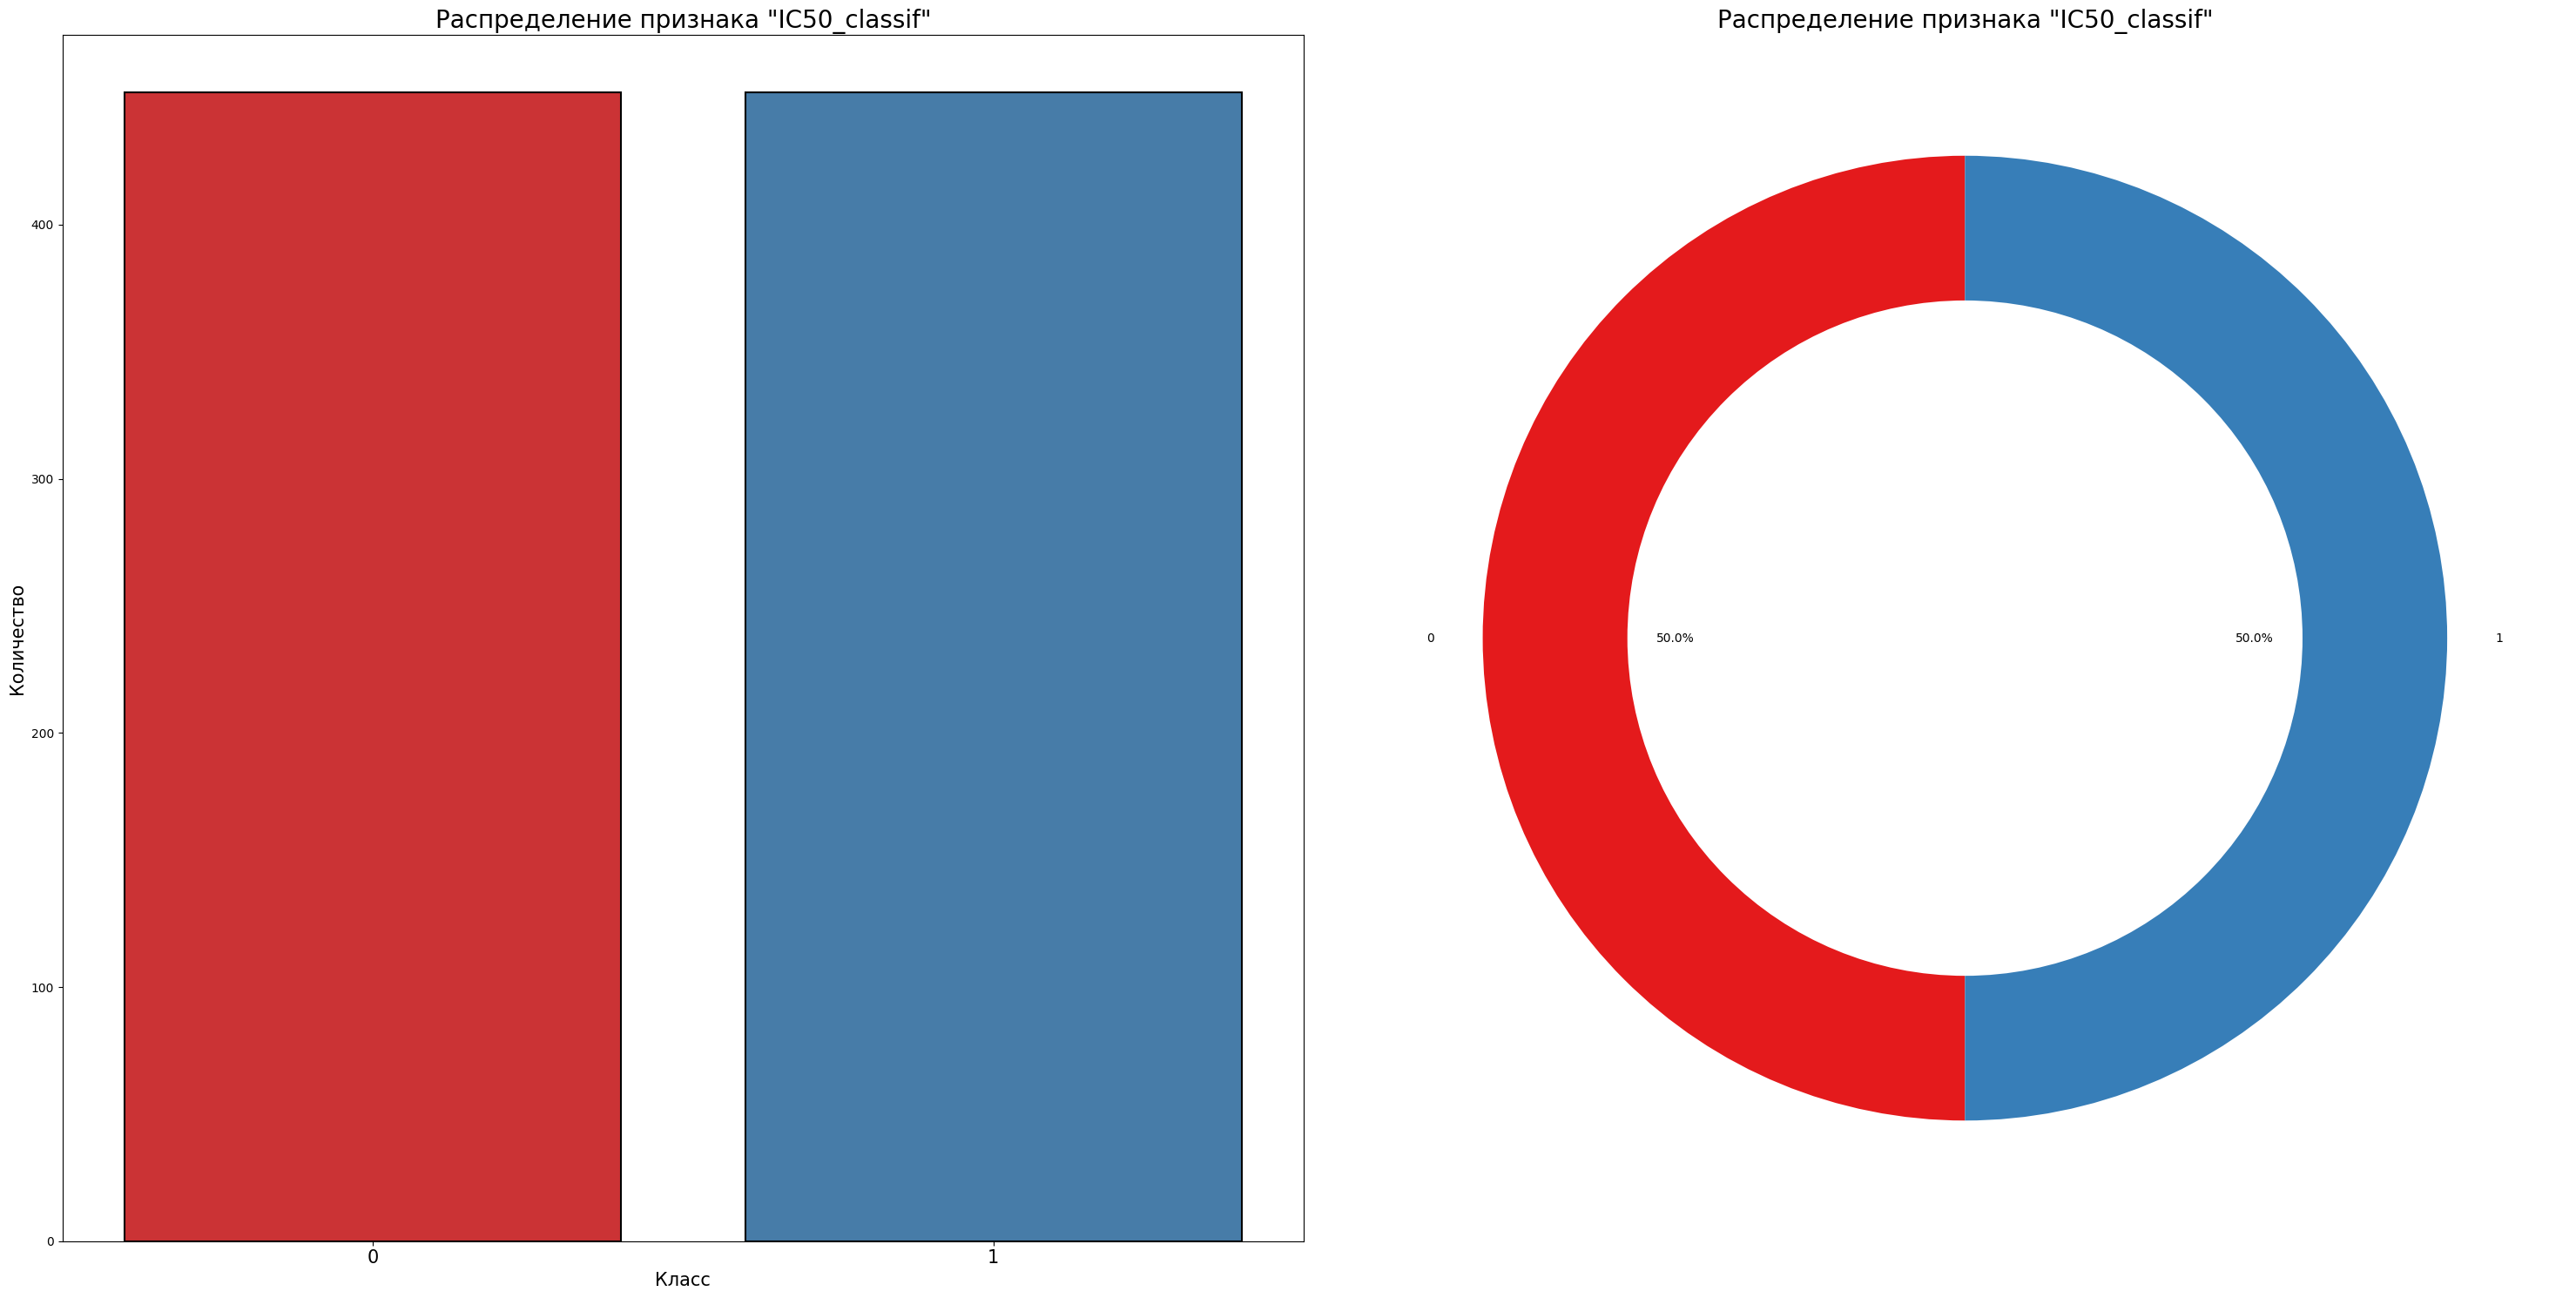

------------------------------------------------------------------------------------------------------------------------------------------------------


Распределение целевой переменной
------------------------------------------------------------------------------------------------------------------------------------------------------


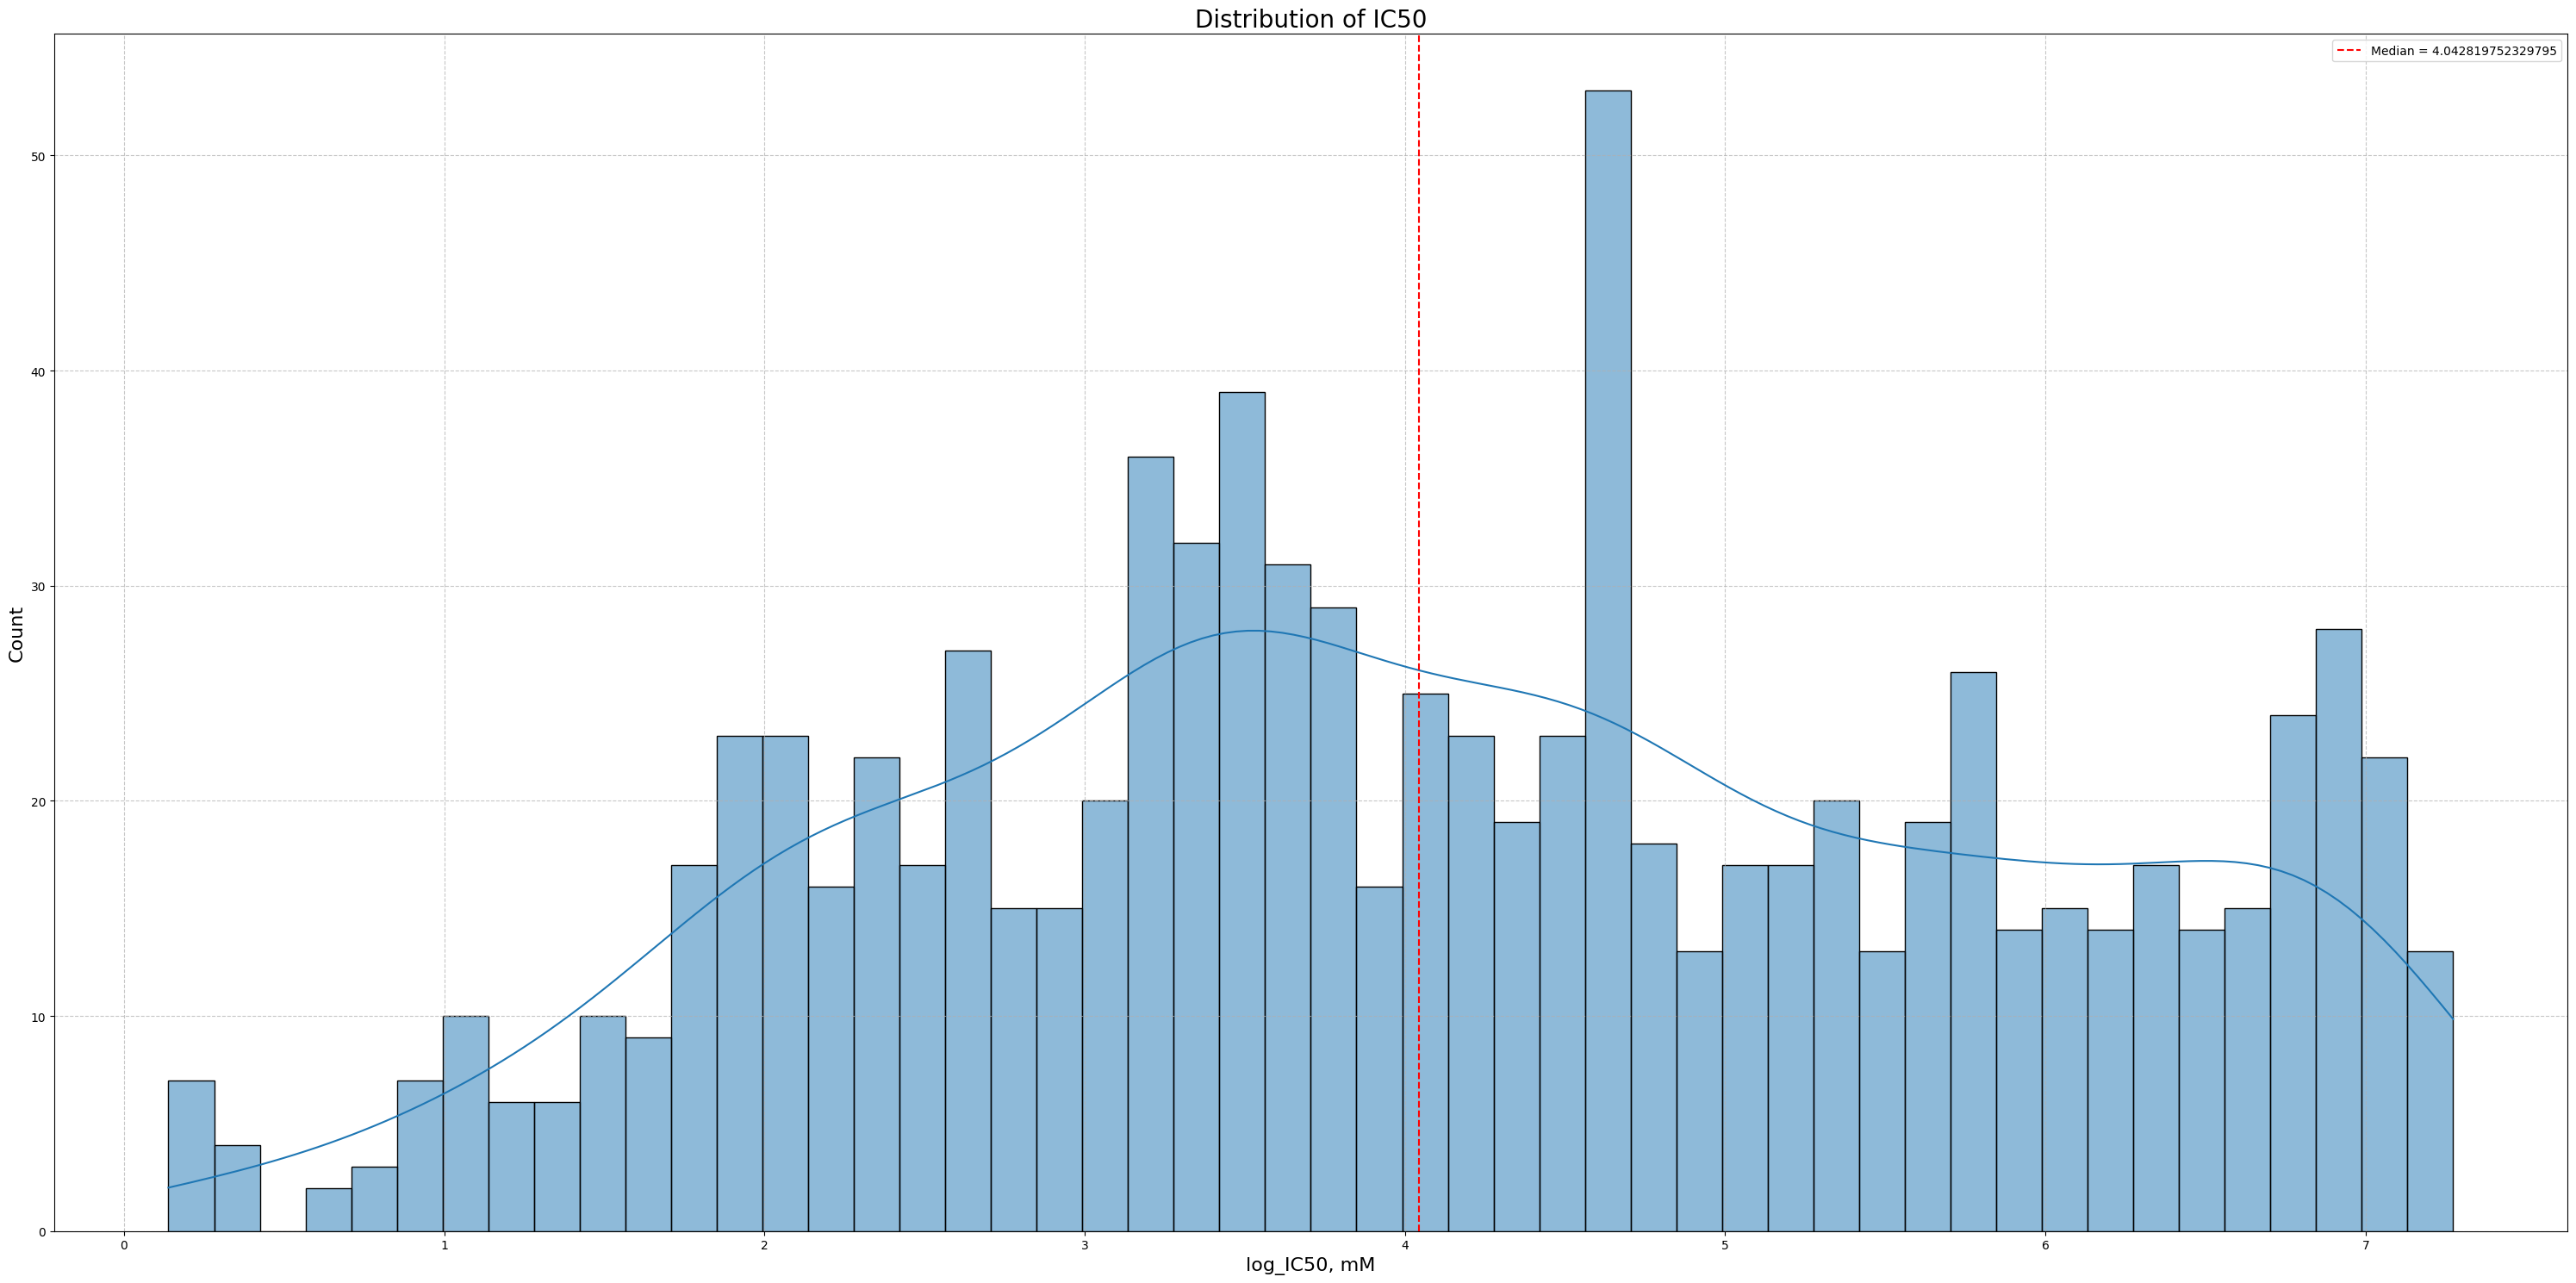

------------------------------------------------------------------------------------------------------------------------------------------------------


In [17]:
# Вычисляем медиану IC50
median_ic50 = molecule_df['log_IC50, mM'].median()
print(f'\nМедианное значение IC50: {median_ic50}')
print('-' * 45)
print('\n\n')


# Создаем целевую переменную (1 - превышает, 0 - не превышает)
molecule_df['IC50_classif'] = (molecule_df['log_IC50, mM'] > median_ic50).astype(int)
print('Уникальные значения признака "IC50_classif":\n')
display(molecule_df['IC50_classif'].value_counts())
print('-' * 45)




# Применяем функцию 'median_target_distribution_plot()' для построения графика распределения целевой переменной
median_target_distribution_plot(
    target = molecule_df['IC50_classif'],
    title1 = 'Распределение признака "IC50_classif"',
    main_title = 'Стобчатая и круговая диаграммы распределения целевой переменной:',
    color_palette = 'Set1',
    figsize = (30, 15)
)

# Применяем функцию 'target_distribution_plot()' для построения графика распределения целевой переменной
target_distribution_plot(
    data = molecule_df,
    target = 'log_IC50, mM',
    median_target = median_ic50,
    title = 'Distribution of IC50',
    main_title = 'Распределение целевой переменной',
    figsize = (30, 15)
)

**Вывод:**

Как видно по графику, распределение целевой переменной - равномерное, следовательно балансировка не требуется.

**Разделение данных.**

Разделим данные на тренировочную и тестовую выборки:

In [18]:
# Разделяем данные на матрицу наблюдений и вектор правильных ответов
X = molecule_df.drop(columns = ['IC50, mM', 'CC50, mM', 'SI', 'log_IC50, mM', 'log_CC50, mM', 'log_SI', 'IC50_classif'])
y = molecule_df['IC50_classif']


# Разделение на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    X, y,
    test_size = 0.2,
    random_state = 42
)


# Удаляем дублирующиеся столбцы
duplicated_features = ['Unnamed: 0', 'Unnamed: 0.1']
X_train.drop(columns = duplicated_features, axis = 1, inplace = True)
X_test.drop(columns = duplicated_features, axis = 1, inplace = True)


# Восстанавливаем индексы
X_train = X_train.reset_index(drop = True)
X_test = X_test.reset_index(drop = True)

Выводим информацию по тренировочной и тестовой выборкам:

In [19]:
# Информация по тренеровочной выборке
check_data_inf(
    data = X_train.head(),
    data_name = 'X_train',
    length1 = 40,
    length2 = 150
)
print('\n\n\n')



# Информация по тестовой выборке
check_data_inf(
    data = X_test.head(),
    data_name = 'X_test',
    length1 = 40,
    length2 = 150
)


Данные таблицы "X_train" имеют следующую размерность:

Количество строк: 5;
Количество признаков (столбцов): 217.
----------------------------------------


MaxAbsEStateIndex  MaxEStateIndex  MinAbsEStateIndex  MinEStateIndex  \
0           5.856558        5.856558           0.246833        0.246833   
1          12.679078       12.679078           0.324537       -1.636782   
2          11.753981       11.753981           0.034554       -0.365579   
3           6.821111        6.821111           0.213542        0.213542   
4          13.242698       13.242698           0.045904       -0.236099   

        qed        SPS    MolWt  HeavyAtomMolWt  ExactMolWt  \
0  0.701837  28.440000  334.463         308.255  334.204513   
1  0.687651  22.450000  266.252         256.172  266.057909   
2  0.662186  35.958333  352.456         328.264  352.145678   
3  0.738218  51.000000  207.361         182.161  207.198700   
4  0.878757  27.954545  322.449         299.265  322.151513   

   NumValenceElectrons  ...  fr_thiophene  fr_unbrch_alkane  fr_urea  \
0                  130  ...             0                 0        0   
1                   98  ...             0                 0        0   
2                  132  ...             1                 0        0   
3                   86  ...             0                 0        0   
4                  120  ...             0                 0        0   

            SI_category   fr_amide_presence  fr_aldehyde_presence  \
0  экстремально высокий  Без амидной группы            Без группы   
1  экстремально высокий  Без амидной группы            Без группы   
2         очень высокий   С амидной группой            Без группы   
3  экстремально высокий  Без амидной группы            Без группы   
4  экстремально высокий  Без амидной группы            Без группы   

   fr_aniline_presence  fr_amidine_presence  SI_and_8_classif  SI_classif  
0            С группой           Без группы                 0           1  
1           Без группы           Без группы                 0           1  
2           Без группы           Без группы                 0           0  
3           Без группы           Без группы                 1           1  
4            С группой           Без группы                 0           1  

[5 rows x 217 columns]

------------------------------------------------------------------------------------------------------------------------------------------------------





Данные таблицы "X_test" имеют следующую размерность:

Количество строк: 5;
Количество признаков (столбцов): 217.
----------------------------------------


MaxAbsEStateIndex  MaxEStateIndex  MinAbsEStateIndex  MinEStateIndex  \
0          11.443183       11.443183           0.096481       -1.486768   
1          12.764026       12.764026           0.103258       -4.525895   
2          10.748074       10.748074           0.007726       -0.824114   
3          12.465817       12.465817           0.263325       -2.956304   
4           5.100343        5.100343           0.393133        0.393133   

        qed        SPS    MolWt  HeavyAtomMolWt  ExactMolWt  \
0  0.498725  12.812500  244.192         240.160  244.001474   
1  0.345716  12.130435  345.325         334.237  345.067129   
2  0.668512  39.761905  295.335         274.167  295.141973   
3  0.277881  25.781250  468.579         427.251  468.286542   
4  0.343756  40.866667  412.706         364.322  412.381750   

   NumValenceElectrons  ...  fr_thiophene  fr_unbrch_alkane  fr_urea  \
0                   84  ...             0                 0        0   
1                  122  ...             0                 0        0   
2                  116  ...             0                 0        0   
3                  182  ...             0                 1        0   
4                  170  ...             0                 5        0   

            SI_category   fr_amide_presence  fr_aldehyde_presence  \
0                низкий  Без амидной группы            Без группы   
1             умеренный  Без амидной группы            Без группы   
2             умеренный  Без амидной группы            Без группы   
3               высокий  Без амидной группы            Без группы   
4  экстремально высокий  Без амидной группы            Без группы   

   fr_aniline_presence  fr_amidine_presence  SI_and_8_classif  SI_classif  
0           Без группы           Без группы                 0           0  
1            С группой           Без группы                 0           0  
2           Без группы           Без группы                 0           0  
3           Без группы           Без группы                 0           0  
4           Без группы           Без группы                 1           1  

[5 rows x 217 columns]

------------------------------------------------------------------------------------------------------------------------------------------------------


**Создание новых признаков.**

Обучаем внутренний пайплайн `feature_union` для создания новых признаков:

In [20]:
# Извлекаем 'FeatureUnion' из пайплайна и обучаем его
feature_union_step = preprocessing_pipeline.named_steps['feature_union']
feature_union_step.fit(X_train, y_train)

FeatureUnion(transformer_list=[('molecular_properties', MolecularProperties()),
                               ('functional_groups', FunctionalGroups()),
                               ('topological_descriptors',
                                TopologicalDescriptors()),
                               ('transformations', Transformations())])

Создаём новые признаки:

In [21]:
# Применим пайплайн к тренировочным и тестовым данным 
X_train_transformed = feature_union_step.transform(X_train)
X_test_transformed = feature_union_step.transform(X_test)


Данные таблицы "Molecular properties features" имеют следующую размерность:

Количество строк: 723;
Количество признаков (столбцов): 3.
----------------------------------------
------------------------------------------------------------




Данные таблицы "Functional groups features" имеют следующую размерность:

Количество строк: 723;
Количество признаков (столбцов): 8.
----------------------------------------
------------------------------------------------------------------------------------------




Данные таблицы "Topological descriptors features" имеют следующую размерность:

Количество строк: 723;
Количество признаков (столбцов): 4.
----------------------------------------
--------------------------------------------------------------------------------




Данные таблицы "Transformations features" имеют следующую размерность:

Количество строк: 723;
Количество признаков (столбцов): 3.
----------------------------------------
---------------------------------------------------

Из полученных массивов создаём **DataFrame**:

In [22]:
# Создадим массив в названиями созданных столбцов
feature_names = (
    ['MolWt_TPSA', 'MolWt_per_Heteroatoms', 'TPSA_per_MolLogP'] +
    
    ['total_functional_groups', 'fr_amide_plus_ester', 'fr_benzene_times_nitro', 
     'fr_Al_OH_per_benzene', 'fr_amide_presence', 'fr_aldehyde_presence', 
     'fr_aniline_presence', 'fr_amidine_presence'] +
    
    ['PEOE_VSA_total', 'SMR_VSA_ratio', 'Chi0_times_Kappa1', 'TPSA_times_FractionCSP3'] +
    ['log_MolWt', 'MolLogP_squared', 'NumRotatableBonds_squared']
)



# Преобразуем результат обратно в DataFrame 
X_train_transformed_df = pd.DataFrame(
    X_train_transformed,
    columns = feature_names,
    index = X_train.index
)

X_test_transformed_df = pd.DataFrame(
    X_test_transformed,
    columns = feature_names,
    index = X_test.index
)



# Информация по тренеровочной выборке
check_data_inf(
    data = X_train_transformed_df,
    data_name = 'X_train_transformed_df',
    length1 = 40,
    length2 = 150
)
print('\n\n\n')



# Информация по тестовой выборке
check_data_inf(
    data = X_test_transformed_df,
    data_name = 'X_test_transformed_df',
    length1 = 40,
    length2 = 150
)


Данные таблицы "X_train_transformed_df" имеют следующую размерность:

Количество строк: 723;
Количество признаков (столбцов): 18.
----------------------------------------


MolWt_TPSA  MolWt_per_Heteroatoms  TPSA_per_MolLogP  \
0    15923.78343             111.487295          7.961805   
1    14004.85520              66.562834         20.281317   
2    28714.59032              50.350785         21.342310   
3     5395.53322             207.358926          7.813345   
4    14558.57235              64.489671         10.204312   
..           ...                    ...               ...   
718  12581.97432             108.483638          8.533840   
719   4433.90802             177.782111          2.420184   
720  29641.79000              59.641343         16.478671   
721  29560.74597              43.811174         20.366195   
722   6913.66520              92.813024          8.287994   

     total_functional_groups  fr_amide_plus_ester  fr_benzene_times_nitro  \
0                       11.0                  0.0                     0.0   
1                       16.0                  1.0                     0.0   
2                       10.0                  1.0                     0.0   
3                        1.0                  0.0                     0.0   
4                       11.0                  0.0                     0.0   
..                       ...                  ...                     ...   
718                      9.0                  1.0                     0.0   
719                      8.0                  0.0                     0.0   
720                     19.0                  2.0                     0.0   
721                     15.0                  1.0                     0.0   
722                      7.0                  0.0                     0.0   

     fr_Al_OH_per_benzene  fr_amide_presence  fr_aldehyde_presence  \
0                     0.0                0.0                   0.0   
1                     0.0                0.0                   0.0   
2                     0.0                1.0                   0.0   
3                     0.0                0.0                   0.0   
4                     1.0                0.0                   0.0   
..                    ...                ...                   ...   
718                   0.0                0.0                   0.0   
719                   0.0                0.0                   0.0   
720                   0.0                1.0                   0.0   
721                   0.0                0.0                   0.0   
722                   0.0                0.0                   0.0   

     fr_aniline_presence  fr_amidine_presence  PEOE_VSA_total  SMR_VSA_ratio  \
0                    1.0                  0.0      149.360916   4.119361e-01   
1                    0.0                  0.0      113.994086   3.315551e+00   
2                    0.0                  0.0      145.177915   1.445471e+11   
3                    0.0                  0.0       93.234527   0.000000e+00   
4                    1.0                  0.0      134.011377   9.496942e+10   
..                   ...                  ...             ...            ...   
718                  0.0                  0.0      144.185324   9.531400e+10   
719                  0.0                  0.0      159.839111   4.736863e+10   
720                  0.0                  0.0      177.698241   2.491679e+00   
721                  0.0                  0.0      155.188097   1.603381e+00   
722                  0.0                  0.0      122.936037   4.736863e+10   

     Chi0_times_Kappa1  TPSA_times_FractionCSP3  log_MolWt  MolLogP_squared  \
0           285.915036                19.476818   5.815512        35.758008   
1           156.118042                 6.575000   5.588192         6.726346   
2           303.433991                57.508235   5.867759        14.571779   
3           108.266752                26.020000   5.339272        11.090232   
4           250.321159                26.558824   5.779041        19.577085   
..                 ...                      ...        ...              

------------------------------------------------------------------------------------------------------------------------------------------------------





Данные таблицы "X_test_transformed_df" имеют следующую размерность:

Количество строк: 181;
Количество признаков (столбцов): 18.
----------------------------------------


MolWt_TPSA  MolWt_per_Heteroatoms  TPSA_per_MolLogP  \
0    33246.74080              22.199253        -88.305876   
1    22480.65750              34.532465         19.858459   
2    25322.02290              49.222418         26.751950   
3    41155.29357              52.064275         17.126867   
4    10202.09232             206.351968          3.128559   
..           ...                    ...               ...   
176   3623.07684             139.240608         14.702226   
177  24600.45960              57.231571         17.589778   
178  24069.54446              57.895570         17.494824   
179  28200.21244              60.739565         29.528716   
180   3281.14740             132.731836          3.287234   

     total_functional_groups  fr_amide_plus_ester  fr_benzene_times_nitro  \
0                       15.0                  0.0                     0.0   
1                       21.0                  0.0                     0.0   
2                        6.0                  0.0                     0.0   
3                       13.0                  0.0                     0.0   
4                       13.0                  0.0                     0.0   
..                       ...                  ...                     ...   
176                      3.0                  0.0                     0.0   
177                     17.0                  0.0                     0.0   
178                     20.0                  1.0                     0.0   
179                     13.0                  0.0                     0.0   
180                      7.0                  0.0                     0.0   

     fr_Al_OH_per_benzene  fr_amide_presence  fr_aldehyde_presence  \
0            0.000000e+00                0.0                   0.0   
1            0.000000e+00                0.0                   0.0   
2            1.000000e+10                0.0                   0.0   
3            0.000000e+00                0.0                   0.0   
4            0.000000e+00                0.0                   0.0   
..                    ...                ...                   ...   
176          0.000000e+00                0.0                   0.0   
177          0.000000e+00                0.0                   0.0   
178          0.000000e+00                1.0                   0.0   
179          2.000000e+00                0.0                   0.0   
180          0.000000e+00                0.0                   0.0   

     fr_aniline_presence  fr_amidine_presence  PEOE_VSA_total  SMR_VSA_ratio  \
0                    0.0                  0.0       88.203045   9.132210e+10   
1                    1.0                  0.0      132.969341   1.756166e+11   
2                    0.0                  0.0      122.250891   1.918385e+11   
3                    0.0                  0.0      192.683531   1.834941e+11   
4                    0.0                  0.0      186.585749   0.000000e+00   
..                   ...                  ...             ...            ...   
176                  0.0                  0.0       62.136250   0.000000e+00   
177                  1.0                  0.0      150.262400   4.259017e-01   
178                  1.0                  0.0      149.359937   2.426041e+00   
179                  0.0                  0.0      153.603719   1.690608e+00   
180                  0.0                  0.0      119.042856   4.483031e+10   

     Chi0_times_Kappa1  TPSA_times_FractionCSP3  log_MolWt  MolLogP_squared  \
0           122.868196                27.230000   5.502042         2.377147   
1           287.439094                10.015385   5.847378        10.746595   
2           220.886740                62.876000   5.691491        10.272025   
3           593.692975                76.373913   6.151837        26.298435   
4           487.189500                22.954286   6.025156        62.432122   
..                 ...                      ...        ...              

------------------------------------------------------------------------------------------------------------------------------------------------------


Объединим созданные признаки с основными:

In [23]:
# Объединяем признаки тренеровочной выборки
X_train_full = pd.concat(
    [X_train, X_train_transformed_df],
    axis = 1
)


# Объединяем признаки тестовой выборки
X_test_full = pd.concat(
    [X_test, X_test_transformed_df],
    axis = 1
)



# Информация по тренеровочной выборке
check_data_inf(
    data = X_train_full,
    data_name = 'X_train_full',
    length1 = 40,
    length2 = 150
)
print('\n\n\n')



# Информация по тестовой выборке
check_data_inf(
    data = X_test_full,
    data_name = 'X_test_full',
    length1 = 40,
    length2 = 150
)


Данные таблицы "X_train_full" имеют следующую размерность:

Количество строк: 723;
Количество признаков (столбцов): 235.
----------------------------------------


MaxAbsEStateIndex  MaxEStateIndex  MinAbsEStateIndex  MinEStateIndex  \
0             5.856558        5.856558           0.246833        0.246833   
1            12.679078       12.679078           0.324537       -1.636782   
2            11.753981       11.753981           0.034554       -0.365579   
3             6.821111        6.821111           0.213542        0.213542   
4            13.242698       13.242698           0.045904       -0.236099   
..                 ...             ...                ...             ...   
718          11.748658       11.748658           0.231039       -0.306910   
719           5.583517        5.583517           0.363472        0.363472   
720          12.383317       12.383317           0.146735       -0.678187   
721          14.205155       14.205155           0.126096       -1.805806   
722           5.387662        5.387662           0.385547        0.385547   

          qed        SPS    MolWt  HeavyAtomMolWt  ExactMolWt  \
0    0.701837  28.440000  334.463         308.255  334.204513   
1    0.687651  22.450000  266.252         256.172  266.057909   
2    0.662186  35.958333  352.456         328.264  352.145678   
3    0.738218  51.000000  207.361         182.161  207.198700   
4    0.878757  27.954545  322.449         299.265  322.151513   
..        ...        ...      ...             ...         ...   
718  0.453065  29.458333  325.452         298.236  325.204179   
719  0.743057  35.192308  355.566         318.270  355.287515   
720  0.685037  21.100000  417.490         398.338  417.114712   
721  0.496490  10.785714  394.301         381.197  394.066423   
722  0.738551  38.750000  278.440         248.200  278.235814   

     NumValenceElectrons  ...  fr_aldehyde_presence  fr_aniline_presence  \
0                    130  ...                   0.0                  1.0   
1                     98  ...                   0.0                  0.0   
2                    132  ...                   0.0                  0.0   
3                     86  ...                   0.0                  0.0   
4                    120  ...                   0.0                  1.0   
..                   ...  ...                   ...                  ...   
718                  128  ...                   0.0                  0.0   
719                  144  ...                   0.0                  0.0   
720                  150  ...                   0.0                  0.0   
721                  146  ...                   0.0                  0.0   
722                  114  ...                   0.0                  0.0   

     fr_amidine_presence  PEOE_VSA_total  SMR_VSA_ratio  Chi0_times_Kappa1  \
0                    0.0      149.360916   4.119361e-01         285.915036   
1                    0.0      113.994086   3.315551e+00         156.118042   
2                    0.0      145.177915   1.445471e+11         303.433991   
3                    0.0       93.234527   0.000000e+00         108.266752   
4                    0.0      134.011377   9.496942e+10         250.321159   
..                   ...             ...            ...                ...   
718                  0.0      144.185324   9.531400e+10         291.525205   
719                  0.0      159.839111   4.736863e+10         339.742096   
720                  0.0      177.698241   2.491679e+00         386.270326   
721                  0.0      155.188097   1.603381e+00         396.808712   
722                  0.0      122.936037   4.736863e+10         206.493336   

     TPSA_times_FractionCSP3  log_MolWt  MolLogP_squared  \
0                  19.476818   5.815512        35.758008   
1                   6.575000   5.588192         6.726346   
2                  57.508235   5.867759        14.571779   
3                  26.020000   5.339272        11.090232   
4                  26.558824   5.779041        19.577085   
..                       ...        ...              ...   
718                20.250476 

------------------------------------------------------------------------------------------------------------------------------------------------------





Данные таблицы "X_test_full" имеют следующую размерность:

Количество строк: 181;
Количество признаков (столбцов): 235.
----------------------------------------


MaxAbsEStateIndex  MaxEStateIndex  MinAbsEStateIndex  MinEStateIndex  \
0            11.443183       11.443183           0.096481       -1.486768   
1            12.764026       12.764026           0.103258       -4.525895   
2            10.748074       10.748074           0.007726       -0.824114   
3            12.465817       12.465817           0.263325       -2.956304   
4             5.100343        5.100343           0.393133        0.393133   
..                 ...             ...                ...             ...   
176           5.884213        5.884213           0.453981        0.453981   
177          12.796013       12.796013           0.250728       -0.296951   
178          12.310058       12.310058           0.239946       -0.337469   
179          11.051605       11.051605           0.139362       -0.952221   
180           5.055208        5.055208           0.388390        0.388390   

          qed        SPS    MolWt  HeavyAtomMolWt  ExactMolWt  \
0    0.498725  12.812500  244.192         240.160  244.001474   
1    0.345716  12.130435  345.325         334.237  345.067129   
2    0.668512  39.761905  295.335         274.167  295.141973   
3    0.277881  25.781250  468.579         427.251  468.286542   
4    0.343756  40.866667  412.706         364.322  412.381750   
..        ...        ...      ...             ...         ...   
176  0.588383  48.000000  139.242         122.106  139.136100   
177  0.728654  14.923077  343.390         326.254  343.143310   
178  0.573075  10.769231  347.374         330.238  347.126991   
179  0.800035  33.884615  364.438         336.214  364.188589   
180  0.671223  35.263158  265.465         232.201  265.263825   

     NumValenceElectrons  ...  fr_aldehyde_presence  fr_aniline_presence  \
0                     84  ...                   0.0                  0.0   
1                    122  ...                   0.0                  1.0   
2                    116  ...                   0.0                  0.0   
3                    182  ...                   0.0                  0.0   
4                    170  ...                   0.0                  0.0   
..                   ...  ...                   ...                  ...   
176                   58  ...                   0.0                  0.0   
177                  128  ...                   0.0                  1.0   
178                  130  ...                   0.0                  1.0   
179                  144  ...                   0.0                  0.0   
180                  110  ...                   0.0                  0.0   

     fr_amidine_presence  PEOE_VSA_total  SMR_VSA_ratio  Chi0_times_Kappa1  \
0                    0.0       88.203045   9.132210e+10         122.868196   
1                    0.0      132.969341   1.756166e+11         287.439094   
2                    0.0      122.250891   1.918385e+11         220.886740   
3                    0.0      192.683531   1.834941e+11         593.692975   
4                    0.0      186.585749   0.000000e+00         487.189500   
..                   ...             ...            ...                ...   
176                  0.0       62.136250   0.000000e+00          47.513863   
177                  0.0      150.262400   4.259017e-01         288.753005   
178                  0.0      149.359937   2.426041e+00         283.546647   
179                  0.0      153.603719   1.690608e+00         362.412095   
180                  0.0      119.042856   4.483031e+10         215.062009   

     TPSA_times_FractionCSP3  log_MolWt  MolLogP_squared  \
0                  27.230000   5.502042         2.377147   
1                  10.015385   5.847378        10.746595   
2                  62.876000   5.691491        10.272025   
3                  76.373913   6.151837        26.298435   
4                  22.954286   6.025156        62.432122   
..                       ...        ...              ...   
176                26.020000 

------------------------------------------------------------------------------------------------------------------------------------------------------


Подсчитаем количество типов данных по признакам:

In [24]:
# Выводим данные таблицы 'X_train_full'
check_features_dtypes(
    data = X_train_full,
    data_name = 'X_train_full',
    length1 = 65,
    length2 = 40
)

В таблице "X_train_full" представлены признаки следующих типов:
-----------------------------------------------------------------

Количество признаков типа 'object': 5
Количество признаков типа 'int64': 106
Количество признаков типа 'float64': 122
Количество признаков типа 'bool': 0
----------------------------------------


В данных присутствуют признаки типа `object`, так как модели не работают с такими типами данных, избавимся от них:

In [25]:
# Создаём функцию для удалени признаков типа 'object'
def remove_non_numeric_columns(data):
    return data.select_dtypes(include = [np.number])


# Применяем полученную функцию к тренировочному и тестовому DataFrame
X_train_full = remove_non_numeric_columns(X_train_full)
X_test_full = remove_non_numeric_columns(X_test_full)




# Выводим данные таблицы 'X_train_full'
check_features_dtypes(
    data = X_train_full,
    data_name = 'X_train_full',
    length1 = 0,
    length2 = 65
)

print('\n\n')


# Выводим данные таблицы 'X_test_full'
check_features_dtypes(
    data = X_test_full,
    data_name = 'X_test_full',
    length1 = 0,
    length2 = 65
)

В таблице "X_train_full" представлены признаки следующих типов:


Количество признаков типа 'object': 0
Количество признаков типа 'int64': 106
Количество признаков типа 'float64': 122
Количество признаков типа 'bool': 0
-----------------------------------------------------------------



В таблице "X_test_full" представлены признаки следующих типов:


Количество признаков типа 'object': 0
Количество признаков типа 'int64': 106
Количество признаков типа 'float64': 122
Количество признаков типа 'bool': 0
-----------------------------------------------------------------


**Преобразовываем данные.**

Теперь избавимся от мультиколлинеарности и стандартизируем данные:

In [26]:
# Извлечение шагов
feature_selector = preprocessing_pipeline.named_steps['feature_selector']
S_scaler = preprocessing_pipeline.named_steps['S_scaler']


# Создание нового пайплайна с 'feature_selector' и 'S_scaler'
partial_pipeline = pipeline.Pipeline(
    [
        ('feature_selector', feature_selector),
        ('S_scaler', S_scaler)
    ]
)


# Обучаем созданный пайплайн на тренировочной выборке
partial_pipeline.fit(X_train_full, y_train)

Pipeline(steps=[('feature_selector', FeatureSelector()),
                ('S_scaler', StandardScaler())])

Преобразовываем тренировочную и тестовую выборки:

In [27]:
# Применим пайплайн к тренировочным и тестовым данным 
X_train_processed_full = partial_pipeline.transform(X_train_full)
X_test_processed_full = partial_pipeline.transform(X_test_full)


# Получаем список оставшихся признаков
fs_step = partial_pipeline.named_steps['feature_selector']
remaining_features = X_train_full.columns.difference(fs_step.to_drop_corr + fs_step.to_drop_var, sort = False)



# Преобразуем результат обратно в DataFrame 
X_train_processed_df = pd.DataFrame(
    X_train_processed_full,
    columns = remaining_features,
    index = X_train_full.index
)

X_test_processed_df = pd.DataFrame(
    X_test_processed_full,
    columns =remaining_features,
    index = X_test_full.index
)



# Выведем результаты
# Информация по тренеровочной выборке
check_data_inf(
    data = X_train_processed_df,
    data_name = 'X_train_processed_df',
    length1 = 40,
    length2 = 150
)
print('\n\n\n')



# Информация по тестовой выборке
check_data_inf(
    data = X_test_processed_df,
    data_name = 'X_test_processed_df',
    length1 = 40,
    length2 = 150
)


Данные таблицы "X_train_processed_df" имеют следующую размерность:

Количество строк: 723;
Количество признаков (столбцов): 105.
----------------------------------------


MaxAbsEStateIndex  MinAbsEStateIndex  MinEStateIndex       qed       SPS  \
0            -1.496602           0.422613        0.771519  0.579771 -0.081941   
1             0.527403           0.904784       -0.394927  0.514586 -0.554818   
2             0.252959          -0.894628        0.392277  0.397569  0.511590   
3            -1.210453           0.216033        0.750903  0.746949  1.699045   
4             0.694610          -0.824197        0.472459  1.392750 -0.120265   
..                 ...                ...             ...       ...       ...   
718           0.251380           0.324610        0.428609 -0.563375 -0.001549   
719          -1.577604           1.146384        0.843749  0.769183  0.451116   
720           0.439661          -0.198519        0.198692  0.502574 -0.661393   
721           0.980138          -0.326590       -0.499596 -0.363831 -1.475648   
722          -1.635707           1.283362        0.857418  0.748480  0.731976   

        MolWt  FpDensityMorgan1  BCUT2D_MWHI  BCUT2D_MWLOW  BCUT2D_CHGHI  ...  \
0   -0.172284         -0.720975    -0.482466     -0.231601      0.709602  ...   
1   -0.694608         -0.970049    -0.465835      0.425592      0.670103  ...   
2   -0.034503          1.347721     0.555049     -0.313054      0.077316  ...   
3   -1.145565         -0.554926    -0.589790     -0.967502      0.838770  ...   
4   -0.264281          0.954612     0.555048     -0.403346     -0.483621  ...   
..        ...               ...          ...           ...           ...  ...   
718 -0.241286          0.655849    -0.479027     -0.231089      0.700544  ...   
719 -0.010688          0.083725    -0.482669     -0.749877      0.230117  ...   
720  0.463493         -0.416552     0.557248      0.434471     -0.335264  ...   
721  0.285924         -0.703184    -0.304289      0.607120     -1.303146  ...   
722 -0.601279          0.482881    -0.482670     -0.231261      0.699655  ...   

     fr_thiazole  fr_thiophene  fr_unbrch_alkane  SI_and_8_classif  \
0      -0.266667     -0.303554         -0.177731         -0.685210   
1      -0.266667     -0.303554         -0.177731         -0.685210   
2      -0.266667      3.294307         -0.177731         -0.685210   
3      -0.266667     -0.303554         -0.177731          1.459407   
4       3.750000     -0.303554         -0.177731         -0.685210   
..           ...           ...               ...               ...   
718    -0.266667     -0.303554         -0.177731         -0.685210   
719    -0.266667     -0.303554         -0.177731         -0.685210   
720    -0.266667     -0.303554         -0.177731         -0.685210   
721    -0.266667     -0.303554         -0.177731          1.459407   
722    -0.266667     -0.303554         -0.177731          1.459407   

     SI_classif  MolWt_per_Heteroatoms  TPSA_per_MolLogP  \
0      1.006940              -0.064531         -0.017568   
1      1.006940              -0.064565          0.133615   
2     -0.993108              -0.064578          0.146636   
3      1.006940              -0.064458         -0.019390   
4      1.006940              -0.064567          0.009951   
..          ...                    ...               ...   
718    1.006940              -0.064533         -0.010548   
719   -0.993108              -0.064481         -0.085575   
720   -0.993108              -0.064571          0.086950   
721    1.006940              -0.064583          0.134657   
722    1.006940              -0.064545         -0.013565   

     fr_Al_OH_per_benzene  SMR_VSA_ratio  TPSA_times_FractionCSP3  
0               -0.338656      -0.806000                -0.332149  
1               -0.338656      -0.806000                -0.857136  
2               -0.338656       0.736551                 1.215385  
3               -0.338656      -0.806000                -0.065901  
4               -0.338656       0.207477                -0.043975  
..                    ...            ...                      ...  
718             -0.33

------------------------------------------------------------------------------------------------------------------------------------------------------





Данные таблицы "X_test_processed_df" имеют следующую размерность:

Количество строк: 181;
Количество признаков (столбцов): 105.
----------------------------------------


MaxAbsEStateIndex  MinAbsEStateIndex  MinEStateIndex       qed       SPS  \
0             0.160756          -0.510352       -0.302029 -0.353559 -1.315644   
1             0.552605          -0.468304       -2.184035 -1.056662 -1.369489   
2            -0.045459          -1.061101        0.108325  0.426638  0.811860   
3             0.464136           0.524951       -1.212053 -1.368374 -0.291834   
4            -1.720945           1.330435        0.862116 -1.065667  0.899075   
..                 ...                ...             ...       ...       ...   
176          -1.488398           1.708016        0.899797  0.058433  1.462212   
177           0.562094           0.446785        0.434776  0.703003 -1.149026   
178           0.417928           0.379878        0.409685 -0.011909 -1.476949   
179           0.044589          -0.244271        0.028994  1.031010  0.347881   
180          -1.734335           1.301008        0.859179  0.439095  0.456709   

        MolWt  FpDensityMorgan1  BCUT2D_MWHI  BCUT2D_MWLOW  BCUT2D_CHGHI  ...  \
0   -0.863532          1.780140     0.559264      2.296748     -1.732256  ...   
1   -0.089109          0.528003     0.552297      1.154219     -0.893501  ...   
2   -0.471906          1.224172    -0.471246     -0.265352      0.017607  ...   
3    0.854706          0.353155     0.492597     -0.231089      0.701536  ...   
4    0.426860         -2.215418    -0.592477     -0.231368      0.760929  ...   
..        ...               ...          ...           ...           ...  ...   
176 -1.667184          0.690443    -0.603011      0.127272     -0.483112  ...   
177 -0.103926         -0.554926    -0.504065      0.884829     -1.319795  ...   
178 -0.073419         -0.395263    -0.482662      1.260989     -2.026415  ...   
179  0.057249         -0.075938    -0.478956     -0.226828      0.099772  ...   
180 -0.700635          0.319017    -0.559207     -0.231174      0.702776  ...   

     fr_thiazole  fr_thiophene  fr_unbrch_alkane  SI_and_8_classif  \
0      -0.266667     -0.303554         -0.177731         -0.685210   
1      -0.266667     -0.303554         -0.177731         -0.685210   
2      -0.266667     -0.303554         -0.177731         -0.685210   
3      -0.266667     -0.303554          0.788429         -0.685210   
4      -0.266667     -0.303554          4.653068          1.459407   
..           ...           ...               ...               ...   
176    -0.266667     -0.303554         -0.177731         -0.685210   
177    -0.266667     -0.303554         -0.177731         -0.685210   
178    -0.266667     -0.303554         -0.177731          1.459407   
179    -0.266667     -0.303554         -0.177731         -0.685210   
180    -0.266667     -0.303554         -0.177731          1.459407   

     SI_classif  MolWt_per_Heteroatoms  TPSA_per_MolLogP  \
0     -0.993108              -0.064599         -1.198955   
1     -0.993108              -0.064590          0.128426   
2     -0.993108              -0.064578          0.213022   
3     -0.993108              -0.064576          0.094904   
4      1.006940              -0.064459         -0.076881   
..          ...                    ...               ...   
176    1.006940              -0.064510          0.065149   
177   -0.993108              -0.064572          0.100585   
178    1.006940              -0.064572          0.099420   
179   -0.993108              -0.064570          0.247098   
180    1.006940              -0.064515         -0.074934   

     fr_Al_OH_per_benzene  SMR_VSA_ratio  TPSA_times_FractionCSP3  
0               -0.338656       0.168554                -0.016665  
1               -0.338656       1.068112                -0.717143  
2                1.475033       1.241226                 1.433804  
3               -0.338656       1.152177                 1.983047  
4               -0.338656      -0.806000                -0.190647  
..                    ...            ...                      ...  
176             -0.33

------------------------------------------------------------------------------------------------------------------------------------------------------


Создадим функцию для визуализации распределения:

In [28]:
# Создаём функцию 'features_distribution_plot()' для построения графика распределения признаков
def features_distribution_plot(data, title = None, figsize = None):
    
    
    # Создаём заголовок для графика
    print('График распределения признаков:')
    print('-' * 150)
    
    
    """
    Функция для построения графиков распределения признаков.
    
    Параметры:
    - data: pandas DataFrame с данными.
    - features: список признаков для анализа.
    - title: заголовок графика.
    - figsize: размер графика.
    
    """
    
    
    # Задаём размер графика
    fig, ax = plt.subplots(figsize = figsize)

    # Построение плотностей распределения
    for column in data.columns:
    
        sns.kdeplot(
            data[column], 
            label = column, 
            ax = ax
        )



    # Настройка легенды: выносим за пределы графика
    plt.legend(
        bbox_to_anchor = (1.05, 1),
        loc = 'upper left',
        fontsize = 10
    )

    # Настройка графика
    plt.title(title, fontsize = 20)
    plt.xlabel('Значение', fontsize = 15)
    plt.ylabel('Плотность', fontsize = 15)
    plt.grid(True, linestyle = '--', alpha = 0.7)
    plt.tight_layout()  
    
    
    
    # Выводим график
    plt.show()
    print('-' * 150)

Строим графики для тренировочной и тестовой выборок:


График распределения признаков:
------------------------------------------------------------------------------------------------------------------------------------------------------


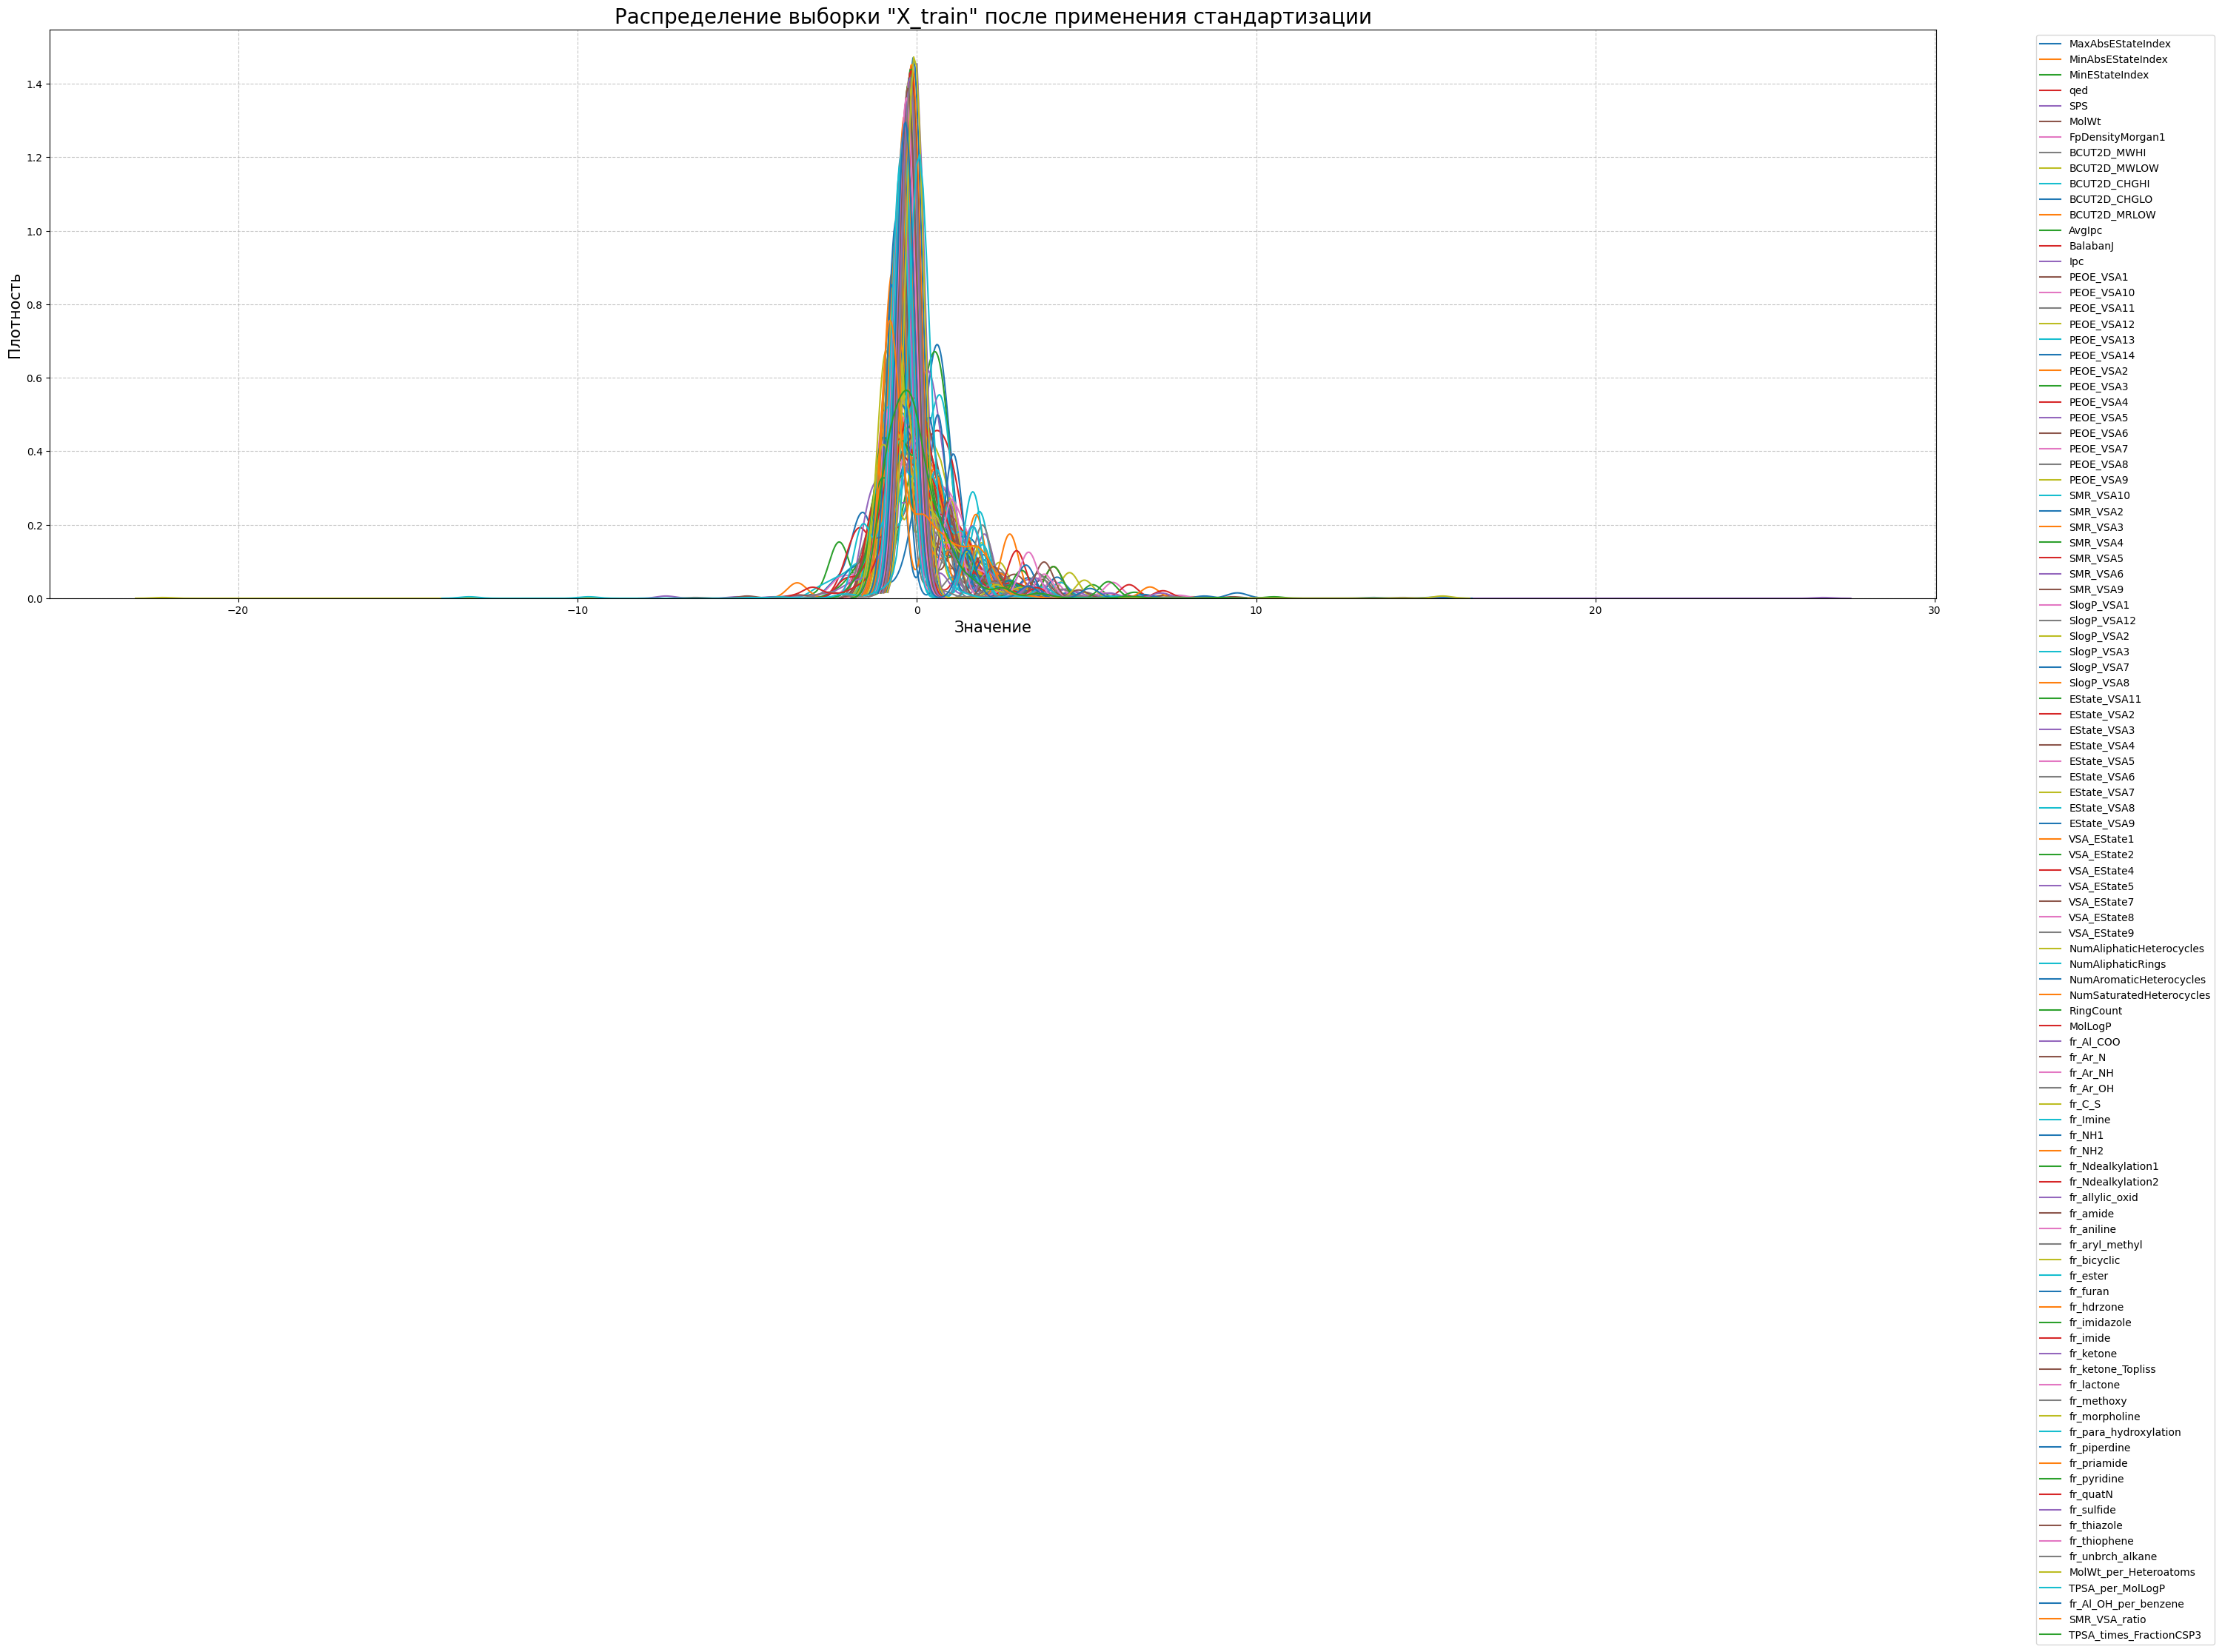

------------------------------------------------------------------------------------------------------------------------------------------------------



График распределения признаков:
------------------------------------------------------------------------------------------------------------------------------------------------------


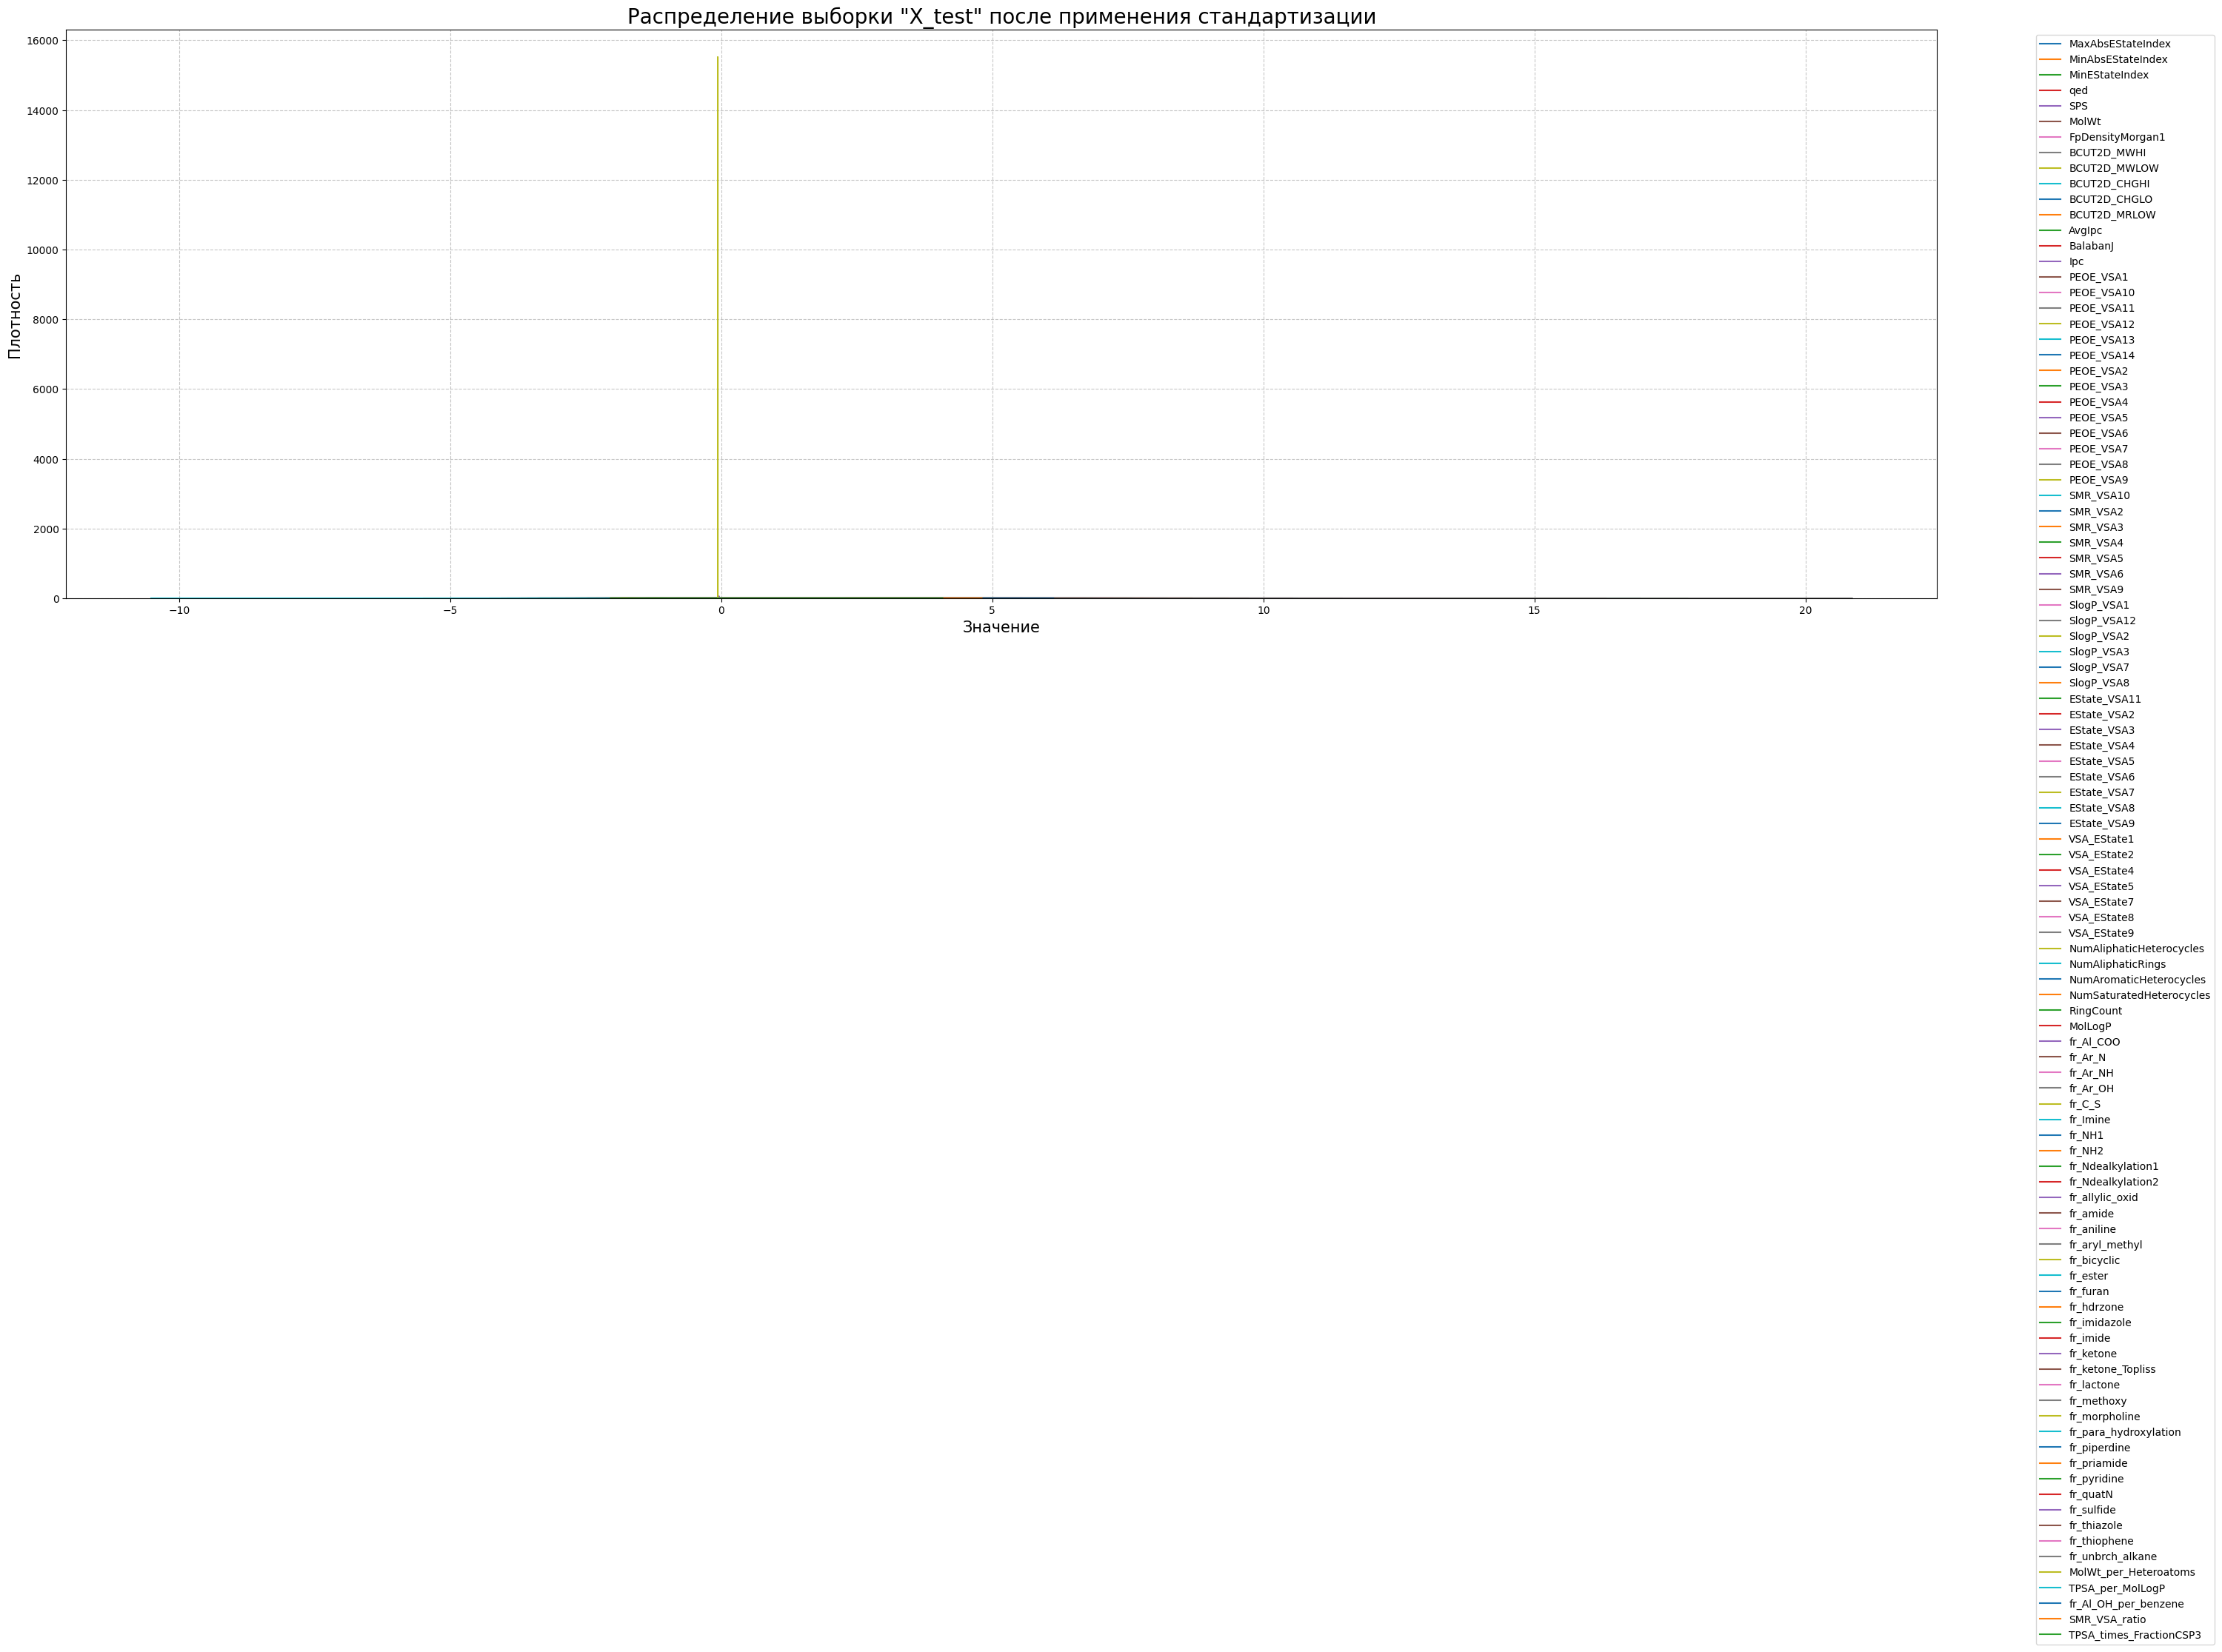

------------------------------------------------------------------------------------------------------------------------------------------------------


In [27]:
# Применяем функцию 'features_distribution_plot()' для построения графика распределения признаков X_train
print()
features_distribution_plot(
    data = X_train_processed_df,
    title = 'Распределение выборки "X_train" после применения стандартизации',
    figsize = (30, 17)
)

# Добавляем отступ
print('\n\n')



# Применяем функцию 'features_distribution_plot()' для построения графика распределения признаков X_test
features_distribution_plot(
    data = X_test_processed_df,
    title = 'Распределение выборки "X_test" после применения стандартизации',
    figsize = (30, 17)
)

**Вывод:**

Судя по графику, после стандартизации признаки имеют нормальное распределение.

#### $1.2$

#### **Отбор самых информативных признаков.**

На данном этапе отберём только самые информативные признаки для дальнейшего решения задачи регрессии.

Производить отбор признаков будем в $4$ этапа:

1. Отберём $50$ признаков с помощью алгоритма **Mutual Information**,
2. Отберём $50$ признаков с помощью алгоритма **F-test**,
3. Отберём $50$ признаков из отобранных обоими алгоритмами,
4. Из оставшихся отберём $30$ признаков с помощью алгоритма **Lasso**.

--

Для начала создадим функцию для визуализации кумулятивной линии вклада конкретного алгоритма отбора признаков для того, что бы  вычислить необходимое количество признаков, чтобы покрыть $90$% информации:

In [29]:
# Создаём функцию для построения кумулятивной линии
def cum_line(data, main_title = None, title = None):
    
    
    """
    Функция для построения кумулятивной линии.
    
    Параметры:
    - data: pandas Series с данными.
    - main_title: название графика.
    - title: заголовок графика.
    
    """
    
    
    # Создаём DataFrame с кумулятивной долей информации
    alg_cumsum = (data.cumsum() / data.sum()).reset_index()
    alg_cumsum.columns = ['feature', 'cumulative_share']

    # Задаём заглавие для графика
    print(f'\n{main_title}')
    print('-' * 150)


    # Строим график кумулятивного вклада признаков
    fig = px.line(
        alg_cumsum,
        x = alg_cumsum.index + 1,
        y = 'cumulative_share',
        markers = True,
        title = title
    )

    # Добавляем горизонтальную линию на уровне 0.9
    fig.add_hline(
        y = 0.9, 
        line_dash = 'dash', 
        line_color = 'red',
        annotation_text = '90 %', 
        annotation_position = 'bottom right'
    )

    # Настраиваем оси графика
    fig.update_layout(
        height = 800,
        width = 1200,
        title = title,
        xaxis_title = 'Число признаков',
        yaxis_title = 'Доля информации',
    
        yaxis = dict(
            tickmode = 'linear',
            dtick = 0.1,
            tickvals = [i / 10 for i in range(11)],
            ticktext = [str(i / 10) for i in range(11)]
        )
    
    )

    # Выводим график
    fig.show('png')
    print('-' * 150)

Теперь создадим функцию для визуализации важности признаков:

In [30]:
# Создаём функцию для построения горизонтального столбчатого графика
def bar_scores(data, main_title = None, title = None, color = None):
    
    
    """
    Функция для построения горизонтального столбчатого графика.
    
    Параметры:
    - data: pandas Series с оценками признаков.
    - main_title: название графика.
    - title: заголовок графика.
    - color: цвет столбцов графика.
    
    """
    
    
    # Задаём заглавие для графика
    print(f'\n{main_title}')
    print('-' * 150)



    # Строим график распределения 50 признаков по "Mutual Information"
    fig = px.bar(
        data.head(50).reset_index(),
        x = 'index',    
        y = data.head(50).values,  
        title = title,
        orientation = 'v',  
        color_discrete_sequence = sns.color_palette(color, 50),  
        text = data.head(50).values,  
    
        labels = {
            'index': 'Признаки', 
            'y': 'Mutual Information (MI)'
        }
    
    )

    # Настраиваем оси графика
    fig.update_layout(
        height = 800,
        width = 1200,
        xaxis_title = 'Признаки',
        yaxis_title = 'Mutual Information (MI)',
        xaxis_tickangle = -45,  
        bargap = 0.35 
    )



    # Выводим график
    fig.show('png')
    print('-' * 150)

**Первый этап:** Фильтрация с помощью `Mutual Information` для отбора первых $50$ признаков:


Топ-50 признаков по "Mutual Information":

BCUT2D_MRLOW               0.136943
BCUT2D_MWHI                0.133498
SMR_VSA5                   0.129232
SI_and_8_classif           0.119639
SI_classif                 0.116791
SlogP_VSA2                 0.115599
PEOE_VSA1                  0.094778
BCUT2D_CHGHI               0.090310
BCUT2D_MWLOW               0.088712
SPS                        0.086413
EState_VSA8                0.086088
PEOE_VSA7                  0.085498
EState_VSA6                0.085271
BCUT2D_CHGLO               0.084492
VSA_EState2                0.084089
SlogP_VSA1                 0.083316
PEOE_VSA2                  0.083038
VSA_EState8                0.080440
PEOE_VSA6                  0.076317
PEOE_VSA9                  0.071373
EState_VSA3                0.066763
TPSA_times_FractionCSP3    0.065650
AvgIpc                     0.065289
SMR_VSA9                   0.062896
EState_VSA2                0.062490
PEOE_VSA11                 0.060852
VSA_EState1         

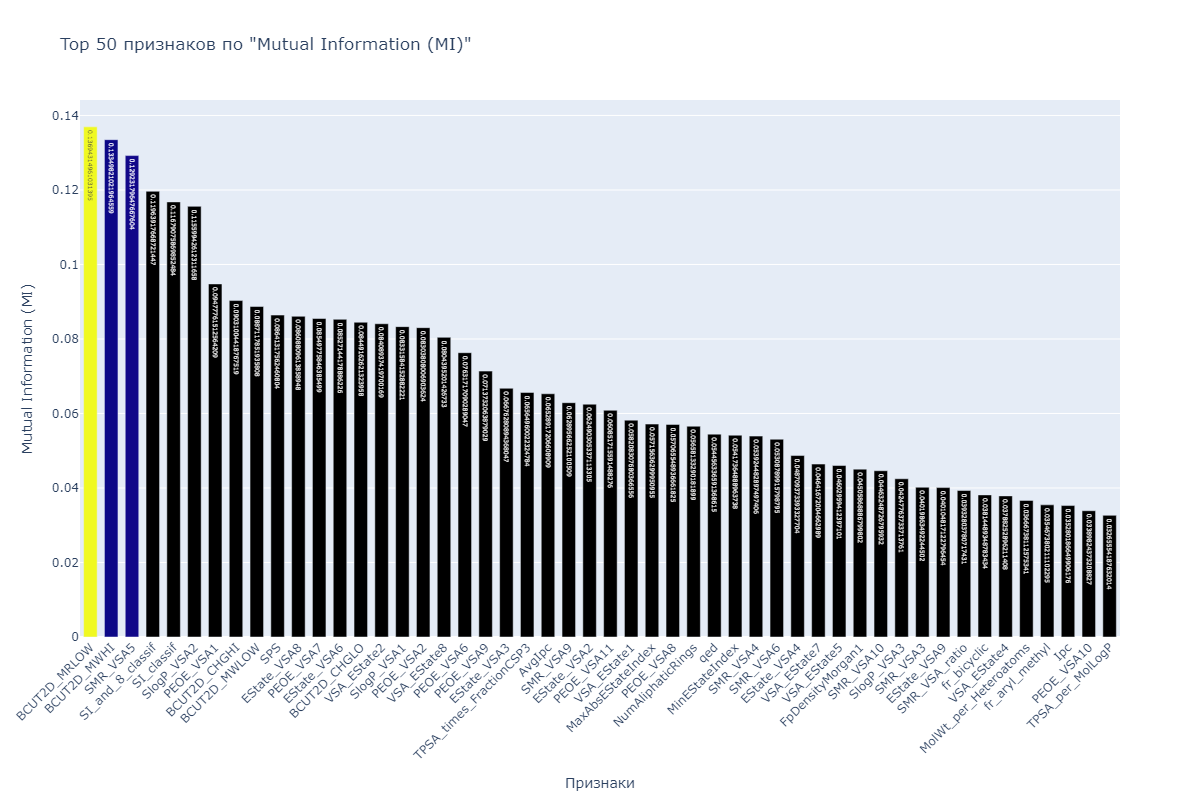

------------------------------------------------------------------------------------------------------------------------------------------------------


График кумулятивного вклада признаков (MI)
------------------------------------------------------------------------------------------------------------------------------------------------------


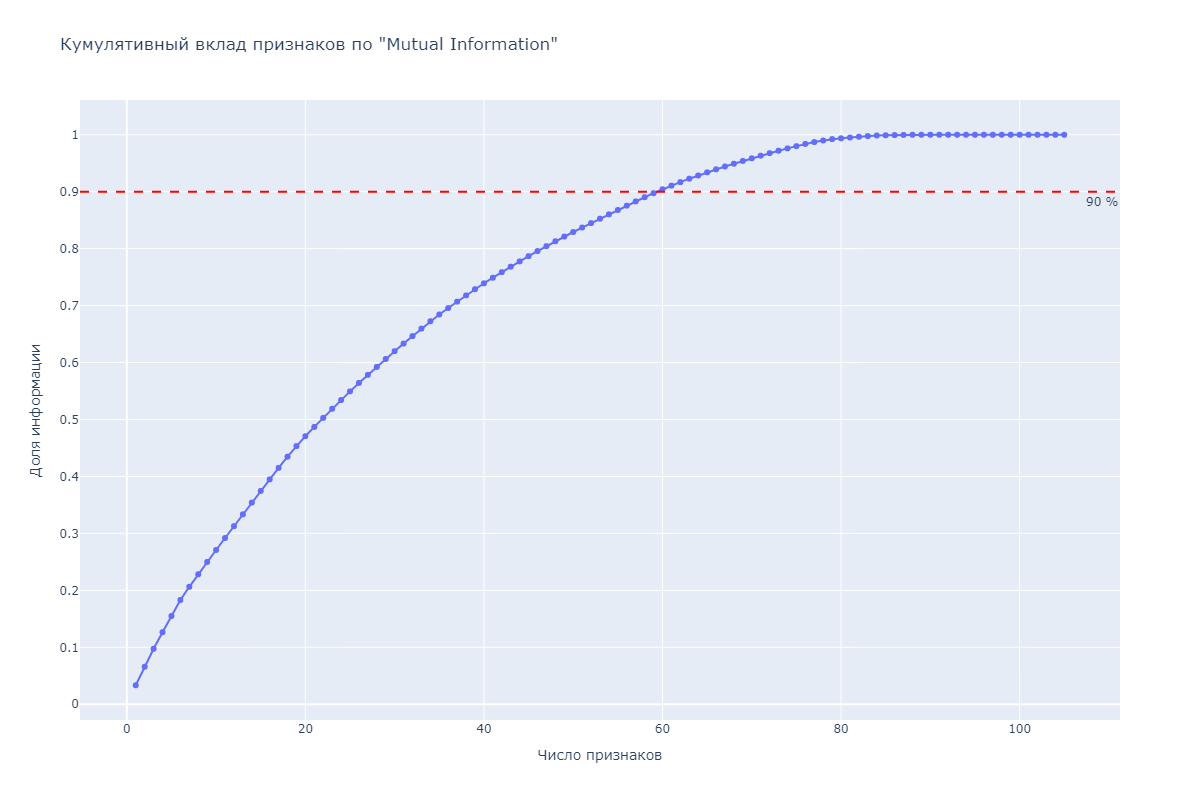

------------------------------------------------------------------------------------------------------------------------------------------------------


In [31]:
# Инициализируем класс 'SelectKBest' с алгоритмом 'mutual_info_classif'
mi_selector = feature_selection.SelectKBest(
    score_func = feature_selection.mutual_info_classif,
    k = 50
)

# Обучаем алгоритм
mi_selector.fit(X_train_processed_df, y_train)



# Из полученных результатов создадим столбец 'Series'          
mi_scores = pd.Series(
    mi_selector.scores_,
    index = X_train_processed_df.columns
).sort_values(ascending = False)



# Выделяем отобранные признаки
mi_selected_features = X_train_processed_df.columns[mi_selector.get_support()].tolist()

# Выводим результат
print(f'\nТоп-50 признаков по "Mutual Information":\n\n{mi_scores.head(50)}')
print('-' * 40)
print('\n\n')




# Посторим график оценки важности признаков при помощи функции 'bar_scores'
bar_scores(
    data = mi_scores,
    main_title = 'График распределения 50 признаков по "Mutual Information":',
    title = 'Top 50 признаков по "Mutual Information (MI)"',
    color = 'Set1'
)
print()


# Построим кумулятивную линию при помощи функции 'cum_line'
cum_line(
    data = mi_scores,
    main_title = 'График кумулятивного вклада признаков (MI)',
    title = 'Кумулятивный вклад признаков по "Mutual Information"'
)

**Вывод:**

По графику кумулятивного вклада признаков по `Mutual Information` видно, что наиболее оптимальное количество признаков, объясняющее $90$% дисперсии, находится в диапазоне от $56$ до $58$.

**Второй этап:** Фильтрация признаков с помощью `F-теста` для отбора первых $50$ признаков:


Топ-50 признаков по "F-тесту"

SI_classif                  257.906935
SI_and_8_classif            217.858853
NumSaturatedHeterocycles     45.001605
NumAliphaticHeterocycles     32.505666
VSA_EState4                  28.791699
VSA_EState8                  27.008787
EState_VSA8                  25.182463
EState_VSA5                  22.123502
VSA_EState7                  20.063263
PEOE_VSA6                    17.231256
SMR_VSA4                     16.989209
PEOE_VSA7                    16.955596
fr_NH2                       14.264126
MinEStateIndex               14.092183
VSA_EState1                  14.029598
EState_VSA4                  13.382974
SMR_VSA5                     12.468273
fr_Ndealkylation2            11.827870
fr_furan                     11.249610
MaxAbsEStateIndex            10.766676
MolLogP                      10.500896
qed                          10.333602
EState_VSA11                  9.125939
fr_ketone_Topliss             8.545651
fr_sulfide                    8.

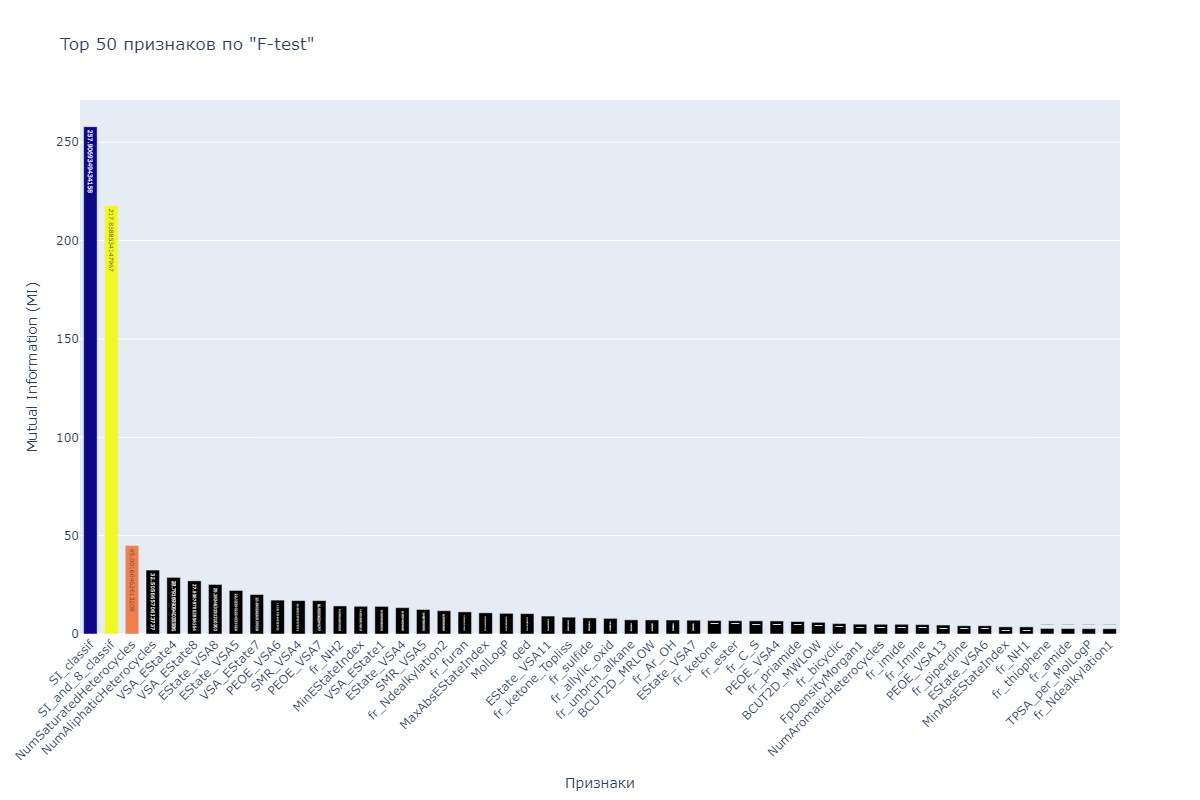

------------------------------------------------------------------------------------------------------------------------------------------------------


График кумулятивного вклада признаков (F-test):
------------------------------------------------------------------------------------------------------------------------------------------------------


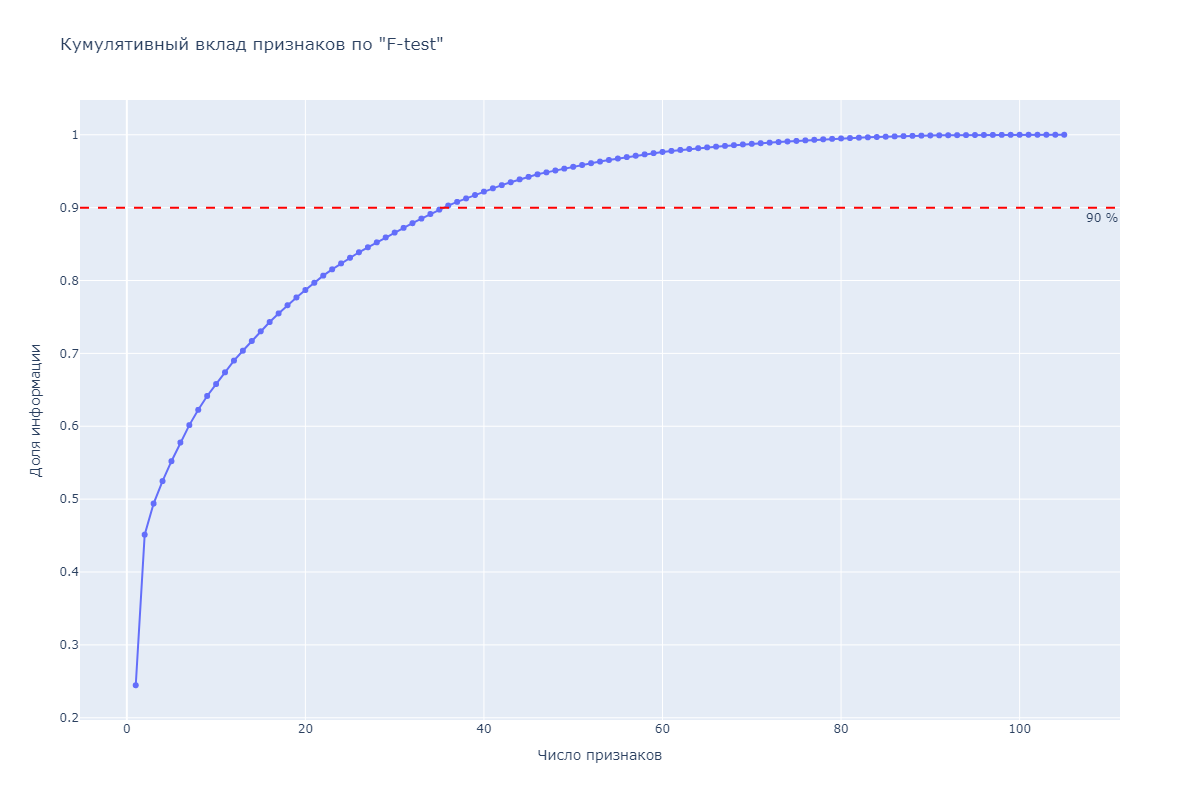

------------------------------------------------------------------------------------------------------------------------------------------------------


In [32]:
# Инициализируем класс 'SelectKBest' с алгоритмом 'f_classif'              
f_selector = feature_selection.SelectKBest(
    score_func = feature_selection.f_classif,
    k = 50
)

# Обучаем алгоритм
f_selector.fit(X_train_processed_df, y_train)



# Из полученных результатов создадим столбец 'Series'   
f_scores = pd.Series(
    f_selector.scores_,
    index = X_train_processed_df.columns
).sort_values(ascending = False)



# Выделяем отобранные признаки
f_selected_features = X_train_processed_df.columns[f_selector.get_support()].tolist()

# Выводим результат
print(f'\nТоп-50 признаков по "F-тесту"\n\n{f_scores.head(50)}')
print('-' * 40)
print('\n\n')




# Посторим график оценки важности признаков при помощи функции 'bar_scores'
bar_scores(
    data = f_scores,
    main_title = 'График распределения 50 признаков по "F-test":',
    title = 'Top 50 признаков по "F-test"',
    color = 'Set2'
)
print()


# Построим кумулятивную линию при помощи функции 'cum_line'
cum_line(
    data = f_scores,
    main_title = 'График кумулятивного вклада признаков (F-test):',
    title = 'Кумулятивный вклад признаков по "F-test"'
)

**Вывод:**

По `F-test` оптимальное количество признаков уже чуть меньше (примерно $43$ - $44$).

**Третий этап:** Отбор лучших $50$ признаков из отобранных обоими алгоритмами:

In [33]:
# Пересечение признаков от "Mutual Information" и "F-теста"
common_features = list(set(mi_selected_features) & set(f_selected_features))

# Выводим результат
print(f'\nКоличество общих признаков ("Mutual Information" и "F-тест"): {len(common_features)}')
print('-' * 65)
print('\n\n')



# Если количество признаков меньше 50, дополняем из 'Mutual Information'
if len(common_features) < 50:
    additional_features = [feature for feature in mi_selected_features if feature not in common_features]
    common_features.extend(additional_features[:50 - len(common_features)])
    
# Выводим результат
print(f'Итоговые 50 признаков после фильтрации:\n\n{common_features}')
print('-' * 150)


Количество общих признаков ("Mutual Information" и "F-тест"): 21
-----------------------------------------------------------------



Итоговые 50 признаков после фильтрации:

['MaxAbsEStateIndex', 'PEOE_VSA7', 'VSA_EState4', 'MinEStateIndex', 'BCUT2D_MWLOW', 'EState_VSA4', 'SMR_VSA5', 'BCUT2D_MRLOW', 'PEOE_VSA6', 'SMR_VSA4', 'VSA_EState8', 'fr_bicyclic', 'SI_and_8_classif', 'FpDensityMorgan1', 'TPSA_per_MolLogP', 'EState_VSA8', 'VSA_EState7', 'qed', 'SI_classif', 'EState_VSA6', 'VSA_EState1', 'SPS', 'BCUT2D_MWHI', 'BCUT2D_CHGHI', 'BCUT2D_CHGLO', 'AvgIpc', 'Ipc', 'PEOE_VSA1', 'PEOE_VSA10', 'PEOE_VSA11', 'PEOE_VSA2', 'PEOE_VSA8', 'PEOE_VSA9', 'SMR_VSA10', 'SMR_VSA3', 'SMR_VSA6', 'SMR_VSA9', 'SlogP_VSA1', 'SlogP_VSA2', 'SlogP_VSA3', 'EState_VSA2', 'EState_VSA3', 'EState_VSA9', 'VSA_EState2', 'VSA_EState5', 'NumAliphaticRings', 'fr_aryl_methyl', 'MolWt_per_Heteroatoms', 'SMR_VSA_ratio', 'TPSA_times_FractionCSP3']
----------------------------------------------------------------------------

Сохраняем отобранные признаки в выборках:

In [34]:
# Сокращаем признаки в тренировочной и тестовой выборках до 50 отобранных
X_train_filtered = X_train_processed_df[common_features]
X_test_filtered = X_test_processed_df[common_features]



# Выведем результаты
# Информация по тренеровочной выборке
check_data_inf(
    data = X_train_filtered,
    data_name = 'X_train_filtered',
    length1 = 40,
    length2 = 150
)
print('\n\n\n')


# Информация по тестовой выборке
check_data_inf(
    data = X_test_filtered,
    data_name = 'X_test_filtered',
    length1 = 40,
    length2 = 150
)


Данные таблицы "X_train_filtered" имеют следующую размерность:

Количество строк: 723;
Количество признаков (столбцов): 50.
----------------------------------------


MaxAbsEStateIndex  PEOE_VSA7  VSA_EState4  MinEStateIndex  BCUT2D_MWLOW  \
0            -1.496602   1.628333     2.503470        0.771519     -0.231601   
1             0.527403  -0.504015     0.014302       -0.394927      0.425592   
2             0.252959  -0.457205    -0.834664        0.392277     -0.313054   
3            -1.210453   1.143588     1.851472        0.750903     -0.967502   
4             0.694610   0.270976    -0.370231        0.472459     -0.403346   
..                 ...        ...          ...             ...           ...   
718           0.251380   0.004357     0.271046        0.428609     -0.231089   
719          -1.577604   1.008224     1.202870        0.843749     -0.749877   
720           0.439661   0.428075     0.280488        0.198692      0.434471   
721           0.980138  -0.786662    -1.533837       -0.499596      0.607120   
722          -1.635707  -0.225370     0.092775        0.857418     -0.231261   

     EState_VSA4  SMR_VSA5  BCUT2D_MRLOW  PEOE_VSA6  SMR_VSA4  ...  \
0       1.012479 -0.054649      1.094114  -0.283280  0.809641  ...   
1      -1.063253 -0.966737     -0.132690  -0.116601 -0.927114  ...   
2       0.237265  0.752115     -1.317070  -0.096764  0.018407  ...   
3      -0.209812  0.756481     -0.265867  -0.613549  1.381794  ...   
4       1.428540  0.149113      0.266289   0.257495 -0.061945  ...   
..           ...       ...           ...        ...       ...  ...   
718    -0.199418 -0.054649     -0.295874   1.163576  0.809641  ...   
719     0.803055  0.983472      0.140106   1.221381 -0.021769  ...   
720     1.329183 -0.795632     -0.232253   1.040884 -0.519580  ...   
721    -0.954993 -1.391050      0.531099  -1.274086 -0.927114  ...   
722     1.261254  0.159691      0.438134  -0.283280  0.809641  ...   

     EState_VSA2  EState_VSA3  EState_VSA9  VSA_EState2  VSA_EState5  \
0      -0.642902    -0.791905     0.703425    -0.731273     0.875327   
1      -0.612792     0.381094     0.042850     0.683650    -0.723162   
2       1.659867     0.092873    -0.479599     0.581600     0.320846   
3      -0.632769    -0.791905    -0.369657    -1.092745     1.075515   
4       0.774582    -1.164993    -1.002048    -0.768015    -0.077143   
..           ...          ...          ...          ...          ...   
718    -0.154825     0.114232     0.071034     0.099133     0.172446   
719    -1.085657    -0.011078    -0.479599    -0.899965     0.530838   
720     0.319731    -0.722604     0.083057     0.650119     0.166710   
721    -0.160658    -0.350889     0.530036     0.705109    -2.182500   
722    -1.085657    -0.418817     0.071034    -0.549976     0.327517   

     NumAliphaticRings  fr_aryl_methyl  MolWt_per_Heteroatoms  SMR_VSA_ratio  \
0            -0.123882       -0.400279              -0.064531      -0.806000   
1            -0.123882        1.933607              -0.064565      -0.806000   
2            -0.123882       -0.400279              -0.064578       0.736551   
3             1.344428       -0.400279              -0.064458      -0.806000   
4            -0.858037       -0.400279              -0.064567       0.207477   
..                 ...             ...                    ...            ...   
718          -0.123882       -0.400279              -0.064533       0.211154   
719           0.610273        1.933607              -0.064481      -0.300500   
720          -0.123882       -0.400279              -0.064571      -0.806000   
721          -1.592192       -0.400279              -0.064583      -0.806000   
722           0.610273       -0.400279              -0.064545      -0.300500   

     TPSA_times_FractionCSP3  
0                  -0.332149  
1                  -0.857136  
2                   1.215385  
3                  -0.065901  
4                  -0.043975  
..                       ...  
718                -0.300668  
719                -0.744117  
720                -0.622234  
721                -0.643005  
722                -0.173756  

[723

------------------------------------------------------------------------------------------------------------------------------------------------------





Данные таблицы "X_test_filtered" имеют следующую размерность:

Количество строк: 181;
Количество признаков (столбцов): 50.
----------------------------------------


MaxAbsEStateIndex  PEOE_VSA7  VSA_EState4  MinEStateIndex  BCUT2D_MWLOW  \
0             0.160756  -1.638111    -1.070186       -0.302029      2.296748   
1             0.552605   0.323003     0.072302       -2.184035      1.154219   
2            -0.045459  -0.457205    -1.001606        0.108325     -0.265352   
3             0.464136   0.666848     0.251347       -1.212053     -0.231089   
4            -1.720945   1.404096     0.932722        0.862116     -0.231368   
..                 ...        ...          ...             ...           ...   
176          -1.488398   0.079415     1.288017        0.899797      0.127272   
177           0.562094  -0.711178     1.781502        0.434776      0.884829   
178           0.417928  -0.252574    -0.127502        0.409685      1.260989   
179           0.044589   0.061704    -0.465348        0.028994     -0.226828   
180          -1.734335   0.101554     0.097061        0.859179     -0.231174   

     EState_VSA4  SMR_VSA5  BCUT2D_MRLOW  PEOE_VSA6  SMR_VSA4  ...  \
0      -1.452750 -1.218918     -1.365982  -1.274086 -0.927114  ...   
1      -1.028044 -0.953746     -0.312065  -1.274086 -0.519580  ...   
2      -0.104185  0.523061     -1.412236  -0.637539  0.018407  ...   
3       0.708760  1.275313      0.805772  -0.034597  0.809641  ...   
4       0.292272  2.567789      1.093239   1.932642  2.546396  ...   
..           ...       ...           ...        ...       ...  ...   
176    -0.209812 -0.100876      1.509991  -0.967807  0.949210  ...   
177    -0.275581 -0.928795      0.691163   1.016894 -0.120755  ...   
178    -0.277778 -1.172573      0.698000   0.172770 -0.927114  ...   
179    -0.673080  0.298145     -0.587122  -0.984255 -0.454353  ...   
180    -0.266382  0.407607     -3.522563  -0.283280  0.809641  ...   

     EState_VSA2  EState_VSA3  EState_VSA9  VSA_EState2  VSA_EState5  \
0      -0.191636    -0.853886    -1.002048     0.680807    -0.355714   
1       0.740576    -0.773137     0.345513    -1.092745    -0.134131   
2       0.378423     0.082011     0.007587    -0.360243     0.318123   
3      -0.642902     2.355336     1.068921    -0.738469     0.292743   
4      -1.085657     0.327360     0.099219    -0.357125     0.653392   
..           ...          ...          ...          ...          ...   
176    -1.085657    -0.748715    -0.369657    -1.092745     1.076714   
177    -0.135646     0.021690    -1.002048     0.152801     0.085952   
178    -0.131675     0.150979     0.007587     0.121094     0.432689   
179    -0.102694     0.908194     1.087747    -1.092745     0.531638   
180    -1.085657    -0.418817    -0.451414    -0.728190     0.328861   

     NumAliphaticRings  fr_aryl_methyl  MolWt_per_Heteroatoms  SMR_VSA_ratio  \
0            -1.592192       -0.400279              -0.064599       0.168554   
1            -1.592192       -0.400279              -0.064590       1.068112   
2            -0.123882       -0.400279              -0.064578       1.241226   
3            -0.123882        1.933607              -0.064576       1.152177   
4             1.344428       -0.400279              -0.064459      -0.806000   
..                 ...             ...                    ...            ...   
176          -0.123882       -0.400279              -0.064510      -0.806000   
177          -0.858037        1.933607              -0.064572      -0.806000   
178          -1.592192       -0.400279              -0.064572      -0.806000   
179          -0.123882       -0.400279              -0.064570      -0.806000   
180          -0.123882       -0.400279              -0.064515      -0.327588   

     TPSA_times_FractionCSP3  
0                  -0.016665  
1                  -0.717143  
2                   1.433804  
3                   1.983047  
4                  -0.190647  
..                       ...  
176                -0.065901  
177                -0.833169  
178                -0.842731  
179                 0.764520  
180                -0.651323  

[181

------------------------------------------------------------------------------------------------------------------------------------------------------


**Четвёртый этап**: Применение `LogisticRegression` для выбора $30$ признаков:

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:486: UserWarning:

X has feature names, but SelectFromModel was fitted without feature names




Топ-30 финальных признаков после "LogisticRegression"

SI_classif                 0.973351
SPS                        0.757651
MinEStateIndex             0.746311
SI_and_8_classif           0.693121
VSA_EState5                0.686030
VSA_EState1                0.663355
VSA_EState8                0.652370
AvgIpc                     0.592763
SlogP_VSA2                 0.583742
NumAliphaticRings          0.570415
SMR_VSA10                  0.544056
PEOE_VSA11                 0.529459
SlogP_VSA3                 0.496754
EState_VSA4                0.344311
BCUT2D_MRLOW               0.339302
MaxAbsEStateIndex          0.313868
PEOE_VSA8                  0.308600
VSA_EState7                0.304201
PEOE_VSA1                  0.292747
TPSA_times_FractionCSP3    0.284439
BCUT2D_CHGLO               0.243713
fr_aryl_methyl             0.218704
BCUT2D_CHGHI               0.211494
VSA_EState4                0.204778
EState_VSA8                0.203076
BCUT2D_MWLOW               0.170507
PEOE_VSA

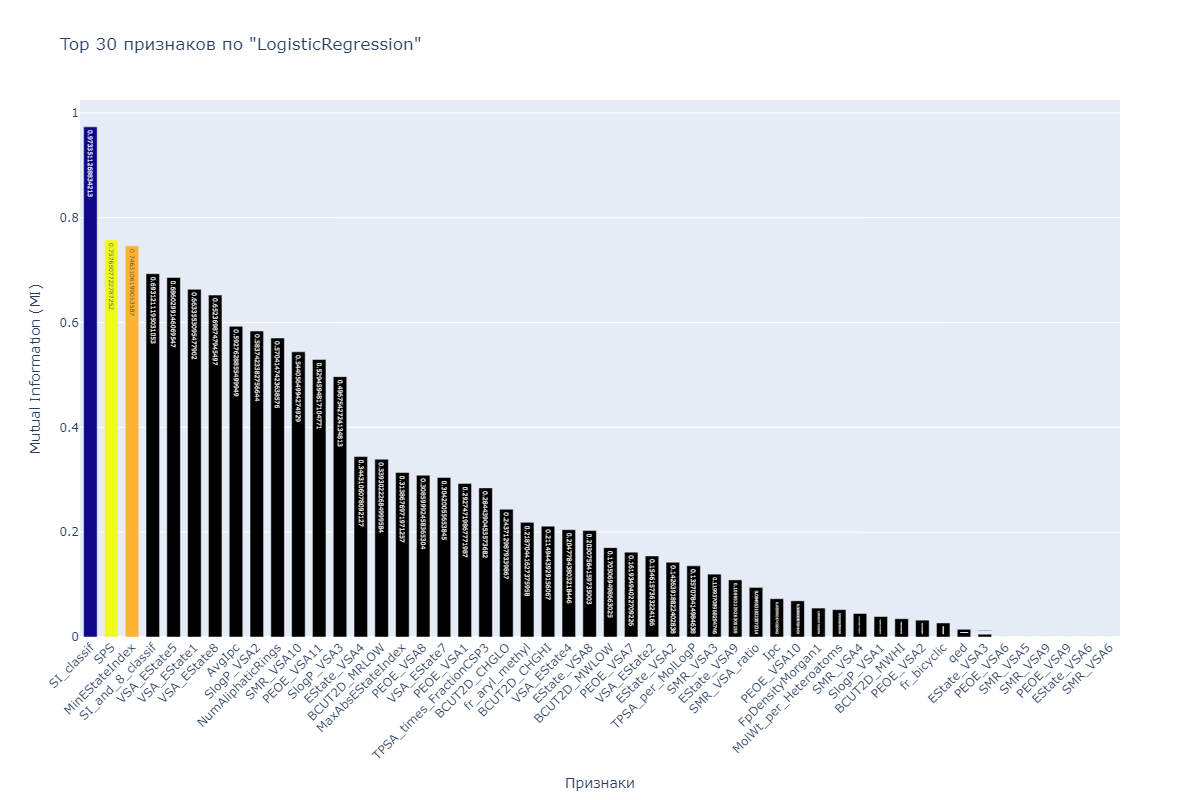

------------------------------------------------------------------------------------------------------------------------------------------------------


График кумулятивного вклада признаков (LogisticRegression):
------------------------------------------------------------------------------------------------------------------------------------------------------


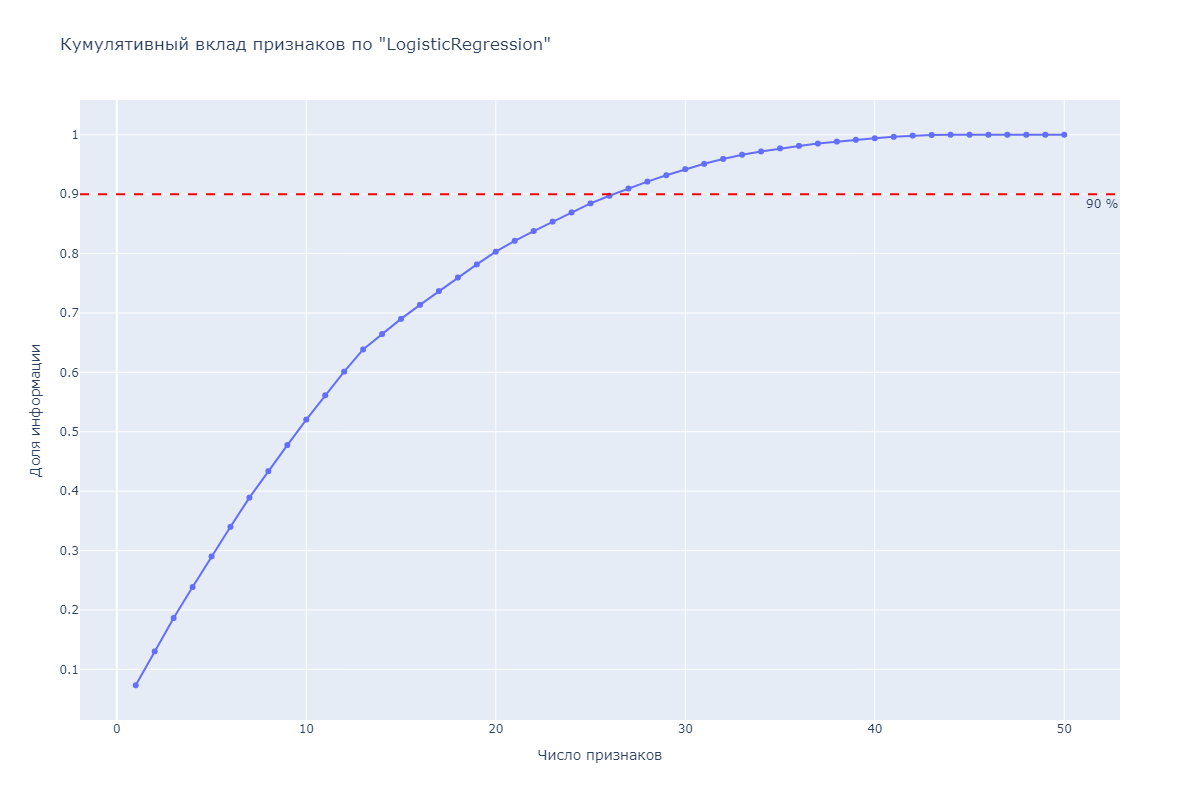

------------------------------------------------------------------------------------------------------------------------------------------------------


In [35]:
# Инициализируем класс 'LogisticRegression'
log_model = linear_model.LogisticRegression(
    penalty = 'l1',
    solver = 'liblinear',
    C = 1.0,
    random_state = 42
)

# Обучаем алгоритм
log_model.fit(X_train_filtered, y_train)



# Из полученных результатов создадим столбец 'Series'  
log_scores = pd.Series(
    log_model.coef_[0],
    index = X_train_filtered.columns
).abs().sort_values(ascending = False)



# Выделяем 30 наиболее важных признаков
log_selector = feature_selection.SelectFromModel(
    log_model,
    prefit = True,
    max_features = 30
)



# Из отобранных 30 признаков формируем итоговый 'DataFrame'
# после чего сохраним итоговые признаки в список
X_train_final = log_selector.transform(X_train_filtered)
final_features = X_train_filtered.columns[log_selector.get_support()].tolist()

# Преобразование 'X_train_final' в 'DataFrame'
X_train_final = pd.DataFrame(
    X_train_final, 
    columns = final_features,
    index = X_train.index
)

# Применение отобранных признаков к тестовой выборке
X_test_final = X_test_filtered[final_features]



# Выводим результат
print(f'\nТоп-30 финальных признаков после "LogisticRegression"\n\n{log_scores.head(50)}')
print('-' * 40)
print('\n\n')




# Посторим график оценки важности признаков при помощи функции 'bar_scores'
bar_scores(
    data = log_scores,
    main_title = 'График распределения 30 признаков по "LogisticRegression":',
    title = 'Top 30 признаков по "LogisticRegression"',
    color = 'Set3'
)
print()


# Построим кумулятивную линию при помощи функции 'cum_line'
cum_line(
    data = log_scores,
    main_title = 'График кумулятивного вклада признаков (LogisticRegression):',
    title = 'Кумулятивный вклад признаков по "LogisticRegression"'
)

**Вывод:**

Как видно из графика, по `LogisticRegression` количество признаков (до $30$) оптимальное количество признаков составляет $27$.

Выведем информацию итоговых выборок:

In [36]:
# Информация по тренеровочной выборке
check_data_inf(
    data = X_train_final,
    data_name = 'X_train_final',
    length1 = 40,
    length2 = 150
)
print('\n\n\n')


# Информация по тестовой выборке
check_data_inf(
    data = X_test_final,
    data_name = 'X_test_final',
    length1 = 40,
    length2 = 150
)


Данные таблицы "X_train_final" имеют следующую размерность:

Количество строк: 723;
Количество признаков (столбцов): 30.
----------------------------------------


MaxAbsEStateIndex  PEOE_VSA7  VSA_EState4  MinEStateIndex  BCUT2D_MWLOW  \
0            -1.496602   1.628333     2.503470        0.771519     -0.231601   
1             0.527403  -0.504015     0.014302       -0.394927      0.425592   
2             0.252959  -0.457205    -0.834664        0.392277     -0.313054   
3            -1.210453   1.143588     1.851472        0.750903     -0.967502   
4             0.694610   0.270976    -0.370231        0.472459     -0.403346   
..                 ...        ...          ...             ...           ...   
718           0.251380   0.004357     0.271046        0.428609     -0.231089   
719          -1.577604   1.008224     1.202870        0.843749     -0.749877   
720           0.439661   0.428075     0.280488        0.198692      0.434471   
721           0.980138  -0.786662    -1.533837       -0.499596      0.607120   
722          -1.635707  -0.225370     0.092775        0.857418     -0.231261   

     EState_VSA4  BCUT2D_MRLOW  VSA_EState8  SI_and_8_classif  \
0       1.012479      1.094114     0.340090         -0.685210   
1      -1.063253     -0.132690    -0.608620         -0.685210   
2       0.237265     -1.317070     0.101432         -0.685210   
3      -0.209812     -0.265867    -0.097231          1.459407   
4       1.428540      0.266289     0.375166         -0.685210   
..           ...           ...          ...               ...   
718    -0.199418     -0.295874     0.481124         -0.685210   
719     0.803055      0.140106     1.736961         -0.685210   
720     1.329183     -0.232253    -0.936206         -0.685210   
721    -0.954993      0.531099    -0.936206          1.459407   
722     1.261254      0.438134     1.464194          1.459407   

     TPSA_per_MolLogP  ...  PEOE_VSA8  SMR_VSA10  SlogP_VSA2  SlogP_VSA3  \
0           -0.017568  ...  -0.021284   0.106999   -1.133018   -1.068602   
1            0.133615  ...  -1.513317  -0.287725   -0.889025    0.254254   
2            0.146636  ...   1.658586   0.488749   -0.456006    0.129488   
3           -0.019390  ...  -1.021808  -1.157446   -1.139996   -1.068602   
4            0.009951  ...  -0.932554   0.817315   -0.445268   -1.068602   
..                ...  ...        ...        ...         ...         ...   
718         -0.010548  ...   0.013202   0.156622   -0.360715    0.129488   
719         -0.085575  ...   0.228973  -1.157446    0.160940    1.014571   
720          0.086950  ...  -0.943551   1.757702    0.023722   -0.465932   
721          0.134657  ...  -1.019632   0.096054   -0.261109   -0.473182   
722         -0.013565  ...   1.797087  -0.734765    0.655983   -0.473182   

     EState_VSA2  VSA_EState2  VSA_EState5  NumAliphaticRings  fr_aryl_methyl  \
0      -0.642902    -0.731273     0.875327          -0.123882       -0.400279   
1      -0.612792     0.683650    -0.723162          -0.123882        1.933607   
2       1.659867     0.581600     0.320846          -0.123882       -0.400279   
3      -0.632769    -1.092745     1.075515           1.344428       -0.400279   
4       0.774582    -0.768015    -0.077143          -0.858037       -0.400279   
..           ...          ...          ...                ...             ...   
718    -0.154825     0.099133     0.172446          -0.123882       -0.400279   
719    -1.085657    -0.899965     0.530838           0.610273        1.933607   
720     0.319731     0.650119     0.166710          -0.123882       -0.400279   
721    -0.160658     0.705109    -2.182500          -1.592192       -0.400279   
722    -1.085657    -0.549976     0.327517           0.610273       -0.400279   

     TPSA_times_FractionCSP3  
0                  -0.332149  
1                  -0.857136  
2                   1.215385  
3                  -0.065901  
4                  -0.043975  
..                       ...  
718                -0.300668  
719                -0.744117  
720                -0.622234  
721                -0.643005  
722                -0.173756  

[723

------------------------------------------------------------------------------------------------------------------------------------------------------





Данные таблицы "X_test_final" имеют следующую размерность:

Количество строк: 181;
Количество признаков (столбцов): 30.
----------------------------------------


MaxAbsEStateIndex  PEOE_VSA7  VSA_EState4  MinEStateIndex  BCUT2D_MWLOW  \
0             0.160756  -1.638111    -1.070186       -0.302029      2.296748   
1             0.552605   0.323003     0.072302       -2.184035      1.154219   
2            -0.045459  -0.457205    -1.001606        0.108325     -0.265352   
3             0.464136   0.666848     0.251347       -1.212053     -0.231089   
4            -1.720945   1.404096     0.932722        0.862116     -0.231368   
..                 ...        ...          ...             ...           ...   
176          -1.488398   0.079415     1.288017        0.899797      0.127272   
177           0.562094  -0.711178     1.781502        0.434776      0.884829   
178           0.417928  -0.252574    -0.127502        0.409685      1.260989   
179           0.044589   0.061704    -0.465348        0.028994     -0.226828   
180          -1.734335   0.101554     0.097061        0.859179     -0.231174   

     EState_VSA4  BCUT2D_MRLOW  VSA_EState8  SI_and_8_classif  \
0      -1.452750     -1.365982    -0.936206         -0.685210   
1      -1.028044     -0.312065    -0.673554         -0.685210   
2      -0.104185     -1.412236    -0.224349         -0.685210   
3       0.708760      0.805772     1.559249         -0.685210   
4       0.292272      1.093239     2.072285          1.459407   
..           ...           ...          ...               ...   
176    -0.209812      1.509991    -0.552634         -0.685210   
177    -0.275581      0.691163    -0.267836         -0.685210   
178    -0.277778      0.698000    -0.760104          1.459407   
179    -0.673080     -0.587122    -0.281073         -0.685210   
180    -0.266382     -3.522563     1.997948          1.459407   

     TPSA_per_MolLogP  ...  PEOE_VSA8  SMR_VSA10  SlogP_VSA2  SlogP_VSA3  \
0           -1.198955  ...  -0.958198   0.499853    0.259309    0.288896   
1            0.128426  ...  -1.008634   0.968608   -0.514649   -0.292246   
2            0.213022  ...  -0.418413  -0.722000   -0.485835   -0.473182   
3            0.094904  ...   0.054797  -0.172658    0.786383    2.891055   
4           -0.076881  ...   1.622910  -0.312085   -0.373630   -1.068602   
..                ...  ...        ...        ...         ...         ...   
176          0.065149  ...  -0.977181  -1.157446   -1.119683   -1.068602   
177          0.100585  ...  -0.481319   0.976483   -0.268689   -1.068602   
178          0.099420  ...  -1.513317   0.536398   -0.472495   -0.245931   
179          0.247098  ...  -0.418413  -1.157446    0.629610   -0.473182   
180         -0.074934  ...  -0.525967  -0.734765    0.390094   -1.068602   

     EState_VSA2  VSA_EState2  VSA_EState5  NumAliphaticRings  fr_aryl_methyl  \
0      -0.191636     0.680807    -0.355714          -1.592192       -0.400279   
1       0.740576    -1.092745    -0.134131          -1.592192       -0.400279   
2       0.378423    -0.360243     0.318123          -0.123882       -0.400279   
3      -0.642902    -0.738469     0.292743          -0.123882        1.933607   
4      -1.085657    -0.357125     0.653392           1.344428       -0.400279   
..           ...          ...          ...                ...             ...   
176    -1.085657    -1.092745     1.076714          -0.123882       -0.400279   
177    -0.135646     0.152801     0.085952          -0.858037        1.933607   
178    -0.131675     0.121094     0.432689          -1.592192       -0.400279   
179    -0.102694    -1.092745     0.531638          -0.123882       -0.400279   
180    -1.085657    -0.728190     0.328861          -0.123882       -0.400279   

     TPSA_times_FractionCSP3  
0                  -0.016665  
1                  -0.717143  
2                   1.433804  
3                   1.983047  
4                  -0.190647  
..                       ...  
176                -0.065901  
177                -0.833169  
178                -0.842731  
179                 0.764520  
180                -0.651323  

[181

------------------------------------------------------------------------------------------------------------------------------------------------------


**Корреляционный анализ.** 

Создаём функцию для построения тепловой карты корреляции признаков:

In [ ]:
# Создаём функцию 'heatmap_corr()' для построения тепловой карты корреляции
def heatmap_corr(data):
    
    # Вычисляем корреляционную матрицу
    correlation_matrix = data.corr()

    # Создаём заголовок для графика
    print('\nТепловая карта корреляции отобранных признаков:')
    print('-' * 150)



    # Создаём тепловую карту
    fig = go.Figure(data = go.Heatmap(
        z = correlation_matrix.values,
        x = correlation_matrix.columns,
        y = correlation_matrix.index,
        colorscale = 'RdBu',
        zmin = -1,
        zmax = 1,
        text = correlation_matrix.values.round(2),  
        texttemplate = "%{text}",  
        hoverinfo = 'z'
    ))



    # Настройка макета
    fig.update_layout(
        title = 'Значения корреляции отобранных признаков',
        width = 1200,
        height = 1200,
        title_x = 0.5,
        xaxis_tickangle = -45
    )



    # Отображение графика
    fig.show('png')
    print('-' * 150)

Проверим корреляцию отобранных признаков:


Тепловая карта корреляции отобранных признаков:
------------------------------------------------------------------------------------------------------------------------------------------------------


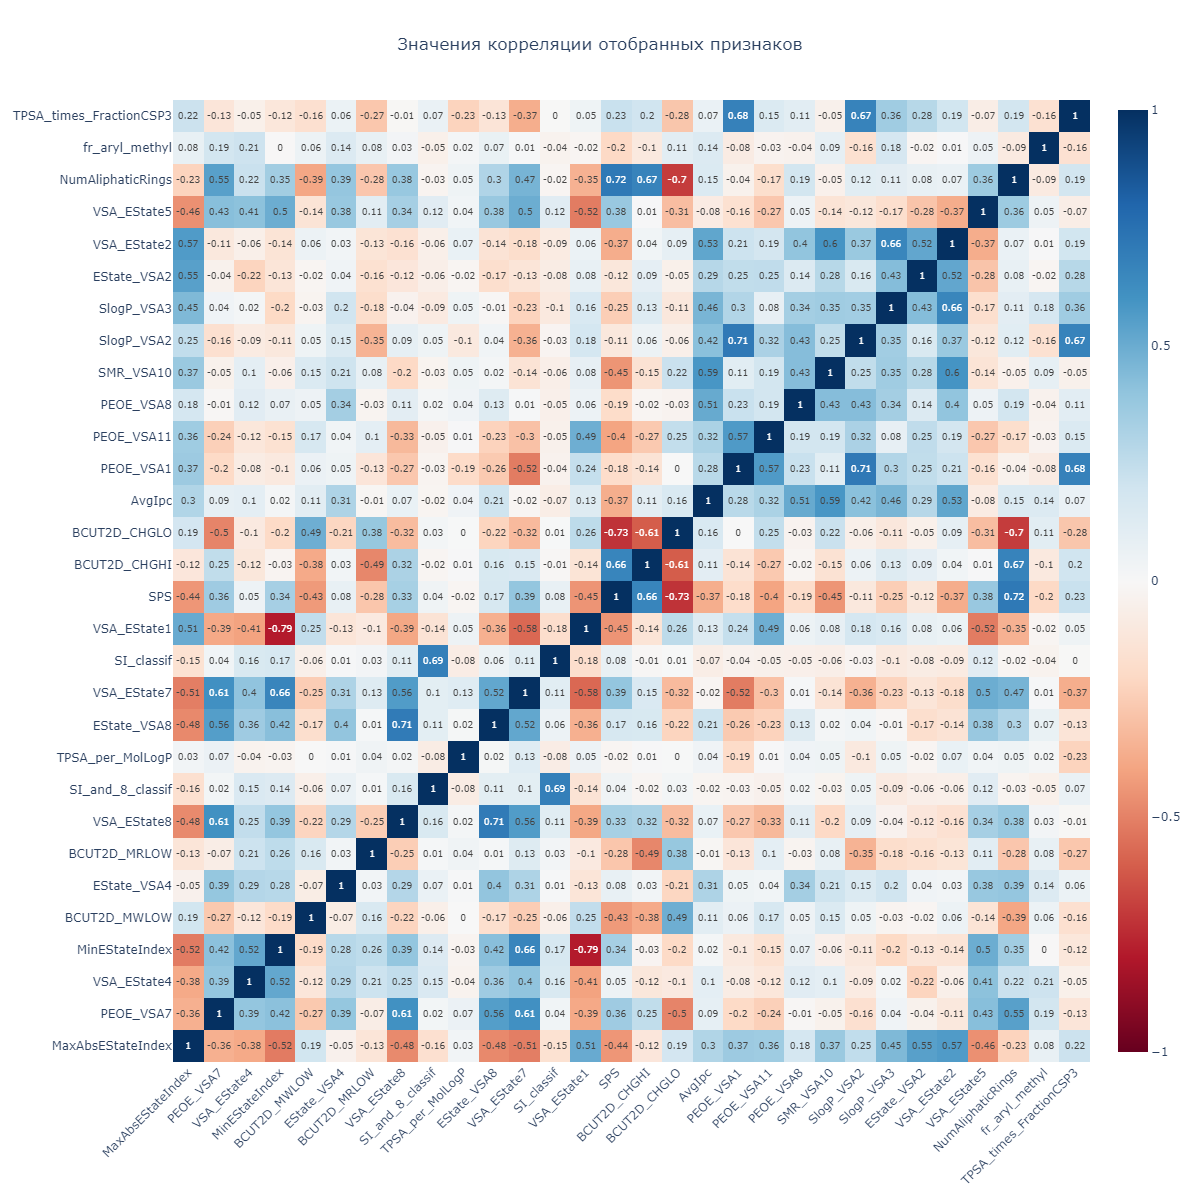

------------------------------------------------------------------------------------------------------------------------------------------------------


In [38]:
# Применяем функцию 'heatmap_corr()' для построения тепловой карты корреляции
heatmap_corr(data = X_train_final)

**Вывод:**

Из полученной тепловой карты видно, что значения корреляций находятся в пределах $+-0.79$, следовательно высококоррелированные связи отсутствуют. Данные полностью готовы к использованию для обучения модели.

#### $1.3$

#### **XGBoost (Extreme Gradient Boosting).**

Построим модель градиентного бустинга на обучающем наборе данных. Так же подберём наилучшие гиперпараметры при помощи `GridSearchCV`:

In [133]:
# Создаем объект класса XGBClassifier()
XGB_model = XGBClassifier(random_state = 42)


# Определение параметров для поиска
param_grid_xgb = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.3],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'scale_pos_weight': [1, sum(y_train == 0) / sum(y_train == 1)]
}


# Производим поиск
grid_search_xgb = model_selection.GridSearchCV(
    estimator = XGB_model,
    param_grid = param_grid_xgb,
    cv = 5,
    scoring = 'f1',
    n_jobs = -1
)


# Обучаем модель 
grid_search_xgb.fit(X_train_filtered, y_train)

# Сохраняем лучшую модель
best_model_xgb = grid_search_xgb.best_estimator_

# Делаем предсказание для тестовой выборки
y_predict_xgb = best_model_xgb.predict(X_test_filtered)



# Сохраним полученные гиперпараметры в переменной
best_parameters_xgb = grid_search_xgb.best_params_

# Выведем наилучшие значения гиперпараметров
print(f'Наилучшие значения гиперпараметров: {best_parameters_xgb}')

Наилучшие значения гиперпараметров: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50, 'scale_pos_weight': 1, 'subsample': 0.6}


c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning:

invalid value encountered in cast



Считаем метрики:

In [134]:
# Применяем функцию 'print_metrics' для рассчёта метрик
print_metrics(y_test, y_predict_xgb, 'XGBClassifier')


XGBClassifier (значения метрик):

Accuracy: 0.630
--------------------------------------------------------------------------------
Precision: 0.667
--------------------------------------------------------------------------------
Recall: 0.630
--------------------------------------------------------------------------------
F1-score: 0.629
--------------------------------------------------------------------------------

Classification report:

              precision    recall  f1-score   support

           0       0.76      0.53      0.63       105
           1       0.54      0.76      0.63        76

    accuracy                           0.63       181
   macro avg       0.65      0.65      0.63       181
weighted avg       0.67      0.63      0.63       181

--------------------------------------------------------------------------------


**Вывод:**

Модель `XGBClassifier` показывает среднее качество, так как она хорошо обнаруживает положительный класс $1$ (*Recall* = $0.76$), но часто ошибается в предсказаниях (*Precision* = $0.54$).

Модель хорошо находит вещества с высоким `IC50` (менее активные), но часто ошибочно относит активные соединения к неактивным.

Продолжим анализ с использованием других моделей.

#### $1.4$

#### **LightGBM (Light Gradient Boosting Machine).**

Построим модель градиентного бустинга на обучающем наборе данных. Так же подберём наилучшие гиперпараметры при помощи `GridSearchCV`:

In [48]:
# Создаем объект класса LGBMClassifier()
LGBMC_model = LGBMClassifier(random_state = 42)


# Определение параметров для поиска
param_grid_lgbmc = {
    'n_estimators': [50, 100, 200],
    'max_depth': [-1, 5, 10],
    'learning_rate': [0.01, 0.1, 0.3],
    'num_leaves': [31, 63, 127],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'class_weight': ['balanced', None]
}


# Производим поиск
grid_search_lgbmc = model_selection.GridSearchCV(
    estimator = LGBMC_model,
    param_grid = param_grid_lgbmc,
    cv = 5,
    scoring = 'f1',
    n_jobs = -1
)


# Обучаем модель 
grid_search_lgbmc.fit(X_train_final, y_train)

# Сохраняем лучшую модель
best_model_lgbmc = grid_search_lgbmc.best_estimator_

# Делаем предсказание для тестовой выборки
y_predict_lgbmc = best_model_lgbmc.predict(X_test_final)



# Сохраним полученные гиперпараметры в переменной
best_parameters_lgbmc = grid_search_lgbmc.best_params_

# Выведем наилучшие значения гиперпараметров
print(f'Наилучшие значения гиперпараметров: {best_parameters_lgbmc}')

Наилучшие значения гиперпараметров: {'class_weight': None, 'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 50, 'num_leaves': 31, 'subsample': 0.6}


Считаем метрики:

In [ ]:
# Применяем функцию 'print_metrics' для рассчёта метрик
print_metrics(y_test, y_predict_lgbmc, 'LGBMClassifier')

LGBMClassifier (значения метрик):

Accuracy: 0.680
--------------------------------------------------------------------------------
Precision: 0.697
--------------------------------------------------------------------------------
Recall: 0.680
--------------------------------------------------------------------------------
F1-score: 0.682
--------------------------------------------------------------------------------

Classification report:

              precision    recall  f1-score   support

           0       0.77      0.64      0.70       105
           1       0.60      0.74      0.66        76

    accuracy                           0.68       181
   macro avg       0.68      0.69      0.68       181
weighted avg       0.70      0.68      0.68       181

--------------------------------------------------------------------------------


**Вывод:**

Модель `LGBMClassifier` сбалансированнее, чем `XGBoost`, так как она лучше распознаёт оба класса, сохраняя высокую полноту для менее активных соединений, и улучшает точность (меньше ложных положительных).

#### $1.5$

#### **RFC (Random Forest Classifier).**

Построим модель случайного леса на тренировочной выборке. Так же подберём наилучшие гиперпараметры при помощи `GridSearchCV`:

In [ ]:
# Создаем объект класса RandomForestClassifier()
RFC_model = ensemble.RandomForestClassifier(random_state = 42)


# Определение параметров для поиска
param_grid_rfc = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'class_weight': ['balanced', 'balanced_subsample', None]
}


# Производим поиск
grid_search_rfc = model_selection.GridSearchCV(
    estimator = RFC_model,
    param_grid = param_grid_rfc,
    cv = 5,
    scoring = 'f1',
    n_jobs = -1
)


# Обучаем модель 
grid_search_rfc.fit(X_train_final, y_train)

# Сохраняем лучшую модель
best_model_rfc = grid_search_rfc.best_estimator_

# Делаем предсказание для тестовой выборки
y_predict_rfc = best_model_rfc.predict(X_test_final)



# Сохраним полученные гиперпараметры в переменной
best_parameters_rfc = grid_search_rfc.best_params_

# Выведем наилучшие значения гиперпараметров
print(f'Наилучшие значения гиперпараметров: {best_parameters_rfc}')

Наилучшие значения гиперпараметров: {'class_weight': 'balanced_subsample', 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


Считаем метрики:

In [ ]:
# Применяем функцию 'print_metrics' для рассчёта метрик
print_metrics(y_test, y_predict_rfc, 'RandomForestClassifier')

RandomForestClassifier (значения метрик):

Accuracy: 0.680
--------------------------------------------------------------------------------
Precision: 0.686
--------------------------------------------------------------------------------
Recall: 0.680
--------------------------------------------------------------------------------
F1-score: 0.681
--------------------------------------------------------------------------------

Classification report:

              precision    recall  f1-score   support

           0       0.74      0.69      0.71       105
           1       0.61      0.67      0.64        76

    accuracy                           0.68       181
   macro avg       0.67      0.68      0.68       181
weighted avg       0.69      0.68      0.68       181

--------------------------------------------------------------------------------


**Вывод:**

`RandomForest` работает примерно на уровне `LGBM`, но слегка проигрывает в умении находить малоактивные соединения (ниже **Recall** и **F1-score** для класса $1$).

#### $1.6$

#### **Support Vector Machine (SVM) с ядром RBF.**

Построим модель опорных векторов на тренировочной выборке. Так же подберём наилучшие гиперпараметры при помощи `GridSearchCV`:

In [ ]:
# Создаем объект класса SVC()
SVC_model = svm.SVC(random_state = 42, probability = True)


# Определение параметров для поиска
param_grid_svc = {
    'C': [0.1, 1, 10],
    'gamma': ['scale', 'auto', 0.1, 1],
    'class_weight': ['balanced', None]
}


# Производим поиск
grid_search_svc = model_selection.GridSearchCV(
    estimator = SVC_model,
    param_grid = param_grid_svc,
    cv = 5,
    scoring = 'f1',
    n_jobs = -1
)


# Обучаем модель 
grid_search_svc.fit(X_train_final, y_train)

# Сохраняем лучшую модель
best_model_svc = grid_search_svc.best_estimator_

# Делаем предсказание для тестовой выборки
y_predict_svc = best_model_svc.predict(X_test_final)



# Сохраним полученные гиперпараметры в переменной
best_parameters_svc = grid_search_svc.best_params_

# Выведем наилучшие значения гиперпараметров
print(f'Наилучшие значения гиперпараметров: {best_parameters_svc}')

Наилучшие значения гиперпараметров: {'C': 10, 'class_weight': None, 'gamma': 'scale'}


Считаем метрики:

In [54]:
# Применяем функцию 'print_metrics' для рассчёта метрик
print_metrics(y_test, y_predict_svc, 'SVC')

SVC (значения метрик):

Accuracy: 0.685
--------------------------------------------------------------------------------
Precision: 0.686
--------------------------------------------------------------------------------
Recall: 0.685
--------------------------------------------------------------------------------
F1-score: 0.685
--------------------------------------------------------------------------------

Classification report:

              precision    recall  f1-score   support

           0       0.73      0.72      0.73       105
           1       0.62      0.63      0.63        76

    accuracy                           0.69       181
   macro avg       0.68      0.68      0.68       181
weighted avg       0.69      0.69      0.69       181

--------------------------------------------------------------------------------


**Вывод:**

`SVC` показывает сбалансированную работу на обоих классах, чуть лучше, чем `XGBoost`, но уступает `LGBM` и `RandomForest` по качеству обнаружения малоактивных соединений (класс $1$).

В отличие от `XGBoost`, лучше сохраняет баланс между **precision** и **recall**, но не выдаёт лучшего результата по отдельным метрикам.

#### $1.7$

#### **MLPClassifier (Многослойный перцептрон).**

Построим модель нейронной сети на тренировочной выборке. Так же подберём наилучшие гиперпараметры при помощи `GridSearchCV`:

In [57]:
# Создаем объект класса MLPClassifier()
MLP_model = neural_network.MLPClassifier(random_state = 42)


# Определение параметров для поиска
param_grid_mlp = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50)],
    'activation': ['relu', 'tanh'],
    'learning_rate_init': [0.001, 0.01],
    'alpha': [0.0001, 0.001, 0.01],  # L2-регуляризация для предотвращения переобучения
    'max_iter': [200, 500]
}


# Производим поиск
grid_search_mlp = model_selection.GridSearchCV(
    estimator = MLP_model,
    param_grid = param_grid_mlp,
    cv = 5,
    scoring = 'f1',
    n_jobs = -1
)


# Обучаем модель 
grid_search_mlp.fit(X_train_final, y_train)

# Сохраняем лучшую модель
best_model_mlp = grid_search_mlp.best_estimator_

# Делаем предсказание для тестовой выборки
y_predict_mlp = best_model_mlp.predict(X_test_final)



# Сохраним полученные гиперпараметры в переменной
best_parameters_mlp = grid_search_mlp.best_params_

# Выведем наилучшие значения гиперпараметров
print(f'Наилучшие значения гиперпараметров: {best_parameters_mlp}')

Наилучшие значения гиперпараметров: {'activation': 'tanh', 'alpha': 0.01, 'hidden_layer_sizes': (100,), 'learning_rate_init': 0.001, 'max_iter': 200}


c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



Считаем метрики:

In [58]:
# Применяем функцию 'print_metrics' для рассчёта метрик
print_metrics(y_test, y_predict_mlp, 'MLPClassifier')

MLPClassifier (значения метрик):

Accuracy: 0.691
--------------------------------------------------------------------------------
Precision: 0.695
--------------------------------------------------------------------------------
Recall: 0.691
--------------------------------------------------------------------------------
F1-score: 0.692
--------------------------------------------------------------------------------

Classification report:

              precision    recall  f1-score   support

           0       0.75      0.70      0.73       105
           1       0.62      0.67      0.65        76

    accuracy                           0.69       181
   macro avg       0.68      0.69      0.69       181
weighted avg       0.69      0.69      0.69       181

--------------------------------------------------------------------------------


**Вывод:**

`MLPClassifier` показывает наивысшую общую точность (**accuracy**) среди всех моделей на выборке.

Модель достаточно хорошо сбалансирована, с уверенными метриками по обоим классам. 

По **F1-score** для класса $1$ (малоактивные) чуть уступает `LGBM`, но опережает `XGBoost` и `SVC`.

#### $1.8$

#### **Определяем лучшую модель.**

Составим таблицу (**DataFrame**) со следующими столбцами:

Наименование модели:

* `model_name`,

Метрики и их значения:

* `Accuracy`,

* `Precision`,

* `Recall`,

* `F1-score`.

In [38]:
# Создаём DataFrame
model_metrics = {
    'XGBClassifier'             : {'Accuracy': 0.630, 'Precision': 0.667, 'Recall': 0.630, 'F1-score': 0.629},
    'LGBMClassifier'            : {'Accuracy': 0.680, 'Precision': 0.697, 'Recall': 0.680, 'F1-score': 0.682},
    'RandomForestClassifier'    : {'Accuracy': 0.680, 'Precision': 0.686, 'Recall': 0.680, 'F1-score': 0.681},
    'SupportVectorClassifier'   : {'Accuracy': 0.685, 'Precision': 0.686, 'Recall': 0.685, 'F1-score': 0.685},
    'MLPClassifier'             : {'Accuracy': 0.691, 'Precision': 0.695, 'Recall': 0.691, 'F1-score': 0.692}
}

metrics_df = pd.DataFrame(model_metrics).T
metrics_df = metrics_df.reset_index().rename(columns = {'index': 'model_name'})



# Выводим результат
check_data_inf(
    data = metrics_df,
    data_name = 'metrics_df',
    length1 = 35,
    length2 = 60
)


Данные таблицы "metrics_df" имеют следующую размерность:

Количество строк: 5;
Количество признаков (столбцов): 5.
-----------------------------------


model_name  Accuracy  Precision  Recall  F1-score
0            XGBClassifier     0.630      0.667   0.630     0.629
1           LGBMClassifier     0.680      0.697   0.680     0.682
2   RandomForestClassifier     0.680      0.686   0.680     0.681
3  SupportVectorClassifier     0.685      0.686   0.685     0.685
4            MLPClassifier     0.691      0.695   0.691     0.692

------------------------------------------------------------


**Визуализация метрик.**

Теперь построим графики по каждой метрике, чтобы сравнить их друг с другом визуально.

Создадим функцию для построения визуализаций метрик:

In [67]:
# Создаём функцию 'metrics_bar_plot()' для построения столбчатого графика метрик
def metrics_bar_plot(data, main_title = None, title = None, colors = None):
    
    
    """
    Функция для построения столбчатого графика метрик.
    
    Параметры:
    - data: pandas DataFrame с метриками.
    - main_title: название графика.
    - title: заголовок графика.
    - colors: цвет столбцов графика.
    
    """
    
    
    # Задаём заголовок для графика
    print(f'\n{main_title}')
    print('-' * 150)


    # Создаем barplot с помощью Plotly Express
    metrics_melted = data.melt(
        id_vars = 'model_name',
        var_name = 'Metric', 
        value_name = 'Value',
        value_vars = ['Accuracy', 'Precision', 'Recall', 'F1-score']
    )

    # Создаем столбчатый график с помощью Plotly Express
    fig = px.bar(
        metrics_melted, 
        x = 'model_name', 
        y = 'Value', 
        color = 'Metric', 
        barmode = 'group',
        title = title,
    
        labels = {
            'model_name': 'Модель', 
            'Value': 'Значение метрики', 
            'Metric': 'Метрика'
        },
    
        text = 'Value',
        text_auto = True,
        color_discrete_sequence = colors
    )

    # Настройка осей и легенды
    fig.update_layout(
        title_x = 0.5,
        height = 700,
        width = 1200,
        xaxis_title = 'Модель',
        yaxis_title = 'Значение метрики',
        legend_title = 'Метрика',
        yaxis = dict(tickformat = '.2f') 
    )


    # Отображение графика
    fig.show('png')
    print('-' * 150)

Строим графики:


Столбчатая диаграмма сравнения метрик моделей классификации:
------------------------------------------------------------------------------------------------------------------------------------------------------


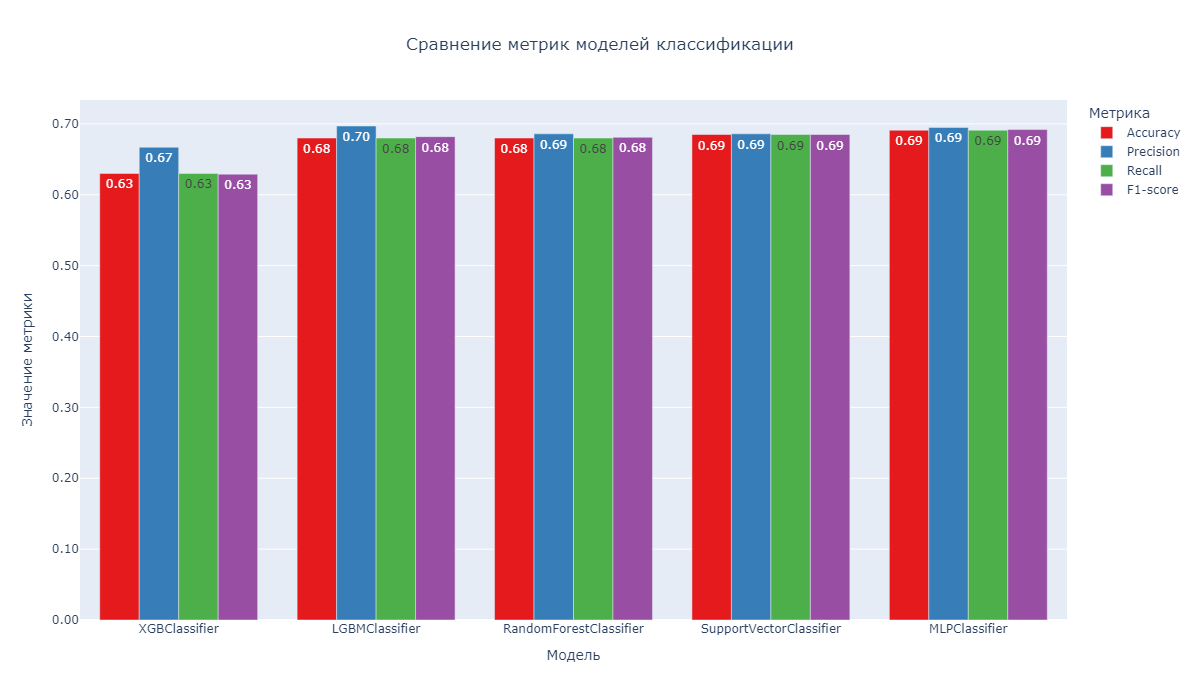

------------------------------------------------------------------------------------------------------------------------------------------------------


In [41]:
# Применяем функцию 'metrics_bar_plot()' для построения столбчатого графика метрик
metrics_bar_plot(
    data = metrics_df,
    main_title = 'Столбчатая диаграмма сравнения метрик моделей классификации:',
    title = 'Сравнение метрик моделей классификации',
    colors = px.colors.qualitative.Set1
)

#### $1.9$

#### **Вывод.**

На данном этапе сделаем вывод итоговым метрикам и моделям, обученным для предсказания целевой переменной `IC50_classif`.

Среди всех моделей `MLPClassifier` показывает наилучшее качество классификации соединений по `IC50` относительно медианного значения, так как модель хорошо сбалансирована, не жертвуя ни точностью, ни полнотой.

Так же данная модель подходит как для задач, где важны и точные предсказания, и минимизация ошибок по обоим классам.

Тем не менее, результаты несовсем удовлетворительны, необходима дополнительная обработка данных или добавить дополнительные гиперпараметры. 

=============================================================================================================================================

## <CENTER> **`2.` Machine Learning (превышает ли значение CC50 медианное значение выборки)**

На данном этапе мы построим несколько подходящих моделей регрессии для **CC50** и выберем наилучшую.

#### $2.1$

#### **Предобработка данных.**

Как и раньше, предобработаем данные при помощи созданного ранее пайплайна, только все этапы по предобработке, созданию и удалению признаков включим в отдельный класс.

Повторно загружаем пайплайн:

In [42]:
# Загружаем пайплайн при помощи joblib
preprocessing_pipeline = joblib.load('data/preprocessing_pipeline.joblib')
print("Пайплайн загружен из 'preprocessing_pipeline.joblib'")

Пайплайн загружен из 'preprocessing_pipeline.joblib'


Создаём целевую переменную:


Медианное значение CC50: 6.015652680235684
---------------------------------------------



Уникальные значения признака "CC50_classif":



CC50_classif
0    452
1    452
Name: count, dtype: int64

---------------------------------------------


Стобчатая и круговая диаграммы распределения целевой переменной:
------------------------------------------------------------------------------------------------------------------------------------------------------


C:\Users\User\AppData\Local\Temp\ipykernel_2088\4276034505.py:25: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


C:\Users\User\AppData\Local\Temp\ipykernel_2088\4276034505.py:35: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



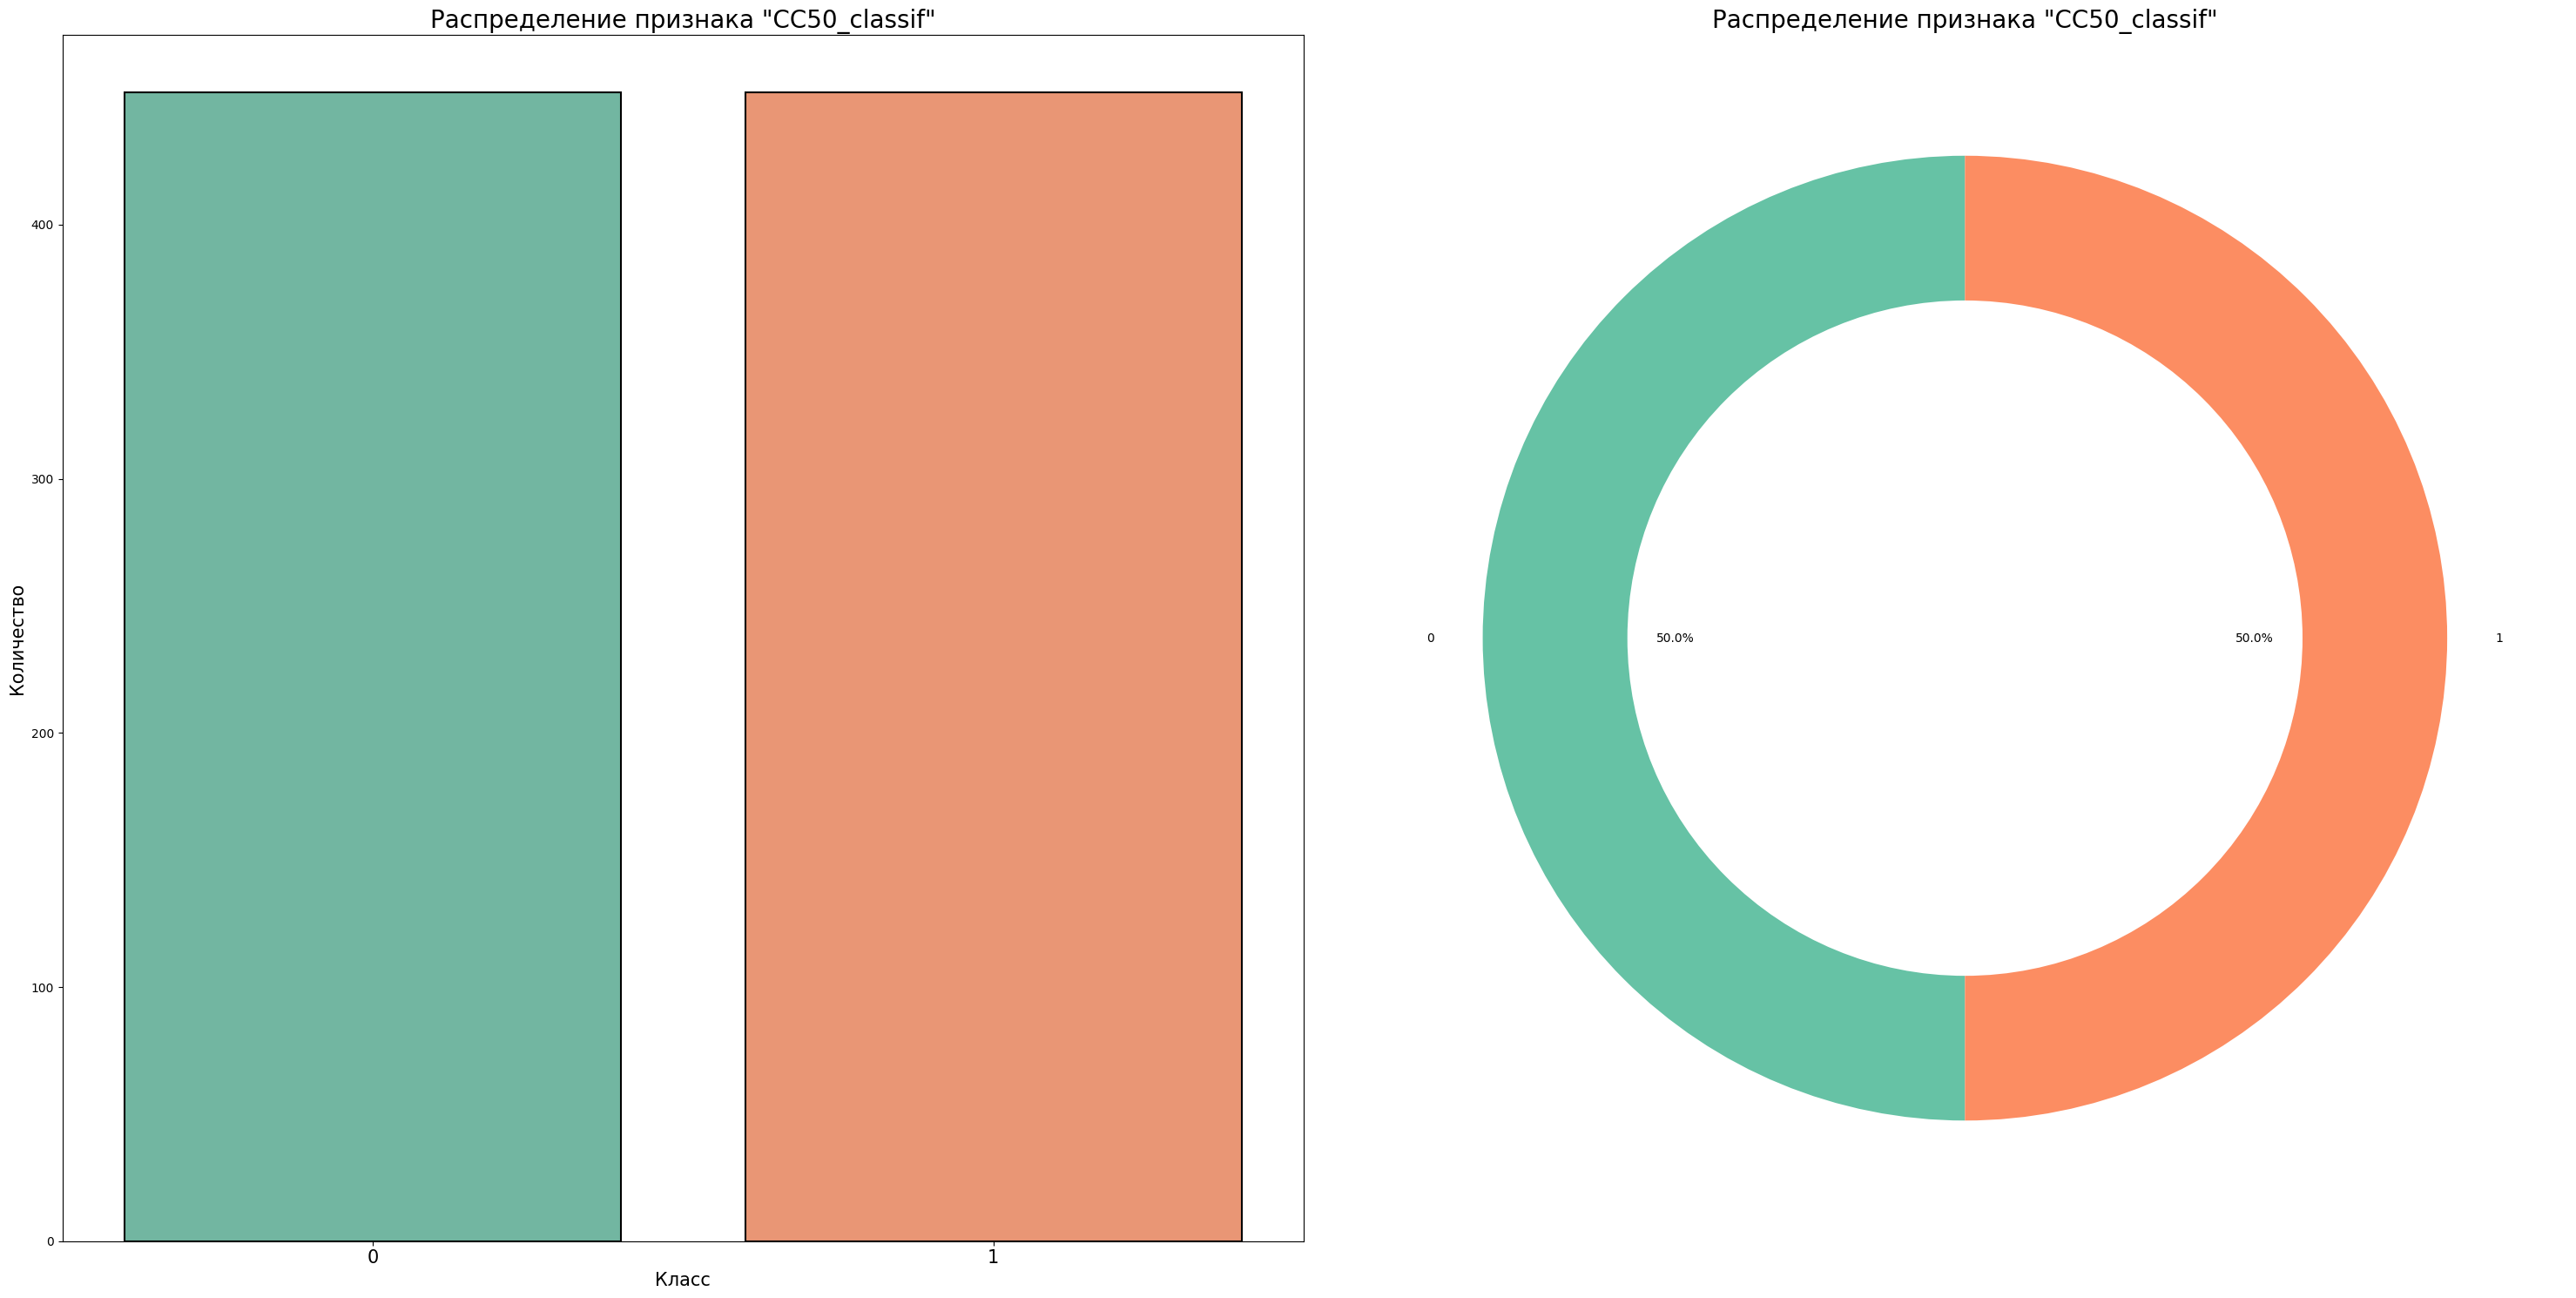

------------------------------------------------------------------------------------------------------------------------------------------------------


Распределение целевой переменной
------------------------------------------------------------------------------------------------------------------------------------------------------


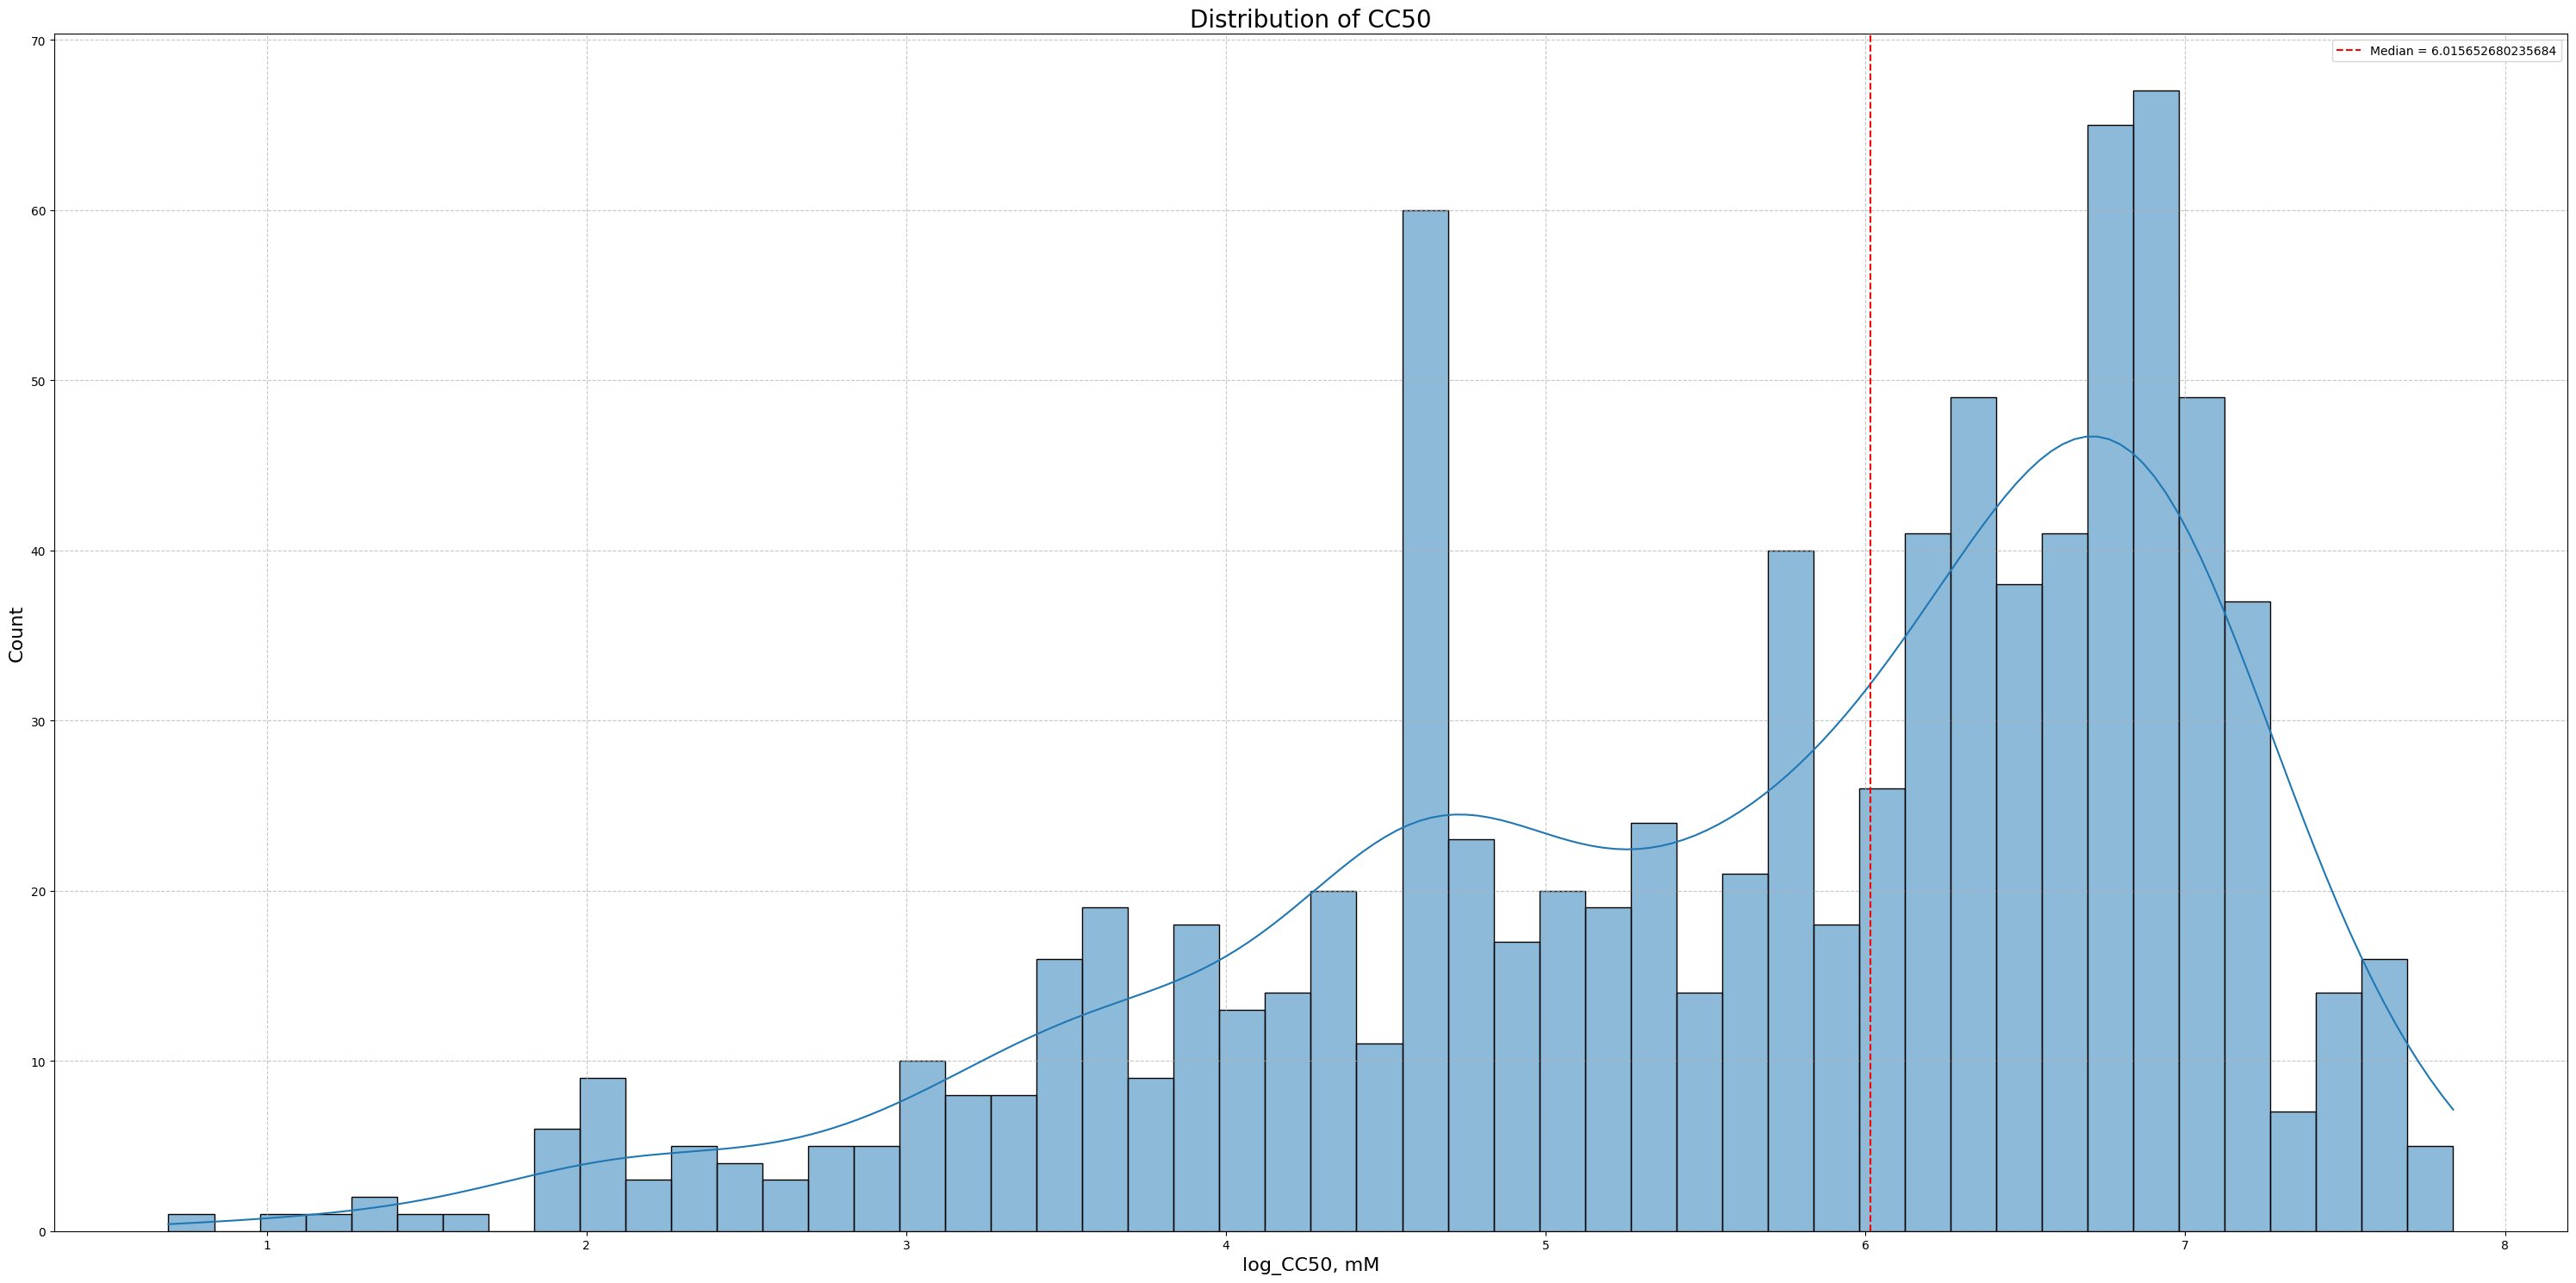

------------------------------------------------------------------------------------------------------------------------------------------------------


In [41]:
# Вычисляем медиану CC50
median_cc50 = molecule_df['log_CC50, mM'].median()
print(f'\nМедианное значение CC50: {median_cc50}')
print('-' * 45)
print('\n\n')


# Создаем целевую переменную (1 - превышает, 0 - не превышает)
molecule_df['CC50_classif'] = (molecule_df['log_CC50, mM'] > median_cc50).astype(int)
print('Уникальные значения признака "CC50_classif":\n')
display(molecule_df['CC50_classif'].value_counts())
print('-' * 45)




# Применяем функцию 'median_target_distribution_plot()' для построения графика распределения целевой переменной
median_target_distribution_plot(
    target = molecule_df['CC50_classif'],
    title1 = 'Распределение признака "CC50_classif"',
    main_title = 'Стобчатая и круговая диаграммы распределения целевой переменной:',
    color_palette = 'Set2',
    figsize = (30, 15)
)

# Применяем функцию 'target_distribution_plot()' для построения графика распределения целевой переменной
target_distribution_plot(
    data = molecule_df,
    target = 'log_CC50, mM',
    median_target = median_cc50,
    title = 'Distribution of CC50',
    main_title = 'Распределение целевой переменной',
    figsize = (30, 15)
)

**Вывод:**

Как видно по графику, распределение целевой переменной - равномерное, следовательно балансировка не требуется.

**Разделение данных.**

Разделим данные на тматрицу наблюдений и вектор правильных ответов:

In [44]:
# Разделяем данные на матрицу наблюдений и вектор правильных ответов
X = molecule_df.drop(columns = ['IC50, mM', 'CC50, mM', 'SI', 'log_IC50, mM', 'log_CC50, mM', 'log_SI', 'IC50_classif', 'CC50_classif'])
y = molecule_df['CC50_classif']

**Создание класса.**

Создадим класс, в котором реализуем все этапы по созданию новых признаков, удалению нерелевантных признаков и предобработки данных:

In [39]:
# Создаём класс 'DataPreprocessor'       
class DataPreprocessor:
    
    
    
    # Задаём необходимые параметры
    def __init__(self, preprocessing_pipeline, random_state = 42):
        
        """
        Инициализация класса.
        preprocessing_pipeline: пайплайн с шагами feature_union, feature_selector, S_scaler.
        random_state: для воспроизводимости разбиения.
        
        """
        
        self.preprocessing_pipeline = preprocessing_pipeline
        self.random_state = random_state
        
        self.feature_names = (
            ['MolWt_TPSA', 'MolWt_per_Heteroatoms', 'TPSA_per_MolLogP'] +
    
            ['total_functional_groups', 'fr_amide_plus_ester', 'fr_benzene_times_nitro', 
             'fr_Al_OH_per_benzene', 'fr_amide_presence', 'fr_aldehyde_presence', 
             'fr_aniline_presence', 'fr_amidine_presence'] +
    
            ['PEOE_VSA_total', 'SMR_VSA_ratio', 'Chi0_times_Kappa1', 'TPSA_times_FractionCSP3'] +
            ['log_MolWt', 'MolLogP_squared', 'NumRotatableBonds_squared']
        )
        
        self.duplicated_features = ['Unnamed: 0', 'Unnamed: 0.1']
        self.X_train_full = None
        self.X_test_full = None
        self.X_train_processed_df = None
        self.X_test_processed_df = None
        self.y_train = None
        self.y_test = None
        self.partial_pipeline = None
        self.remaining_features = None
        
        
        
    # Удаляем признаки типов 'object' и 'category'          
    def remove_non_numeric_columns(self, data):
        
         """
         Удаление нечисловых столбцов.
         
         """
         
         return data.select_dtypes(include = [np.number])
     
     
     
    # Создаём новые признаки, удаляем нерелевантные и преобразовываем данные
    def fit_transform(self, X, y):
        
        """
        Разбиение данных, обучение пайплайнов и трансформация.
        X: исходные данные (без целевой переменной).
        y: целевая переменная 'CC50'.
        
        """
        
        # Разбиение на тренировочную и тестовую выборки
        X_train, X_test, self.y_train, self.y_test = model_selection.train_test_split(
            X, y,
            test_size = 0.2,
            random_state = self.random_state
        )
        
        # Удаляем дублирующиеся столбцы
        X_train = X_train.drop(columns=self.duplicated_features, axis=1, errors='ignore')
        X_test = X_test.drop(columns=self.duplicated_features, axis=1, errors='ignore')
        
        # Восстанавливаем индексы
        X_train = X_train.reset_index(drop = True)
        X_test = X_test.reset_index(drop = True)
        
        # Создаём новые признаки
        # для этого извлекаем 'FeatureUnion' из пайплайна и обучаем его
        feature_union_step = self.preprocessing_pipeline.named_steps['feature_union']
        feature_union_step.fit(X_train, self.y_train)
        
        # Применяем пайплайн к тренировочным и тестовым данным
        X_train_transformed = feature_union_step.transform(X_train)
        X_test_transformed = feature_union_step.transform(X_test)
        
        # Преобразуем результат обратно в DataFrame
        X_train_transformed_df = pd.DataFrame(
            X_train_transformed,
            columns = self.feature_names,
            index = X_train.index
        )
        X_test_transformed_df = pd.DataFrame(
            X_test_transformed,
            columns = self.feature_names,
            index = X_test.index
        )
        
        # Объединяем признаки
        self.X_train_full = pd.concat([X_train, X_train_transformed_df], axis=1)
        self.X_test_full = pd.concat([X_test, X_test_transformed_df], axis=1)

        # Удаляем нечисловые столбцы
        self.X_train_full = self.remove_non_numeric_columns(self.X_train_full)
        self.X_test_full = self.remove_non_numeric_columns(self.X_test_full)
        
        # Удалим нерелевантные признаки и стандартизируем данные
        # для начала извлечём шаги из пайплайна
        feature_selector = self.preprocessing_pipeline.named_steps['feature_selector']
        S_scaler = self.preprocessing_pipeline.named_steps['S_scaler']
        
        # Создание нового пайплайна с 'feature_selector' и 'S_scaler'
        self.partial_pipeline = pipeline.Pipeline([
            ('feature_selector', feature_selector),
            ('S_scaler', S_scaler)
        ])  
        
        # Обучаем созданный пайплайн на тренировочной выборке
        self.partial_pipeline.fit(self.X_train_full, self.y_train)

        # Применяем пайплайн к тренировочным и тестовым данным
        X_train_processed_full = self.partial_pipeline.transform(self.X_train_full)
        X_test_processed_full = self.partial_pipeline.transform(self.X_test_full)

        # Получаем список оставшихся признаков
        fs_step = self.partial_pipeline.named_steps['feature_selector']
        self.remaining_features = self.X_train_full.columns.difference(
            fs_step.to_drop_corr + fs_step.to_drop_var, sort=False
        )
        
        # Преобразуем результат обратно в DataFrame
        self.X_train_processed_df = pd.DataFrame(
            X_train_processed_full,
            columns = self.remaining_features,
            index = self.X_train_full.index
        )
        self.X_test_processed_df = pd.DataFrame(
            X_test_processed_full,
            columns = self.remaining_features,
            index = self.X_test_full.index
        )
        
        
        
    # Выводим результат
    def get_processed_data(self):
        
        """
        Возвращает обработанные данные.
        
        """
        
        processed_data = (
            self.X_train_processed_df,
            self.X_test_processed_df,
            self.y_train,
            self.y_test,
            self.remaining_features
        )
        
        return processed_data

Применим созданный класс к данным:

In [46]:
# Создаём экземпляра класса 'DataPreprocessor'
DP_processor = DataPreprocessor(preprocessing_pipeline)

# Обработка данных
DP_processor.fit_transform(X, y)

# Получение обработанных данных
X_train_processed_df, X_test_processed_df, y_train, y_test, remaining_features = DP_processor.get_processed_data()


Данные таблицы "Molecular properties features" имеют следующую размерность:

Количество строк: 723;
Количество признаков (столбцов): 3.
----------------------------------------
------------------------------------------------------------




Данные таблицы "Functional groups features" имеют следующую размерность:

Количество строк: 723;
Количество признаков (столбцов): 8.
----------------------------------------
------------------------------------------------------------------------------------------




Данные таблицы "Topological descriptors features" имеют следующую размерность:

Количество строк: 723;
Количество признаков (столбцов): 4.
----------------------------------------
--------------------------------------------------------------------------------




Данные таблицы "Transformations features" имеют следующую размерность:

Количество строк: 723;
Количество признаков (столбцов): 3.
----------------------------------------
---------------------------------------------------

Выводим результат:

In [47]:
# Информация по тренеровочной выборке
check_data_inf(
    data = X_train_processed_df,
    data_name = 'X_train_processed_df',
    length1 = 40,
    length2 = 150
)
print('\n\n\n')


# Информация по тестовой выборке
check_data_inf(
    data = X_test_processed_df,
    data_name = 'X_test_processed_df',
    length1 = 40,
    length2 = 150
)
print('\n\n\n')


# Информация по оставшимся признакам
print(f'Оставшиеся признаки:\n\n{remaining_features.tolist()}')
print('-' * 150)


Данные таблицы "X_train_processed_df" имеют следующую размерность:

Количество строк: 723;
Количество признаков (столбцов): 103.
----------------------------------------


MaxAbsEStateIndex  MinAbsEStateIndex  MinEStateIndex       qed       SPS  \
0            -1.496602           0.422613        0.771519  0.579771 -0.081941   
1             0.527403           0.904784       -0.394927  0.514586 -0.554818   
2             0.252959          -0.894628        0.392277  0.397569  0.511590   
3            -1.210453           0.216033        0.750903  0.746949  1.699045   
4             0.694610          -0.824197        0.472459  1.392750 -0.120265   
..                 ...                ...             ...       ...       ...   
718           0.251380           0.324610        0.428609 -0.563375 -0.001549   
719          -1.577604           1.146384        0.843749  0.769183  0.451116   
720           0.439661          -0.198519        0.198692  0.502574 -0.661393   
721           0.980138          -0.326590       -0.499596 -0.363831 -1.475648   
722          -1.635707           1.283362        0.857418  0.748480  0.731976   

        MolWt  FpDensityMorgan1  BCUT2D_MWHI  BCUT2D_MWLOW  BCUT2D_CHGHI  ...  \
0   -0.172284         -0.720975    -0.482466     -0.231601      0.709602  ...   
1   -0.694608         -0.970049    -0.465835      0.425592      0.670103  ...   
2   -0.034503          1.347721     0.555049     -0.313054      0.077316  ...   
3   -1.145565         -0.554926    -0.589790     -0.967502      0.838770  ...   
4   -0.264281          0.954612     0.555048     -0.403346     -0.483621  ...   
..        ...               ...          ...           ...           ...  ...   
718 -0.241286          0.655849    -0.479027     -0.231089      0.700544  ...   
719 -0.010688          0.083725    -0.482669     -0.749877      0.230117  ...   
720  0.463493         -0.416552     0.557248      0.434471     -0.335264  ...   
721  0.285924         -0.703184    -0.304289      0.607120     -1.303146  ...   
722 -0.601279          0.482881    -0.482670     -0.231261      0.699655  ...   

     fr_quatN  fr_sulfide  fr_thiazole  fr_thiophene  fr_unbrch_alkane  \
0   -0.174679   -0.210093    -0.266667     -0.303554         -0.177731   
1   -0.174679   -0.210093    -0.266667     -0.303554         -0.177731   
2   -0.174679   -0.210093    -0.266667      3.294307         -0.177731   
3   -0.174679   -0.210093    -0.266667     -0.303554         -0.177731   
4   -0.174679   -0.210093     3.750000     -0.303554         -0.177731   
..        ...         ...          ...           ...               ...   
718 -0.174679   -0.210093    -0.266667     -0.303554         -0.177731   
719 -0.174679   -0.210093    -0.266667     -0.303554         -0.177731   
720 -0.174679    3.494726    -0.266667     -0.303554         -0.177731   
721 -0.174679   -0.210093    -0.266667     -0.303554         -0.177731   
722 -0.174679   -0.210093    -0.266667     -0.303554         -0.177731   

     MolWt_per_Heteroatoms  TPSA_per_MolLogP  fr_Al_OH_per_benzene  \
0                -0.064531         -0.017568             -0.338656   
1                -0.064565          0.133615             -0.338656   
2                -0.064578          0.146636             -0.338656   
3                -0.064458         -0.019390             -0.338656   
4                -0.064567          0.009951             -0.338656   
..                     ...               ...                   ...   
718              -0.064533         -0.010548             -0.338656   
719              -0.064481         -0.085575             -0.338656   
720              -0.064571          0.086950             -0.338656   
721              -0.064583          0.134657             -0.338656   
722              -0.064545         -0.013565             -0.338656   

     SMR_VSA_ratio  TPSA_times_FractionCSP3  
0        -0.806000                -0.332149  
1        -0.806000                -0.857136  
2         0.736551                 1.215385  
3        -0.806000                -0.065901  
4         0.207477                -0.043975  
..             ...                      ...  
718    

------------------------------------------------------------------------------------------------------------------------------------------------------





Данные таблицы "X_test_processed_df" имеют следующую размерность:

Количество строк: 181;
Количество признаков (столбцов): 103.
----------------------------------------


MaxAbsEStateIndex  MinAbsEStateIndex  MinEStateIndex       qed       SPS  \
0             0.160756          -0.510352       -0.302029 -0.353559 -1.315644   
1             0.552605          -0.468304       -2.184035 -1.056662 -1.369489   
2            -0.045459          -1.061101        0.108325  0.426638  0.811860   
3             0.464136           0.524951       -1.212053 -1.368374 -0.291834   
4            -1.720945           1.330435        0.862116 -1.065667  0.899075   
..                 ...                ...             ...       ...       ...   
176          -1.488398           1.708016        0.899797  0.058433  1.462212   
177           0.562094           0.446785        0.434776  0.703003 -1.149026   
178           0.417928           0.379878        0.409685 -0.011909 -1.476949   
179           0.044589          -0.244271        0.028994  1.031010  0.347881   
180          -1.734335           1.301008        0.859179  0.439095  0.456709   

        MolWt  FpDensityMorgan1  BCUT2D_MWHI  BCUT2D_MWLOW  BCUT2D_CHGHI  ...  \
0   -0.863532          1.780140     0.559264      2.296748     -1.732256  ...   
1   -0.089109          0.528003     0.552297      1.154219     -0.893501  ...   
2   -0.471906          1.224172    -0.471246     -0.265352      0.017607  ...   
3    0.854706          0.353155     0.492597     -0.231089      0.701536  ...   
4    0.426860         -2.215418    -0.592477     -0.231368      0.760929  ...   
..        ...               ...          ...           ...           ...  ...   
176 -1.667184          0.690443    -0.603011      0.127272     -0.483112  ...   
177 -0.103926         -0.554926    -0.504065      0.884829     -1.319795  ...   
178 -0.073419         -0.395263    -0.482662      1.260989     -2.026415  ...   
179  0.057249         -0.075938    -0.478956     -0.226828      0.099772  ...   
180 -0.700635          0.319017    -0.559207     -0.231174      0.702776  ...   

     fr_quatN  fr_sulfide  fr_thiazole  fr_thiophene  fr_unbrch_alkane  \
0   -0.174679   -0.210093    -0.266667     -0.303554         -0.177731   
1   -0.174679   -0.210093    -0.266667     -0.303554         -0.177731   
2   -0.174679   -0.210093    -0.266667     -0.303554         -0.177731   
3   -0.174679   -0.210093    -0.266667     -0.303554          0.788429   
4   -0.174679   -0.210093    -0.266667     -0.303554          4.653068   
..        ...         ...          ...           ...               ...   
176 -0.174679   -0.210093    -0.266667     -0.303554         -0.177731   
177 -0.174679   -0.210093    -0.266667     -0.303554         -0.177731   
178 -0.174679   -0.210093    -0.266667     -0.303554         -0.177731   
179 -0.174679   -0.210093    -0.266667     -0.303554         -0.177731   
180  3.539809   -0.210093    -0.266667     -0.303554         -0.177731   

     MolWt_per_Heteroatoms  TPSA_per_MolLogP  fr_Al_OH_per_benzene  \
0                -0.064599         -1.198955             -0.338656   
1                -0.064590          0.128426             -0.338656   
2                -0.064578          0.213022              1.475033   
3                -0.064576          0.094904             -0.338656   
4                -0.064459         -0.076881             -0.338656   
..                     ...               ...                   ...   
176              -0.064510          0.065149             -0.338656   
177              -0.064572          0.100585             -0.338656   
178              -0.064572          0.099420             -0.338656   
179              -0.064570          0.247098             -0.338656   
180              -0.064515         -0.074934             -0.338656   

     SMR_VSA_ratio  TPSA_times_FractionCSP3  
0         0.168554                -0.016665  
1         1.068112                -0.717143  
2         1.241226                 1.433804  
3         1.152177                 1.983047  
4        -0.806000                -0.190647  
..             ...                      ...  
176    

------------------------------------------------------------------------------------------------------------------------------------------------------




Оставшиеся признаки:

['MaxAbsEStateIndex', 'MinAbsEStateIndex', 'MinEStateIndex', 'qed', 'SPS', 'MolWt', 'FpDensityMorgan1', 'BCUT2D_MWHI', 'BCUT2D_MWLOW', 'BCUT2D_CHGHI', 'BCUT2D_CHGLO', 'BCUT2D_MRLOW', 'AvgIpc', 'BalabanJ', 'Ipc', 'PEOE_VSA1', 'PEOE_VSA10', 'PEOE_VSA11', 'PEOE_VSA12', 'PEOE_VSA13', 'PEOE_VSA14', 'PEOE_VSA2', 'PEOE_VSA3', 'PEOE_VSA4', 'PEOE_VSA5', 'PEOE_VSA6', 'PEOE_VSA7', 'PEOE_VSA8', 'PEOE_VSA9', 'SMR_VSA10', 'SMR_VSA2', 'SMR_VSA3', 'SMR_VSA4', 'SMR_VSA5', 'SMR_VSA6', 'SMR_VSA9', 'SlogP_VSA1', 'SlogP_VSA12', 'SlogP_VSA2', 'SlogP_VSA3', 'SlogP_VSA7', 'SlogP_VSA8', 'EState_VSA11', 'EState_VSA2', 'EState_VSA3', 'EState_VSA4', 'EState_VSA5', 'EState_VSA6', 'EState_VSA7', 'EState_VSA8', 'EState_VSA9', 'VSA_EState1', 'VSA_EState2', 'VSA_EState4', 'VSA_EState5', 'VSA_EState7', 'VSA_EState8', 'VSA_EState9', 'NumAliphatic

По результатам видно, что данные, после применения класса, имеют схожую структуру, что и при прошлой предобработки.

Проверим распределение признаков при помощи визуализации:


График распределения признаков:
------------------------------------------------------------------------------------------------------------------------------------------------------


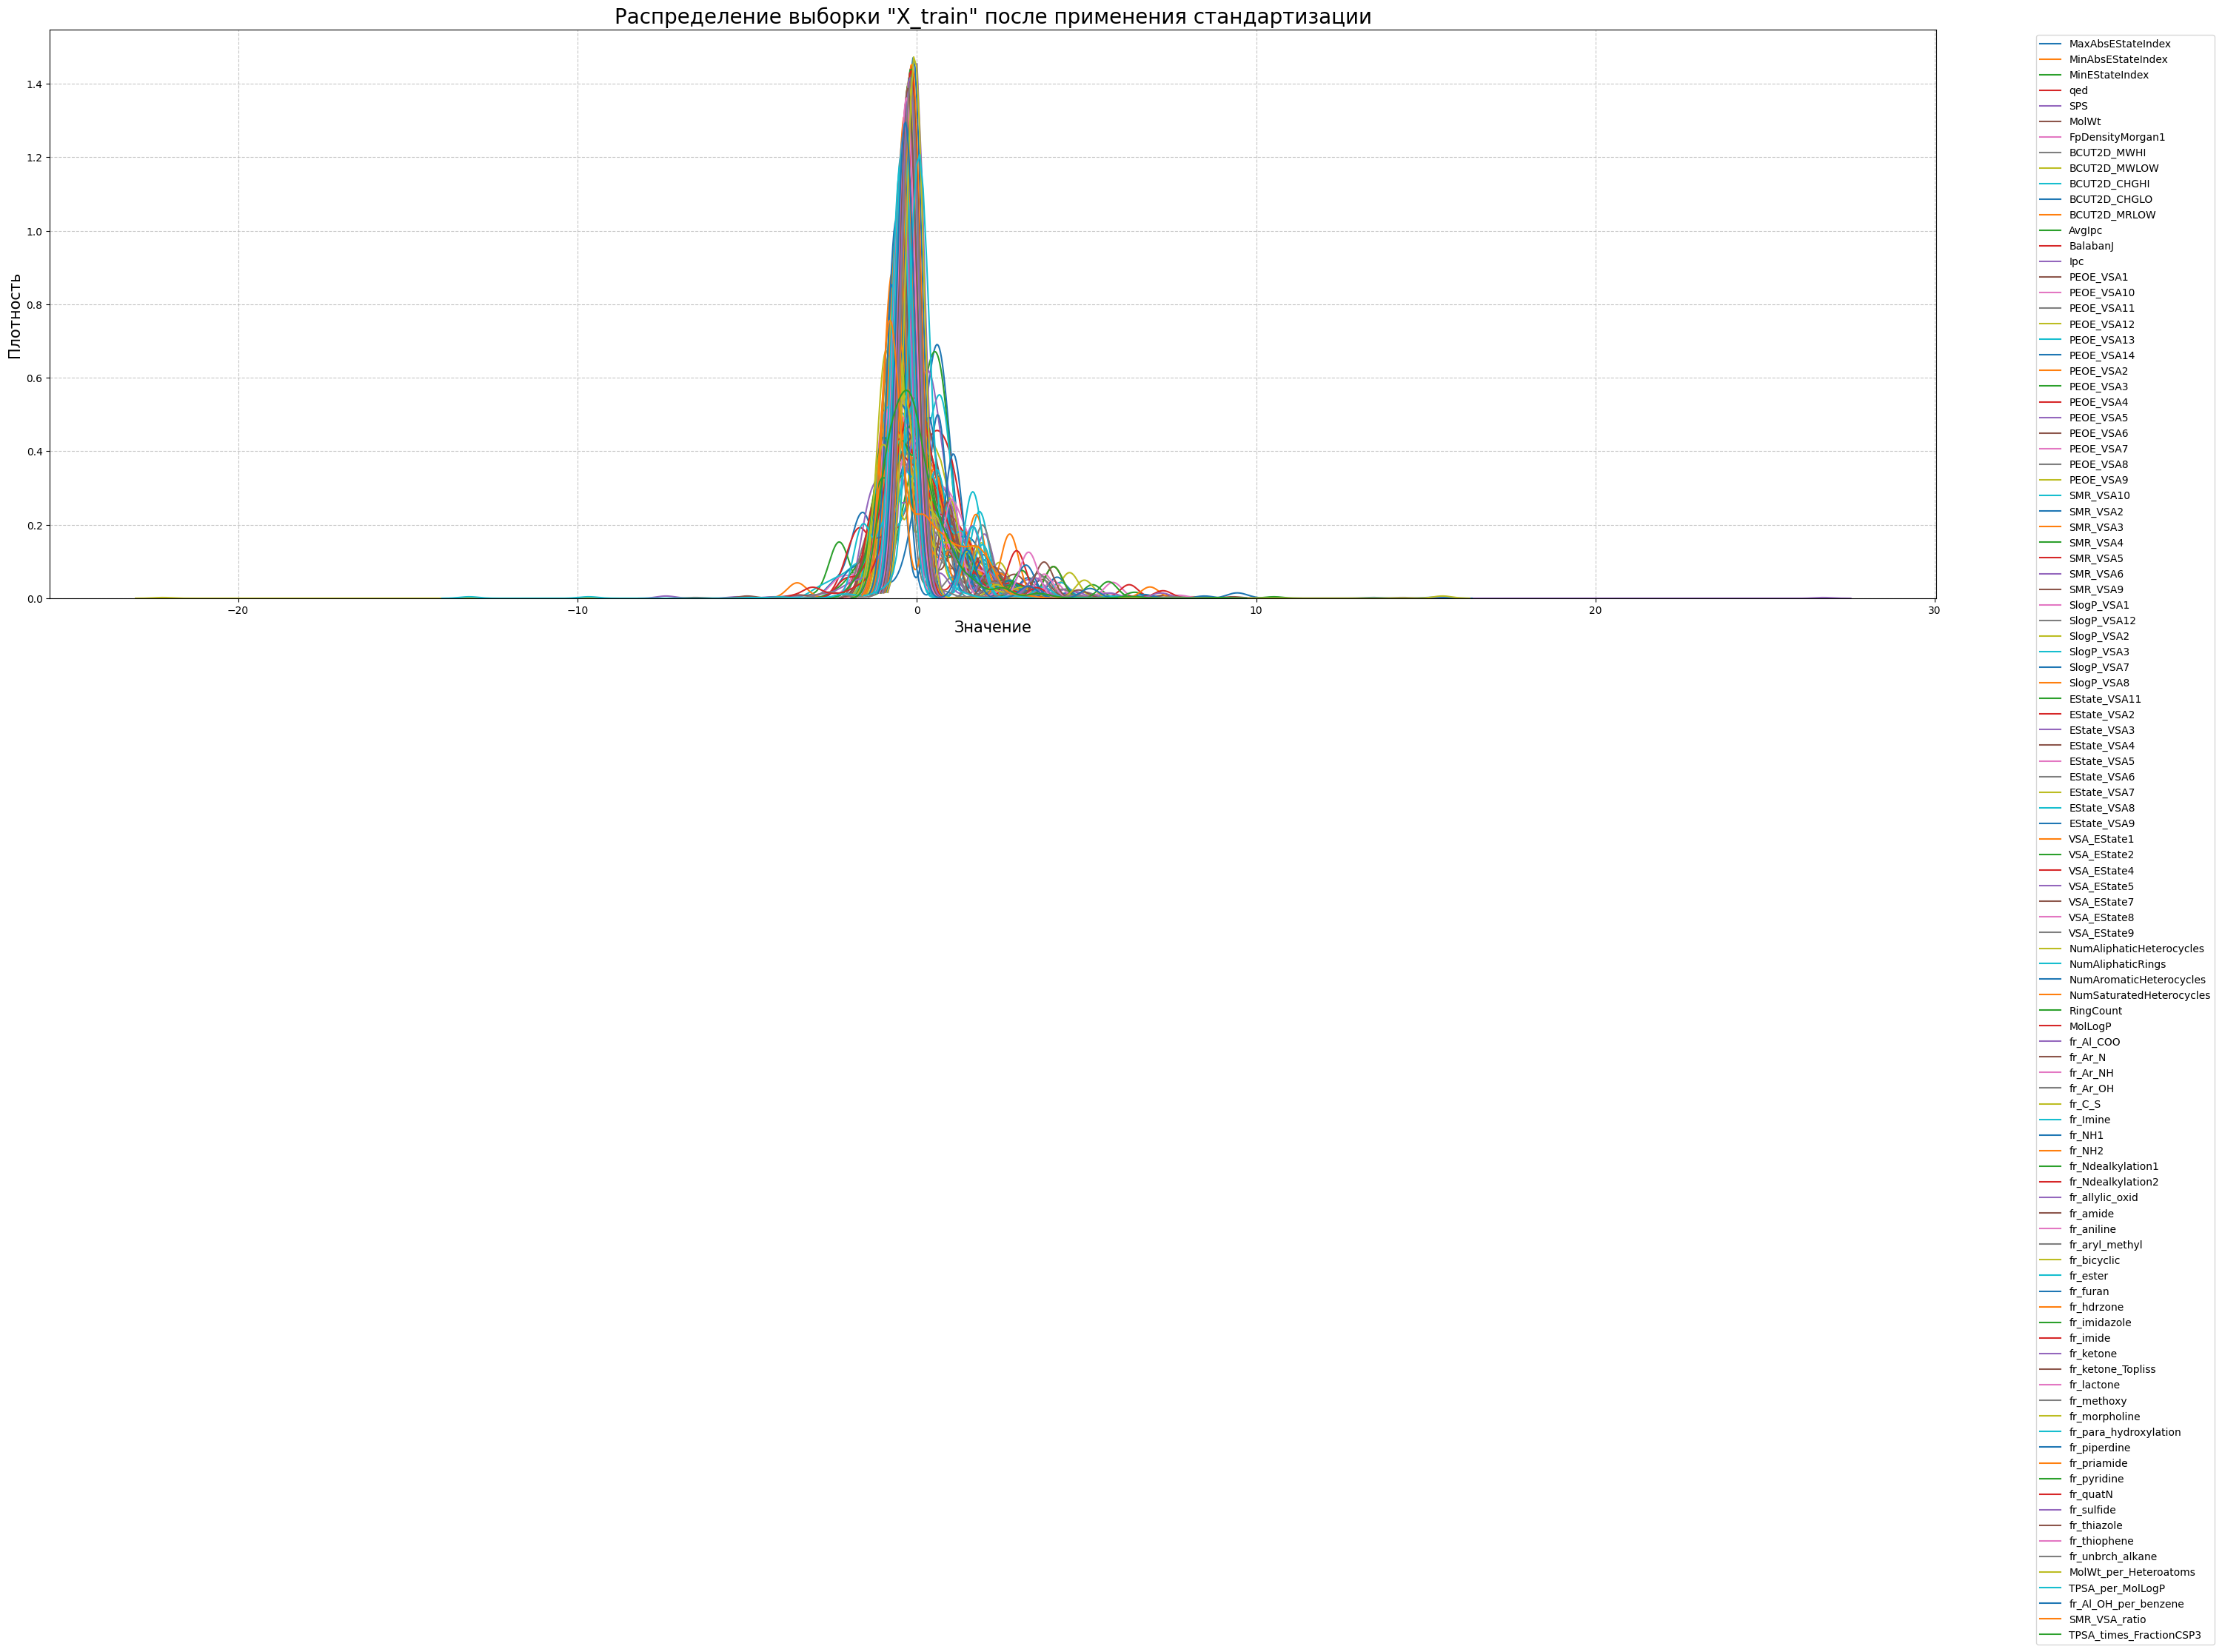

------------------------------------------------------------------------------------------------------------------------------------------------------



График распределения признаков:
------------------------------------------------------------------------------------------------------------------------------------------------------


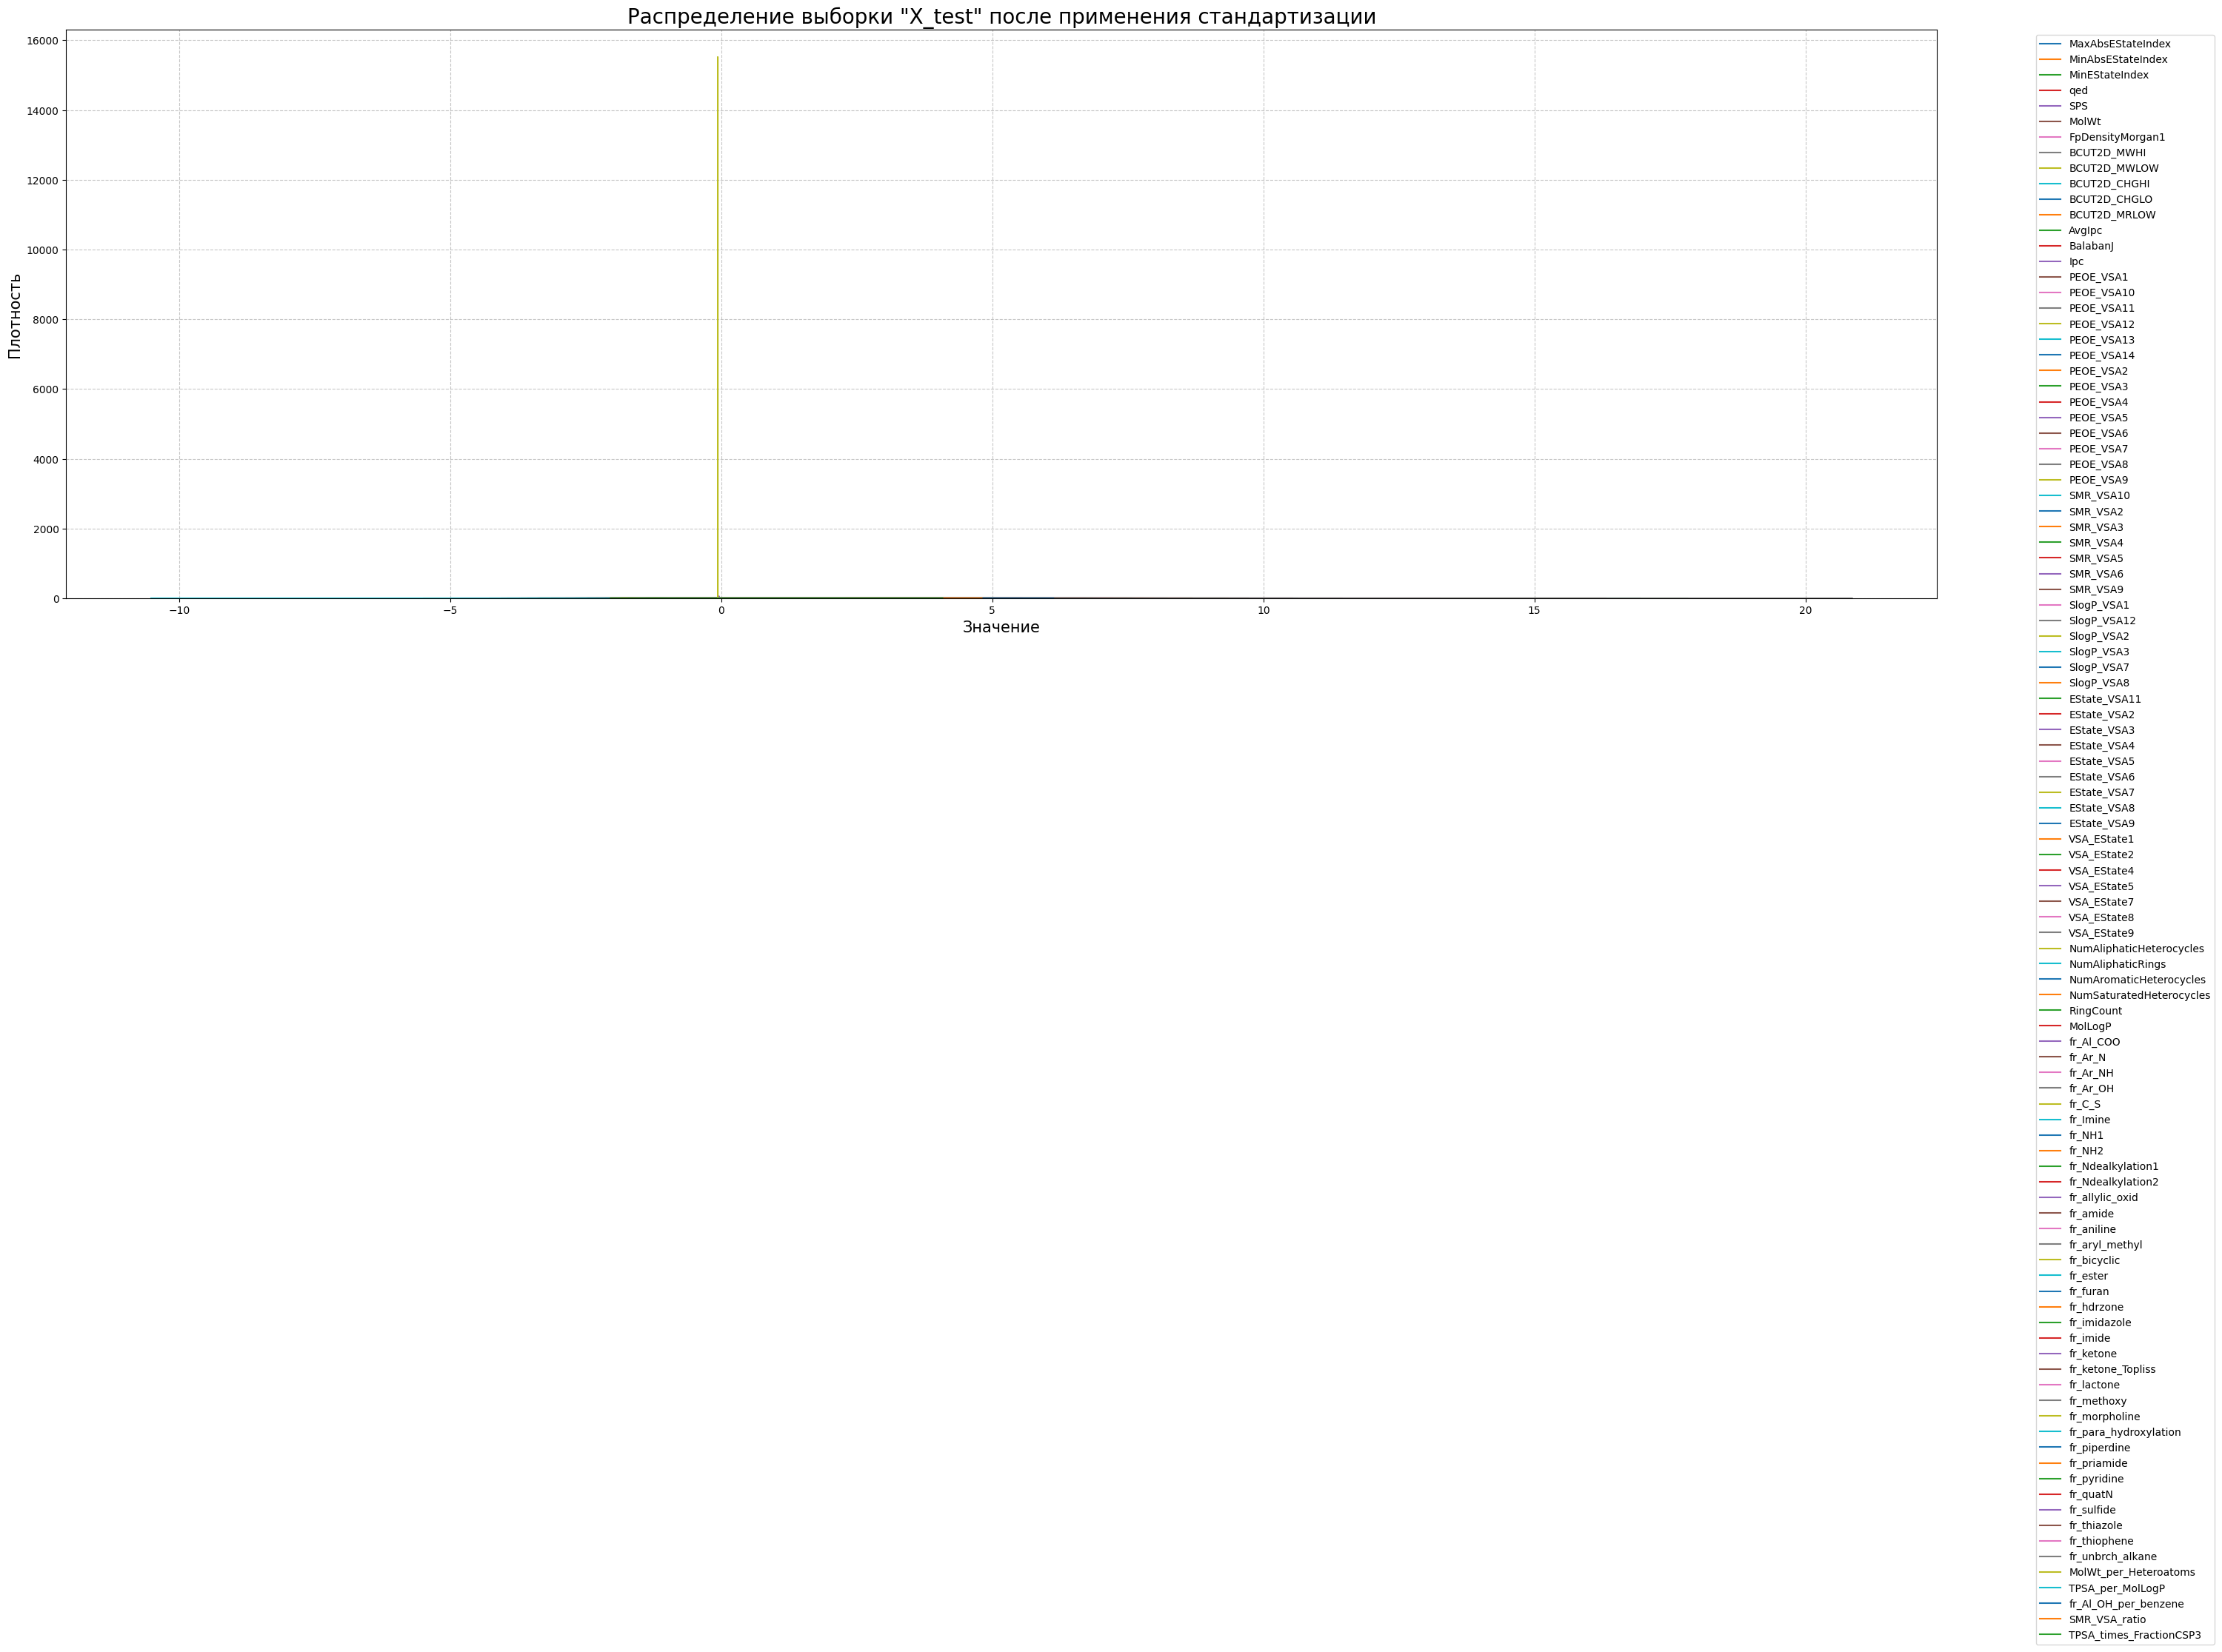

------------------------------------------------------------------------------------------------------------------------------------------------------


In [48]:
# Применяем функцию 'features_distribution_plot()' для построения графика распределения признаков X_train
print()
features_distribution_plot(
    data = X_train_processed_df,
    title = 'Распределение выборки "X_train" после применения стандартизации',
    figsize = (30, 17)
)

# Добавляем отступ
print('\n\n')



# Применяем функцию 'features_distribution_plot()' для построения графика распределения признаков X_test
features_distribution_plot(
    data = X_test_processed_df,
    title = 'Распределение выборки "X_test" после применения стандартизации',
    figsize = (30, 17)
)

**Вывод:**

Распределение признаков также нормализовалось.

#### $2.2$

#### **Отбор самых информативных признаков.**

На данном этапе отберём только самые информативные признаки для дальнейшего решения задачи регрессии.

Производить отбор признаков будем так же, как и для `CC50`, в $4$ этапа:

1. Отберём $50$ признаков с помощью алгоритма **Mutual Information**,
2. Отберём $50$ признаков с помощью алгоритма **F-test**,
3. Отберём $50$ признаков из отобранных обоими алгоритмами,
4. Из оставшихся отберём $30$ признаков с помощью алгоритма **Lasso**.

Только сейчас, все этапы обернём в класс, чтобы использовать его в будущем.

**Создание класса.**

Создадим класс `FeatureSelector`, в котором реализуем все $4$ этапа по отбору самых информативных признаков.

В данный класс включим алгоритмы **Mutual Information**, **F-test** и **Lasso**:

In [40]:
# Создаём класс 'FeatureSelector'          
class FeatureSelector(BaseEstimator, TransformerMixin):
    
    
    
    # Задаём необходимые параметры
    def __init__(self, mi_k=50, f_k=50, log_max_features=30, penalty='l1', solver='liblinear', C=1.0, random_state=42):
    
        """
        Инициализация класса.
        mi_k: количество признаков для Mutual Information.
        f_k: количество признаков для F-теста.
        lasso_max_features: максимальное число признаков для LogisticRegression.
        lasso_alpha: параметр регуляризации для LogisticRegression.
        random_state: для воспроизводимости.
        
        """
        
        self.mi_k = mi_k
        self.f_k = f_k
        self.log_max_features = log_max_features
        self.penalty = penalty
        self.solver = solver
        self.C = C
        self.random_state = random_state
        self.mi_selector = None
        self.f_selector = None
        self.log_model = None
        self.log_selector = None
        self.mi_scores = None
        self.f_scores = None
        self.log_scores = None
        self.mi_selected_features = None
        self.f_selected_features = None
        self.common_features = None
        self.final_features = None
        self.X_train_final = None
        self.X_test_final = None
        
        
        
    # Отбор 50 признаков (Mutual Information)
    def fit_mi(self, X, y):
        
        """
        Фильтрация с помощью Mutual Information.
        
        """
        
        self.mi_selector = feature_selection.SelectKBest(score_func=feature_selection.mutual_info_classif, k=self.mi_k)
        self.mi_selector.fit(X, y)
        self.mi_scores = pd.Series(self.mi_selector.scores_, index = X.columns).sort_values(ascending = False)
        self.mi_selected_features = X.columns[self.mi_selector.get_support()].tolist()
        
        
        
    # Отбор 50 признаков (F-test)
    def fit_f_test(self, X, y):
        
        """
        Фильтрация с помощью F-теста.
        
        """
        
        self.f_selector = feature_selection.SelectKBest(score_func = feature_selection.f_classif, k = self.f_k)
        self.f_selector.fit(X, y)
        self.f_scores = pd.Series(self.f_selector.scores_, index = X.columns).sort_values(ascending = False)
        self.f_selected_features = X.columns[self.f_selector.get_support()].tolist()
        
        
        
    # Из отобранных признаков обоими алгоритмами отберём те, которые попали в оба списка
    def select_common_features(self):
        
        """
        Отбор лучших 50 признаков из пересечения MI и F-теста.
        
        """
        
        self.common_features = list(set(self.mi_selected_features) & set(self.f_selected_features))
        
        if len(self.common_features) < self.mi_k:
            additional_features = [feature for feature in self.mi_selected_features if feature not in self.common_features]
            self.common_features.extend(additional_features[:self.mi_k - len(self.common_features)]) 
            
            
            
    # Отбираем 30 признаков (LogRegression)
    def fit_log(self, X, y):
        
        """
        Применение LogisticRegression для выбора 30 признаков.
        
        """
        
        self.log_model = linear_model.LogisticRegression(penalty=self.penalty, solver=self.solver, C=self.C, random_state=self.random_state)
        self.log_model.fit(X, y)
        self.log_scores = pd.Series(self.log_model.coef_[0], index = X.columns).abs().sort_values(ascending=False)
        self.log_selector = feature_selection.SelectFromModel(self.log_model, prefit=True, max_features=self.log_max_features)
        self.final_features = X.columns[self.log_selector.get_support()].tolist() 
        
        
        
    # Преобразовываем данные
    def transform(self, X_train, X_test):
        
        """
        Трансформация данных с учетом отобранных признаков.
        
        """
        
        # Фильтрация до 50 признаков
        X_train_filtered = X_train[self.common_features]
        X_test_filtered = X_test[self.common_features]

        # Применение LogisticRegression и создание финального DataFrame
        X_train_final_transformed = self.log_selector.transform(X_train_filtered)
        self.X_train_final = pd.DataFrame(
            X_train_final_transformed,
            columns = self.final_features,
            index = X_train.index
        )
        
        self.X_test_final = X_test_filtered[self.final_features]
        
        
    
    # Применяем отбор признаков к тренировочной и тестовой выборке    
    def fit_transform(self, X_train, X_test, y_train):
        
        """
        Полный процесс отбора признаков.
        X_train, X_test: исходные данные.
        y_train: целевая переменная.
        
        """
        
        self.fit_mi(X_train, y_train)
        self.fit_f_test(X_train, y_train)
        self.select_common_features()
        self.fit_log(X_train.loc[:, self.common_features], y_train)
        self.transform(X_train, X_test)
        
        
        
    # Вывод преобразованных данных
    def get_final_data(self):
        
        """
        Возвращает отфильтрованные данные.
        
        """
        
        return self.X_train_final, self.X_test_final, self.final_features



    # Выводим отобранные признаки
    def print_results(self):
        
        """ 
        Вывод результатов отбора признаков.
        
        """
        
        print(f'\nТоп-30 финальных признаков после "LogisticRegression"\n\n{self.log_scores.head(50)}')
        print('-' * 40)

Применим созданный класс к данным:

In [50]:
# Инициализируем класс 'FeatureSelector'         
feature_selector = FeatureSelector(
    mi_k = 50,
    f_k = 50,
    log_max_features = 30,
    penalty = 'l1',
    solver = 'liblinear',
    C = 1.0
)

# Обучаем класс на данных
feature_selector.fit_transform(X_train_processed_df, X_test_processed_df, y_train)

# Получение обработанных данных
X_train_final, X_test_final, final_features = feature_selector.get_final_data()

# Выводим результат
feature_selector.print_results()


Топ-30 финальных признаков после "LogisticRegression"

AvgIpc                      0.858101
VSA_EState1                 0.620910
SPS                         0.504856
VSA_EState5                 0.498231
SlogP_VSA3                  0.484352
NumSaturatedHeterocycles    0.459048
VSA_EState2                 0.417501
PEOE_VSA11                  0.408170
PEOE_VSA8                   0.400835
fr_allylic_oxid             0.359138
EState_VSA4                 0.354596
SlogP_VSA12                 0.348363
BCUT2D_CHGLO                0.338966
NumAliphaticRings           0.318596
fr_C_S                      0.299241
PEOE_VSA1                   0.281390
EState_VSA5                 0.254842
SMR_VSA10                   0.253753
PEOE_VSA6                   0.253747
SMR_VSA4                    0.251588
EState_VSA9                 0.231712
BCUT2D_MRLOW                0.221575
SlogP_VSA1                  0.201547
PEOE_VSA9                   0.185933
BCUT2D_MWHI                 0.184069
EState_VSA6        

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:486: UserWarning:

X has feature names, but SelectFromModel was fitted without feature names



Выведем информацию итоговых выборок:

In [51]:
# Информация по тренеровочной выборке
check_data_inf(
    data = X_train_final,
    data_name = 'X_train_final',
    length1 = 40,
    length2 = 150
)
print('\n\n\n')


# Информация по тестовой выборке
check_data_inf(
    data = X_test_final,
    data_name = 'X_test_final',
    length1 = 40,
    length2 = 150
)


Данные таблицы "X_train_final" имеют следующую размерность:

Количество строк: 723;
Количество признаков (столбцов): 30.
----------------------------------------


VSA_EState1  EState_VSA6  SMR_VSA4    fr_C_S  NumAliphaticRings  \
0      -0.510177    -0.864386  0.809641 -0.222142          -0.123882   
1      -0.228040     1.790326 -0.927114 -0.222142          -0.123882   
2      -0.483553     0.083050  0.018407 -0.222142          -0.123882   
3      -0.823985    -0.864386  1.381794 -0.222142           1.344428   
4      -0.068435    -0.421934 -0.061945 -0.222142          -0.858037   
..           ...          ...       ...       ...                ...   
718    -0.542370    -0.421230  0.809641 -0.222142          -0.123882   
719    -0.524807    -0.052843 -0.021769 -0.222142           0.610273   
720    -0.541832     0.019495 -0.519580 -0.222142          -0.123882   
721     2.477075    -0.864386 -0.927114 -0.222142          -1.592192   
722    -0.535301    -0.864386  0.809641 -0.222142           0.610273   

     NumSaturatedHeterocycles  fr_allylic_oxid  PEOE_VSA6  EState_VSA5  \
0                   -0.725093        -0.446305  -0.283280    -0.034495   
1                   -0.725093        -0.446305  -0.116601    -0.910332   
2                    0.508418        -0.446305  -0.096764    -0.088791   
3                   -0.725093        -0.446305  -0.613549     1.211398   
4                   -0.725093        -0.446305   0.257495     0.197581   
..                        ...              ...        ...          ...   
718                 -0.725093        -0.446305   1.163576     0.252332   
719                  0.508418        -0.446305   1.221381     1.176775   
720                  0.508418        -0.446305   1.040884    -0.656068   
721                 -0.725093        -0.446305  -1.274086     0.620040   
722                  0.508418        -0.446305  -0.283280     0.880668   

     PEOE_VSA9  ...  PEOE_VSA2  SMR_VSA10  SlogP_VSA1  SlogP_VSA12  \
0    -0.741801  ...  -0.188942   0.106999    0.660333    -0.543354   
1     0.137453  ...  -0.221873  -0.287725   -0.224524    -0.543354   
2     0.172684  ...   1.461457   0.488749   -0.135027     0.797640   
3    -1.196283  ...  -1.019830  -1.157446   -0.070691    -0.543354   
4     0.107904  ...  -1.019830   0.817315   -0.135027     0.797640   
..         ...  ...        ...        ...         ...          ...   
718  -0.673288  ...  -0.188942   0.156622   -0.955548    -0.543354   
719  -0.140364  ...  -0.204336  -1.157446   -0.955548    -0.543354   
720   0.311096  ...   2.294595   1.757702    0.595997     0.847924   
721   0.938577  ...  -0.221873   0.096054    1.344306    -0.543354   
722  -0.140364  ...   0.626552  -0.734765   -0.955548    -0.543354   

     SlogP_VSA3  SlogP_VSA8  EState_VSA4  VSA_EState2  VSA_EState5  \
0     -1.068602   -0.571672     1.012479    -0.731273     0.875327   
1      0.254254   -0.571672    -1.063253     0.683650    -0.723162   
2      0.129488   -0.571672     0.237265     0.581600     0.320846   
3     -1.068602   -0.571672    -0.209812    -1.092745     1.075515   
4     -1.068602    0.820604     1.428540    -0.768015    -0.077143   
..          ...         ...          ...          ...          ...   
718    0.129488    0.256341    -0.199418     0.099133     0.172446   
719    1.014571   -0.571672     0.803055    -0.899965     0.530838   
720   -0.465932    0.896349     1.329183     0.650119     0.166710   
721   -0.473182    2.466311    -0.954993     0.705109    -2.182500   
722   -0.473182   -0.571672     1.261254    -0.549976     0.327517   

     MolWt_per_Heteroatoms  
0                -0.064531  
1                -0.064565  
2                -0.064578  
3                -0.064458  
4                -0.064567  
..                     ...  
718              -0.064533  
719              -0.064481  
720              -0.064571  
721              -0.064583  
722              -0.064545  

[723 rows x 30 columns]

------------------------------------------------------------------------------------------------------------------------------------------------------





Данные таблицы "X_test_final" имеют следующую размерность:

Количество строк: 181;
Количество признаков (столбцов): 30.
----------------------------------------


VSA_EState1  EState_VSA6  SMR_VSA4    fr_C_S  NumAliphaticRings  \
0      -0.196948    -0.864386 -0.927114 -0.222142          -1.592192   
1       1.861870    -0.864386 -0.519580  4.501634          -1.592192   
2      -0.215910    -0.421934  0.018407 -0.222142          -0.123882   
3       0.821808    -0.864386  0.809641 -0.222142          -0.123882   
4      -0.823985    -0.031220  2.546396 -0.222142           1.344428   
..           ...          ...       ...       ...                ...   
176    -0.823985    -0.864386  0.949210 -0.222142          -0.123882   
177    -0.754509     0.083050 -0.120755 -0.222142          -0.858037   
178    -0.135080     0.020518 -0.927114 -0.222142          -1.592192   
179     0.380878     0.691279 -0.454353 -0.222142          -0.123882   
180    -0.762200    -0.864386  0.809641 -0.222142          -0.123882   

     NumSaturatedHeterocycles  fr_allylic_oxid  PEOE_VSA6  EState_VSA5  \
0                   -0.725093        -0.446305  -1.274086    -0.615020   
1                   -0.725093        -0.446305  -1.274086     0.562000   
2                    0.508418        -0.446305  -0.637539    -0.623961   
3                   -0.725093        -0.446305  -0.034597    -0.034495   
4                   -0.725093        -0.446305   1.932642     2.726919   
..                        ...              ...        ...          ...   
176                 -0.725093        -0.446305  -0.967807     0.302085   
177                 -0.725093        -0.446305   1.016894    -0.689321   
178                 -0.725093        -0.446305   0.172770    -0.614671   
179                  0.508418         0.829103  -0.984255    -0.910332   
180                 -0.725093        -0.446305  -0.283280     1.195473   

     PEOE_VSA9  ...  PEOE_VSA2  SMR_VSA10  SlogP_VSA1  SlogP_VSA12  \
0     0.074155  ...   0.478616   0.499853   -0.097606    -0.543354   
1    -0.284854  ...   0.731763   0.968608    0.702317     0.901861   
2     0.223838  ...   0.663501  -0.722000   -0.955548    -0.543354   
3     2.426146  ...   1.350016  -0.172658   -0.955548     0.355126   
4    -1.196283  ...   0.641946  -0.312085   -0.955548    -0.543354   
..         ...  ...        ...        ...         ...          ...   
176  -1.196283  ...  -1.019830  -1.157446   -0.070691    -0.543354   
177   0.169628  ...   0.681144   0.976483   -0.118205    -0.543354   
178   0.708890  ...   0.663003   0.536398    0.595997    -0.543354   
179   1.931287  ...  -1.019830  -1.157446    1.237523    -0.543354   
180   1.458881  ...  -0.188942  -0.734765   -0.955548    -0.543354   

     SlogP_VSA3  SlogP_VSA8  EState_VSA4  VSA_EState2  VSA_EState5  \
0      0.288896    0.215681    -1.452750     0.680807    -0.355714   
1     -0.292246   -0.571672    -1.028044    -1.092745    -0.134131   
2     -0.473182   -0.571672    -0.104185    -0.360243     0.318123   
3      2.891055   -0.571672     0.708760    -0.738469     0.292743   
4     -1.068602   -0.571672     0.292272    -0.357125     0.653392   
..          ...         ...          ...          ...          ...   
176   -1.068602   -0.571672    -0.209812    -1.092745     1.076714   
177   -1.068602    0.962434    -0.275581     0.152801     0.085952   
178   -0.245931    0.931911    -0.277778     0.121094     0.432689   
179   -0.473182   -0.571672    -0.673080    -1.092745     0.531638   
180   -1.068602   -0.571672    -0.266382    -0.728190     0.328861   

     MolWt_per_Heteroatoms  
0                -0.064599  
1                -0.064590  
2                -0.064578  
3                -0.064576  
4                -0.064459  
..                     ...  
176              -0.064510  
177              -0.064572  
178              -0.064572  
179              -0.064570  
180              -0.064515  

[181 rows x 30 columns]

------------------------------------------------------------------------------------------------------------------------------------------------------


**Построение визуализаций.**

Создадим функцию, для построения `treemap` графиков отобранных признаков:

In [69]:
# Функция для построения treemap диаграммы признаков
def treemap_features(data, title = None, main_title = None, color = None):
    
    
    """
    Функция для построения treemap диаграммы признаков.
    
    Параметры:
    - data: pandas Series с признаками и их важностью.
    - title: заголовок графика.
    - main_title: основной заголовок графика.
    - color: цветовая палитра для графика.
    
    """
    
    
    # Создаём заголовок для графика
    print(f'\n{main_title}')
    print('-' * 150)

    
    # Построение treemap для важности признаков 
    fig = px.treemap(
        data.reset_index(),
        path = ['index'],
        values = data.values,
        color = data.values,               # числовая переменная для цветовой шкалы
        color_continuous_scale = color,    # последовательная цветовая палитра
        title = title,
    
        labels = {
            'index': 'Признак', 
            'value': 'Важность'
        },
    
        width = 1200,
        height = 800
    )

    # Настройка отображения текста в treemap
    fig.data[0].texttemplate = "%{label}<br>%{value:.4f}"

    # Настройка макета
    fig.update_layout(
        title_x = 0.5,
        title_font_size = 20,
    
        margin = dict(
            t = 50, 
            l = 25, 
            r = 25, 
            b = 25
        )
        
    )



    # Отображение графика
    fig.show('png')
    print('-' * 150)

Выводим $50$ признаков, отобранных методом `Mutual Information`:


Топ-50 признаков по "Mutual Information":

BCUT2D_MWHI                 0.152939
BCUT2D_MRLOW                0.147848
BCUT2D_CHGLO                0.139916
SlogP_VSA2                  0.138932
SMR_VSA5                    0.136386
EState_VSA8                 0.117926
PEOE_VSA1                   0.114547
PEOE_VSA6                   0.112269
BCUT2D_MWLOW                0.108180
PEOE_VSA7                   0.106348
PEOE_VSA8                   0.104890
MinEStateIndex              0.103243
VSA_EState2                 0.100479
SMR_VSA4                    0.100283
PEOE_VSA9                   0.094741
MolWt                       0.089717
AvgIpc                      0.089590
SPS                         0.089309
VSA_EState1                 0.085185
BCUT2D_CHGHI                0.081939
MinAbsEStateIndex           0.079426
BalabanJ                    0.078689
EState_VSA3                 0.077112
VSA_EState7                 0.074949
EState_VSA4                 0.073758
VSA_EState8                 0.0

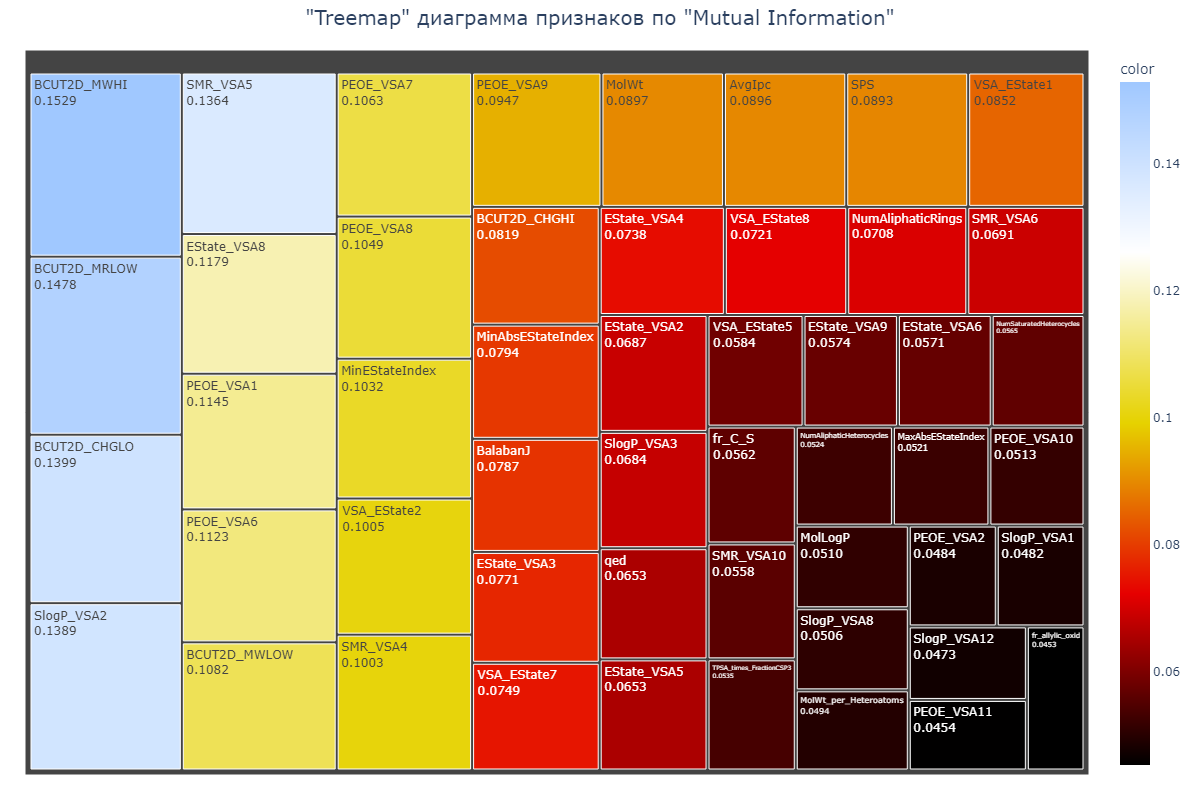

------------------------------------------------------------------------------------------------------------------------------------------------------

График кумулятивного вклада признаков (MI)
------------------------------------------------------------------------------------------------------------------------------------------------------


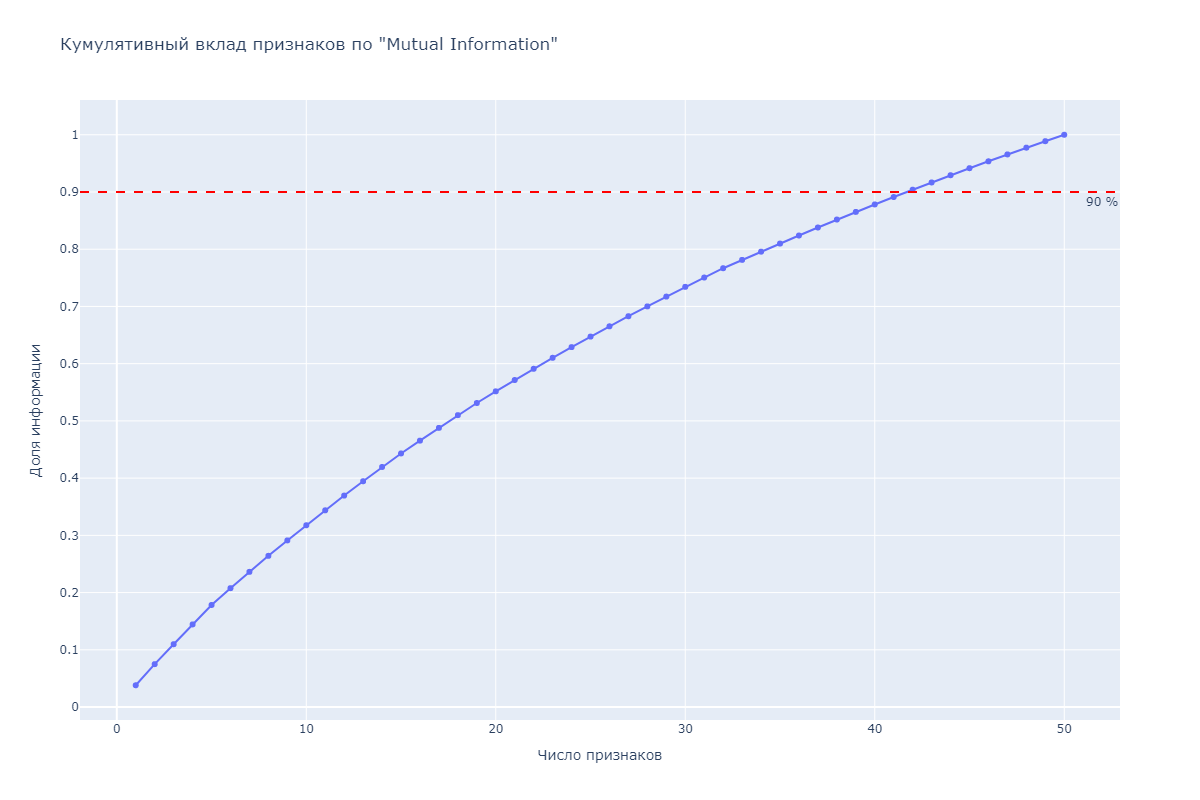

------------------------------------------------------------------------------------------------------------------------------------------------------


In [72]:
# Выбираем первые 50 признаков
mi_features = feature_selector.mi_selected_features
mi_scores = feature_selector.mi_scores[mi_features].sort_values(ascending = False)


# Выводим результат
print(f'\nТоп-50 признаков по "Mutual Information":\n\n{feature_selector.mi_scores.head(50)}')
print('-' * 40)
print('\n\n')




# Посторим график оценки важности признаков при помощи функции 'treemap_features'
treemap_features(
    data = mi_scores,
    title = '"Treemap" диаграмма признаков по "Mutual Information"',
    main_title = '"Treemap" диаграмма признаков по "Mutual Information":',
    color = px.colors.sequential.Blackbody
)


# Построим кумулятивную линию при помощи функции 'cum_line'
cum_line(
    data = mi_scores,
    main_title = 'График кумулятивного вклада признаков (MI)',
    title = 'Кумулятивный вклад признаков по "Mutual Information"'
)

Выводим $50$ признаков, отобранных методом `F-test`:


Топ-50 признаков по "F-test":

NumSaturatedHeterocycles    53.623912
fr_NH2                      45.565345
NumAliphaticHeterocycles    45.354902
PEOE_VSA7                   41.003074
PEOE_VSA9                   28.573123
VSA_EState4                 27.487946
fr_Ar_OH                    25.279515
fr_allylic_oxid             25.248503
NumAromaticHeterocycles     22.698468
BCUT2D_CHGLO                22.325853
SMR_VSA4                    22.004148
PEOE_VSA4                   21.419145
SMR_VSA5                    21.391318
SMR_VSA6                    20.092218
AvgIpc                      19.245821
VSA_EState1                 18.388235
EState_VSA3                 18.089411
fr_C_S                      17.104784
FpDensityMorgan1            16.815654
PEOE_VSA8                   16.557255
MinEStateIndex              15.451559
BCUT2D_MWLOW                15.207506
fr_sulfide                  14.996502
fr_Ar_N                     14.670603
fr_ketone_Topliss           13.971818
SMR_VSA3          

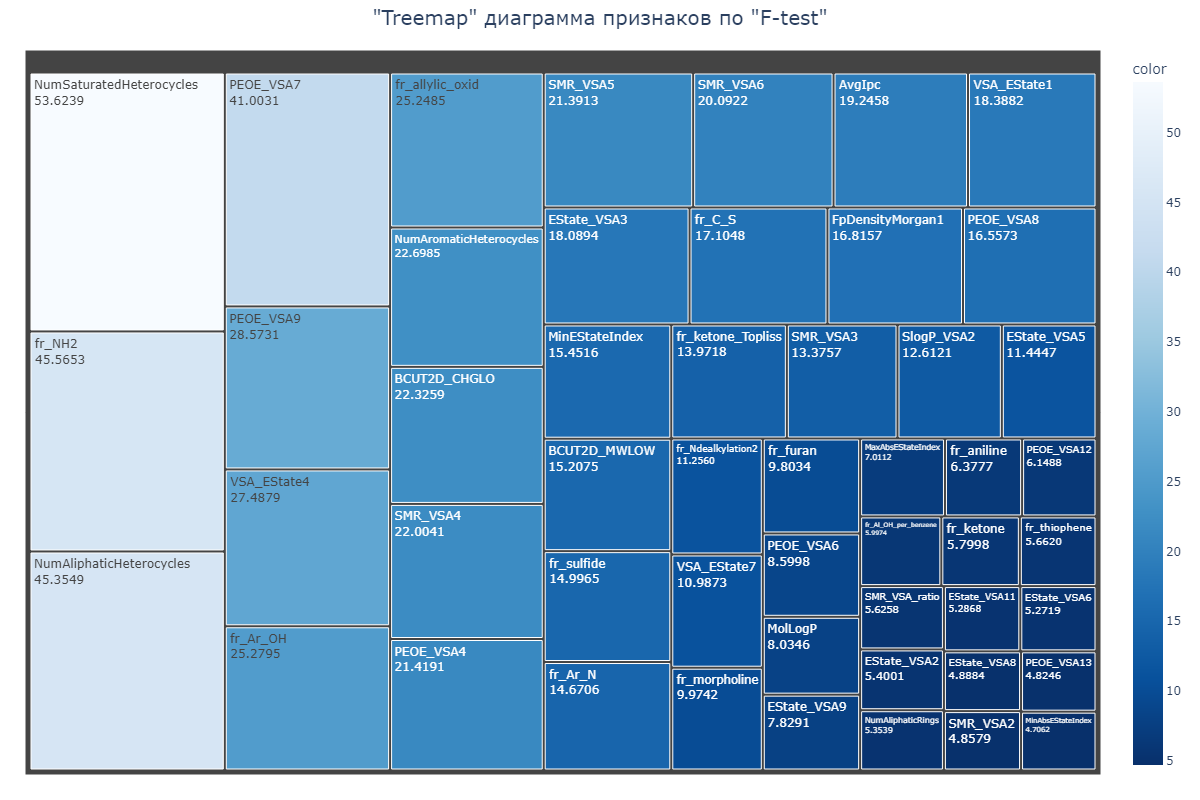

------------------------------------------------------------------------------------------------------------------------------------------------------

График кумулятивного вклада признаков (F-test)
------------------------------------------------------------------------------------------------------------------------------------------------------


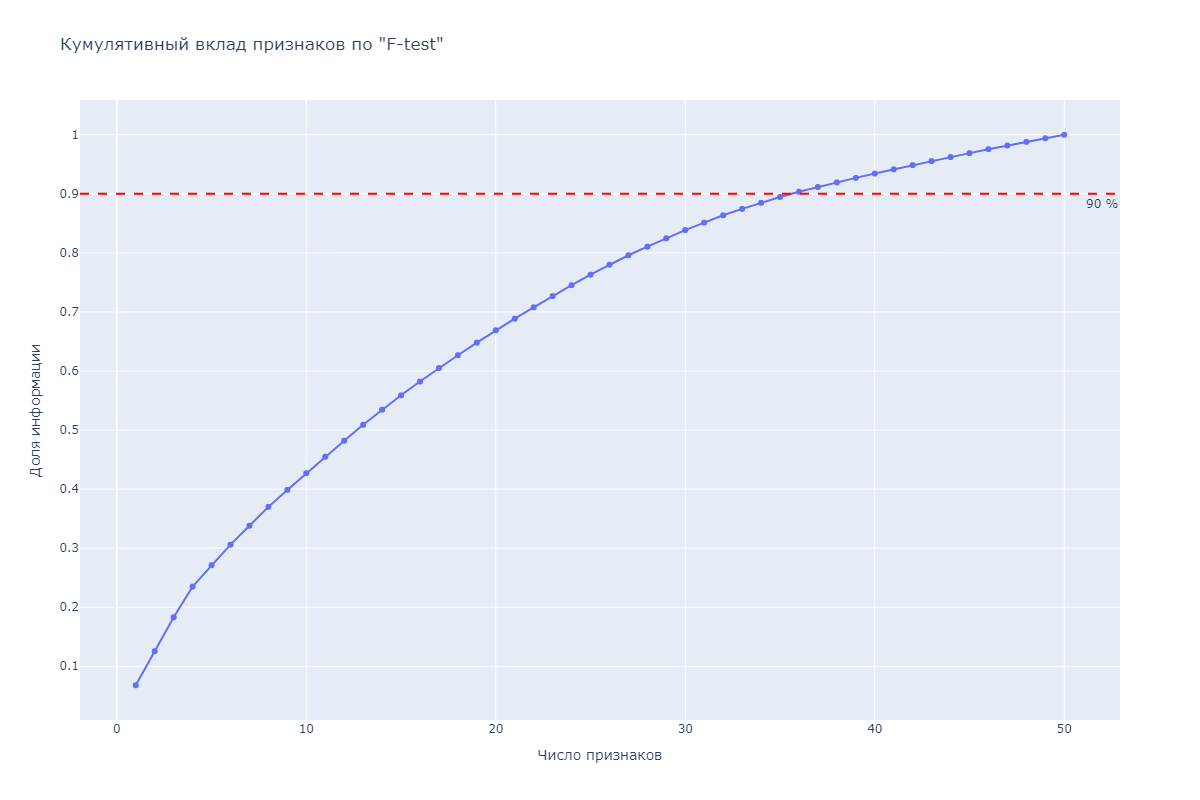

------------------------------------------------------------------------------------------------------------------------------------------------------


In [74]:
# Выбираем первые 50 признаков
f_features = feature_selector.f_selected_features
f_scores = feature_selector.f_scores[f_features].sort_values(ascending = False)


# Выводим результат
print(f'\nТоп-50 признаков по "F-test":\n\n{feature_selector.f_scores.head(50)}')
print('-' * 40)
print('\n\n')




# Посторим график оценки важности признаков при помощи функции 'treemap_features'
treemap_features(
    data = f_scores,
    title = '"Treemap" диаграмма признаков по "F-test"',
    main_title = '"Treemap" диаграмма признаков по "F-test":',
    color = px.colors.sequential.Blues_r
)


# Построим кумулятивную линию при помощи функции 'cum_line'
cum_line(
    data = f_scores,
    main_title = 'График кумулятивного вклада признаков (F-test)',
    title = 'Кумулятивный вклад признаков по "F-test"'
)

**Вывод:**

По алгоритму `F-test` самое оптимальное количество признаков достигает $35$.

Выводим финальные $30$ признаков, отобранных методом `LogisticRegression`:


Топ-30 признаков по "LogisticRegression":

AvgIpc                      0.858101
VSA_EState1                 0.620910
SPS                         0.504856
VSA_EState5                 0.498231
SlogP_VSA3                  0.484352
NumSaturatedHeterocycles    0.459048
VSA_EState2                 0.417501
PEOE_VSA11                  0.408170
PEOE_VSA8                   0.400835
fr_allylic_oxid             0.359138
EState_VSA4                 0.354596
SlogP_VSA12                 0.348363
BCUT2D_CHGLO                0.338966
NumAliphaticRings           0.318596
fr_C_S                      0.299241
PEOE_VSA1                   0.281390
EState_VSA5                 0.254842
SMR_VSA10                   0.253753
PEOE_VSA6                   0.253747
SMR_VSA4                    0.251588
EState_VSA9                 0.231712
BCUT2D_MRLOW                0.221575
SlogP_VSA1                  0.201547
PEOE_VSA9                   0.185933
BCUT2D_MWHI                 0.184069
EState_VSA6                 0.1

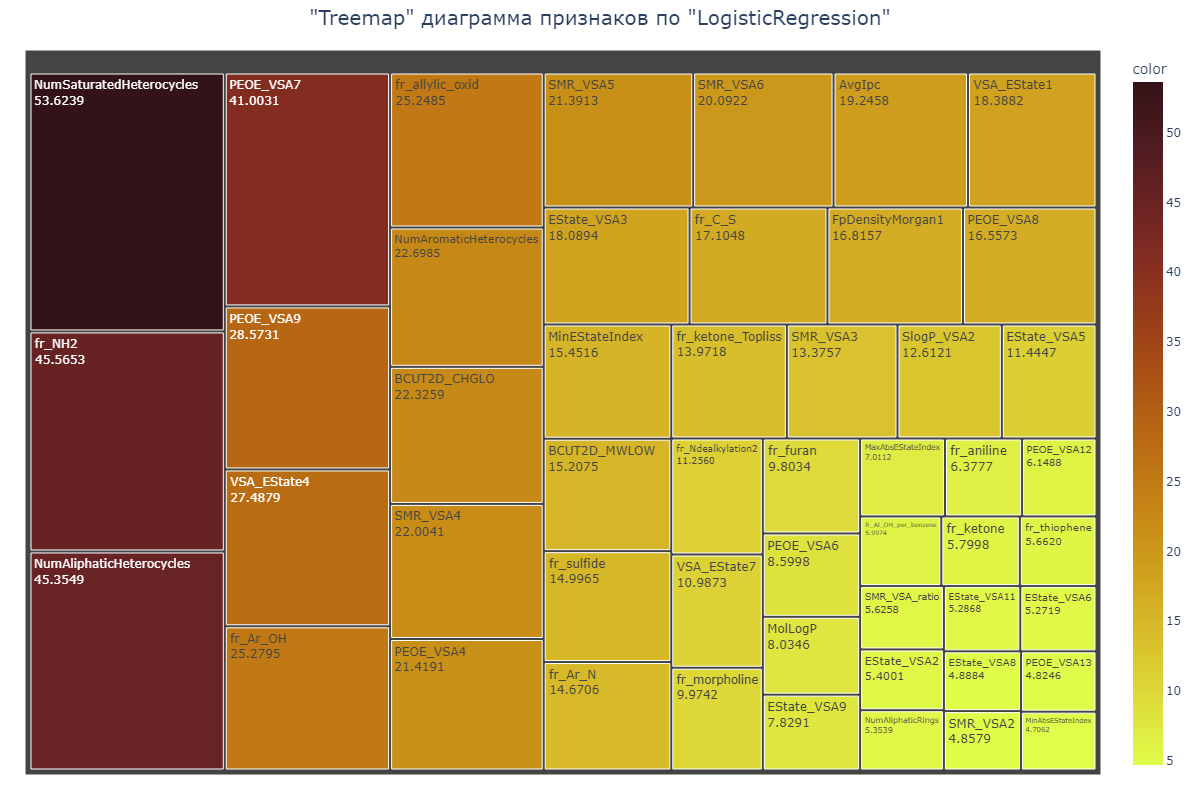

------------------------------------------------------------------------------------------------------------------------------------------------------

График кумулятивного вклада признаков (LogisticRegression)
------------------------------------------------------------------------------------------------------------------------------------------------------


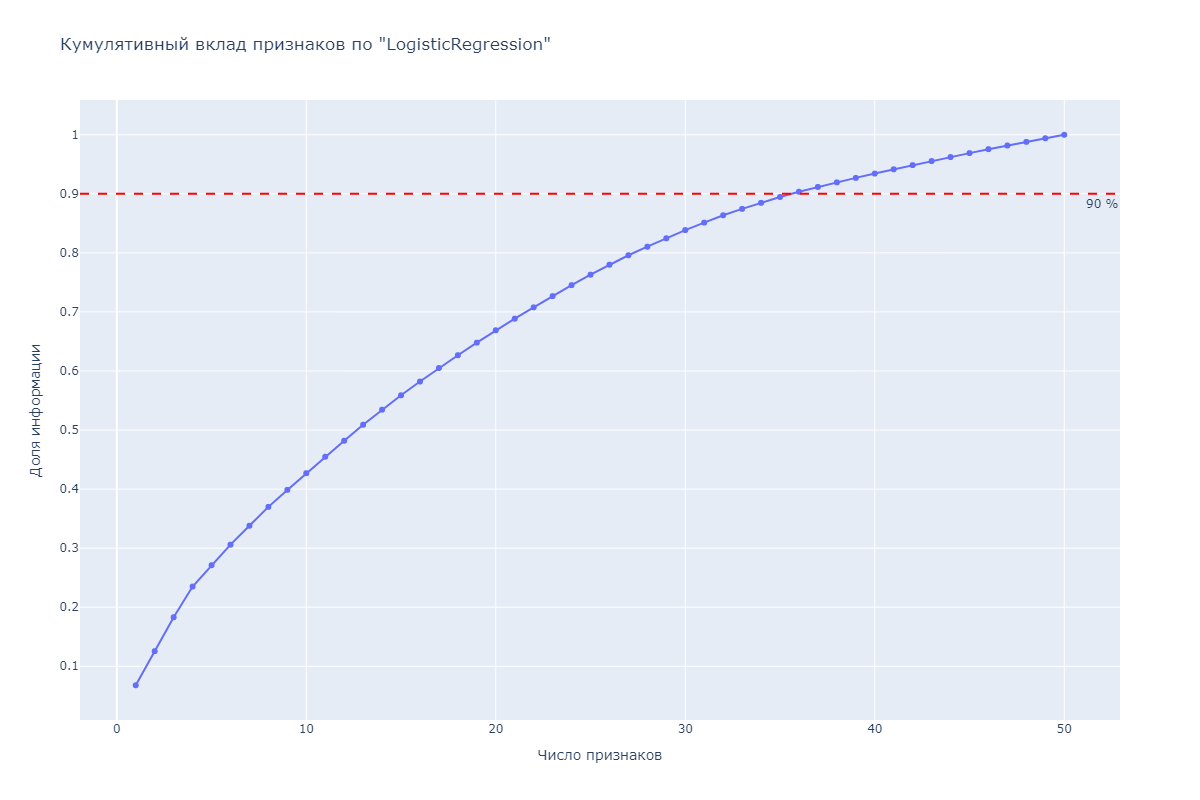

------------------------------------------------------------------------------------------------------------------------------------------------------


In [113]:
# Выбираем первые 30 признаков
log_features = feature_selector.final_features
log_scores = feature_selector.log_scores[log_features].sort_values(ascending = False)


# Выводим результат
print(f'\nТоп-30 признаков по "LogisticRegression":\n\n{log_scores.head(30)}')
print('-' * 40)
print('\n\n')




# Посторим график оценки важности признаков при помощи функции 'treemap_features'
treemap_features(
    data = f_scores,
    title = '"Treemap" диаграмма признаков по "LogisticRegression"',
    main_title = '"Treemap" диаграмма признаков по "LogisticRegression":',
    color = px.colors.sequential.solar_r
)


# Построим кумулятивную линию при помощи функции 'cum_line'
cum_line(
    data = f_scores,
    main_title = 'График кумулятивного вклада признаков (LogisticRegression)',
    title = 'Кумулятивный вклад признаков по "LogisticRegression"'
)

Проверим корреляцию отобранных признаков:


Тепловая карта корреляции отобранных признаков:
------------------------------------------------------------------------------------------------------------------------------------------------------


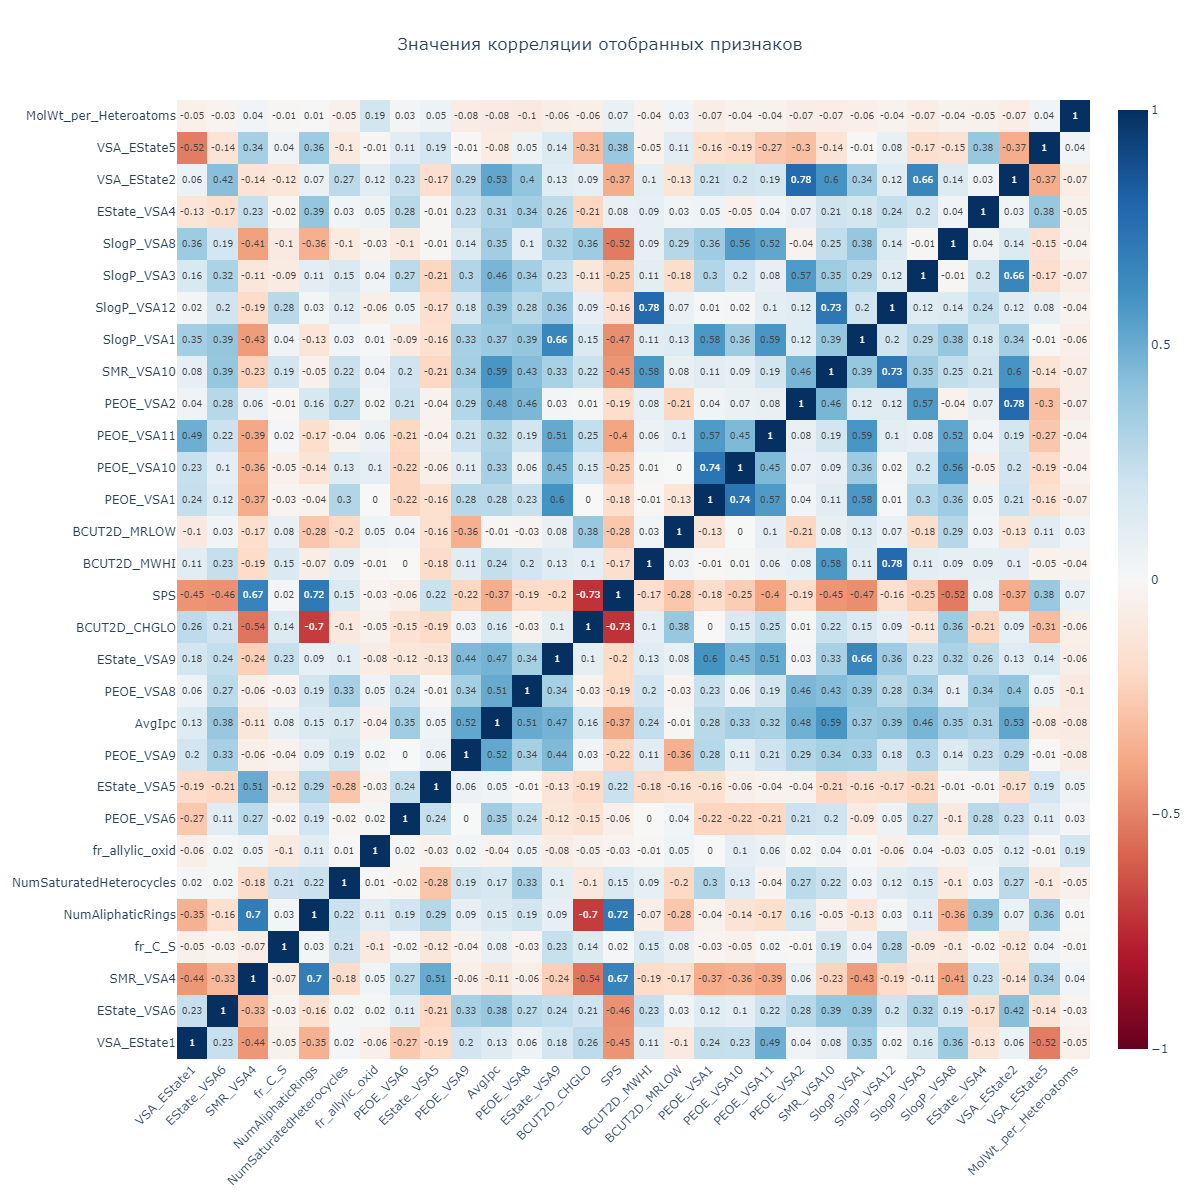

------------------------------------------------------------------------------------------------------------------------------------------------------


In [114]:
# Применяем функцию 'heatmap_corr()' для построения тепловой карты корреляции
heatmap_corr(data = X_train_final)

**Вывод:**

По тепловой карте видно, что значения корреляций признаков ещё чуть ниже, и не выходят за пределы $+-0.73$, а следовательно высококоррелированные связи отсутствуют.

#### $2.3$

#### **Machine Learning.**

Используем всё те же модели, что и для предсказания `IC50`: 

* **XGBoost (Extreme Gradient Boosting)**, 
* **LightGBM (Light Gradient Boosting Machine)**, 
* **Support Vector Machine (SVM) с ядром RBF**, 
* **RandomForestClassifier**, 
* **MLPClassifier**.

Создаём словарь, в котором ключами будут названия моделей, а значениями - словари с гиперпараметрами для подбора:

In [62]:
# Определяем модели и их гиперпараметры
ML_models = {
    
    # Определяем модель 'XGBoost'
    'XGBoost': {
        'model': XGBClassifier(random_state = 42),
        
        'param_grid': {
            'n_estimators': [50, 100, 200],
            'max_depth': [3, 5, 7],
            'learning_rate': [0.01, 0.1, 0.3],
            'subsample': [0.6, 0.8, 1.0],
            'colsample_bytree': [0.6, 0.8, 1.0],
            'scale_pos_weight': [1, sum(y_train == 0) / sum(y_train == 1)]
        }
        
    },
    
    
    
    # Определяем модель 'LightGBM'
    'LightGBM': {
        'model': LGBMClassifier(random_state = 42),
        
        'param_grid': {
            'n_estimators': [50, 100, 200],
            'max_depth': [-1, 5, 10],
            'learning_rate': [0.01, 0.1, 0.3],
            'num_leaves': [31, 63, 127],
            'subsample': [0.6, 0.8, 1.0],
            'colsample_bytree': [0.6, 0.8, 1.0],
            'class_weight': ['balanced', None]
        }
        
    },
    
    
    
    # Определяем модель опорных векторов
    'SVC': {
        'model': svm.SVC(random_state = 42, probability = True),
        
        'param_grid': {
            'C': [0.1, 1, 10],
            'gamma': ['scale', 'auto', 0.1, 1],
            'class_weight': ['balanced', None]
        }
        
    },
    
    
    
    # Определяем модель случайного леса
    'RandomForest': {
        'model': ensemble.RandomForestClassifier(random_state = 42),
        
        'param_grid': {
            'n_estimators': [100, 200, 300],
            'max_depth': [None, 10, 20],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'class_weight': ['balanced', 'balanced_subsample', None]
        }
        
    },
    
    
    
    # Определяем модель нейронной сети для классификации
    'MLPClassifier': {
        'model': neural_network.MLPClassifier(random_state = 42),
        
        'param_grid': {
            'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50)],
            'activation': ['relu', 'tanh'],
            'learning_rate_init': [0.001, 0.01],
            'alpha': [0.0001, 0.001, 0.01], 
            'max_iter': [200, 500]
        }
        
    }
    
}

Теперь создадим функцию, которая будет использоваться для обучения и оценки моделей:

In [63]:
# Создаём функцию 'train_model' для обучения и оценки модели
def train_model(model_name, config, X_train, X_test, y_train, y_test):
    
    # Выводим обучаемую модель
    print(f'\n\n\nОбучение модели: {model_name}')
    
    
    
    # Перебор гиперпараметров с использованием алгоритма 'GridSearchCV'
    # если гиперпараметры заданы
    if config['param_grid']:
        
        # Инициализируем класс 'GridSearchCV' с заданными гиперпараметрами
        grid_search = model_selection.GridSearchCV(
            estimator = config['model'],
            param_grid = config['param_grid'],
            cv = 3,
            verbose = 2,
            n_jobs = -1
        )
        
        # Обучаем наш класс
        grid_search.fit(X_train, y_train)
        
        # Сохраняем лучшие гиперпараметры
        best_model = grid_search.best_estimator_
        
        # Выводим результат
        print(f'Лучшие параметры для {model_name}: {grid_search.best_params_}')
        print('-' * 80)
        print('\n\n')
    
    
    # если гиперпараметры не заданы    
    else:
        
        # Оставляем стандартные параметры
        best_model = config['model']
        best_model.fit(X_train, y_train)
        
        
        
    # Делаем предсказание
    y_predict = best_model.predict(X_test)
    
    # Вызываем 'print_metrics' для вывода и получения метрик
    metrics_result = print_metrics(
        y_test,
        y_predict = y_predict,
        model_name = model_name,
        decimal_places = 3
    )
    
    
    
    # Возвращаем результат
    return metrics_result

Обучаем моделей и строим предсказания:

In [87]:
# Создаём словарь, в котором будем хранить наши предсказания
results = {}


# Создём цикл по созданному ранее словарю с моделями
# и обучаем их при помощи функции 'train_model'
for name, config in ML_models.items():
    
    # Заносим в словарь 'results' модели и метрики
    results[name] = train_model(
        name,
        config = config,
        X_train = X_train_final,
        X_test = X_test_final,
        y_train = y_train,
        y_test = y_test
    )




Обучение модели: XGBoost
Fitting 3 folds for each of 486 candidates, totalling 1458 fits


c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning:

invalid value encountered in cast



Лучшие параметры для XGBoost: {'colsample_bytree': 0.6, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'scale_pos_weight': 1, 'subsample': 0.8}
--------------------------------------------------------------------------------



XGBoost (значения метрик):

Accuracy: 0.707
--------------------------------------------------------------------------------
Precision: 0.715
--------------------------------------------------------------------------------
Recall: 0.707
--------------------------------------------------------------------------------
F1-score: 0.707
--------------------------------------------------------------------------------

Classification report:

              precision    recall  f1-score   support

           0       0.76      0.66      0.71        98
           1       0.66      0.76      0.70        83

    accuracy                           0.71       181
   macro avg       0.71      0.71      0.71       181
weighted avg       0.71      0.71      0.71     

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



#### $2.4$

#### **Определяем лучшую модель.**

Составим таблицу (**DataFrame**) со следующими столбцами:

Наименование модели:

* `model_name`,

Метрики и их значения:

* `Accuracy`,

* `Precision`,

* `Recall`,

* `F1-score`.

In [120]:
# Создаём DataFrame
model_metrics = {
    'XGBClassifier'             : {'Accuracy': 0.707, 'Precision': 0.715, 'Recall': 0.707, 'F1-score': 0.707},
    'LGBMClassifier'            : {'Accuracy': 0.713, 'Precision': 0.720, 'Recall': 0.713, 'F1-score': 0.713},
    'RandomForestClassifier'    : {'Accuracy': 0.702, 'Precision': 0.705, 'Recall': 0.702, 'F1-score': 0.702},
    'SupportVectorClassifier'   : {'Accuracy': 0.746, 'Precision': 0.751, 'Recall': 0.746, 'F1-score': 0.746},
    'MLPClassifier'             : {'Accuracy': 0.724, 'Precision': 0.728, 'Recall': 0.724, 'F1-score': 0.724}
}

metrics_df = pd.DataFrame(model_metrics).T
metrics_df = metrics_df.reset_index().rename(columns = {'index': 'model_name'})

**Визуализация метрик.**

Теперь построим графики по каждой метрике, чтобы сравнить их друг с другом визуально.


Данные таблицы "metrics_df" имеют следующую размерность:

Количество строк: 5;
Количество признаков (столбцов): 5.
-----------------------------------


model_name  Accuracy  Precision  Recall  F1-score
0            XGBClassifier     0.707      0.715   0.707     0.707
1           LGBMClassifier     0.713      0.720   0.713     0.713
2   RandomForestClassifier     0.702      0.705   0.702     0.702
3  SupportVectorClassifier     0.746      0.751   0.746     0.746
4            MLPClassifier     0.724      0.728   0.724     0.724

------------------------------------------------------------




Столбчатая диаграмма сравнения метрик моделей классификации ("CC50"):
------------------------------------------------------------------------------------------------------------------------------------------------------


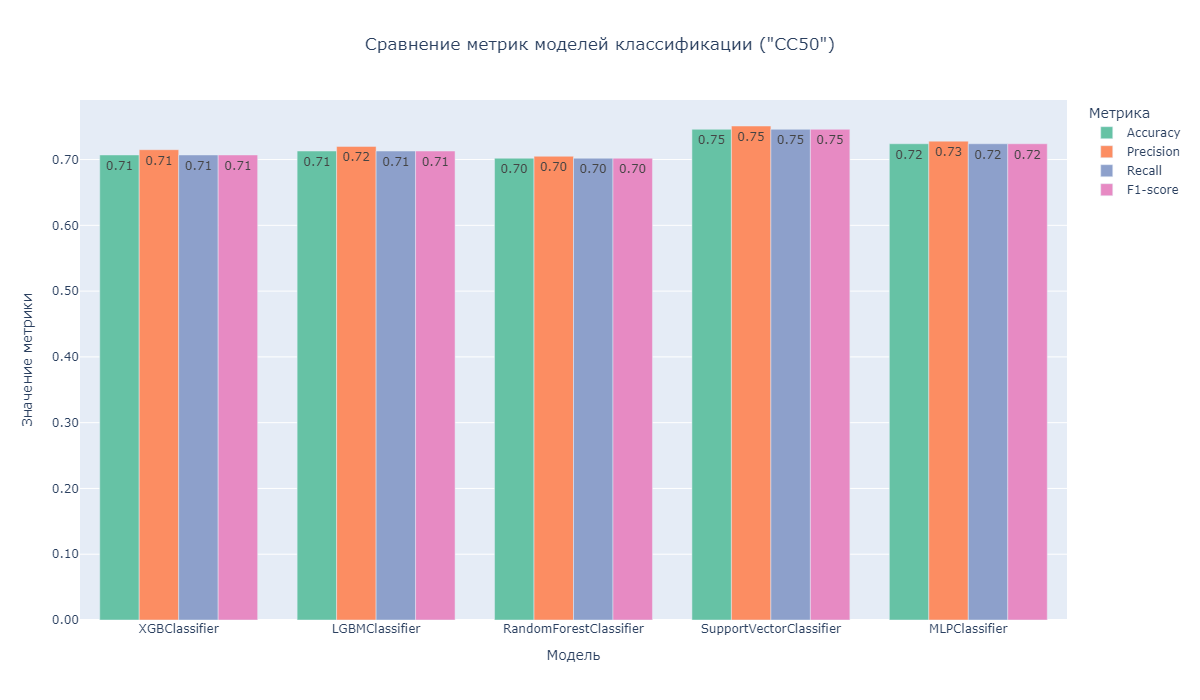

------------------------------------------------------------------------------------------------------------------------------------------------------


In [131]:
# Выводим результат
check_data_inf(
    data = metrics_df,
    data_name = 'metrics_df',
    length1 = 35,
    length2 = 60
)
print('\n\n')


# Применяем функцию 'metrics_bar_plot()' для построения столбчатого графика метрик
metrics_bar_plot(
    data = metrics_df,
    main_title = 'Столбчатая диаграмма сравнения метрик моделей классификации ("CC50"):',
    title = 'Сравнение метрик моделей классификации ("CC50")',
    colors = px.colors.qualitative.Set2
)

#### $2.5$

#### **Вывод.**

На данном этапе сделаем вывод итоговым метрикам и моделям, обученным для предсказания целевой переменной `CC50, mM`.

=============================================================================================================================================

## <CENTER> **`3.` Machine Learning (превышает ли значение SI медианное значение выборки)**

На данном этапе мы построим несколько подходящих моделей классификации для **SI** и выберем наилучшую.

#### $3.1$

#### **Предобработка данных.**

Как и раньше, предобработаем данные при помощи созданного ранее пайплайна, только все этапы по предобработке, созданию и удалению признаков включим в отдельный класс.

Повторно загружаем пайплайн:

In [31]:
# Загружаем пайплайн при помощи joblib
preprocessing_pipeline = joblib.load('data/preprocessing_pipeline.joblib')
print("Пайплайн загружен из 'preprocessing_pipeline.joblib'")

Пайплайн загружен из 'preprocessing_pipeline.joblib'


Создаём целевую переменную:


Медианное значение SI: 1.5113188221114595
---------------------------------------------



Уникальные значения признака "SI_classif":



SI_classif
1    452
0    452
Name: count, dtype: int64

---------------------------------------------


Стобчатая и круговая диаграммы распределения целевой переменной "SI_classif":
------------------------------------------------------------------------------------------------------------------------------------------------------


C:\Users\User\AppData\Local\Temp\ipykernel_14216\4276034505.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(
C:\Users\User\AppData\Local\Temp\ipykernel_14216\4276034505.py:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_xticklabels(


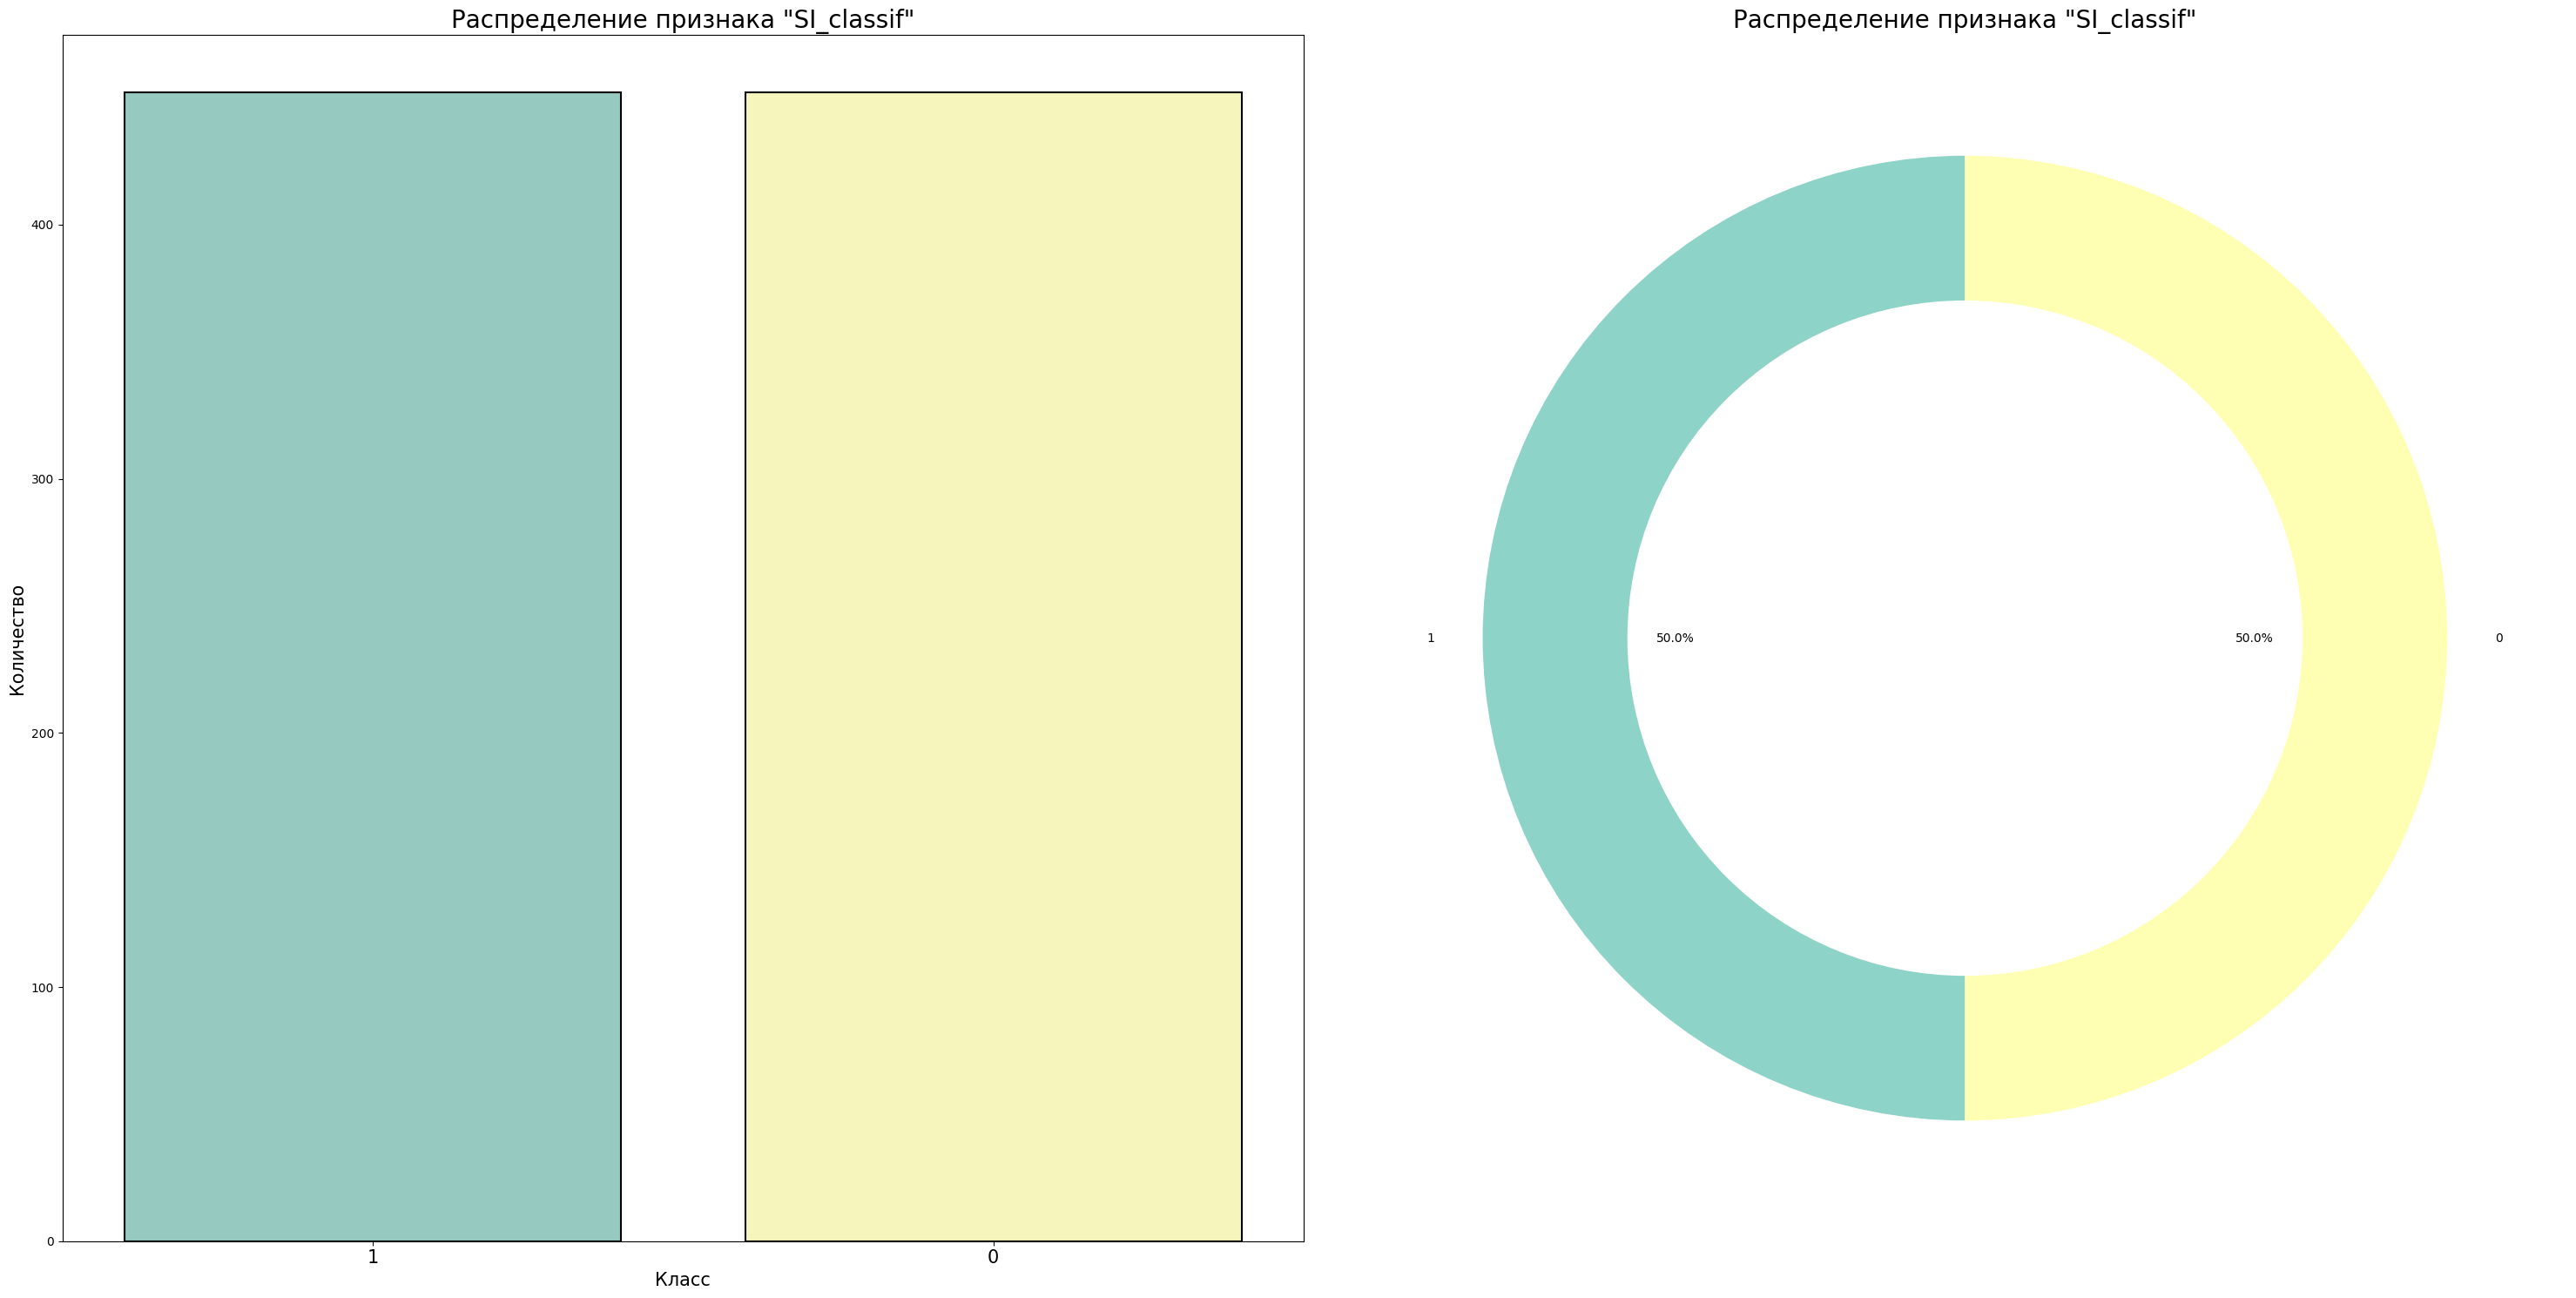

------------------------------------------------------------------------------------------------------------------------------------------------------


Распределение целевой переменной "log_SI"
------------------------------------------------------------------------------------------------------------------------------------------------------


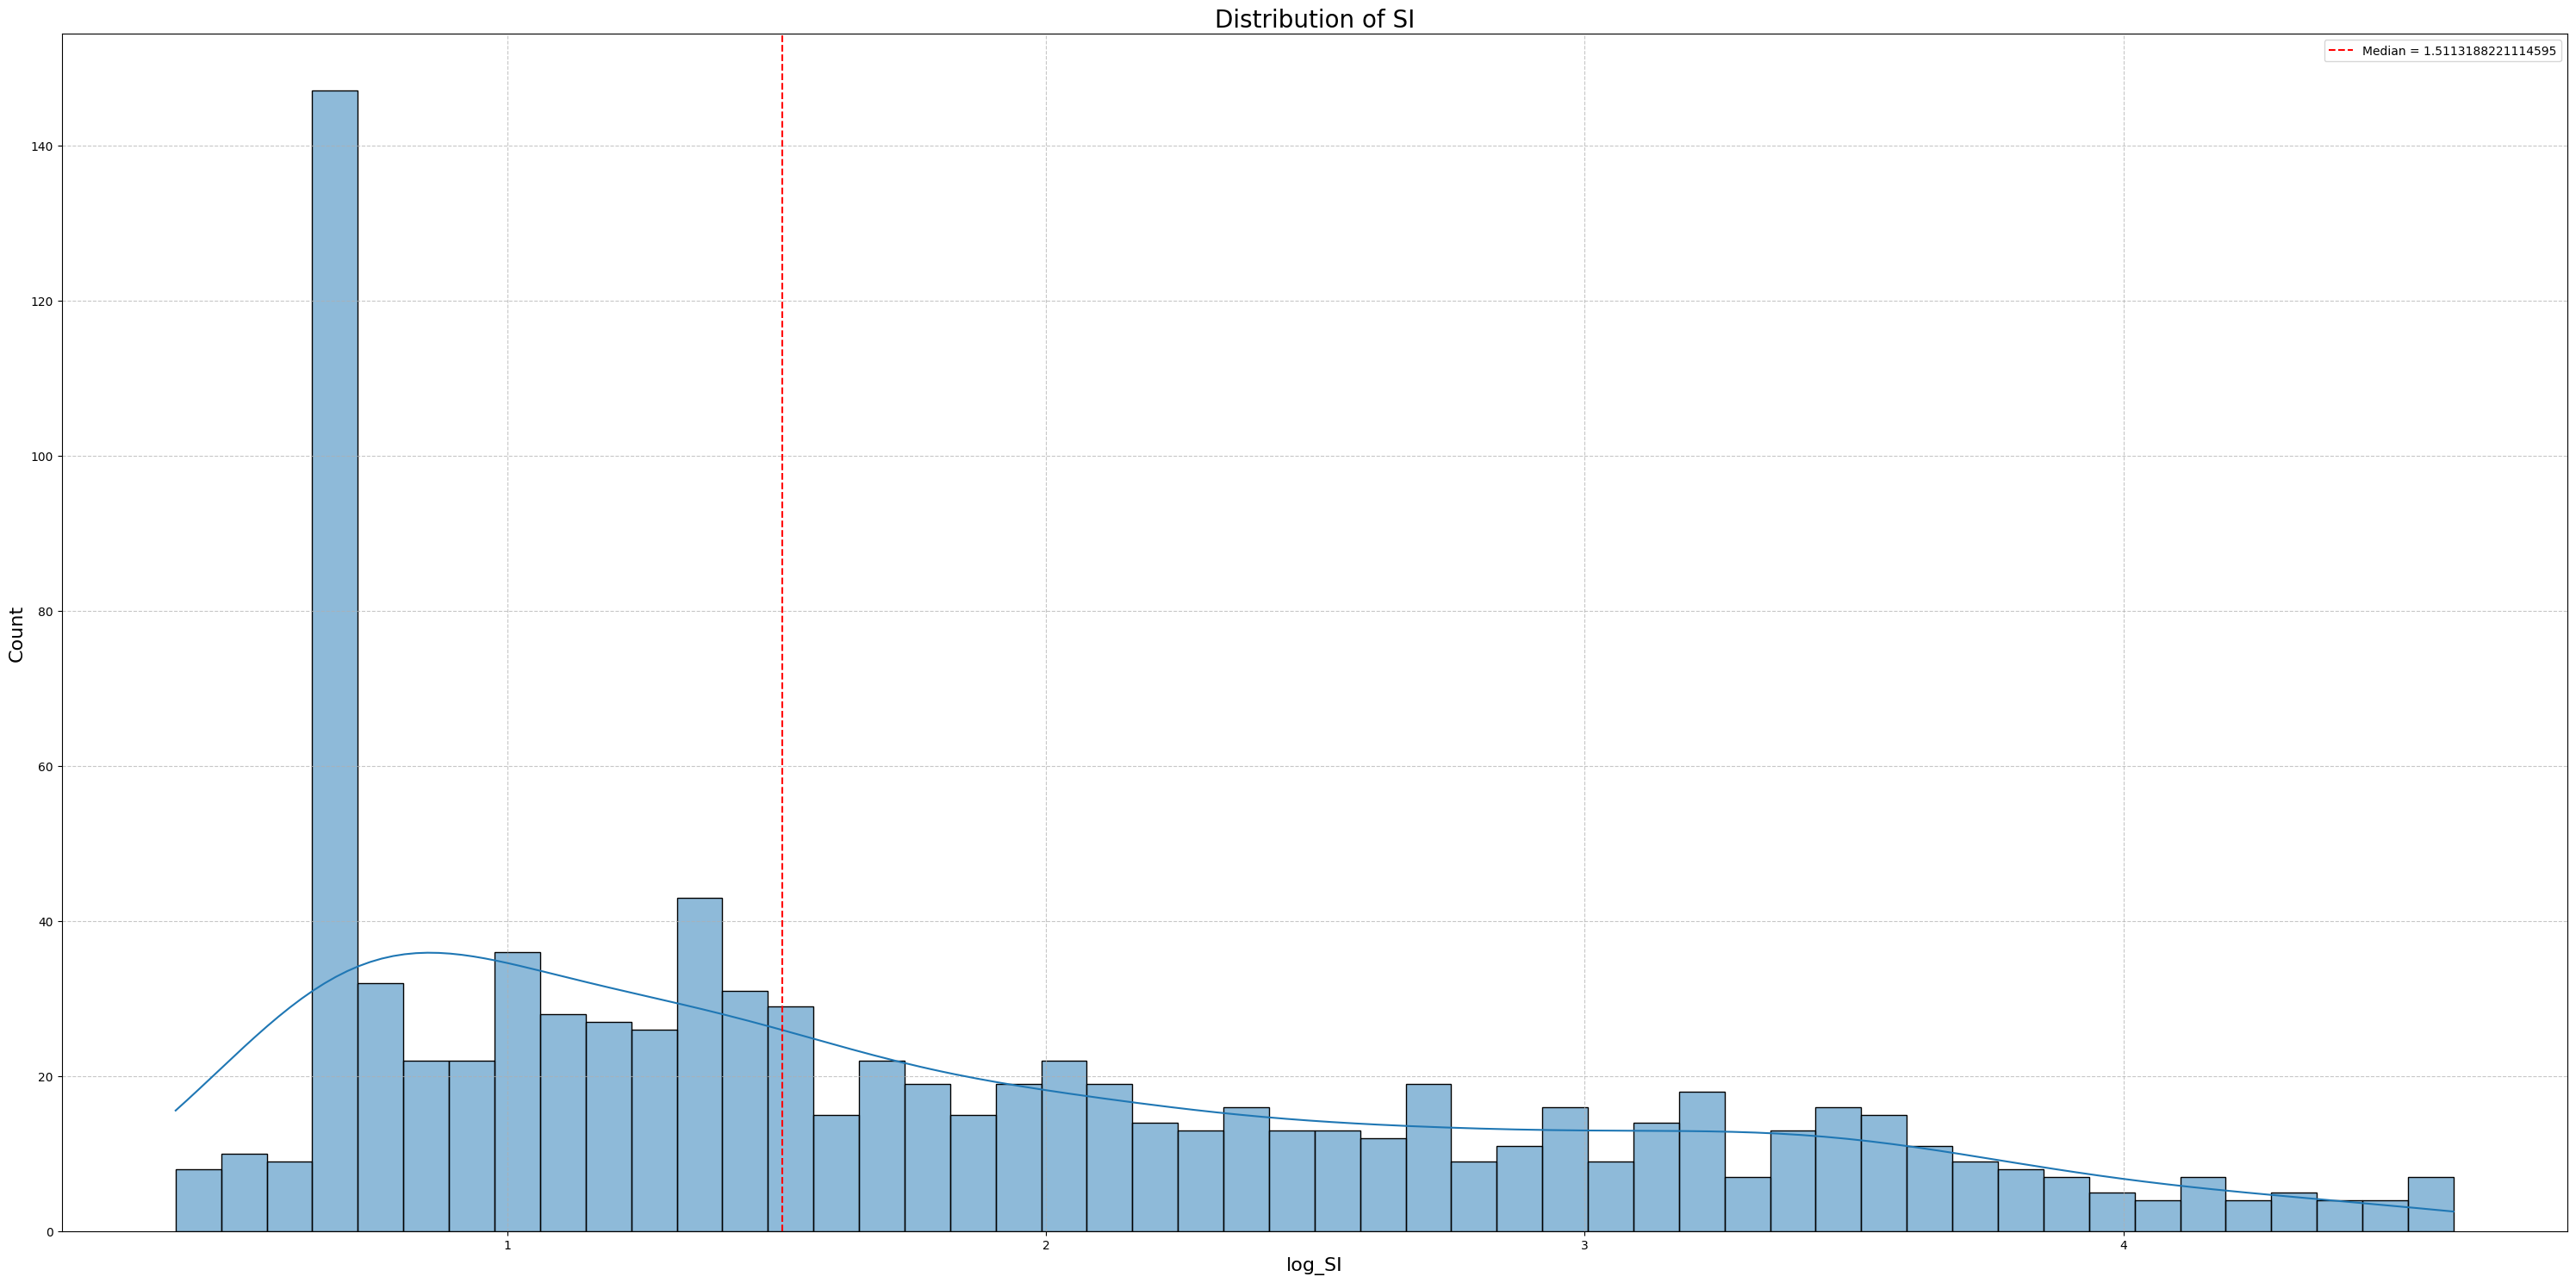

------------------------------------------------------------------------------------------------------------------------------------------------------


In [33]:
# Вычисляем медиану SI
median_si = molecule_df['log_SI'].median()
print(f'\nМедианное значение SI: {median_si}')
print('-' * 45)
print('\n\n')


# Создаем целевую переменную (1 - превышает, 0 - не превышает)
molecule_df['SI_classif'] = (molecule_df['log_SI'] > median_si).astype(int)
print('Уникальные значения признака "SI_classif":\n')
display(molecule_df['SI_classif'].value_counts())
print('-' * 45)




# Применяем функцию 'median_target_distribution_plot()' для построения графика распределения целевой переменной
median_target_distribution_plot(
    target = molecule_df['SI_classif'],
    title1 = 'Распределение признака "SI_classif"',
    main_title = 'Стобчатая и круговая диаграммы распределения целевой переменной "SI_classif":',
    color_palette = 'Set3',
    figsize = (30, 15)
)

# Применяем функцию 'target_distribution_plot()' для построения графика распределения целевой переменной
target_distribution_plot(
    data = molecule_df,
    target = 'log_SI',
    median_target = median_si,
    title = 'Distribution of SI',
    main_title = 'Распределение целевой переменной "log_SI"',
    figsize = (30, 15)
)

**Вывод:**

Как видно по графику, распределение целевой переменной - равномерное, следовательно балансировка не требуется.

**Разделение данных.**

Разделим данные на тматрицу наблюдений и вектор правильных ответов:

In [ ]:
# Разделяем данные на матрицу наблюдений и вектор правильных ответов
X = molecule_df.drop(columns = ['IC50, mM', 'CC50, mM', 'SI', 'log_IC50, mM', 'log_CC50, mM', 'log_SI', 'IC50_classif', 'CC50_classif', 'SI_classif'])
y = molecule_df['SI_classif']

Применим созданный ранее класс к данным:

In [35]:
# Создаём экземпляра класса 'DataPreprocessor'
DP_processor = DataPreprocessor(preprocessing_pipeline)

# Обработка данных
DP_processor.fit_transform(X, y)

# Получение обработанных данных
X_train_processed_df, X_test_processed_df, y_train, y_test, remaining_features = DP_processor.get_processed_data()


Данные таблицы "Molecular properties features" имеют следующую размерность:

Количество строк: 723;
Количество признаков (столбцов): 3.
----------------------------------------
------------------------------------------------------------




Данные таблицы "Functional groups features" имеют следующую размерность:

Количество строк: 723;
Количество признаков (столбцов): 8.
----------------------------------------
------------------------------------------------------------------------------------------




Данные таблицы "Topological descriptors features" имеют следующую размерность:

Количество строк: 723;
Количество признаков (столбцов): 4.
----------------------------------------
--------------------------------------------------------------------------------




Данные таблицы "Transformations features" имеют следующую размерность:

Количество строк: 723;
Количество признаков (столбцов): 3.
----------------------------------------
---------------------------------------------------

Выводим результат:

In [36]:
# Информация по тренеровочной выборке
check_data_inf(
    data = X_train_processed_df,
    data_name = 'X_train_processed_df',
    length1 = 40,
    length2 = 150
)
print('\n\n\n')


# Информация по тестовой выборке
check_data_inf(
    data = X_test_processed_df,
    data_name = 'X_test_processed_df',
    length1 = 40,
    length2 = 150
)
print('\n\n\n')


# Информация по оставшимся признакам
print(f'Оставшиеся признаки:\n\n{remaining_features.tolist()}')
print('-' * 150)


Данные таблицы "X_train_processed_df" имеют следующую размерность:

Количество строк: 723;
Количество признаков (столбцов): 103.
----------------------------------------


MaxAbsEStateIndex  MinAbsEStateIndex  MinEStateIndex       qed       SPS  \
0            -1.496602           0.422613        0.771519  0.579771 -0.081941   
1             0.527403           0.904784       -0.394927  0.514586 -0.554818   
2             0.252959          -0.894628        0.392277  0.397569  0.511590   
3            -1.210453           0.216033        0.750903  0.746949  1.699045   
4             0.694610          -0.824197        0.472459  1.392750 -0.120265   
..                 ...                ...             ...       ...       ...   
718           0.251380           0.324610        0.428609 -0.563375 -0.001549   
719          -1.577604           1.146384        0.843749  0.769183  0.451116   
720           0.439661          -0.198519        0.198692  0.502574 -0.661393   
721           0.980138          -0.326590       -0.499596 -0.363831 -1.475648   
722          -1.635707           1.283362        0.857418  0.748480  0.731976   

        MolWt  FpDensityMorgan1  BCUT2D_MWHI  BCUT2D_MWLOW  BCUT2D_CHGHI  ...  \
0   -0.172284         -0.720975    -0.482466     -0.231601      0.709602  ...   
1   -0.694608         -0.970049    -0.465835      0.425592      0.670103  ...   
2   -0.034503          1.347721     0.555049     -0.313054      0.077316  ...   
3   -1.145565         -0.554926    -0.589790     -0.967502      0.838770  ...   
4   -0.264281          0.954612     0.555048     -0.403346     -0.483621  ...   
..        ...               ...          ...           ...           ...  ...   
718 -0.241286          0.655849    -0.479027     -0.231089      0.700544  ...   
719 -0.010688          0.083725    -0.482669     -0.749877      0.230117  ...   
720  0.463493         -0.416552     0.557248      0.434471     -0.335264  ...   
721  0.285924         -0.703184    -0.304289      0.607120     -1.303146  ...   
722 -0.601279          0.482881    -0.482670     -0.231261      0.699655  ...   

     fr_quatN  fr_sulfide  fr_thiazole  fr_thiophene  fr_unbrch_alkane  \
0   -0.174679   -0.210093    -0.266667     -0.303554         -0.177731   
1   -0.174679   -0.210093    -0.266667     -0.303554         -0.177731   
2   -0.174679   -0.210093    -0.266667      3.294307         -0.177731   
3   -0.174679   -0.210093    -0.266667     -0.303554         -0.177731   
4   -0.174679   -0.210093     3.750000     -0.303554         -0.177731   
..        ...         ...          ...           ...               ...   
718 -0.174679   -0.210093    -0.266667     -0.303554         -0.177731   
719 -0.174679   -0.210093    -0.266667     -0.303554         -0.177731   
720 -0.174679    3.494726    -0.266667     -0.303554         -0.177731   
721 -0.174679   -0.210093    -0.266667     -0.303554         -0.177731   
722 -0.174679   -0.210093    -0.266667     -0.303554         -0.177731   

     MolWt_per_Heteroatoms  TPSA_per_MolLogP  fr_Al_OH_per_benzene  \
0                -0.064531         -0.017568             -0.338656   
1                -0.064565          0.133615             -0.338656   
2                -0.064578          0.146636             -0.338656   
3                -0.064458         -0.019390             -0.338656   
4                -0.064567          0.009951             -0.338656   
..                     ...               ...                   ...   
718              -0.064533         -0.010548             -0.338656   
719              -0.064481         -0.085575             -0.338656   
720              -0.064571          0.086950             -0.338656   
721              -0.064583          0.134657             -0.338656   
722              -0.064545         -0.013565             -0.338656   

     SMR_VSA_ratio  TPSA_times_FractionCSP3  
0        -0.806000                -0.332149  
1        -0.806000                -0.857136  
2         0.736551                 1.215385  
3        -0.806000                -0.065901  
4         0.207477                -0.043975  
..             ...                      ...  
718    

------------------------------------------------------------------------------------------------------------------------------------------------------





Данные таблицы "X_test_processed_df" имеют следующую размерность:

Количество строк: 181;
Количество признаков (столбцов): 103.
----------------------------------------


MaxAbsEStateIndex  MinAbsEStateIndex  MinEStateIndex       qed       SPS  \
0             0.160756          -0.510352       -0.302029 -0.353559 -1.315644   
1             0.552605          -0.468304       -2.184035 -1.056662 -1.369489   
2            -0.045459          -1.061101        0.108325  0.426638  0.811860   
3             0.464136           0.524951       -1.212053 -1.368374 -0.291834   
4            -1.720945           1.330435        0.862116 -1.065667  0.899075   
..                 ...                ...             ...       ...       ...   
176          -1.488398           1.708016        0.899797  0.058433  1.462212   
177           0.562094           0.446785        0.434776  0.703003 -1.149026   
178           0.417928           0.379878        0.409685 -0.011909 -1.476949   
179           0.044589          -0.244271        0.028994  1.031010  0.347881   
180          -1.734335           1.301008        0.859179  0.439095  0.456709   

        MolWt  FpDensityMorgan1  BCUT2D_MWHI  BCUT2D_MWLOW  BCUT2D_CHGHI  ...  \
0   -0.863532          1.780140     0.559264      2.296748     -1.732256  ...   
1   -0.089109          0.528003     0.552297      1.154219     -0.893501  ...   
2   -0.471906          1.224172    -0.471246     -0.265352      0.017607  ...   
3    0.854706          0.353155     0.492597     -0.231089      0.701536  ...   
4    0.426860         -2.215418    -0.592477     -0.231368      0.760929  ...   
..        ...               ...          ...           ...           ...  ...   
176 -1.667184          0.690443    -0.603011      0.127272     -0.483112  ...   
177 -0.103926         -0.554926    -0.504065      0.884829     -1.319795  ...   
178 -0.073419         -0.395263    -0.482662      1.260989     -2.026415  ...   
179  0.057249         -0.075938    -0.478956     -0.226828      0.099772  ...   
180 -0.700635          0.319017    -0.559207     -0.231174      0.702776  ...   

     fr_quatN  fr_sulfide  fr_thiazole  fr_thiophene  fr_unbrch_alkane  \
0   -0.174679   -0.210093    -0.266667     -0.303554         -0.177731   
1   -0.174679   -0.210093    -0.266667     -0.303554         -0.177731   
2   -0.174679   -0.210093    -0.266667     -0.303554         -0.177731   
3   -0.174679   -0.210093    -0.266667     -0.303554          0.788429   
4   -0.174679   -0.210093    -0.266667     -0.303554          4.653068   
..        ...         ...          ...           ...               ...   
176 -0.174679   -0.210093    -0.266667     -0.303554         -0.177731   
177 -0.174679   -0.210093    -0.266667     -0.303554         -0.177731   
178 -0.174679   -0.210093    -0.266667     -0.303554         -0.177731   
179 -0.174679   -0.210093    -0.266667     -0.303554         -0.177731   
180  3.539809   -0.210093    -0.266667     -0.303554         -0.177731   

     MolWt_per_Heteroatoms  TPSA_per_MolLogP  fr_Al_OH_per_benzene  \
0                -0.064599         -1.198955             -0.338656   
1                -0.064590          0.128426             -0.338656   
2                -0.064578          0.213022              1.475033   
3                -0.064576          0.094904             -0.338656   
4                -0.064459         -0.076881             -0.338656   
..                     ...               ...                   ...   
176              -0.064510          0.065149             -0.338656   
177              -0.064572          0.100585             -0.338656   
178              -0.064572          0.099420             -0.338656   
179              -0.064570          0.247098             -0.338656   
180              -0.064515         -0.074934             -0.338656   

     SMR_VSA_ratio  TPSA_times_FractionCSP3  
0         0.168554                -0.016665  
1         1.068112                -0.717143  
2         1.241226                 1.433804  
3         1.152177                 1.983047  
4        -0.806000                -0.190647  
..             ...                      ...  
176    

------------------------------------------------------------------------------------------------------------------------------------------------------




Оставшиеся признаки:

['MaxAbsEStateIndex', 'MinAbsEStateIndex', 'MinEStateIndex', 'qed', 'SPS', 'MolWt', 'FpDensityMorgan1', 'BCUT2D_MWHI', 'BCUT2D_MWLOW', 'BCUT2D_CHGHI', 'BCUT2D_CHGLO', 'BCUT2D_MRLOW', 'AvgIpc', 'BalabanJ', 'Ipc', 'PEOE_VSA1', 'PEOE_VSA10', 'PEOE_VSA11', 'PEOE_VSA12', 'PEOE_VSA13', 'PEOE_VSA14', 'PEOE_VSA2', 'PEOE_VSA3', 'PEOE_VSA4', 'PEOE_VSA5', 'PEOE_VSA6', 'PEOE_VSA7', 'PEOE_VSA8', 'PEOE_VSA9', 'SMR_VSA10', 'SMR_VSA2', 'SMR_VSA3', 'SMR_VSA4', 'SMR_VSA5', 'SMR_VSA6', 'SMR_VSA9', 'SlogP_VSA1', 'SlogP_VSA12', 'SlogP_VSA2', 'SlogP_VSA3', 'SlogP_VSA7', 'SlogP_VSA8', 'EState_VSA11', 'EState_VSA2', 'EState_VSA3', 'EState_VSA4', 'EState_VSA5', 'EState_VSA6', 'EState_VSA7', 'EState_VSA8', 'EState_VSA9', 'VSA_EState1', 'VSA_EState2', 'VSA_EState4', 'VSA_EState5', 'VSA_EState7', 'VSA_EState8', 'VSA_EState9', 'NumAliphatic

По результатам видно, что данные, после применения класса, имеют схожую структуру, что и при прошлой предобработки.

Проверим распределение признаков при помощи визуализации:


График распределения признаков:
------------------------------------------------------------------------------------------------------------------------------------------------------


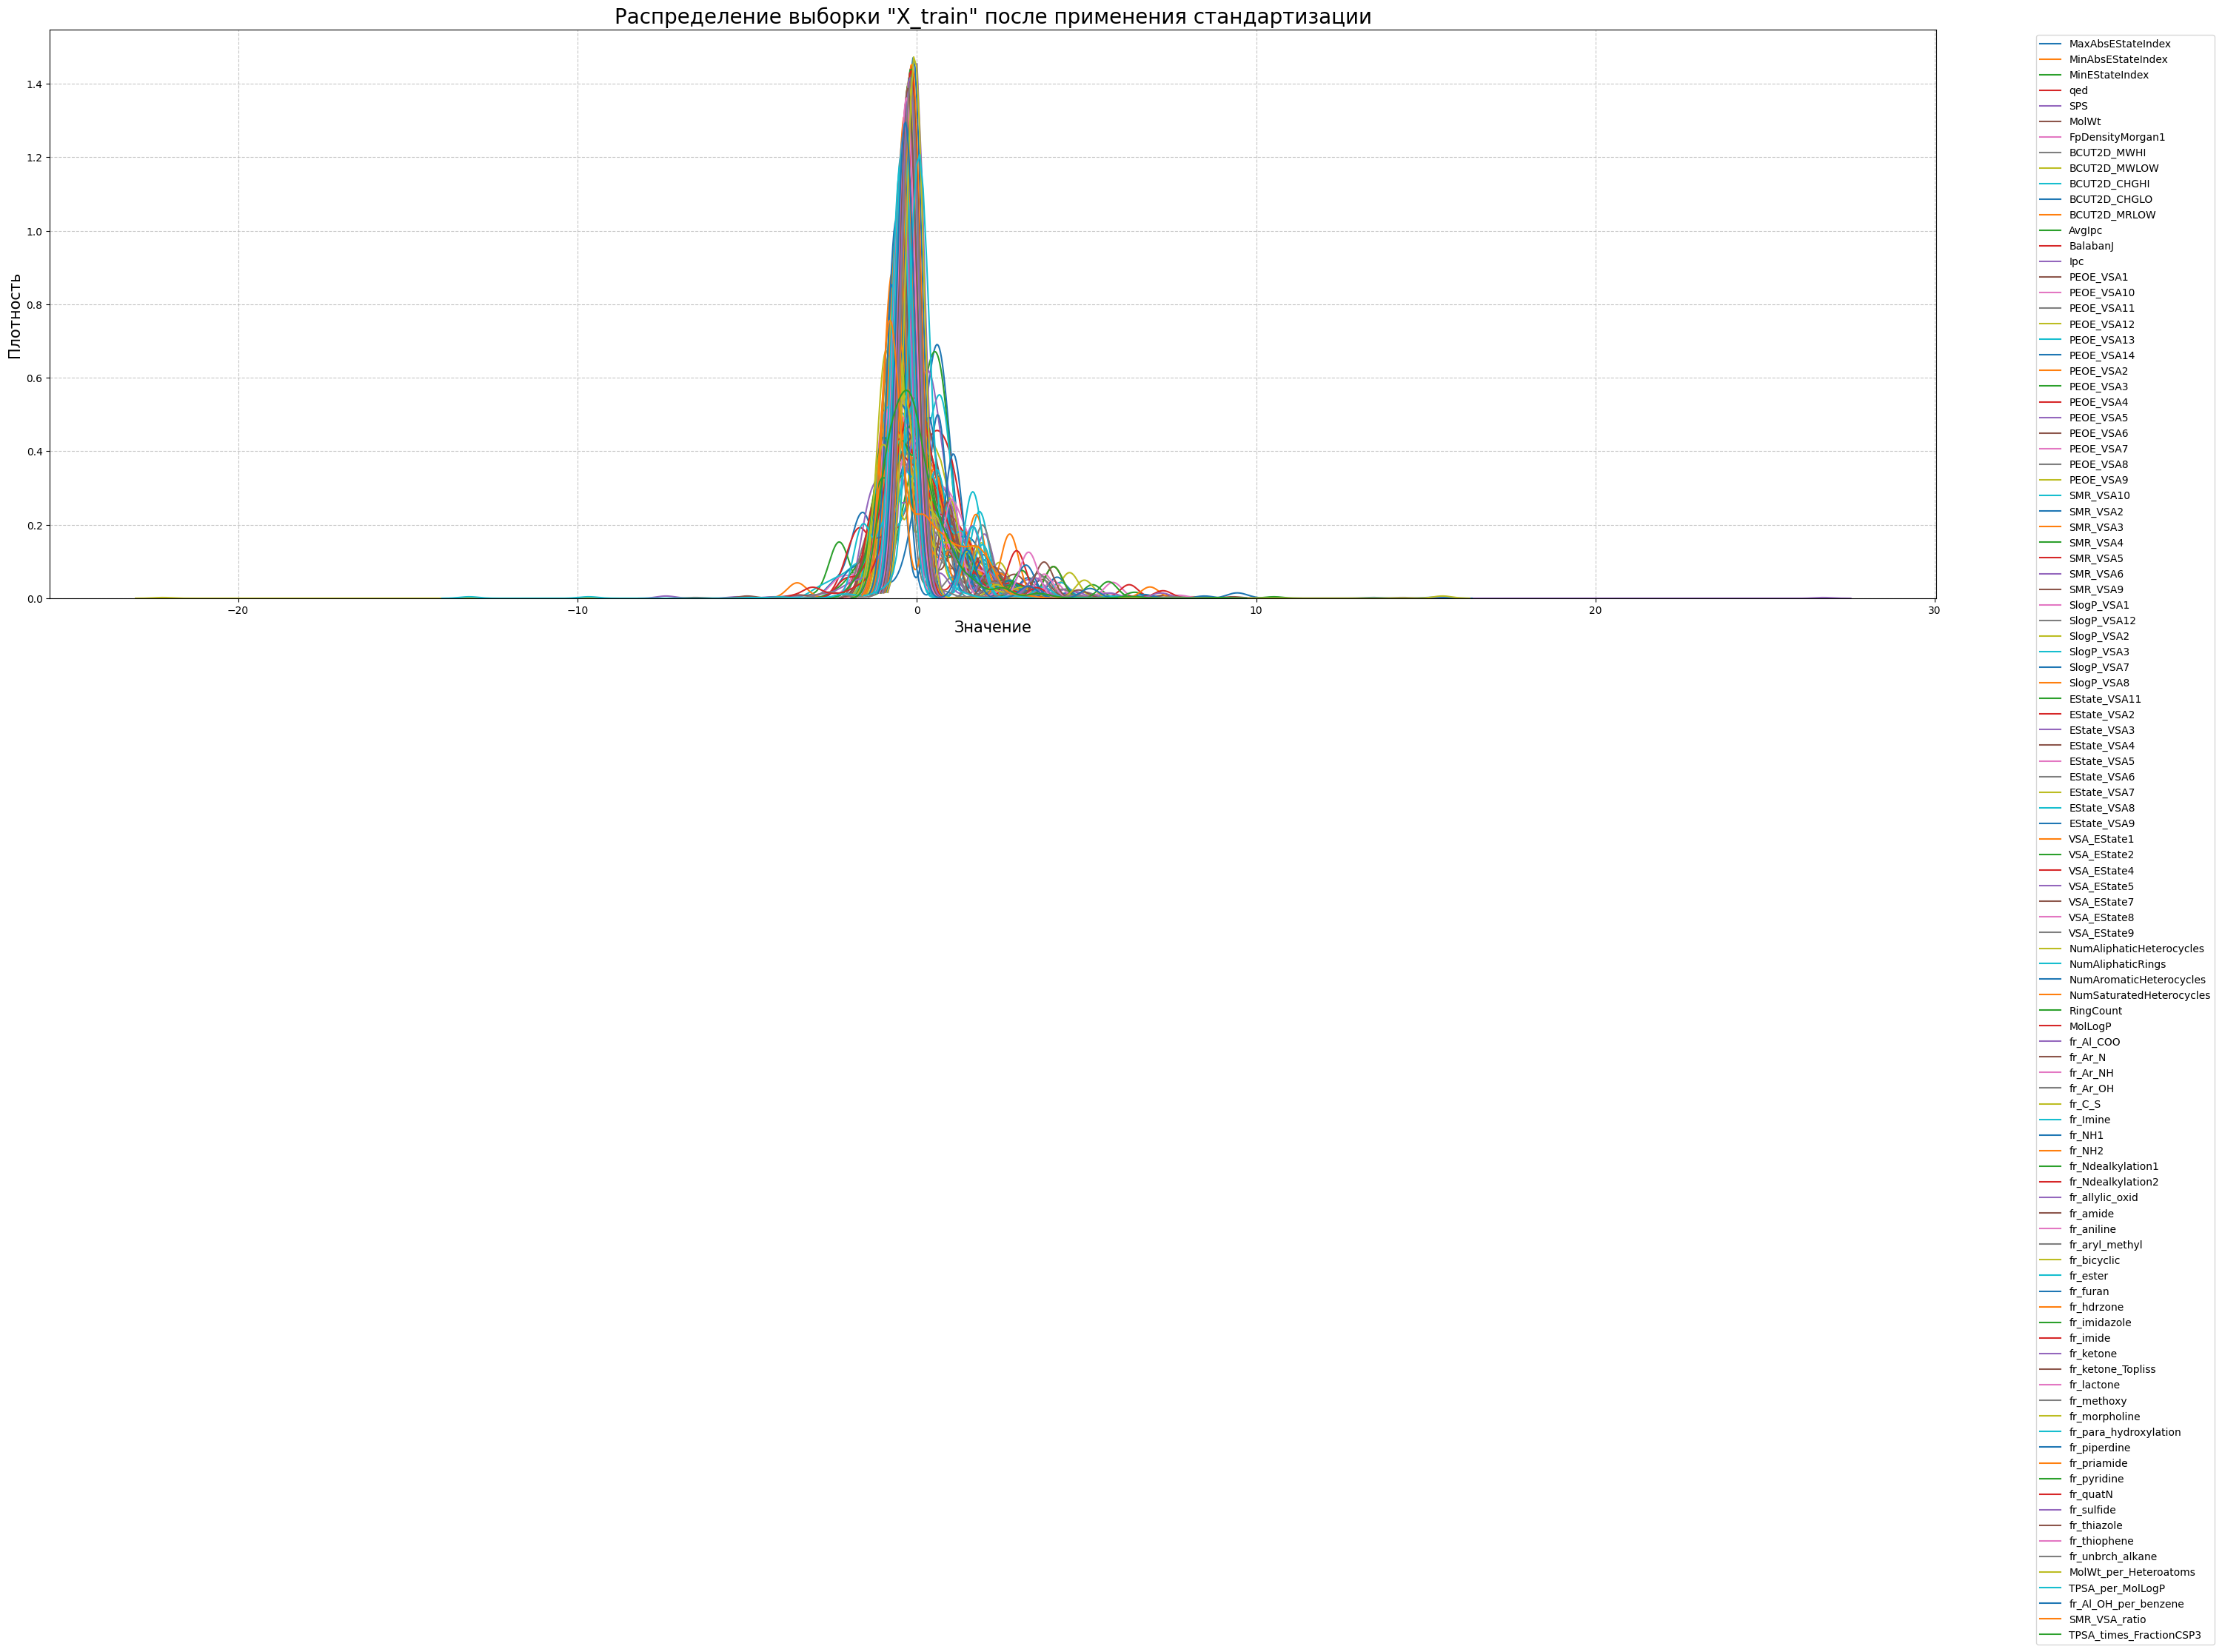

------------------------------------------------------------------------------------------------------------------------------------------------------



График распределения признаков:
------------------------------------------------------------------------------------------------------------------------------------------------------


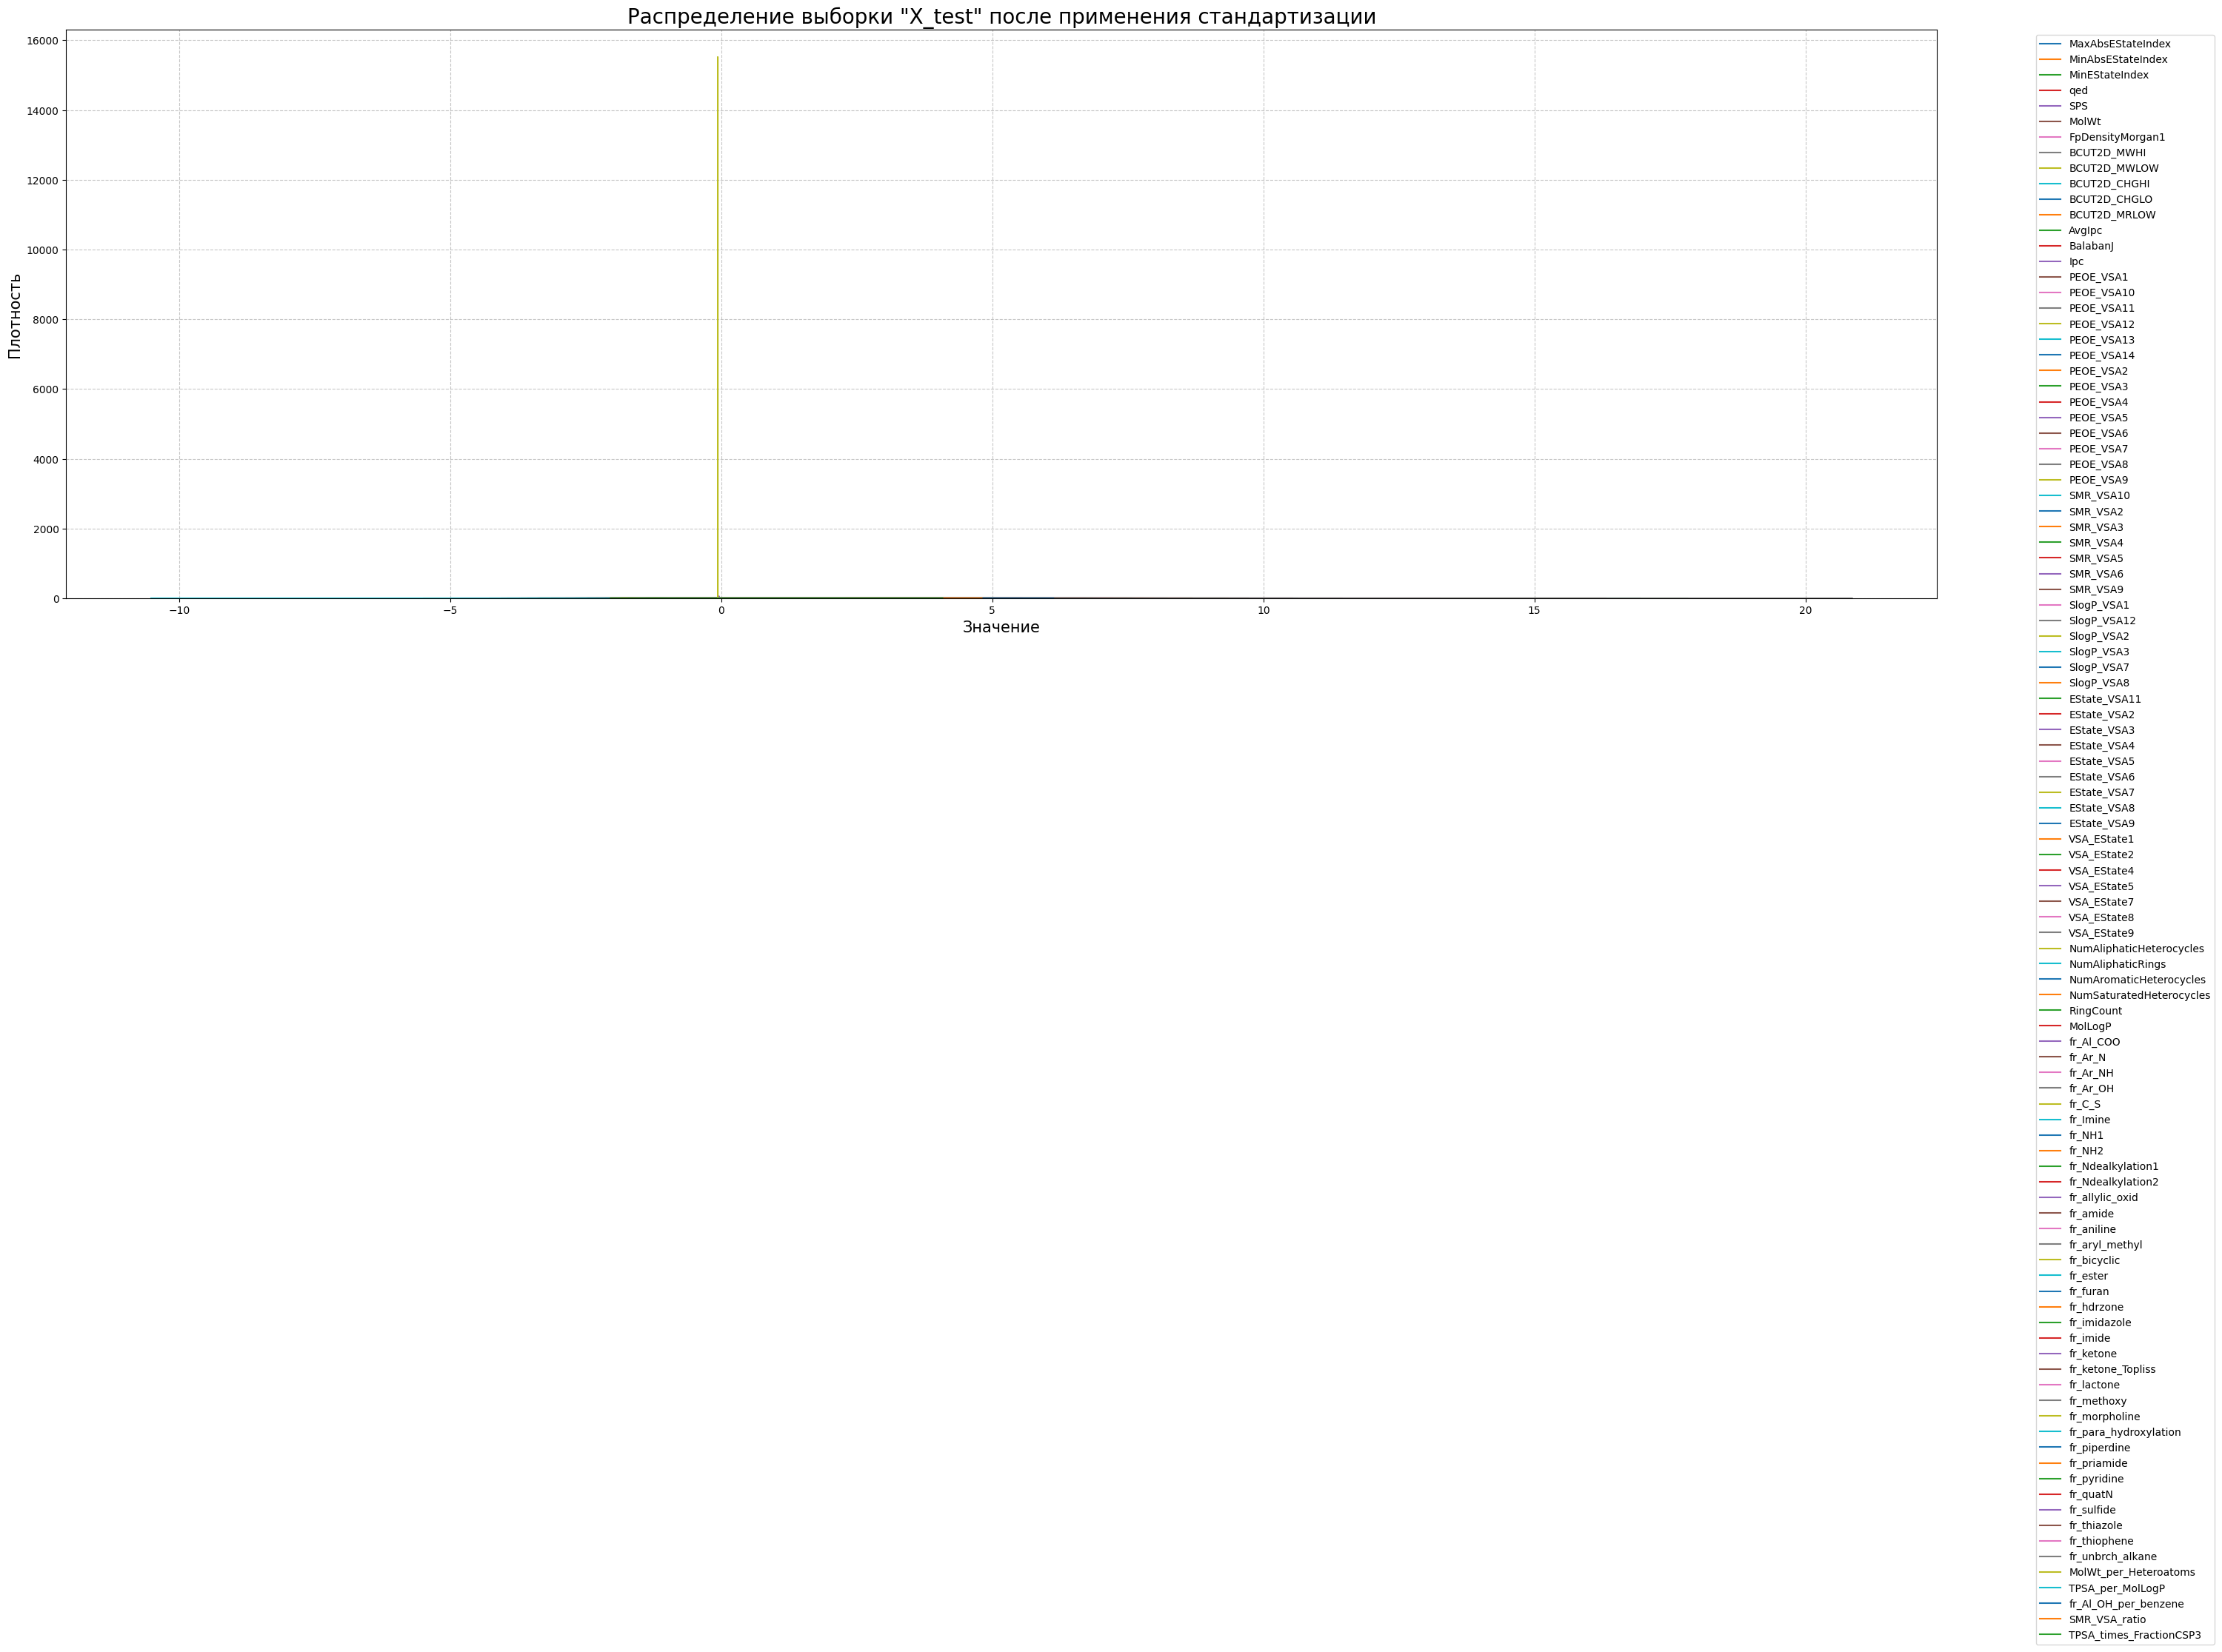

------------------------------------------------------------------------------------------------------------------------------------------------------


In [37]:
# Применяем функцию 'features_distribution_plot()' для построения графика распределения признаков X_train
print()
features_distribution_plot(
    data = X_train_processed_df,
    title = 'Распределение выборки "X_train" после применения стандартизации',
    figsize = (30, 17)
)

# Добавляем отступ
print('\n\n')



# Применяем функцию 'features_distribution_plot()' для построения графика распределения признаков X_test
features_distribution_plot(
    data = X_test_processed_df,
    title = 'Распределение выборки "X_test" после применения стандартизации',
    figsize = (30, 17)
)

**Вывод:**

Распределение признаков также нормализовалось.

#### $3.2$

#### **Отбор самых информативных признаков.**

На данном этапе отберём только самые информативные признаки для дальнейшего решения задачи регрессии.

Производить отбор признаков будем так же, как и для `CC50`, в $4$ этапа:

1. Отберём $50$ признаков с помощью алгоритма **Mutual Information**,
2. Отберём $50$ признаков с помощью алгоритма **F-test**,
3. Отберём $50$ признаков из отобранных обоими алгоритмами,
4. Из оставшихся отберём $30$ признаков с помощью алгоритма **Lasso**.

Только сейчас, все этапы обернём в класс, чтобы использовать его в будущем.

Применим созданный ранее класс `FeatureSelector` к данным:

In [40]:
# Инициализируем класс 'FeatureSelector'         
feature_selector = FeatureSelector(
    mi_k = 50,
    f_k = 50,
    log_max_features = 30,
    penalty = 'l1',
    solver = 'liblinear',
    C = 1.0
)

# Обучаем класс на данных
feature_selector.fit_transform(X_train_processed_df, X_test_processed_df, y_train)

# Получение обработанных данных
X_train_final, X_test_final, final_features = feature_selector.get_final_data()

# Выводим результат
feature_selector.print_results()


Топ-30 финальных признаков после "LogisticRegression"

NumSaturatedHeterocycles    0.666825
SMR_VSA6                    0.537944
SPS                         0.532679
EState_VSA8                 0.332549
PEOE_VSA9                   0.328886
BCUT2D_CHGLO                0.287036
VSA_EState1                 0.270977
SlogP_VSA2                  0.270663
fr_NH2                      0.266540
PEOE_VSA7                   0.241119
EState_VSA9                 0.220171
BCUT2D_MWLOW                0.196075
SMR_VSA4                    0.192912
BalabanJ                    0.186072
SMR_VSA_ratio               0.175453
MinEStateIndex              0.173425
PEOE_VSA8                   0.162445
BCUT2D_MWHI                 0.159702
VSA_EState7                 0.156644
AvgIpc                      0.156070
VSA_EState8                 0.151664
FpDensityMorgan1            0.150474
TPSA_per_MolLogP            0.147798
PEOE_VSA6                   0.141528
VSA_EState9                 0.135228
SMR_VSA5           

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Выведем информацию итоговых выборок:

In [ ]:
# Информация по тренеровочной выборке
check_data_inf(
    data = X_train_final,
    data_name = 'X_train_final',
    length1 = 40,
    length2 = 150
)
print('\n\n\n')


# Информация по тестовой выборке
check_data_inf(
    data = X_test_final,
    data_name = 'X_test_final',
    length1 = 40,
    length2 = 150
)


Данные таблицы "X_train_final" имеют следующую размерность:

Количество строк: 723;
Количество признаков (столбцов): 30.
----------------------------------------


SPS  NumSaturatedHeterocycles  SMR_VSA5  SMR_VSA_ratio  EState_VSA8  \
0   -0.081941                 -0.725093 -0.054649      -0.806000     0.006955   
1   -0.554818                 -0.725093 -0.966737      -0.806000    -1.034783   
2    0.511590                  0.508418  0.752115       0.736551    -0.073639   
3    1.699045                 -0.725093  0.756481      -0.806000    -0.340291   
4   -0.120265                 -0.725093  0.149113       0.207477     0.523568   
..        ...                       ...       ...            ...          ...   
718 -0.001549                 -0.725093 -0.054649       0.211154     0.006955   
719  0.451116                  0.508418  0.983472      -0.300500     1.512684   
720 -0.661393                  0.508418 -0.795632      -0.806000     0.753101   
721 -1.475648                 -0.725093 -1.391050      -0.806000    -0.797215   
722  0.731976                  0.508418  0.159691      -0.300500     0.252700   

     PEOE_VSA8    AvgIpc  fr_thiophene  BCUT2D_MWLOW  VSA_EState1  ...  \
0    -0.021284  0.164660     -0.303554     -0.231601    -0.510177  ...   
1    -1.513317  0.122907     -0.303554      0.425592    -0.228040  ...   
2     1.658586  0.230686      3.294307     -0.313054    -0.483553  ...   
3    -1.021808 -1.556033     -0.303554     -0.967502    -0.823985  ...   
4    -0.932554 -0.219276     -0.303554     -0.403346    -0.068435  ...   
..         ...       ...           ...           ...          ...  ...   
718   0.013202  0.137664     -0.303554     -0.231089    -0.542370  ...   
719   0.228973 -0.530440     -0.303554     -0.749877    -0.524807  ...   
720  -0.943551  1.160541     -0.303554      0.434471    -0.541832  ...   
721  -1.019632 -0.312350     -0.303554      0.607120     2.477075  ...   
722   1.797087 -0.164854     -0.303554     -0.231261    -0.535301  ...   

     BCUT2D_CHGLO  BalabanJ  PEOE_VSA6  PEOE_VSA7  SMR_VSA6  SlogP_VSA2  \
0        0.065107 -0.654310  -0.283280   1.628333 -0.501151   -1.133018   
1        0.892106  0.358409  -0.116601  -0.504015 -0.852100   -0.889025   
2       -0.995268  0.156603  -0.096764  -0.457205 -0.852100   -0.456006   
3       -1.885697  0.473720  -0.613549   1.143588 -0.852100   -1.139996   
4       -0.577835 -0.202214   0.257495   0.270976 -0.126073   -0.445268   
..            ...       ...        ...        ...       ...         ...   
718      0.062237 -0.761391   1.163576   0.004357 -0.047108   -0.360715   
719     -1.290042 -0.409259   1.221381   1.008224  1.158479    0.160940   
720      0.536522 -0.633789   1.040884   0.428075 -0.416920    0.023722   
721      1.400336  1.437318  -1.274086  -0.786662  0.453440   -0.261109   
722      0.055864 -0.701628  -0.283280  -0.225370  1.559074    0.655983   

     EState_VSA3  EState_VSA9  VSA_EState9   MolLogP  
0      -0.791905     0.703425    -0.375368  1.146289  
1       0.381094     0.042850    -0.375368 -0.438833  
2       0.092873    -0.479599    -0.375368  0.134020  
3      -0.791905    -0.369657    -0.375368 -0.093992  
4      -1.164993    -1.002048    -0.375368  0.418298  
..           ...          ...          ...       ...  
718     0.114232     0.071034    -0.375368  0.467729  
719    -0.011078    -0.479599    -0.375368  0.759028  
720    -0.722604     0.083057     0.585089  0.363998  
721    -0.350889     0.530036     1.857985  0.070264  
722    -0.418817     0.071034    -0.375368 -0.250479  

[723 rows x 30 columns]

------------------------------------------------------------------------------------------------------------------------------------------------------





Данные таблицы "X_test_final" имеют следующую размерность:

Количество строк: 181;
Количество признаков (столбцов): 30.
----------------------------------------


SPS  NumSaturatedHeterocycles  SMR_VSA5  SMR_VSA_ratio  EState_VSA8  \
0   -1.315644                 -0.725093 -1.218918       0.168554    -0.017680   
1   -1.369489                 -0.725093 -0.953746       1.068112     0.271268   
2    0.811860                  0.508418  0.523061       1.241226    -0.687537   
3   -0.291834                 -0.725093  1.275313       1.152177     0.524135   
4    0.899075                 -0.725093  2.567789      -0.806000     1.048692   
..        ...                       ...       ...            ...          ...   
176  1.462212                 -0.725093 -0.100876      -0.806000    -0.687537   
177 -1.149026                 -0.725093 -0.928795      -0.806000    -0.000715   
178 -1.476949                 -0.725093 -1.172573      -0.806000    -0.518169   
179  0.347881                  0.508418  0.298145      -0.806000    -1.034783   
180  0.456709                 -0.725093  0.407607      -0.327588     1.054908   

     PEOE_VSA8    AvgIpc  fr_thiophene  BCUT2D_MWLOW  VSA_EState1  ...  \
0    -0.958198 -0.523923     -0.303554      2.296748    -0.196948  ...   
1    -1.008634  0.279302     -0.303554      1.154219     1.861870  ...   
2    -0.418413  0.033512     -0.303554     -0.265352    -0.215910  ...   
3     0.054797  1.105525     -0.303554     -0.231089     0.821808  ...   
4     1.622910  0.816310     -0.303554     -0.231368    -0.823985  ...   
..         ...       ...           ...           ...          ...  ...   
176  -0.977181 -0.925508     -0.303554      0.127272    -0.823985  ...   
177  -0.481319  0.523212     -0.303554      0.884829    -0.754509  ...   
178  -1.513317  1.059089     -0.303554      1.260989    -0.135080  ...   
179  -0.418413 -0.510611     -0.303554     -0.226828     0.380878  ...   
180  -0.525967 -0.307701     -0.303554     -0.231174    -0.762200  ...   

     BCUT2D_CHGLO  BalabanJ  PEOE_VSA6  PEOE_VSA7  SMR_VSA6  SlogP_VSA2  \
0        2.808560  2.235256  -1.274086  -1.638111 -0.469194    0.259309   
1        1.717081  0.360574  -1.274086   0.323003 -0.526667   -0.514649   
2       -0.808107  0.018830  -0.637539  -0.457205 -0.852100   -0.485835   
3        0.061560 -1.083867  -0.034597   0.666848  1.138848    0.786383   
4        0.059434 -1.655280   1.932642   1.404096 -0.050911   -0.373630   
..            ...       ...        ...        ...       ...         ...   
176      0.675382  0.469819  -0.967807   0.079415 -0.852100   -1.119683   
177      1.409520 -0.366817   1.016894  -0.711178 -0.519996   -0.268689   
178      1.493611 -0.570250   0.172770  -0.252574 -0.122270   -0.472495   
179     -0.836497  0.394740  -0.984255   0.061704  0.453440    0.629610   
180      0.018460  0.495421  -0.283280   0.101554  1.181656    0.390094   

     EState_VSA3  EState_VSA9  VSA_EState9   MolLogP  
0      -0.853886    -1.002048    -1.252551 -2.374582  
1      -0.773137     0.345513    -0.375368 -0.118334  
2       0.082011     0.007587    -0.375368 -0.152599  
3       2.355336     1.068921    -2.119567  0.747654  
4       0.327360     0.099219    -0.375368  2.045792  
..           ...          ...          ...       ...  
176    -0.748715    -0.369657    -0.375368 -0.824418  
177     0.021690    -1.002048    -0.375368  0.253629  
178     0.150979     0.007587    -0.375368  0.201099  
179     0.908194     1.087747     2.387364 -0.426204  
180    -0.418817    -0.451414     1.013362  0.107197  

[181 rows x 30 columns]

------------------------------------------------------------------------------------------------------------------------------------------------------


**Построение визуализаций.**

Создадим функцию, для построения пузырьковых графиков отобранных признаков:


Топ-50 признаков по "Mutual Information":

BCUT2D_CHGHI                0.107559
SMR_VSA5                    0.099071
BCUT2D_CHGLO                0.095172
BCUT2D_MWLOW                0.084898
VSA_EState2                 0.081505
PEOE_VSA8                   0.076737
SlogP_VSA2                  0.076559
EState_VSA8                 0.075728
BCUT2D_MWHI                 0.074798
EState_VSA4                 0.074659
VSA_EState4                 0.074154
qed                         0.072352
BCUT2D_MRLOW                0.062848
SMR_VSA_ratio               0.062846
EState_VSA3                 0.060134
SMR_VSA10                   0.059163
MinEStateIndex              0.058219
MaxAbsEStateIndex           0.056799
PEOE_VSA7                   0.056284
VSA_EState9                 0.054405
EState_VSA2                 0.054146
PEOE_VSA10                  0.054104
VSA_EState8                 0.052987
TPSA_per_MolLogP            0.052521
MolWt_per_Heteroatoms       0.051689
VSA_EState5                 0.0

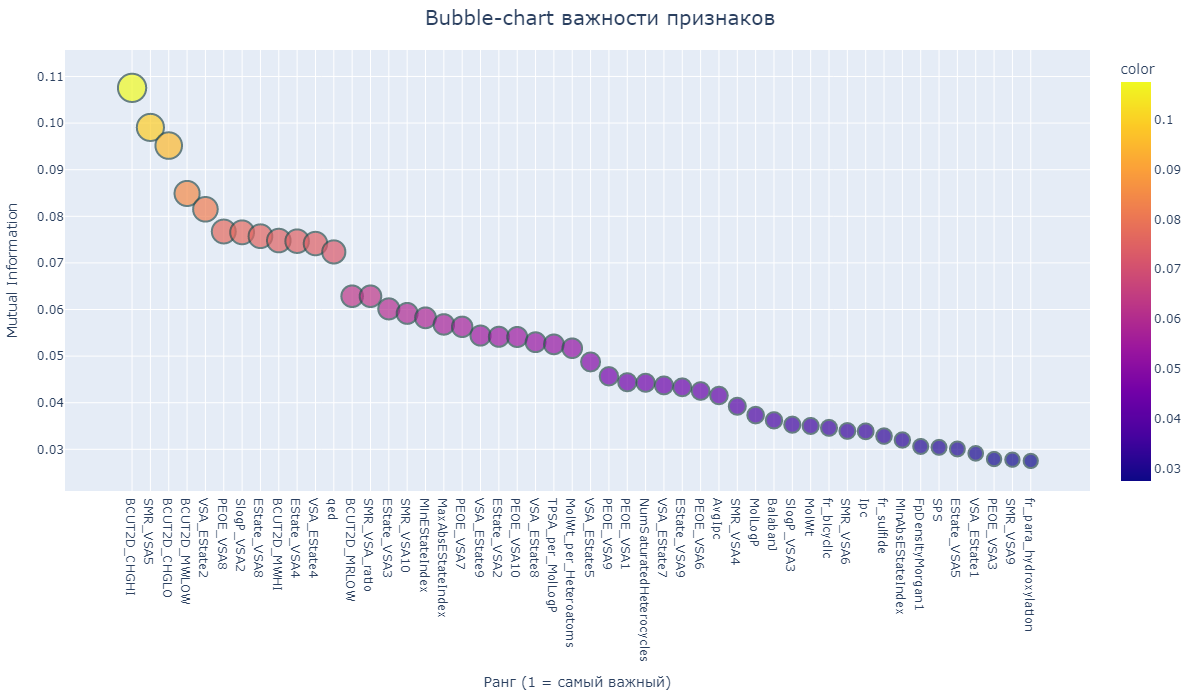

------------------------------------------------------------------------------------------------------------------------------------------------------


In [ ]:
# Выбираем первые 50 признаков
mi_features = feature_selector.mi_selected_features
mi_scores = feature_selector.mi_scores[mi_features].sort_values(ascending = False)
# Выводим результат
print(f'\nТоп-50 признаков по "Mutual Information":\n\n{feature_selector.mi_scores.head(50)}')
print('-' * 40)


fig = px.scatter(
    mi_scores.reset_index(),
    x = mi_scores.index,  # порядковый номер после сортировки
    y = mi_scores.values,
    size = mi_scores.values,
    color = mi_scores.values,
    hover_name = 'index',
    title = 'Bubble-chart важности признаков'
)

# Настройка осей и заголовков
fig.update_layout(
    height = 700,
    width = 1200,
    xaxis_title = 'Ранг (1 = самый важный)', 
    yaxis_title = 'Mutual Information'
)

# Настройка отображения точек
fig.update_traces(
    marker = dict(
        sizemode = 'area',
        opacity = 0.7,
        line = dict(width = 2, color = 'DarkSlateGrey')
    ),
    texttemplate = '%{hovertext}<br>MI: %{y:.4f}',
    textposition = 'top center'
)


# Настройка макета
fig.update_layout(
    title_x = 0.5,
    title_font_size = 20,
    margin = dict(t = 50, l = 25, r = 25, b = 25),
    legend_title = 'Метрика',
    yaxis = dict(tickformat = '.2f') 
)

# Отображение графика
fig.show('png')
print('-' * 150)

Проверим корреляцию отобранных признаков:


Тепловая карта корреляции отобранных признаков:
------------------------------------------------------------------------------------------------------------------------------------------------------


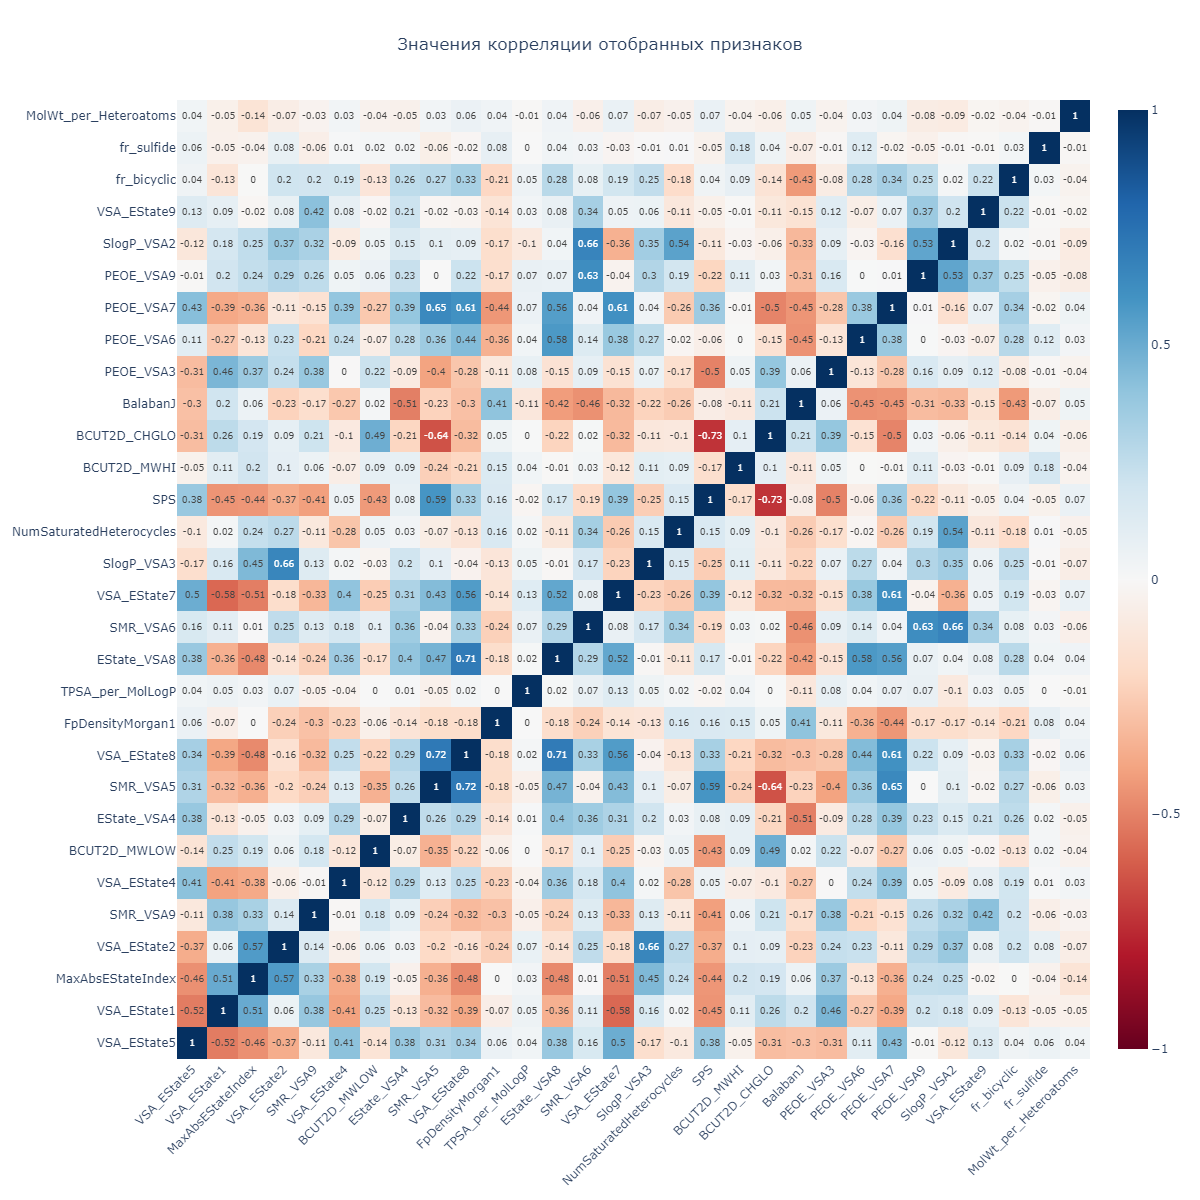

------------------------------------------------------------------------------------------------------------------------------------------------------


In [52]:
# Применяем функцию 'heatmap_corr()' для построения тепловой карты корреляции
heatmap_corr(data = X_train_final)

**Вывод:**

Из полученной тепловой карты видно, что значения корреляций находятся в пределах $+-0.79$, следовательно высококоррелированные связи отсутствуют. Данные полностью готовы к использованию для обучения модели.

#### $3.3$

#### **Machine Learning.**

Используем всё те же модели, что и для предсказания `IC50` и `CC50`: 

* **XGBoost (Extreme Gradient Boosting)**, 
* **LightGBM (Light Gradient Boosting Machine)**, 
* **Support Vector Machine (SVM) с ядром RBF**, 
* **RandomForestClassifier**, 
* **MLPClassifier**.

Используем созданный ранее словарь `ML_models`, после чего обучим модели и построим предсказания:

In [47]:
# Создаём словарь, в котором будем хранить наши предсказания
results = {}


# Создём цикл по созданному ранее словарю с моделями
# и обучаем их при помощи функции 'train_model'
for name, config in ML_models.items():
    
    # Заносим в словарь 'results' модели и метрики
    results[name] = train_model(
        name,
        config = config,
        X_train = X_train_final,
        X_test = X_test_final,
        y_train = y_train,
        y_test = y_test
    )




Обучение модели: XGBoost
Fitting 3 folds for each of 486 candidates, totalling 1458 fits
Лучшие параметры для XGBoost: {'colsample_bytree': 0.6, 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 50, 'scale_pos_weight': 1, 'subsample': 1.0}
--------------------------------------------------------------------------------




XGBoost (значения метрик):

Accuracy: 0.624
--------------------------------------------------------------------------------
Precision: 0.639
--------------------------------------------------------------------------------
Recall: 0.624
--------------------------------------------------------------------------------
F1-score: 0.618
--------------------------------------------------------------------------------

Classification report:

              precision    recall  f1-score   support

           0       0.59      0.76      0.66        88
           1       0.69      0.49      0.57        93

    accuracy                           0.62       181
   macro 

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



#### $3.4$

#### **Определяем лучшую модель.**

Составим таблицу (**DataFrame**) со следующими столбцами:

Наименование модели:

* `model_name`,

Метрики и их значения:

* `Accuracy`,

* `Precision`,

* `Recall`,

* `F1-score`.

In [132]:
# Создаём DataFrame
model_metrics = {
    'XGBClassifier'             : {'Accuracy': 0.624, 'Precision': 0.639, 'Recall': 0.624, 'F1-score': 0.618},
    'LGBMClassifier'            : {'Accuracy': 0.630, 'Precision': 0.631, 'Recall': 0.630, 'F1-score': 0.630},
    'RandomForestClassifier'    : {'Accuracy': 0.652, 'Precision': 0.657, 'Recall': 0.652, 'F1-score': 0.651},
    'SupportVectorClassifier'   : {'Accuracy': 0.657, 'Precision': 0.668, 'Recall': 0.657, 'F1-score': 0.654},
    'MLPClassifier'             : {'Accuracy': 0.663, 'Precision': 0.663, 'Recall': 0.663, 'F1-score': 0.663}
}

metrics_df = pd.DataFrame(model_metrics).T
metrics_df = metrics_df.reset_index().rename(columns = {'index': 'model_name'})

**Визуализация метрик.**

Теперь построим графики по каждой метрике, чтобы сравнить их друг с другом визуально.


Данные таблицы "metrics_df" имеют следующую размерность:

Количество строк: 5;
Количество признаков (столбцов): 5.
-----------------------------------


model_name  Accuracy  Precision  Recall  F1-score
0            XGBClassifier     0.624      0.639   0.624     0.618
1           LGBMClassifier     0.630      0.631   0.630     0.630
2   RandomForestClassifier     0.652      0.657   0.652     0.651
3  SupportVectorClassifier     0.657      0.668   0.657     0.654
4            MLPClassifier     0.663      0.663   0.663     0.663

------------------------------------------------------------




Столбчатая диаграмма сравнения метрик моделей классификации ("CC50"):
------------------------------------------------------------------------------------------------------------------------------------------------------


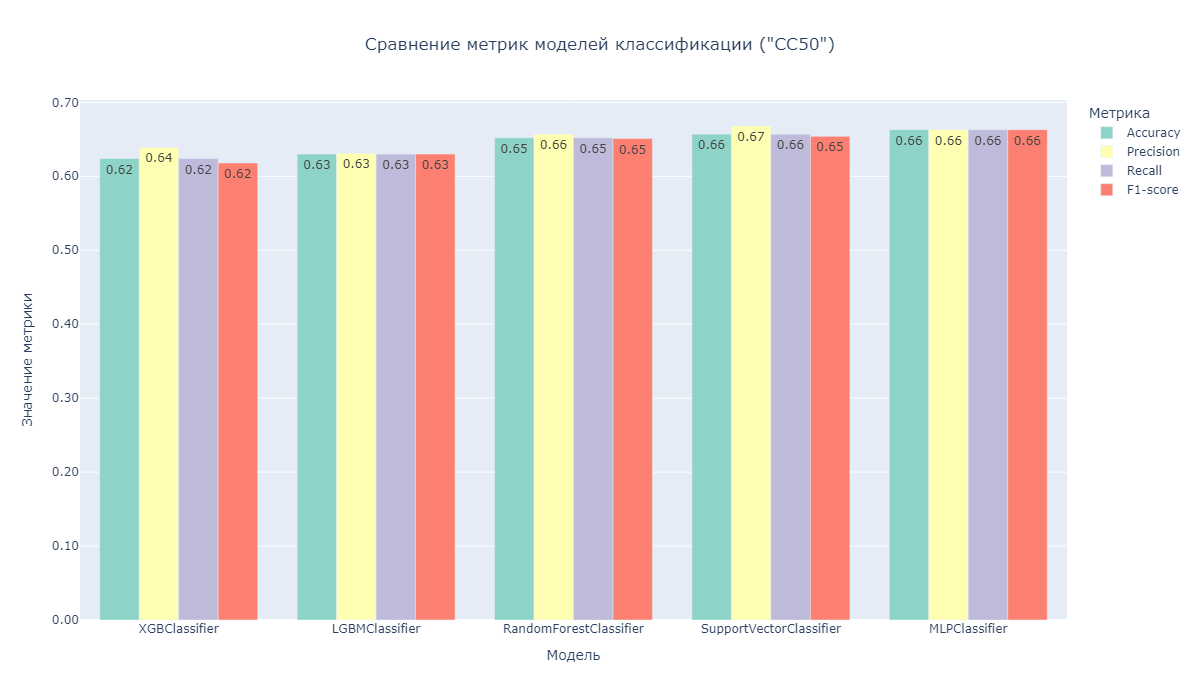

------------------------------------------------------------------------------------------------------------------------------------------------------


In [133]:
# Выводим результат
check_data_inf(
    data = metrics_df,
    data_name = 'metrics_df',
    length1 = 35,
    length2 = 60
)
print('\n\n')


# Применяем функцию 'metrics_bar_plot()' для построения столбчатого графика метрик
metrics_bar_plot(
    data = metrics_df,
    main_title = 'Столбчатая диаграмма сравнения метрик моделей классификации ("CC50"):',
    title = 'Сравнение метрик моделей классификации ("CC50")',
    colors = px.colors.qualitative.Set3
)

#### $3.5$

#### **Вывод.**

На данном этапе сделаем вывод итоговым метрикам и моделям, обученным для предсказания целевой переменной `SI`.

Лучшие значения метрик показала модель `MLPClassifier`.

=============================================================================================================================================

## <CENTER> **`4.` Machine Learning (превышает ли значение SI значение 8)**

На данном этапе мы построим несколько подходящих моделей классификации для **SI** и выберем наилучшую.

#### $4.1$

#### **Предобработка данных.**

Как и раньше, предобработаем данные при помощи созданного ранее пайплайна, только все этапы по предобработке, созданию и удалению признаков включим в отдельный класс.

Повторно загружаем пайплайн:

In [11]:
# Загружаем пайплайн при помощи joblib
preprocessing_pipeline = joblib.load('data/preprocessing_pipeline.joblib')
print("Пайплайн загружен из 'preprocessing_pipeline.joblib'")

Пайплайн загружен из 'preprocessing_pipeline.joblib'


Создаём целевую переменную:

Уникальные значения признака "SI_and_8_classif":



SI_and_8_classif
0    609
1    295
Name: count, dtype: int64

---------------------------------------------


Стобчатая и круговая диаграммы распределения целевой переменной "SI_and_8_classif":
------------------------------------------------------------------------------------------------------------------------------------------------------


C:\Users\User\AppData\Local\Temp\ipykernel_2088\4276034505.py:25: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


C:\Users\User\AppData\Local\Temp\ipykernel_2088\4276034505.py:35: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



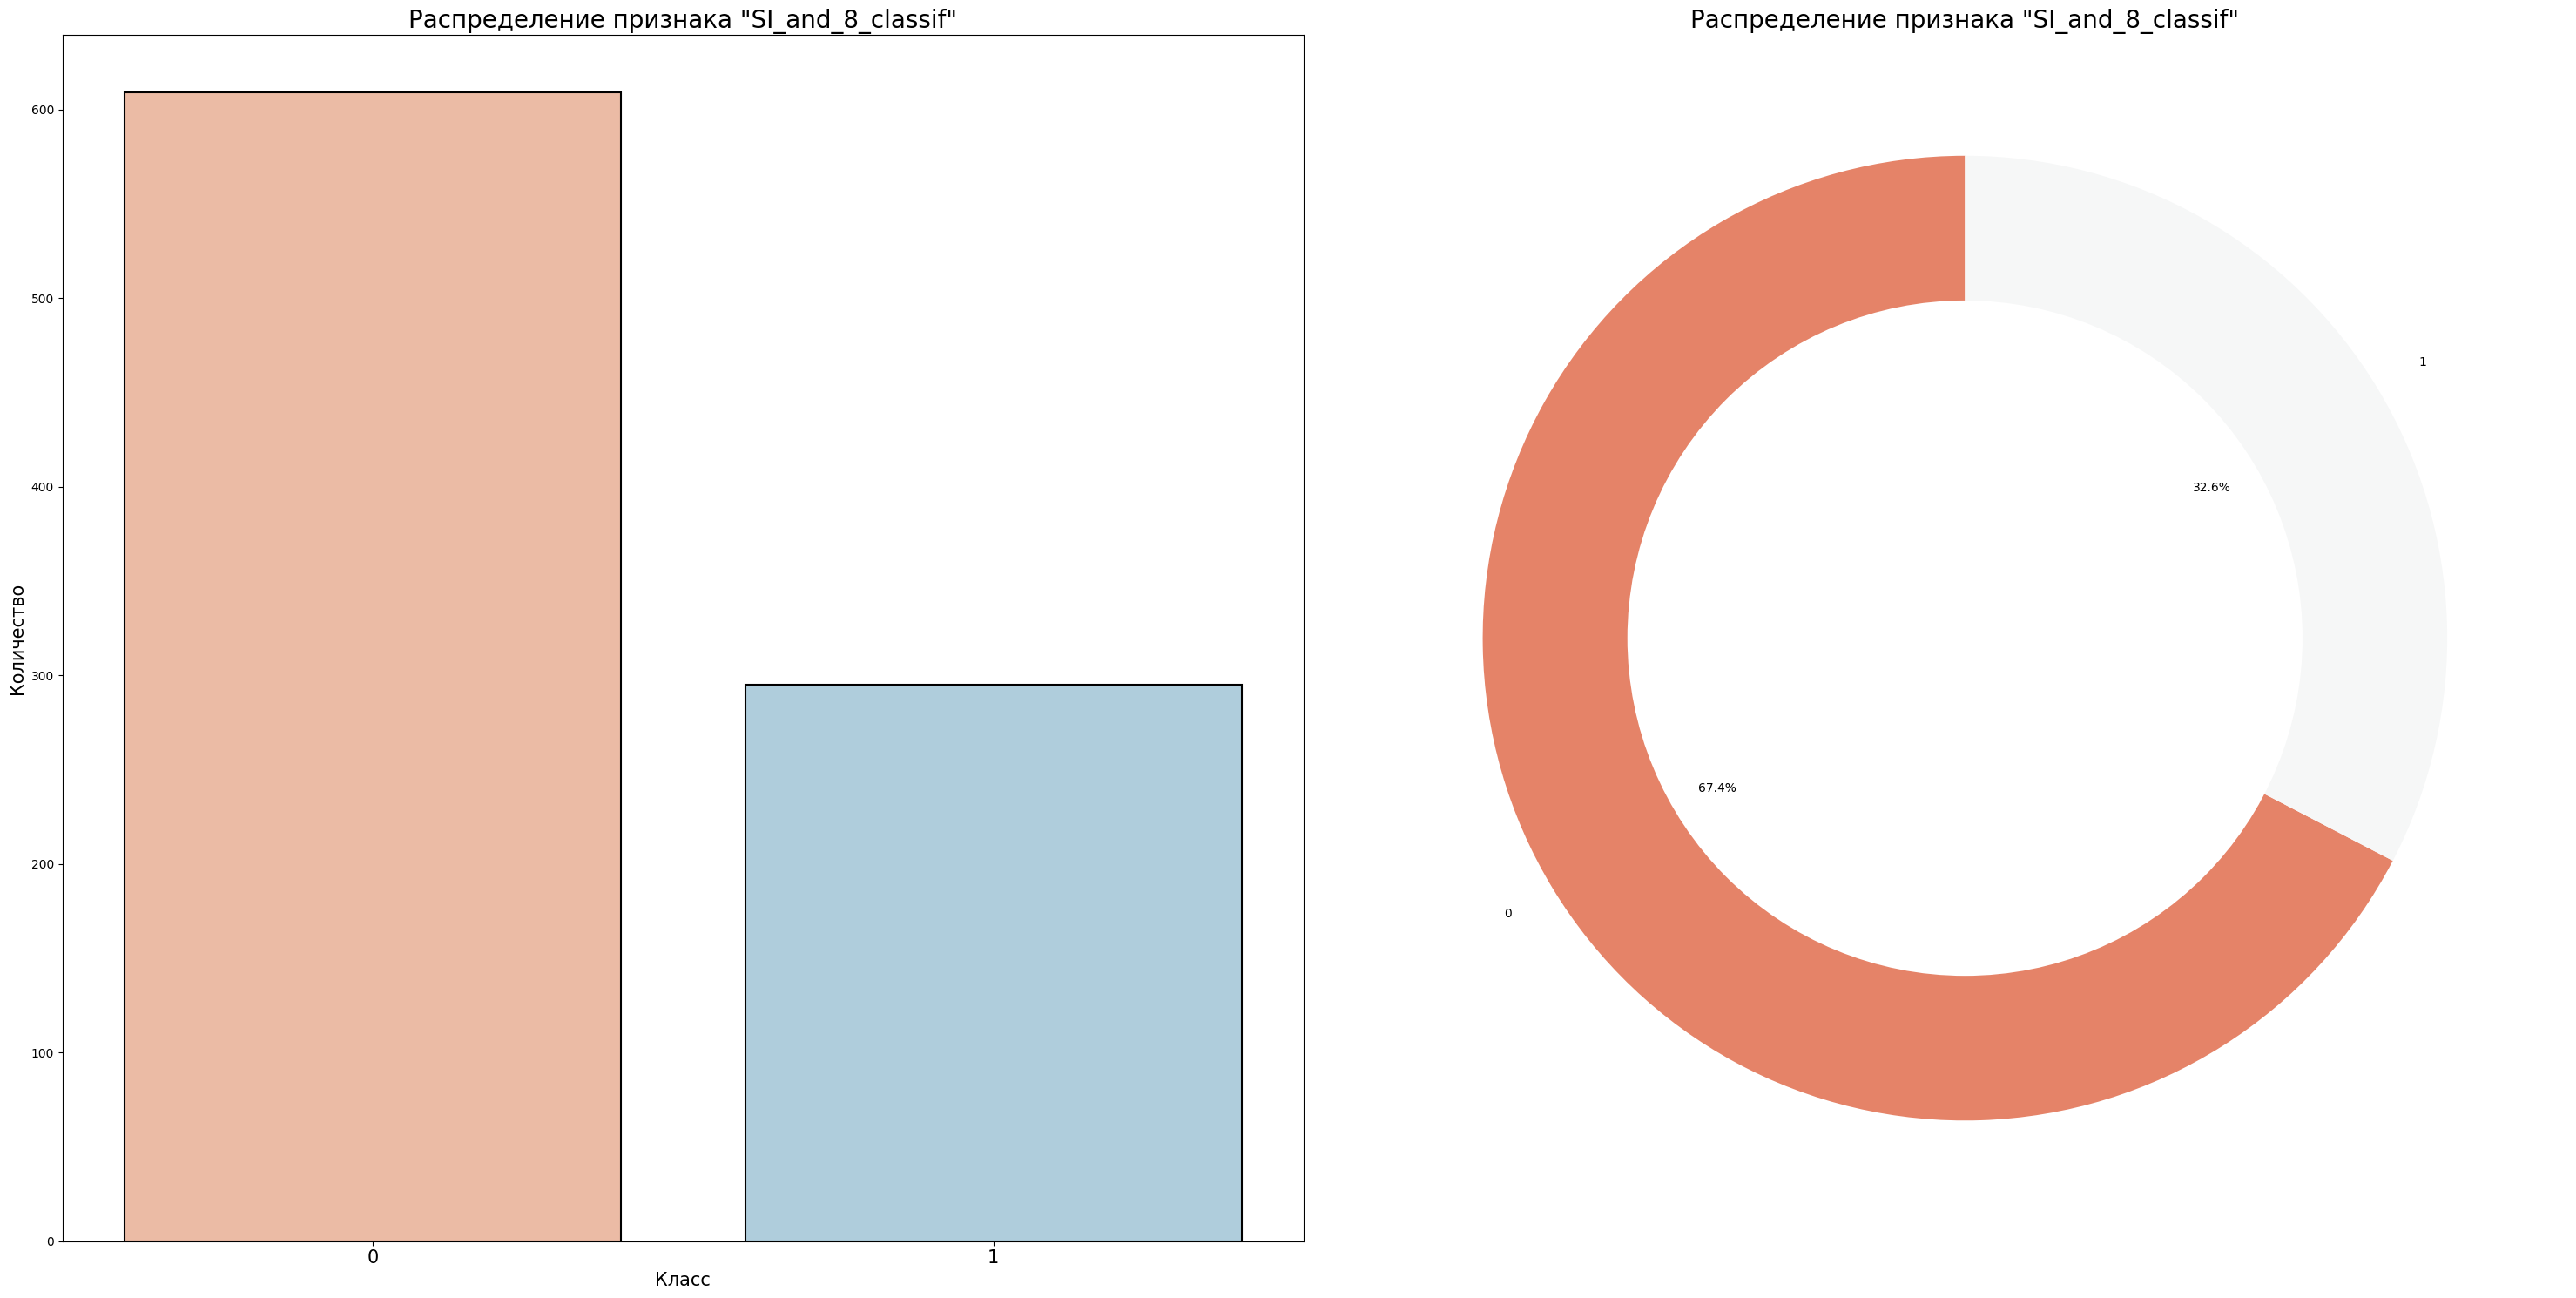

------------------------------------------------------------------------------------------------------------------------------------------------------


Распределение целевой переменной "SI"
------------------------------------------------------------------------------------------------------------------------------------------------------


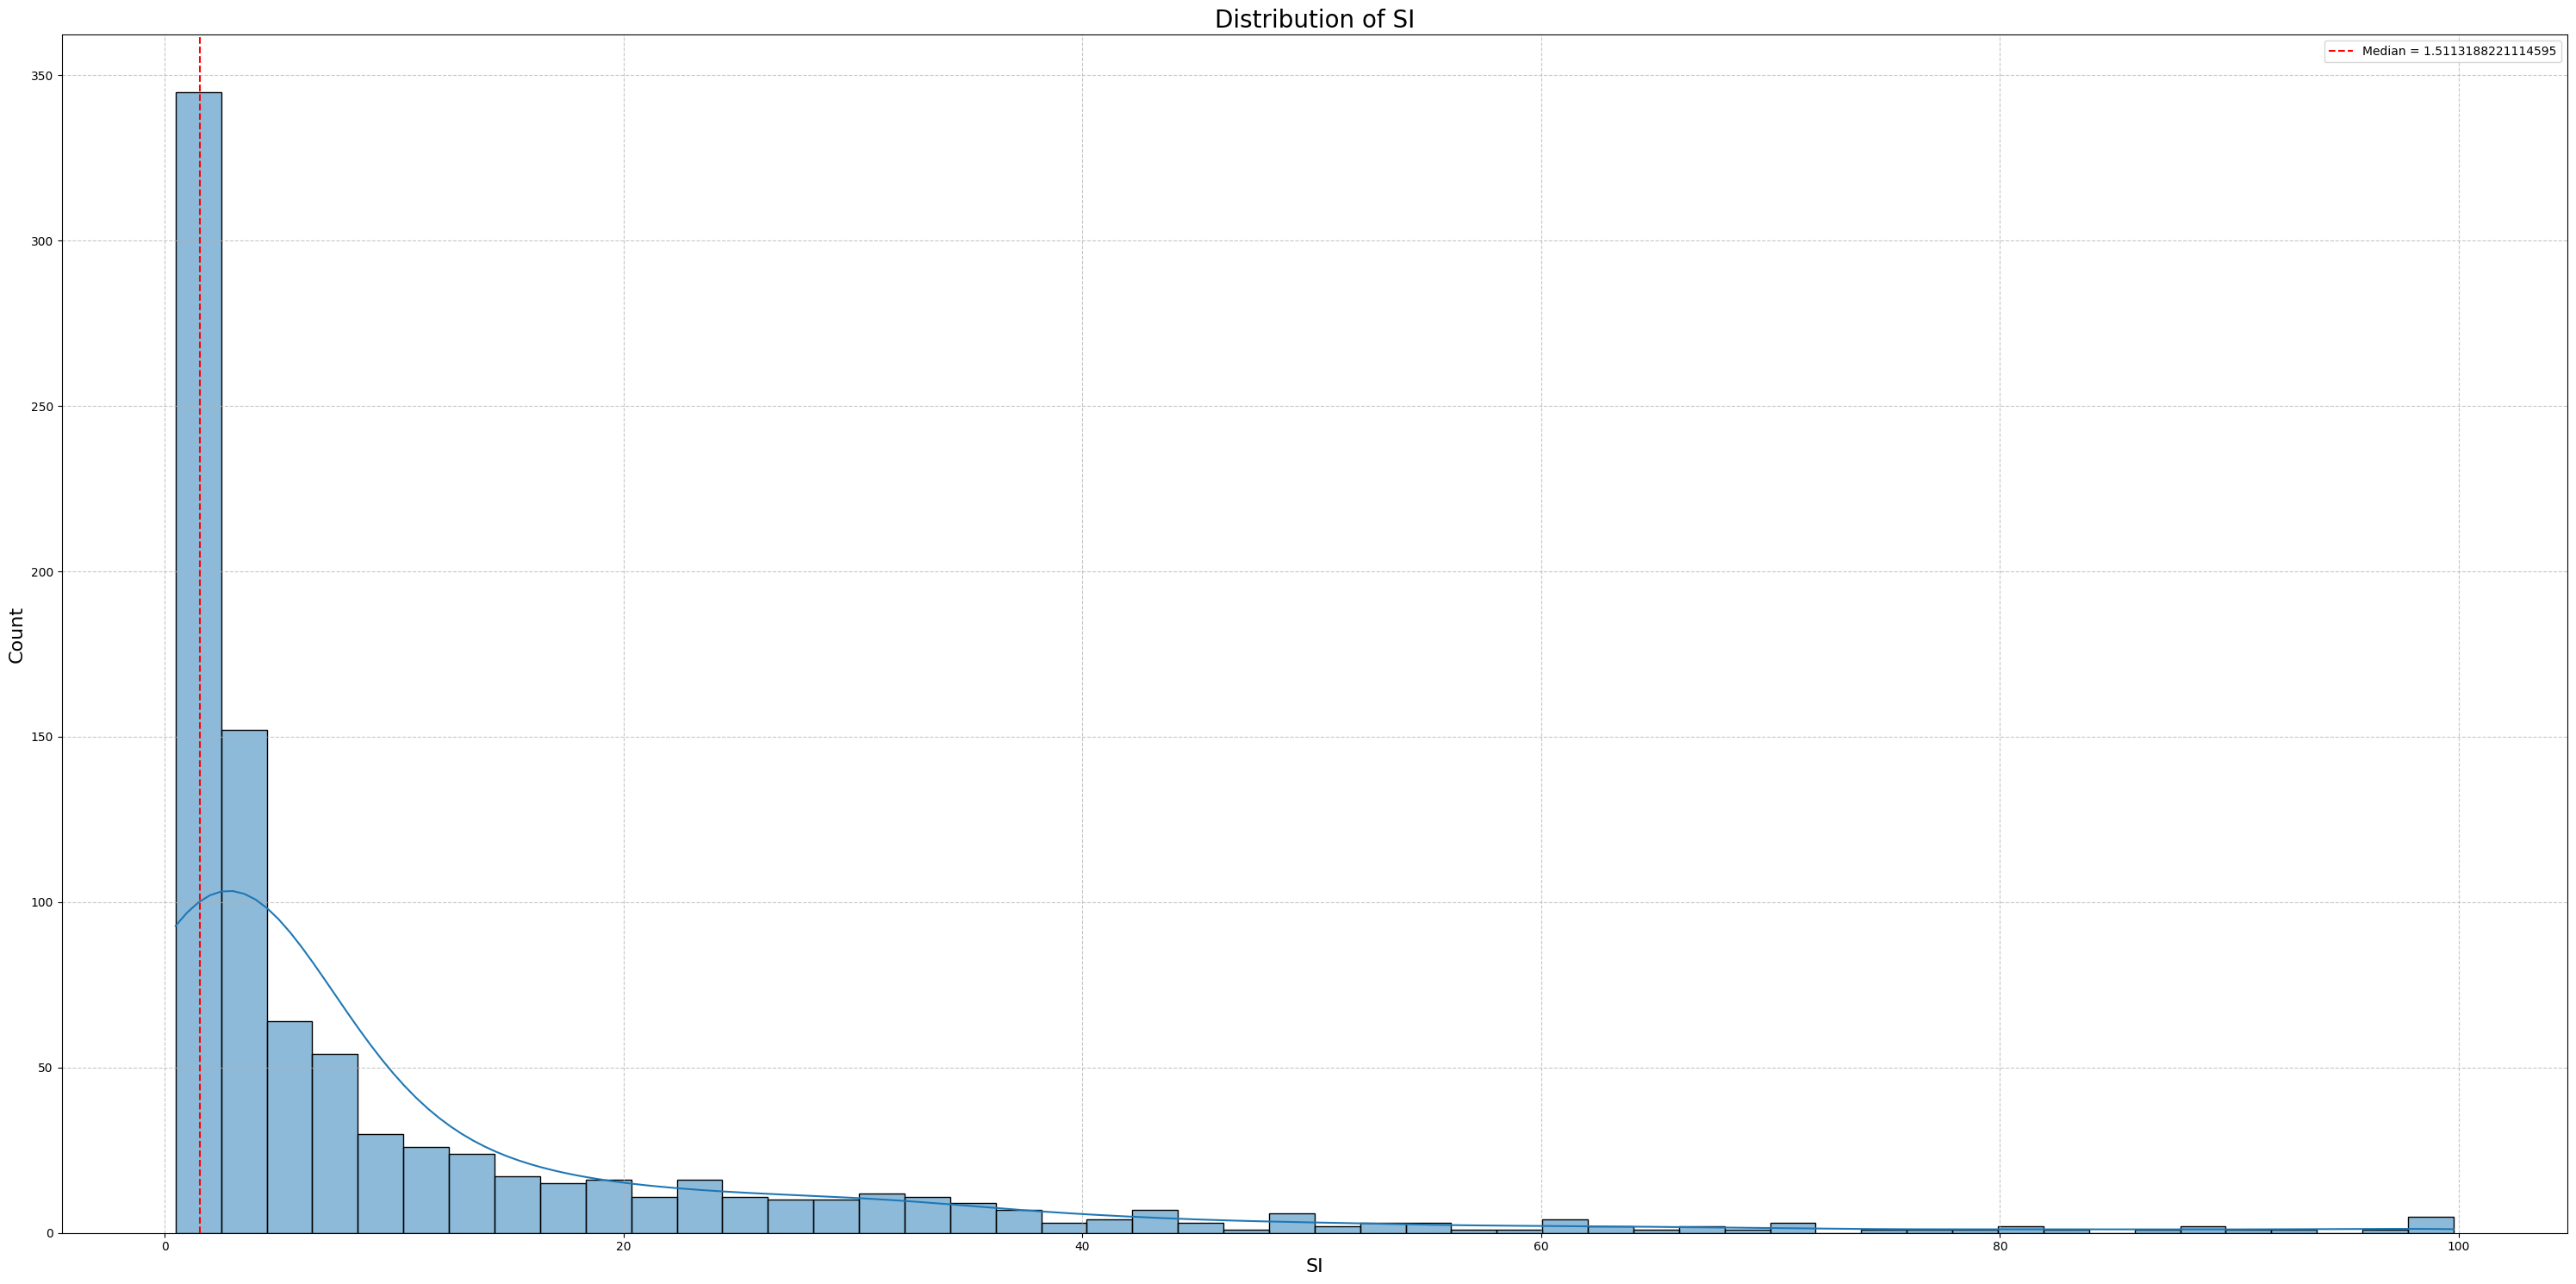

------------------------------------------------------------------------------------------------------------------------------------------------------


In [55]:
# Создаем целевую переменную (1 - превышает 8, 0 - не превышает)
molecule_df['SI_and_8_classif'] = (molecule_df['SI'] > 8).astype(int)
print('Уникальные значения признака "SI_and_8_classif":\n')
display(molecule_df['SI_and_8_classif'].value_counts())
print('-' * 45)



# Применяем функцию 'median_target_distribution_plot()' для построения графика распределения целевой переменной
median_target_distribution_plot(
    target = molecule_df['SI_and_8_classif'],
    title1 = 'Распределение признака "SI_and_8_classif"',
    main_title = 'Стобчатая и круговая диаграммы распределения целевой переменной "SI_and_8_classif":',
    color_palette = 'RdBu',
    figsize = (30, 15)
)

# Применяем функцию 'target_distribution_plot()' для построения графика распределения целевой переменной
target_distribution_plot(
    data = molecule_df,
    target = 'SI',
    median_target = median_si,
    title = 'Distribution of SI',
    main_title = 'Распределение целевой переменной "SI"',
    figsize = (30, 15)
)

**Вывод:**

Из построенных визуализаций виден явный дисбаланс, особенно выделяется преобладание класса $0$ ($67.4$%) над $1$ ($32.6$%). 

Для дальнейшей работы требуется балансировка классов.

**Разделение данных.**

Разделим данные на тматрицу наблюдений и вектор правильных ответов:

In [42]:
# Разделяем данные на матрицу наблюдений и вектор правильных ответов
X = molecule_df.drop(columns = ['IC50, mM', 'CC50, mM', 'SI', 'log_IC50, mM', 'log_CC50, mM', 'log_SI', 'IC50_classif', 'CC50_classif', 'SI_classif', 'SI_and_8_classif'])
y = molecule_df['SI_and_8_classif']

Применим созданный ранее класс к данным:

In [43]:
# Создаём экземпляра класса 'DataPreprocessor'
DP_processor = DataPreprocessor(preprocessing_pipeline)

# Обработка данных
DP_processor.fit_transform(X, y)

# Получение обработанных данных
X_train_processed_df, X_test_processed_df, y_train, y_test, remaining_features = DP_processor.get_processed_data()


Данные таблицы "Molecular properties features" имеют следующую размерность:

Количество строк: 723;
Количество признаков (столбцов): 3.
----------------------------------------
------------------------------------------------------------




Данные таблицы "Functional groups features" имеют следующую размерность:

Количество строк: 723;
Количество признаков (столбцов): 8.
----------------------------------------
------------------------------------------------------------------------------------------




Данные таблицы "Topological descriptors features" имеют следующую размерность:

Количество строк: 723;
Количество признаков (столбцов): 4.
----------------------------------------
--------------------------------------------------------------------------------




Данные таблицы "Transformations features" имеют следующую размерность:

Количество строк: 723;
Количество признаков (столбцов): 3.
----------------------------------------
---------------------------------------------------

Выводим результат:

In [44]:
# Информация по тренеровочной выборке
check_data_inf(
    data = X_train_processed_df,
    data_name = 'X_train_processed_df',
    length1 = 40,
    length2 = 150
)
print('\n\n\n')


# Информация по тестовой выборке
check_data_inf(
    data = X_test_processed_df,
    data_name = 'X_test_processed_df',
    length1 = 40,
    length2 = 150
)
print('\n\n\n')


# Информация по оставшимся признакам
print(f'Оставшиеся признаки:\n\n{remaining_features.tolist()}')
print('-' * 150)


Данные таблицы "X_train_processed_df" имеют следующую размерность:

Количество строк: 723;
Количество признаков (столбцов): 103.
----------------------------------------


MaxAbsEStateIndex  MinAbsEStateIndex  MinEStateIndex       qed       SPS  \
0            -1.496602           0.422613        0.771519  0.579771 -0.081941   
1             0.527403           0.904784       -0.394927  0.514586 -0.554818   
2             0.252959          -0.894628        0.392277  0.397569  0.511590   
3            -1.210453           0.216033        0.750903  0.746949  1.699045   
4             0.694610          -0.824197        0.472459  1.392750 -0.120265   
..                 ...                ...             ...       ...       ...   
718           0.251380           0.324610        0.428609 -0.563375 -0.001549   
719          -1.577604           1.146384        0.843749  0.769183  0.451116   
720           0.439661          -0.198519        0.198692  0.502574 -0.661393   
721           0.980138          -0.326590       -0.499596 -0.363831 -1.475648   
722          -1.635707           1.283362        0.857418  0.748480  0.731976   

        MolWt  FpDensityMorgan1  BCUT2D_MWHI  BCUT2D_MWLOW  BCUT2D_CHGHI  ...  \
0   -0.172284         -0.720975    -0.482466     -0.231601      0.709602  ...   
1   -0.694608         -0.970049    -0.465835      0.425592      0.670103  ...   
2   -0.034503          1.347721     0.555049     -0.313054      0.077316  ...   
3   -1.145565         -0.554926    -0.589790     -0.967502      0.838770  ...   
4   -0.264281          0.954612     0.555048     -0.403346     -0.483621  ...   
..        ...               ...          ...           ...           ...  ...   
718 -0.241286          0.655849    -0.479027     -0.231089      0.700544  ...   
719 -0.010688          0.083725    -0.482669     -0.749877      0.230117  ...   
720  0.463493         -0.416552     0.557248      0.434471     -0.335264  ...   
721  0.285924         -0.703184    -0.304289      0.607120     -1.303146  ...   
722 -0.601279          0.482881    -0.482670     -0.231261      0.699655  ...   

     fr_quatN  fr_sulfide  fr_thiazole  fr_thiophene  fr_unbrch_alkane  \
0   -0.174679   -0.210093    -0.266667     -0.303554         -0.177731   
1   -0.174679   -0.210093    -0.266667     -0.303554         -0.177731   
2   -0.174679   -0.210093    -0.266667      3.294307         -0.177731   
3   -0.174679   -0.210093    -0.266667     -0.303554         -0.177731   
4   -0.174679   -0.210093     3.750000     -0.303554         -0.177731   
..        ...         ...          ...           ...               ...   
718 -0.174679   -0.210093    -0.266667     -0.303554         -0.177731   
719 -0.174679   -0.210093    -0.266667     -0.303554         -0.177731   
720 -0.174679    3.494726    -0.266667     -0.303554         -0.177731   
721 -0.174679   -0.210093    -0.266667     -0.303554         -0.177731   
722 -0.174679   -0.210093    -0.266667     -0.303554         -0.177731   

     MolWt_per_Heteroatoms  TPSA_per_MolLogP  fr_Al_OH_per_benzene  \
0                -0.064531         -0.017568             -0.338656   
1                -0.064565          0.133615             -0.338656   
2                -0.064578          0.146636             -0.338656   
3                -0.064458         -0.019390             -0.338656   
4                -0.064567          0.009951             -0.338656   
..                     ...               ...                   ...   
718              -0.064533         -0.010548             -0.338656   
719              -0.064481         -0.085575             -0.338656   
720              -0.064571          0.086950             -0.338656   
721              -0.064583          0.134657             -0.338656   
722              -0.064545         -0.013565             -0.338656   

     SMR_VSA_ratio  TPSA_times_FractionCSP3  
0        -0.806000                -0.332149  
1        -0.806000                -0.857136  
2         0.736551                 1.215385  
3        -0.806000                -0.065901  
4         0.207477                -0.043975  
..             ...                      ...  
718    

------------------------------------------------------------------------------------------------------------------------------------------------------





Данные таблицы "X_test_processed_df" имеют следующую размерность:

Количество строк: 181;
Количество признаков (столбцов): 103.
----------------------------------------


MaxAbsEStateIndex  MinAbsEStateIndex  MinEStateIndex       qed       SPS  \
0             0.160756          -0.510352       -0.302029 -0.353559 -1.315644   
1             0.552605          -0.468304       -2.184035 -1.056662 -1.369489   
2            -0.045459          -1.061101        0.108325  0.426638  0.811860   
3             0.464136           0.524951       -1.212053 -1.368374 -0.291834   
4            -1.720945           1.330435        0.862116 -1.065667  0.899075   
..                 ...                ...             ...       ...       ...   
176          -1.488398           1.708016        0.899797  0.058433  1.462212   
177           0.562094           0.446785        0.434776  0.703003 -1.149026   
178           0.417928           0.379878        0.409685 -0.011909 -1.476949   
179           0.044589          -0.244271        0.028994  1.031010  0.347881   
180          -1.734335           1.301008        0.859179  0.439095  0.456709   

        MolWt  FpDensityMorgan1  BCUT2D_MWHI  BCUT2D_MWLOW  BCUT2D_CHGHI  ...  \
0   -0.863532          1.780140     0.559264      2.296748     -1.732256  ...   
1   -0.089109          0.528003     0.552297      1.154219     -0.893501  ...   
2   -0.471906          1.224172    -0.471246     -0.265352      0.017607  ...   
3    0.854706          0.353155     0.492597     -0.231089      0.701536  ...   
4    0.426860         -2.215418    -0.592477     -0.231368      0.760929  ...   
..        ...               ...          ...           ...           ...  ...   
176 -1.667184          0.690443    -0.603011      0.127272     -0.483112  ...   
177 -0.103926         -0.554926    -0.504065      0.884829     -1.319795  ...   
178 -0.073419         -0.395263    -0.482662      1.260989     -2.026415  ...   
179  0.057249         -0.075938    -0.478956     -0.226828      0.099772  ...   
180 -0.700635          0.319017    -0.559207     -0.231174      0.702776  ...   

     fr_quatN  fr_sulfide  fr_thiazole  fr_thiophene  fr_unbrch_alkane  \
0   -0.174679   -0.210093    -0.266667     -0.303554         -0.177731   
1   -0.174679   -0.210093    -0.266667     -0.303554         -0.177731   
2   -0.174679   -0.210093    -0.266667     -0.303554         -0.177731   
3   -0.174679   -0.210093    -0.266667     -0.303554          0.788429   
4   -0.174679   -0.210093    -0.266667     -0.303554          4.653068   
..        ...         ...          ...           ...               ...   
176 -0.174679   -0.210093    -0.266667     -0.303554         -0.177731   
177 -0.174679   -0.210093    -0.266667     -0.303554         -0.177731   
178 -0.174679   -0.210093    -0.266667     -0.303554         -0.177731   
179 -0.174679   -0.210093    -0.266667     -0.303554         -0.177731   
180  3.539809   -0.210093    -0.266667     -0.303554         -0.177731   

     MolWt_per_Heteroatoms  TPSA_per_MolLogP  fr_Al_OH_per_benzene  \
0                -0.064599         -1.198955             -0.338656   
1                -0.064590          0.128426             -0.338656   
2                -0.064578          0.213022              1.475033   
3                -0.064576          0.094904             -0.338656   
4                -0.064459         -0.076881             -0.338656   
..                     ...               ...                   ...   
176              -0.064510          0.065149             -0.338656   
177              -0.064572          0.100585             -0.338656   
178              -0.064572          0.099420             -0.338656   
179              -0.064570          0.247098             -0.338656   
180              -0.064515         -0.074934             -0.338656   

     SMR_VSA_ratio  TPSA_times_FractionCSP3  
0         0.168554                -0.016665  
1         1.068112                -0.717143  
2         1.241226                 1.433804  
3         1.152177                 1.983047  
4        -0.806000                -0.190647  
..             ...                      ...  
176    

------------------------------------------------------------------------------------------------------------------------------------------------------




Оставшиеся признаки:

['MaxAbsEStateIndex', 'MinAbsEStateIndex', 'MinEStateIndex', 'qed', 'SPS', 'MolWt', 'FpDensityMorgan1', 'BCUT2D_MWHI', 'BCUT2D_MWLOW', 'BCUT2D_CHGHI', 'BCUT2D_CHGLO', 'BCUT2D_MRLOW', 'AvgIpc', 'BalabanJ', 'Ipc', 'PEOE_VSA1', 'PEOE_VSA10', 'PEOE_VSA11', 'PEOE_VSA12', 'PEOE_VSA13', 'PEOE_VSA14', 'PEOE_VSA2', 'PEOE_VSA3', 'PEOE_VSA4', 'PEOE_VSA5', 'PEOE_VSA6', 'PEOE_VSA7', 'PEOE_VSA8', 'PEOE_VSA9', 'SMR_VSA10', 'SMR_VSA2', 'SMR_VSA3', 'SMR_VSA4', 'SMR_VSA5', 'SMR_VSA6', 'SMR_VSA9', 'SlogP_VSA1', 'SlogP_VSA12', 'SlogP_VSA2', 'SlogP_VSA3', 'SlogP_VSA7', 'SlogP_VSA8', 'EState_VSA11', 'EState_VSA2', 'EState_VSA3', 'EState_VSA4', 'EState_VSA5', 'EState_VSA6', 'EState_VSA7', 'EState_VSA8', 'EState_VSA9', 'VSA_EState1', 'VSA_EState2', 'VSA_EState4', 'VSA_EState5', 'VSA_EState7', 'VSA_EState8', 'VSA_EState9', 'NumAliphatic

По результатам видно, что данные, после применения класса, имеют схожую структуру, что и при прошлой предобработки.

Проверим распределение признаков при помощи визуализации:


График распределения признаков:
------------------------------------------------------------------------------------------------------------------------------------------------------


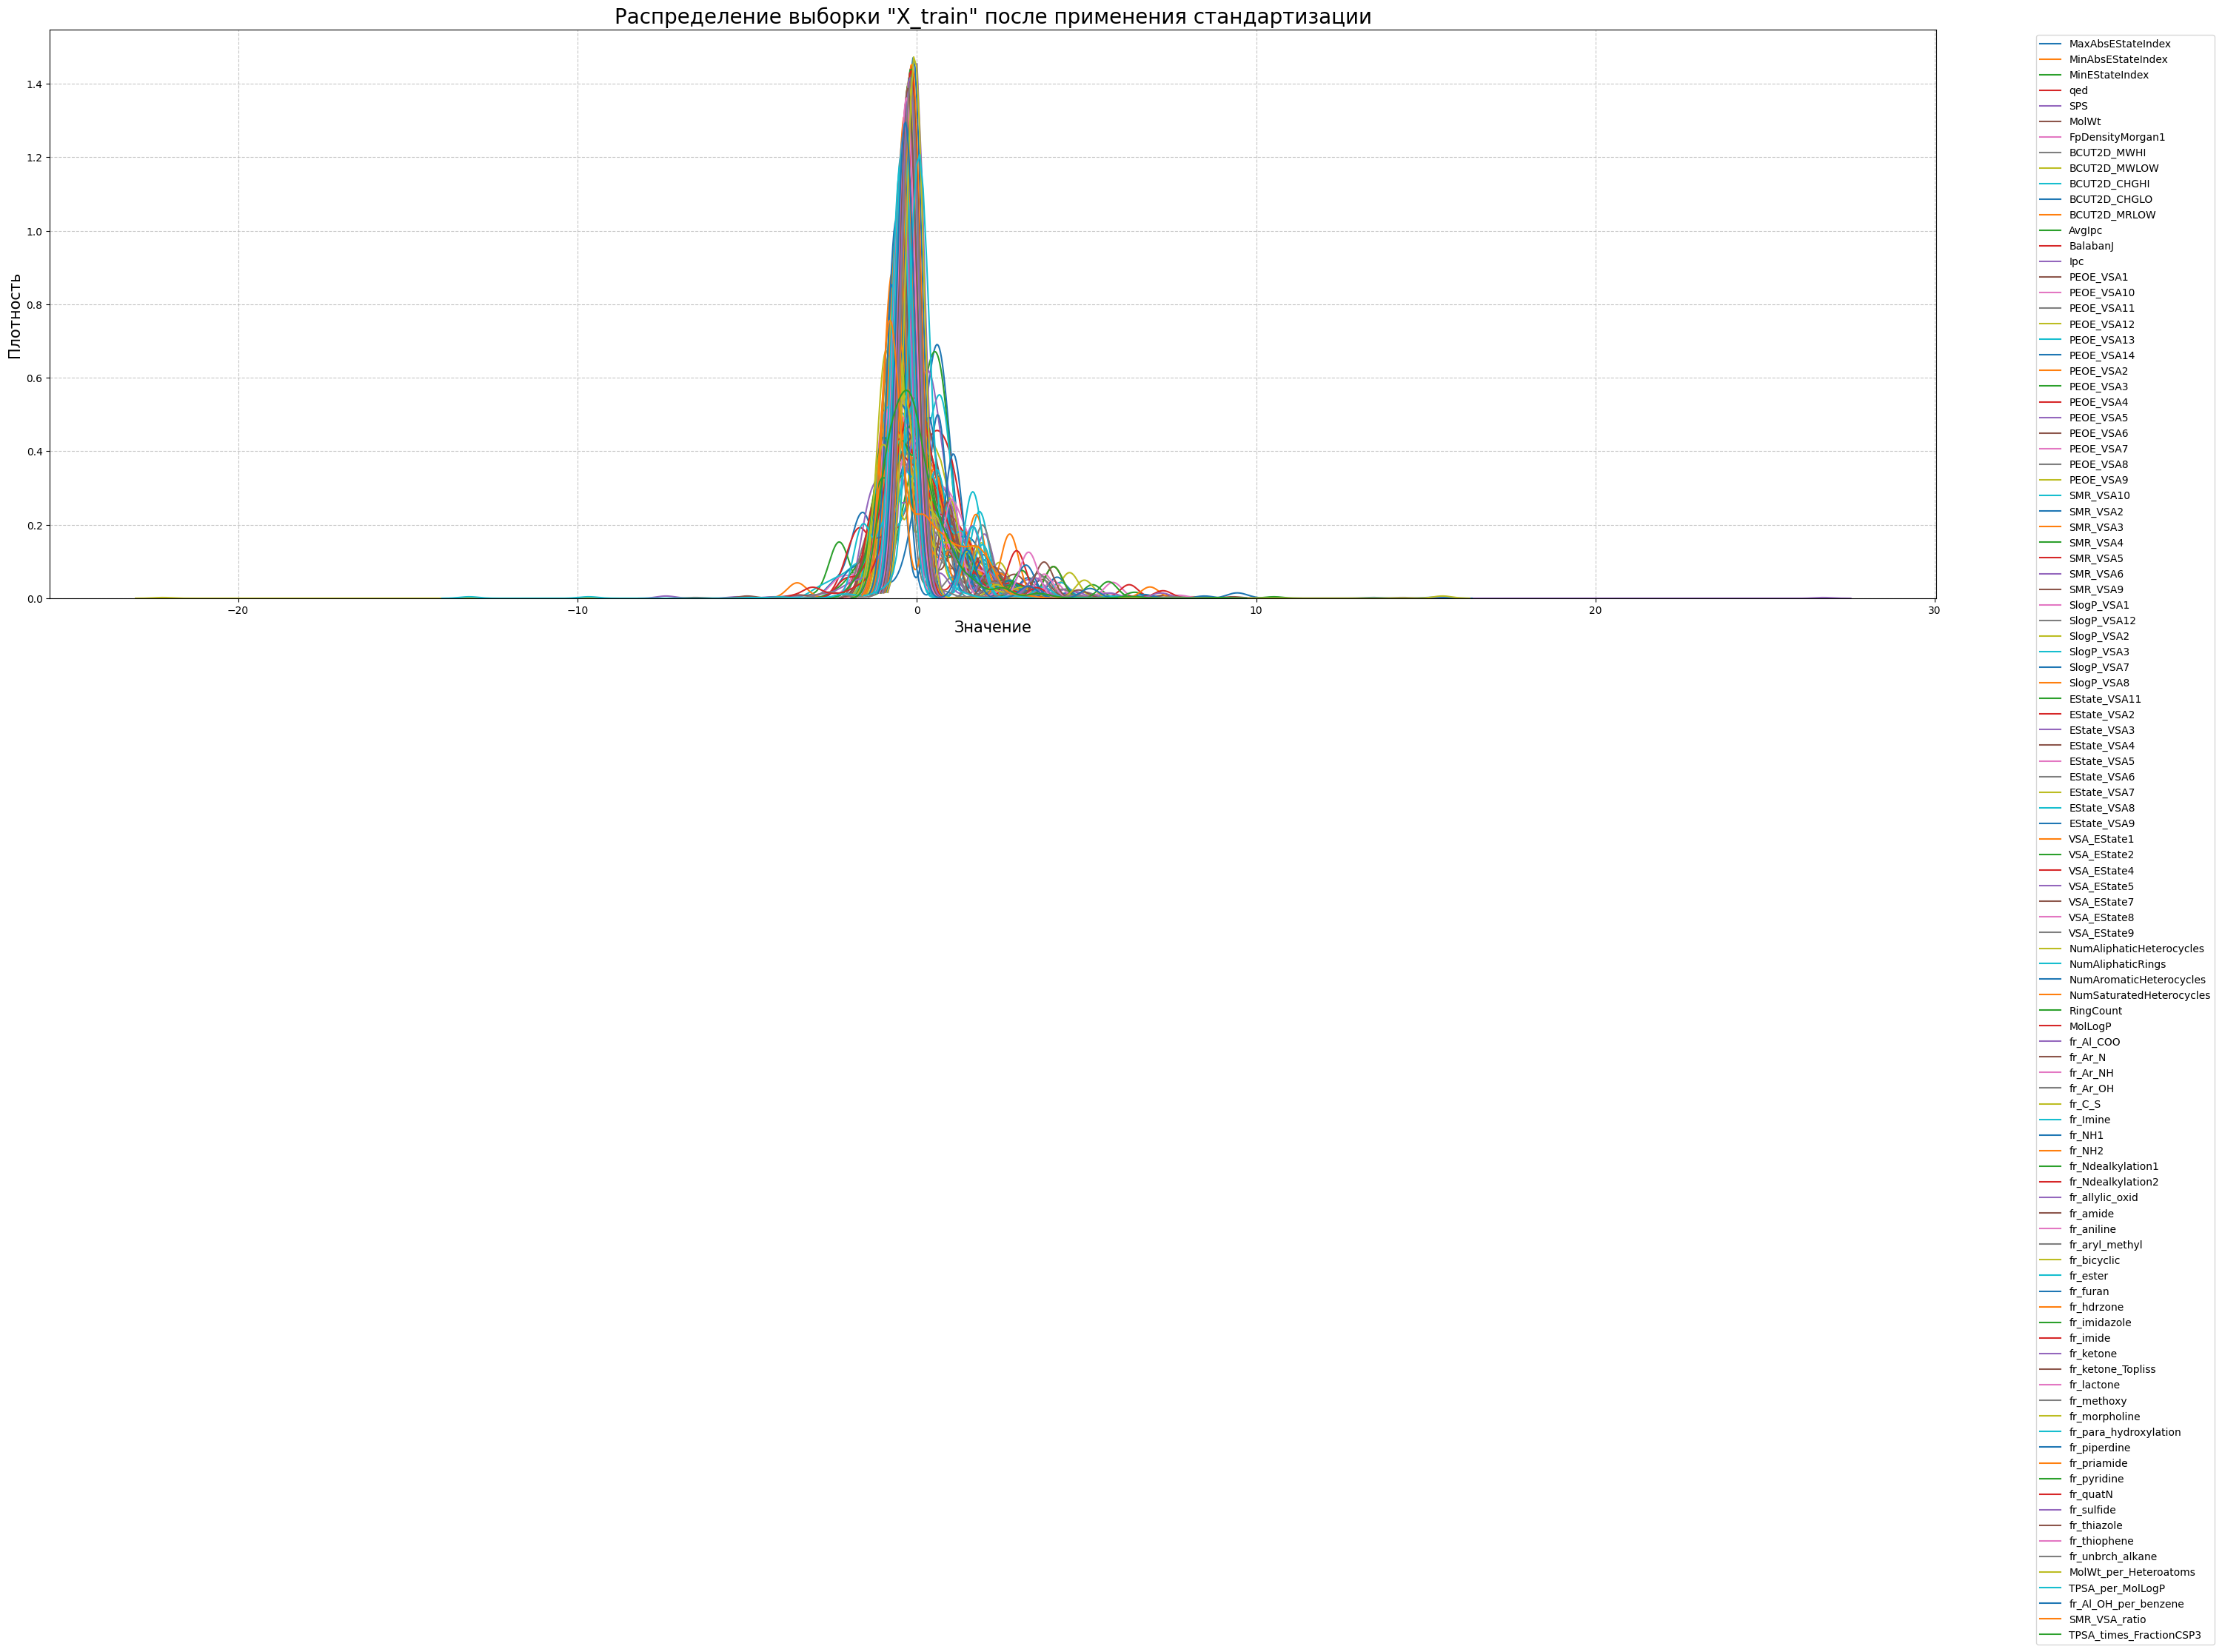

------------------------------------------------------------------------------------------------------------------------------------------------------



График распределения признаков:
------------------------------------------------------------------------------------------------------------------------------------------------------


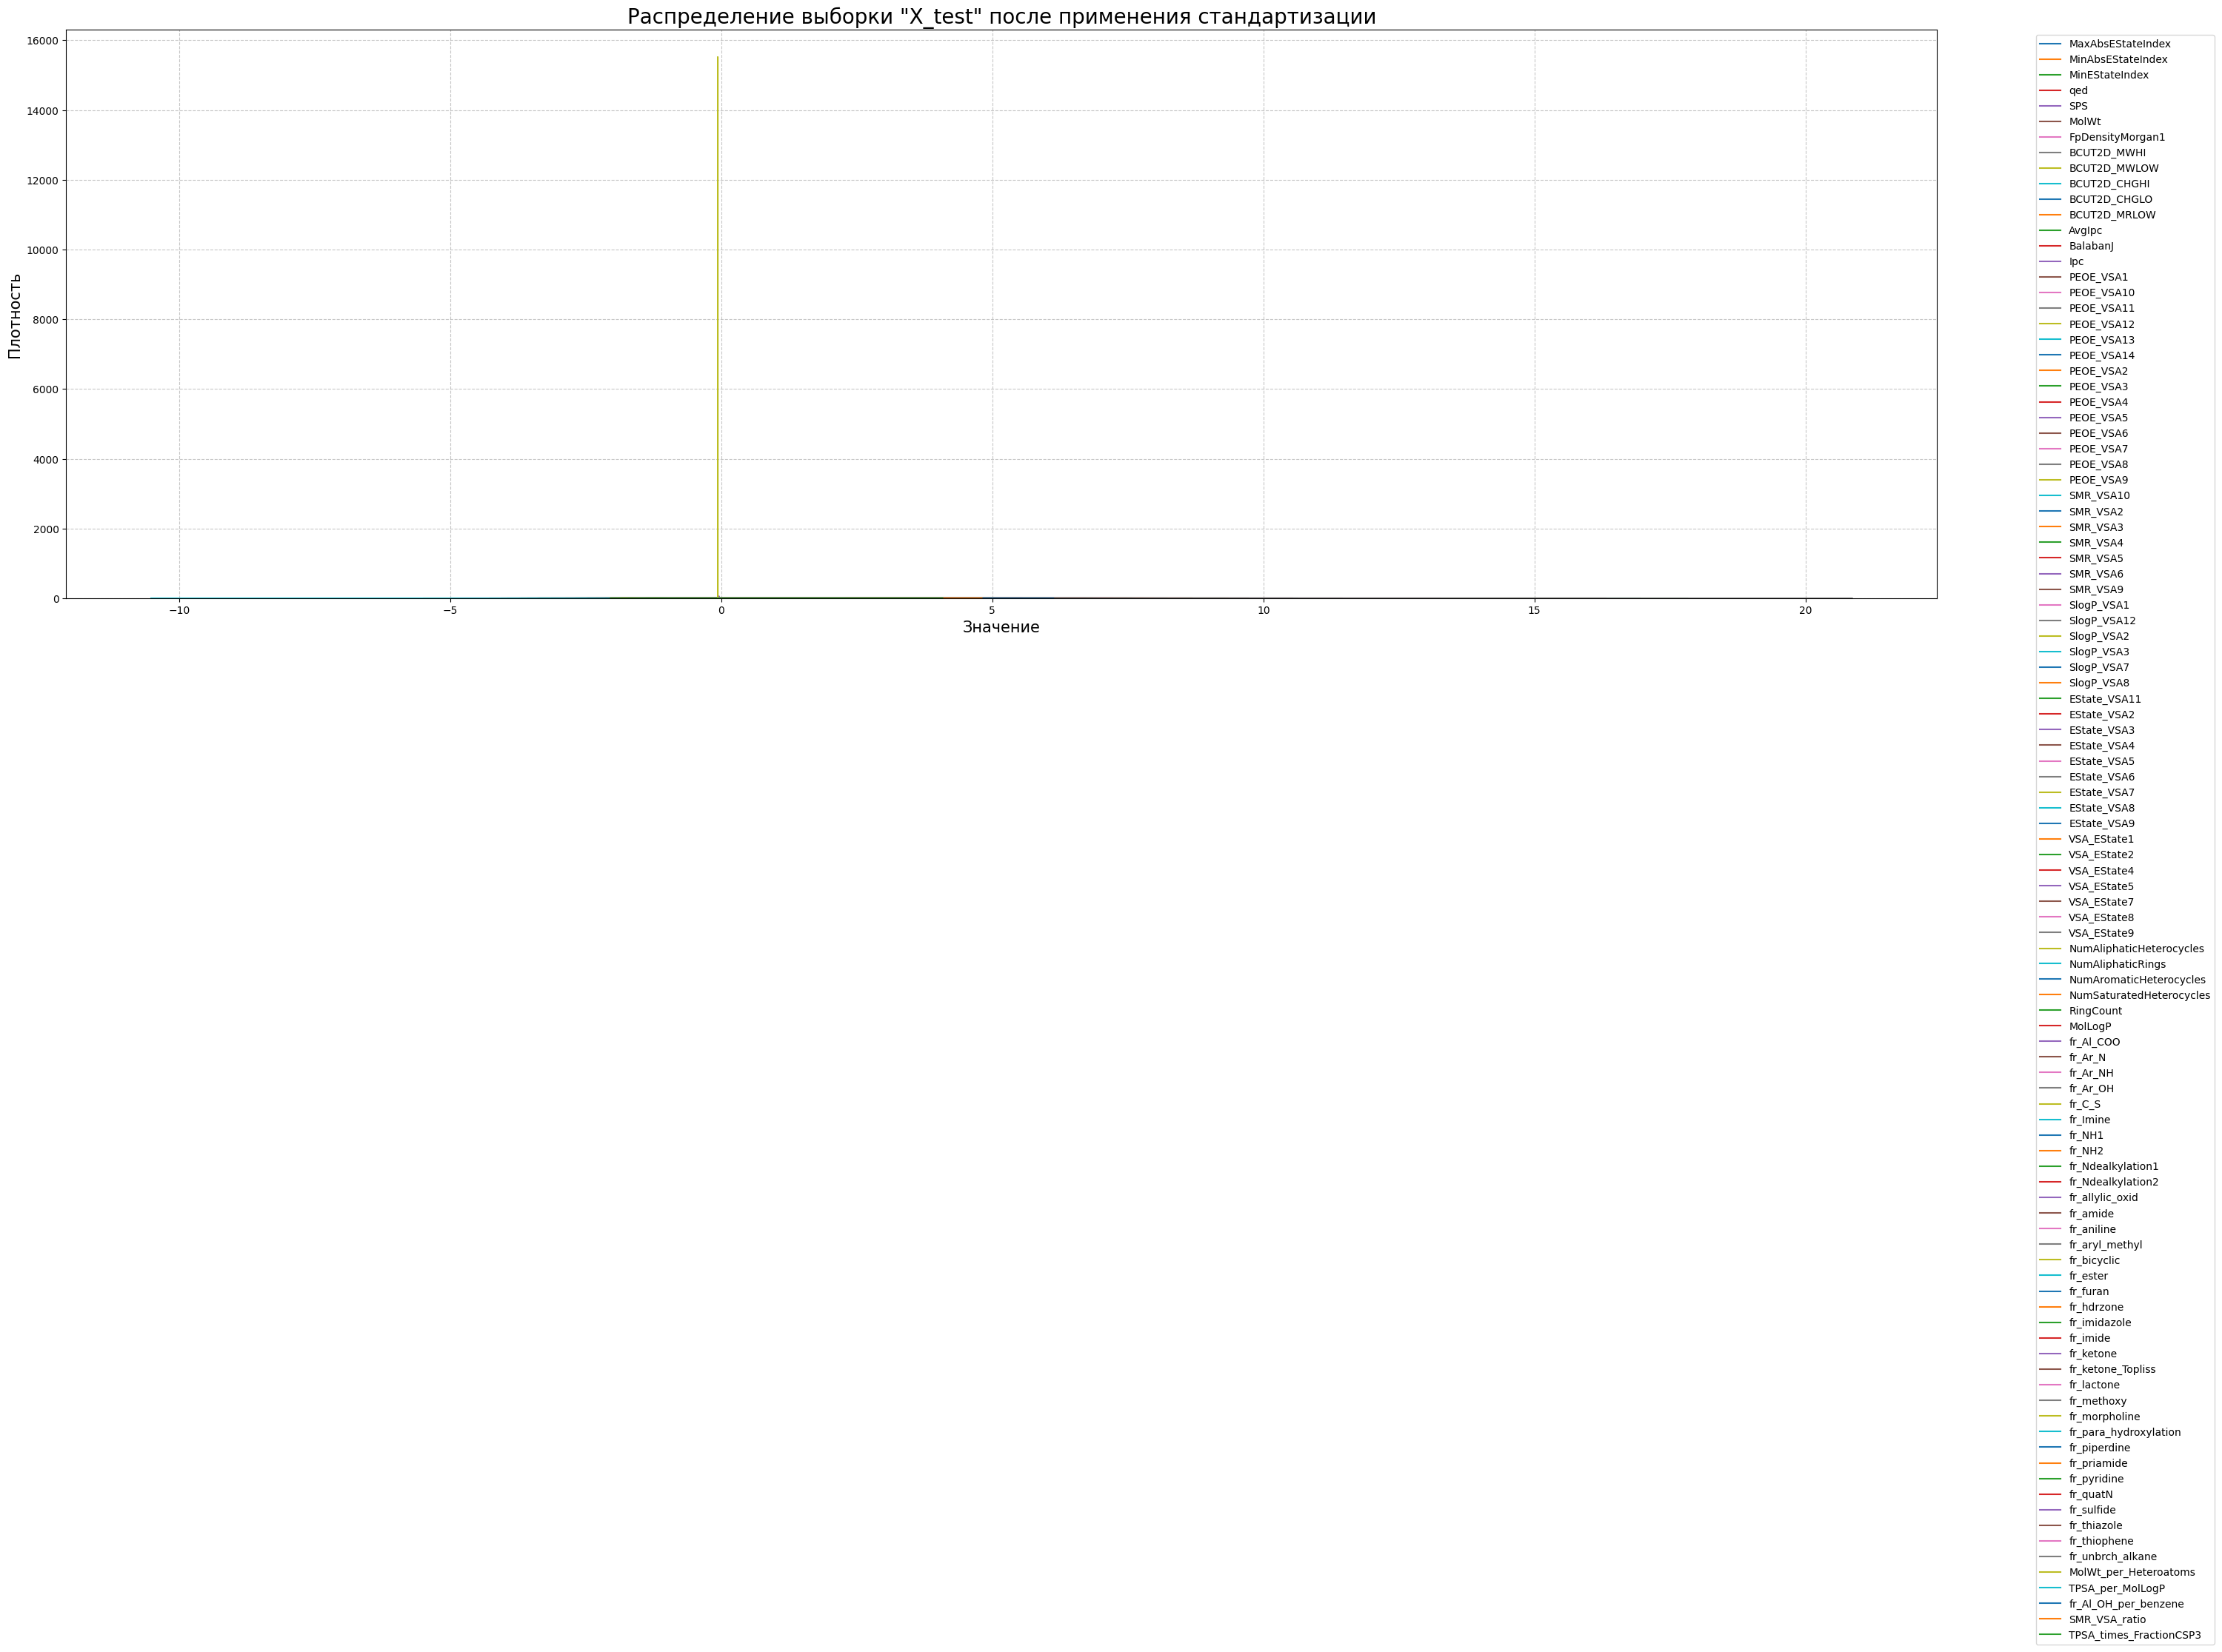

------------------------------------------------------------------------------------------------------------------------------------------------------


In [45]:
# Применяем функцию 'features_distribution_plot()' для построения графика распределения признаков X_train
print()
features_distribution_plot(
    data = X_train_processed_df,
    title = 'Распределение выборки "X_train" после применения стандартизации',
    figsize = (30, 17)
)

# Добавляем отступ
print('\n\n')



# Применяем функцию 'features_distribution_plot()' для построения графика распределения признаков X_test
features_distribution_plot(
    data = X_test_processed_df,
    title = 'Распределение выборки "X_test" после применения стандартизации',
    figsize = (30, 17)
)

**Вывод:**

Распределение признаков также нормализовалось.

#### $4.2$

#### **Отбор самых информативных признаков.**

На данном этапе отберём только самые информативные признаки для дальнейшего решения задачи регрессии.

Производить отбор признаков будем так же, как и для `SI`, в $4$ этапа:

1. Отберём $50$ признаков с помощью алгоритма **Mutual Information**,
2. Отберём $50$ признаков с помощью алгоритма **F-test**,
3. Отберём $50$ признаков из отобранных обоими алгоритмами,
4. Из оставшихся отберём $30$ признаков с помощью алгоритма **Lasso**.

Только сейчас, все этапы обернём в класс, чтобы использовать его в будущем.

Применим созданный ранее класс `FeatureSelector` к данным:

In [46]:
# Инициализируем класс 'FeatureSelector'         
feature_selector = FeatureSelector(
    mi_k = 50,
    f_k = 50,
    log_max_features = 30,
    penalty = 'l1',
    solver = 'liblinear',
    C = 1.0
)

# Обучаем класс на данных
feature_selector.fit_transform(X_train_processed_df, X_test_processed_df, y_train)

# Получение обработанных данных
X_train_final, X_test_final, final_features = feature_selector.get_final_data()

# Выводим результат
feature_selector.print_results()


Топ-30 финальных признаков после "LogisticRegression"

NumSaturatedHeterocycles    0.884547
SMR_VSA6                    0.786580
SMR_VSA5                    0.675844
BCUT2D_CHGLO                0.463129
FpDensityMorgan1            0.429128
VSA_EState7                 0.427886
VSA_EState1                 0.388263
SlogP_VSA3                  0.375650
BCUT2D_MWLOW                0.365741
PEOE_VSA3                   0.334316
EState_VSA8                 0.312571
VSA_EState2                 0.302348
fr_sulfide                  0.273076
MaxAbsEStateIndex           0.249772
PEOE_VSA9                   0.231881
SPS                         0.228861
BalabanJ                    0.226167
MolWt_per_Heteroatoms       0.205401
SMR_VSA9                    0.165989
TPSA_per_MolLogP            0.160586
BCUT2D_MWHI                 0.143489
fr_bicyclic                 0.143002
SlogP_VSA2                  0.140065
VSA_EState8                 0.127948
PEOE_VSA6                   0.126722
PEOE_VSA7          

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:486: UserWarning:

X has feature names, but SelectFromModel was fitted without feature names



Выведем информацию итоговых выборок:

In [47]:
# Информация по тренеровочной выборке
check_data_inf(
    data = X_train_final,
    data_name = 'X_train_final',
    length1 = 40,
    length2 = 150
)
print('\n\n\n')


# Информация по тестовой выборке
check_data_inf(
    data = X_test_final,
    data_name = 'X_test_final',
    length1 = 40,
    length2 = 150
)


Данные таблицы "X_train_final" имеют следующую размерность:

Количество строк: 723;
Количество признаков (столбцов): 30.
----------------------------------------


VSA_EState5  VSA_EState1  MaxAbsEStateIndex  VSA_EState2  SMR_VSA9  \
0       0.875327    -0.510177          -1.496602    -0.731273  0.461262   
1      -0.723162    -0.228040           0.527403     0.683650 -0.034331   
2       0.320846    -0.483553           0.252959     0.581600 -0.529924   
3       1.075515    -0.823985          -1.210453    -1.092745 -0.529924   
4      -0.077143    -0.068435           0.694610    -0.768015 -0.529924   
..           ...          ...                ...          ...       ...   
718     0.172446    -0.542370           0.251380     0.099133 -0.529924   
719     0.530838    -0.524807          -1.577604    -0.899965 -0.529924   
720     0.166710    -0.541832           0.439661     0.650119 -0.034331   
721    -2.182500     2.477075           0.980138     0.705109  1.437336   
722     0.327517    -0.535301          -1.635707    -0.549976 -0.529924   

     VSA_EState4  BCUT2D_MWLOW  EState_VSA4  SMR_VSA5  VSA_EState8  ...  \
0       2.503470     -0.231601     1.012479 -0.054649     0.340090  ...   
1       0.014302      0.425592    -1.063253 -0.966737    -0.608620  ...   
2      -0.834664     -0.313054     0.237265  0.752115     0.101432  ...   
3       1.851472     -0.967502    -0.209812  0.756481    -0.097231  ...   
4      -0.370231     -0.403346     1.428540  0.149113     0.375166  ...   
..           ...           ...          ...       ...          ...  ...   
718     0.271046     -0.231089    -0.199418 -0.054649     0.481124  ...   
719     1.202870     -0.749877     0.803055  0.983472     1.736961  ...   
720     0.280488      0.434471     1.329183 -0.795632    -0.936206  ...   
721    -1.533837      0.607120    -0.954993 -1.391050    -0.936206  ...   
722     0.092775     -0.231261     1.261254  0.159691     1.464194  ...   

     BalabanJ  PEOE_VSA3  PEOE_VSA6  PEOE_VSA7  PEOE_VSA9  SlogP_VSA2  \
0   -0.654310  -0.601189  -0.283280   1.628333  -0.741801   -1.133018   
1    0.358409   0.355968  -0.116601  -0.504015   0.137453   -0.889025   
2    0.156603  -0.601189  -0.096764  -0.457205   0.172684   -0.456006   
3    0.473720  -0.601189  -0.613549   1.143588  -1.196283   -1.139996   
4   -0.202214   1.270268   0.257495   0.270976   0.107904   -0.445268   
..        ...        ...        ...        ...        ...         ...   
718 -0.761391   0.355968   1.163576   0.004357  -0.673288   -0.360715   
719 -0.409259  -0.601189   1.221381   1.008224  -0.140364    0.160940   
720 -0.633789  -0.601189   1.040884   0.428075   0.311096    0.023722   
721  1.437318   2.108930  -1.274086  -0.786662   0.938577   -0.261109   
722 -0.701628  -0.601189  -0.283280  -0.225370  -0.140364    0.655983   

     VSA_EState9  fr_bicyclic  fr_sulfide  MolWt_per_Heteroatoms  
0      -0.375368     0.329319   -0.210093              -0.064531  
1      -0.375368     1.013507   -0.210093              -0.064565  
2      -0.375368    -0.354869   -0.210093              -0.064578  
3      -0.375368    -1.039057   -0.210093              -0.064458  
4      -0.375368    -0.354869   -0.210093              -0.064567  
..           ...          ...         ...                    ...  
718    -0.375368     0.329319   -0.210093              -0.064533  
719    -0.375368     1.013507   -0.210093              -0.064481  
720     0.585089    -0.354869    3.494726              -0.064571  
721     1.857985    -0.354869   -0.210093              -0.064583  
722    -0.375368     0.329319   -0.210093              -0.064545  

[723 rows x 30 columns]

------------------------------------------------------------------------------------------------------------------------------------------------------





Данные таблицы "X_test_final" имеют следующую размерность:

Количество строк: 181;
Количество признаков (столбцов): 30.
----------------------------------------


VSA_EState5  VSA_EState1  MaxAbsEStateIndex  VSA_EState2  SMR_VSA9  \
0      -0.355714    -0.196948           0.160756     0.680807 -0.529924   
1      -0.134131     1.861870           0.552605    -1.092745 -0.529924   
2       0.318123    -0.215910          -0.045459    -0.360243 -0.529924   
3       0.292743     0.821808           0.464136    -0.738469 -0.529924   
4       0.653392    -0.823985          -1.720945    -0.357125 -0.529924   
..           ...          ...                ...          ...       ...   
176     1.076714    -0.823985          -1.488398    -1.092745 -0.529924   
177     0.085952    -0.754509           0.562094     0.152801  0.440433   
178     0.432689    -0.135080           0.417928     0.121094 -0.034331   
179     0.531638     0.380878           0.044589    -1.092745  0.956855   
180     0.328861    -0.762200          -1.734335    -0.728190 -0.529924   

     VSA_EState4  BCUT2D_MWLOW  EState_VSA4  SMR_VSA5  VSA_EState8  ...  \
0      -1.070186      2.296748    -1.452750 -1.218918    -0.936206  ...   
1       0.072302      1.154219    -1.028044 -0.953746    -0.673554  ...   
2      -1.001606     -0.265352    -0.104185  0.523061    -0.224349  ...   
3       0.251347     -0.231089     0.708760  1.275313     1.559249  ...   
4       0.932722     -0.231368     0.292272  2.567789     2.072285  ...   
..           ...           ...          ...       ...          ...  ...   
176     1.288017      0.127272    -0.209812 -0.100876    -0.552634  ...   
177     1.781502      0.884829    -0.275581 -0.928795    -0.267836  ...   
178    -0.127502      1.260989    -0.277778 -1.172573    -0.760104  ...   
179    -0.465348     -0.226828    -0.673080  0.298145    -0.281073  ...   
180     0.097061     -0.231174    -0.266382  0.407607     1.997948  ...   

     BalabanJ  PEOE_VSA3  PEOE_VSA6  PEOE_VSA7  PEOE_VSA9  SlogP_VSA2  \
0    2.235256  -0.601189  -1.274086  -1.638111   0.074155    0.259309   
1    0.360574   0.275292  -1.274086   0.323003  -0.284854   -0.514649   
2    0.018830  -0.601189  -0.637539  -0.457205   0.223838   -0.485835   
3   -1.083867  -0.601189  -0.034597   0.666848   2.426146    0.786383   
4   -1.655280  -0.601189   1.932642   1.404096  -1.196283   -0.373630   
..        ...        ...        ...        ...        ...         ...   
176  0.469819  -0.601189  -0.967807   0.079415  -1.196283   -1.119683   
177 -0.366817   0.395470   1.016894  -0.711178   0.169628   -0.268689   
178 -0.570250   0.393788   0.172770  -0.252574   0.708890   -0.472495   
179  0.394740  -0.601189  -0.984255   0.061704   1.931287    0.629610   
180  0.495421  -0.601189  -0.283280   0.101554   1.458881    0.390094   

     VSA_EState9  fr_bicyclic  fr_sulfide  MolWt_per_Heteroatoms  
0      -1.252551    -0.354869   -0.210093              -0.064599  
1      -0.375368    -1.039057   -0.210093              -0.064590  
2      -0.375368    -0.354869   -0.210093              -0.064578  
3      -2.119567     0.329319   -0.210093              -0.064576  
4      -0.375368     1.697695   -0.210093              -0.064459  
..           ...          ...         ...                    ...  
176    -0.375368     0.329319   -0.210093              -0.064510  
177    -0.375368    -0.354869   -0.210093              -0.064572  
178    -0.375368    -0.354869   -0.210093              -0.064572  
179     2.387364    -0.354869   -0.210093              -0.064570  
180     1.013362     0.329319   -0.210093              -0.064515  

[181 rows x 30 columns]

------------------------------------------------------------------------------------------------------------------------------------------------------


Сбалансируем классы. Для этого воспользуемся алгоритмом `RandomOverSampler`, который отлично подходит для случаев с экстремально малым количеством данных в классе:

In [58]:
# Импорт и инициализация RandomOverSampler
os = over_sampling.RandomOverSampler(
    random_state = 0, 
    sampling_strategy = 'auto'
)

# Сохранение исходных названий столбцов
columns = X_train_final.columns

# Применение RandomOverSampler для создания сбалансированных данных
X_train_os, y_train_os = os.fit_resample(X_train_final, y_train)

# Создание DataFrame для сбалансированных данных
X_train_os = pd.DataFrame(X_train_os, columns = columns)
y_train_os = pd.DataFrame(y_train_os, columns = ['SI_and_8_classif'])

# Вывод информации о сбалансированных данных
print(f'Размерность данных после применения RandomOverSampler: {X_train_os.shape}')
print('-' * 65)
print()

print(f'Распределение классов после применения RandomOverSampler:\n\n{y_train_os.value_counts()}')
print('-' * 65)

Размерность данных после применения RandomOverSampler: (984, 30)
-----------------------------------------------------------------

Распределение классов после применения RandomOverSampler:

SI_and_8_classif
0                   492
1                   492
Name: count, dtype: int64
-----------------------------------------------------------------


Построим график после устранения дисбаланса классов:



Стобчатая и круговая диаграммы распределения целевой переменной "SI_and_8_classif":
------------------------------------------------------------------------------------------------------------------------------------------------------


C:\Users\User\AppData\Local\Temp\ipykernel_2088\4276034505.py:25: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


C:\Users\User\AppData\Local\Temp\ipykernel_2088\4276034505.py:35: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



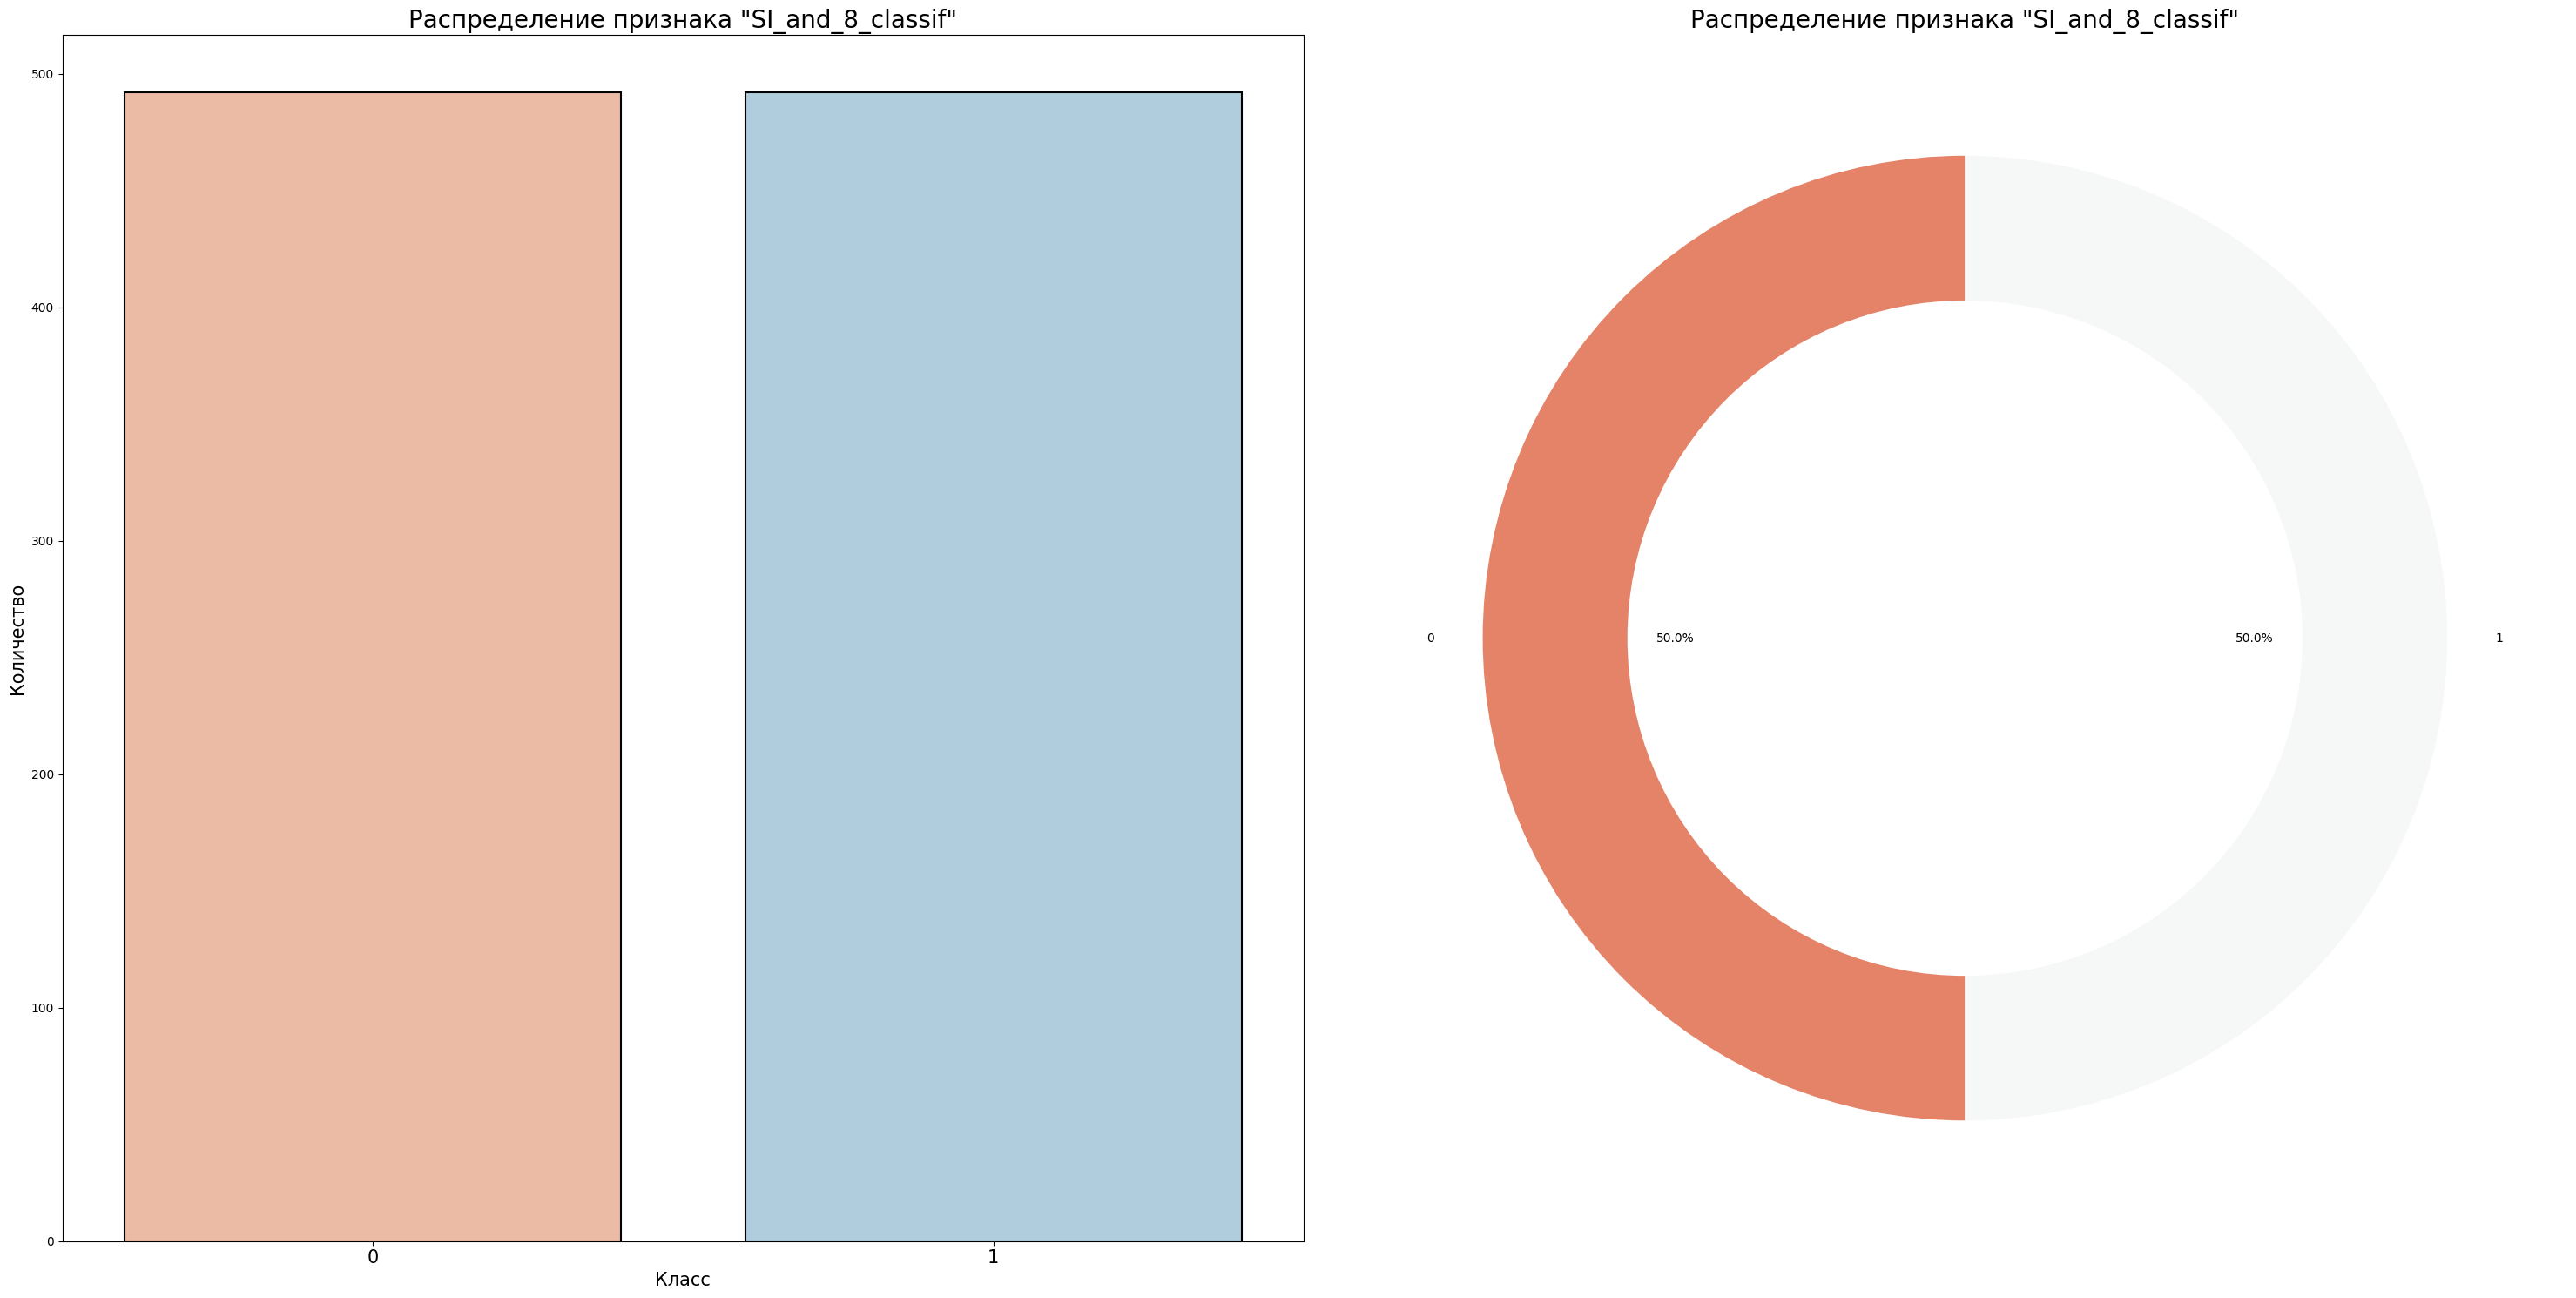

------------------------------------------------------------------------------------------------------------------------------------------------------


In [59]:
# Применяем функцию 'median_target_distribution_plot()' для построения графика распределения целевой переменной
median_target_distribution_plot(
    target = y_train_os['SI_and_8_classif'],
    title1 = 'Распределение признака "SI_and_8_classif"',
    main_title = 'Стобчатая и круговая диаграммы распределения целевой переменной "SI_and_8_classif":',
    color_palette = 'RdBu',
    figsize = (30, 15)
)

Проверим корреляцию отобранных признаков:


Тепловая карта корреляции отобранных признаков:
------------------------------------------------------------------------------------------------------------------------------------------------------


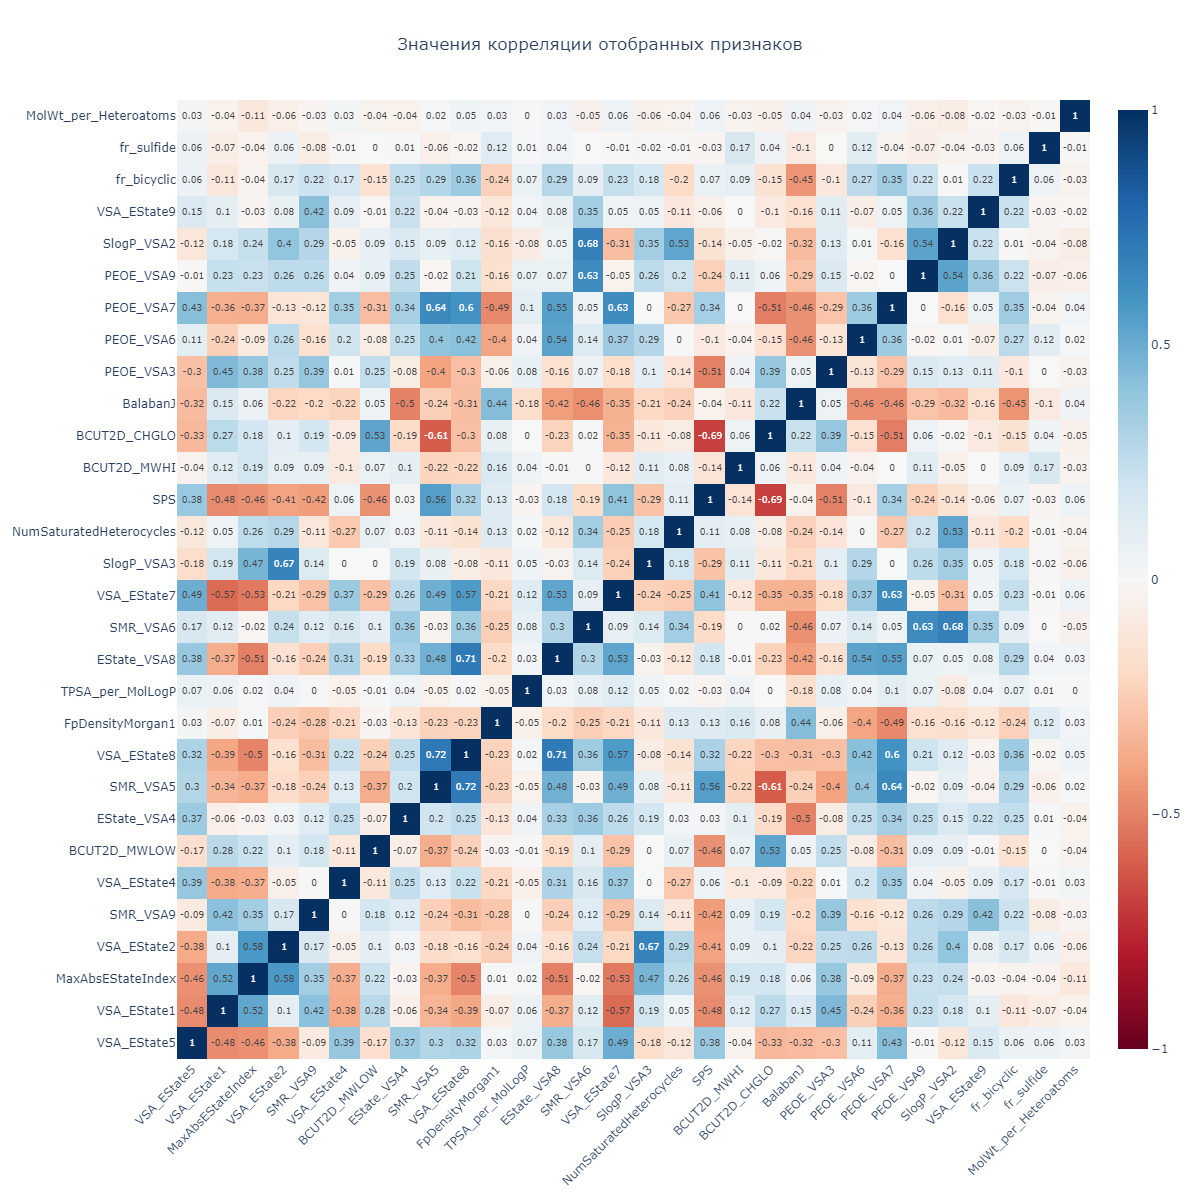

------------------------------------------------------------------------------------------------------------------------------------------------------


In [61]:
# Применяем функцию 'heatmap_corr()' для построения тепловой карты корреляции
heatmap_corr(data = X_train_os)

**Вывод:**

Из полученной тепловой карты видно, что значения корреляций находятся в пределах $+-0.69$, следовательно высококоррелированные связи отсутствуют. Данные полностью готовы к использованию для обучения модели.

#### $4.3$

#### **Machine Learning.**

Используем всё те же модели, что и для предсказания предыдущих переменных: 

* **XGBoost (Extreme Gradient Boosting)**, 
* **LightGBM (Light Gradient Boosting Machine)**, 
* **Support Vector Machine (SVM) с ядром RBF**, 
* **RandomForestClassifier**, 
* **MLPClassifier**.

Используем созданный ранее словарь `ML_models`, после чего обучим модели и построим предсказания:

Обучаем моделей и строим предсказания:

In [64]:
# Создаём словарь, в котором будем хранить наши предсказания
results = {}


# Создём цикл по созданному ранее словарю с моделями
# и обучаем их при помощи функции 'train_model'
for name, config in ML_models.items():
    
    # Заносим в словарь 'results' модели и метрики
    results[name] = train_model(
        name,
        config = config,
        X_train = X_train_os,
        X_test = X_test_final,
        y_train = y_train_os,
        y_test = y_test
    )




Обучение модели: XGBoost
Fitting 3 folds for each of 486 candidates, totalling 1458 fits
Лучшие параметры для XGBoost: {'colsample_bytree': 0.6, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200, 'scale_pos_weight': 1, 'subsample': 0.6}
--------------------------------------------------------------------------------




XGBoost (значения метрик):

Accuracy: 0.691
--------------------------------------------------------------------------------
Precision: 0.678
--------------------------------------------------------------------------------
Recall: 0.691
--------------------------------------------------------------------------------
F1-score: 0.678
--------------------------------------------------------------------------------

Classification report:

              precision    recall  f1-score   support

           0       0.73      0.83      0.78       117
           1       0.58      0.44      0.50        64

    accuracy                           0.69       181
   macro 

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_label.py:97: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_label.py:132: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



[LightGBM] [Info] Number of positive: 492, number of negative: 492
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000916 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5208
[LightGBM] [Info] Number of data points in the train set: 984, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wit

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



Лучшие параметры для SVC: {'C': 10, 'class_weight': 'balanced', 'gamma': 1}
--------------------------------------------------------------------------------




SVC (значения метрик):

Accuracy: 0.691
--------------------------------------------------------------------------------
Precision: 0.676
--------------------------------------------------------------------------------
Recall: 0.691
--------------------------------------------------------------------------------
F1-score: 0.661
--------------------------------------------------------------------------------

Classification report:

              precision    recall  f1-score   support

           0       0.71      0.89      0.79       117
           1       0.62      0.33      0.43        64

    accuracy                           0.69       181
   macro avg       0.66      0.61      0.61       181
weighted avg       0.68      0.69      0.66       181

----------------------------------------------------------------------------

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning:

invalid value encountered in cast

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



Лучшие параметры для RandomForest: {'class_weight': 'balanced_subsample', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
--------------------------------------------------------------------------------




RandomForest (значения метрик):

Accuracy: 0.729
--------------------------------------------------------------------------------
Precision: 0.722
--------------------------------------------------------------------------------
Recall: 0.729
--------------------------------------------------------------------------------
F1-score: 0.723
--------------------------------------------------------------------------------

Classification report:

              precision    recall  f1-score   support

           0       0.77      0.84      0.80       117
           1       0.64      0.53      0.58        64

    accuracy                           0.73       181
   macro avg       0.70      0.68      0.69       181
weighted avg       0.72      0.73    

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1105: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



Лучшие параметры для MLPClassifier: {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,), 'learning_rate_init': 0.01, 'max_iter': 200}
--------------------------------------------------------------------------------




MLPClassifier (значения метрик):

Accuracy: 0.646
--------------------------------------------------------------------------------
Precision: 0.644
--------------------------------------------------------------------------------
Recall: 0.646
--------------------------------------------------------------------------------
F1-score: 0.645
--------------------------------------------------------------------------------

Classification report:

              precision    recall  f1-score   support

           0       0.72      0.74      0.73       117
           1       0.50      0.48      0.49        64

    accuracy                           0.65       181
   macro avg       0.61      0.61      0.61       181
weighted avg       0.64      0.65      0.65    

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



#### $4.4$

#### **Определяем лучшую модель.**

Составим таблицу (**DataFrame**) со следующими столбцами:

Наименование модели:

* `model_name`,

Метрики и их значения:

* `Accuracy`,

* `Precision`,

* `Recall`,

* `F1-score`.

In [65]:
# Создаём словарь с метриками моделей
model_metrics = {
    'XGBClassifier'             : {'Accuracy': 0.691, 'Precision': 0.678, 'Recall': 0.691, 'F1-score': 0.678},
    'LGBMClassifier'            : {'Accuracy': 0.696, 'Precision': 0.688, 'Recall': 0.696, 'F1-score': 0.690},
    'RandomForestClassifier'    : {'Accuracy': 0.729, 'Precision': 0.722, 'Recall': 0.729, 'F1-score': 0.723},
    'SupportVectorClassifier'   : {'Accuracy': 0.691, 'Precision': 0.676, 'Recall': 0.691, 'F1-score': 0.661},
    'MLPClassifier'             : {'Accuracy': 0.646, 'Precision': 0.644, 'Recall': 0.646, 'F1-score': 0.645}
}


# Создаём DataFrame
metrics_df = pd.DataFrame(model_metrics).T
metrics_df = metrics_df.reset_index().rename(columns = {'index': 'model_name'})

**Визуализация метрик.**

Теперь построим графики по каждой метрике, чтобы сравнить их друг с другом визуально.


Данные таблицы "metrics_df" имеют следующую размерность:

Количество строк: 5;
Количество признаков (столбцов): 5.
-----------------------------------


model_name  Accuracy  Precision  Recall  F1-score
0            XGBClassifier     0.691      0.678   0.691     0.678
1           LGBMClassifier     0.696      0.688   0.696     0.690
2   RandomForestClassifier     0.729      0.722   0.729     0.723
3  SupportVectorClassifier     0.691      0.676   0.691     0.661
4            MLPClassifier     0.646      0.644   0.646     0.645

------------------------------------------------------------




Столбчатая диаграмма сравнения метрик моделей классификации ("CC50"):
------------------------------------------------------------------------------------------------------------------------------------------------------


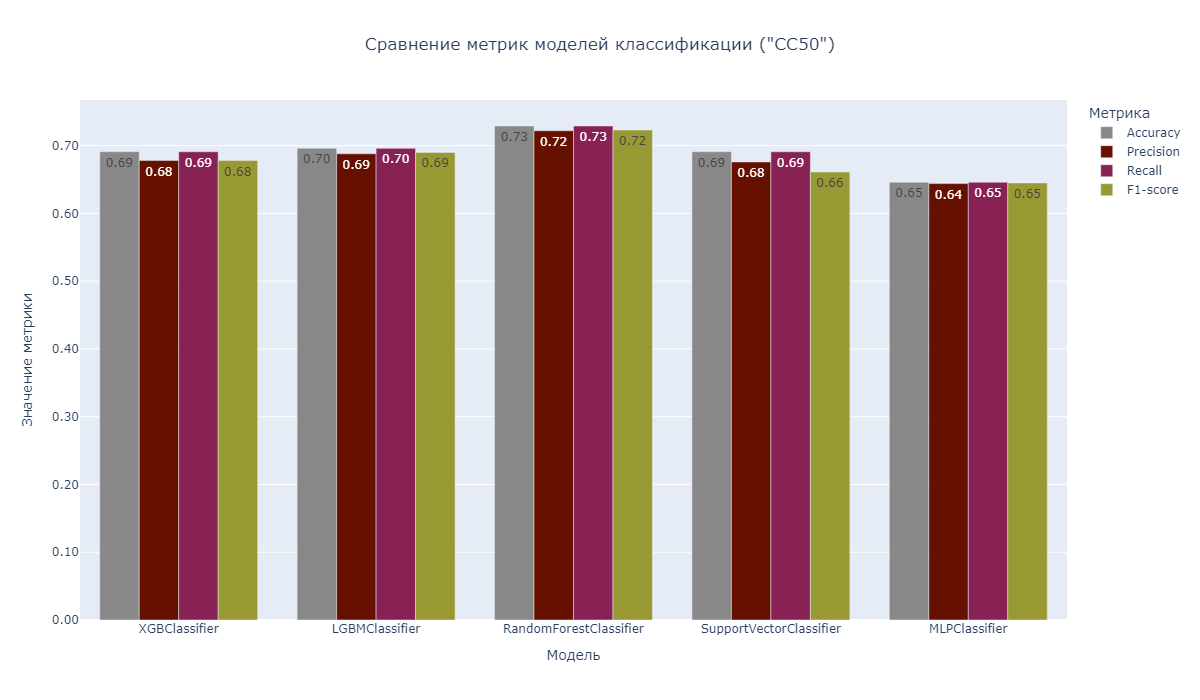

------------------------------------------------------------------------------------------------------------------------------------------------------


In [70]:
# Выводим результат
check_data_inf(
    data = metrics_df,
    data_name = 'metrics_df',
    length1 = 35,
    length2 = 60
)
print('\n\n')


# Применяем функцию 'metrics_bar_plot()' для построения столбчатого графика метрик
metrics_bar_plot(
    data = metrics_df,
    main_title = 'Столбчатая диаграмма сравнения метрик моделей классификации ("CC50"):',
    title = 'Сравнение метрик моделей классификации ("CC50")',
    colors = px.colors.qualitative.Safe_r
)

#### $4.5$

#### **Вывод:**

Лучшее качество значений метрик для данной задачи показала модель `RandomForestClassifier`.